<a href="https://colab.research.google.com/github/derejesenay/CarRental/blob/main/Copy_of_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import os
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
import tensorflow as tf
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import models
import torchvision.transforms as transforms
import torchvision.models as models
from transformers import AutoTokenizer, AutoModel
from torchvision import models, transforms
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import smart_resize
from sklearn.metrics import accuracy_score, log_loss

In [ ]:
!git clone https://github.com/echen102/COVID-19-TweetIDs.git


Cloning into 'COVID-19-TweetIDs'...
remote: Enumerating objects: 27857, done.
remote: Counting objects: 100% (6580/6580), done.
remote: Compressing objects: 100% (6563/6563), done.
remote: Total 27857 (delta 24), reused 6567 (delta 17), pack-reused 21277 (from 1)
Receiving objects: 100% (27857/27857), 16.36 GiB | 18.09 MiB/s, done.
Resolving deltas: 100% (535/535), done.
Updating files: 100% (26920/26920), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))
with open(filename, 'r', encoding='utf-8') as file:
    text_data = file.read()
print("First 500 characters:\n", text_data[:500])

In [ ]:
!pip install sacremoses


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 9.7 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("microsoft/BioGPT")
text_model = AutoModel.from_pretrained("microsoft/BioGPT")
text_model.eval()

def get_text_embedding(text_data):
    inputs = tokenizer(text_data, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = text_model(**inputs)
    return torch.mean(outputs.last_hidden_state, dim=1)  # [1, hidden_size]


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

In [ ]:
def load_dataset(data_dir, img_size=(224, 224)):
    images = []
    labels = []

    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)

        for filename in os.listdir(class_dir):
            if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)

            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(class_idx)

    return np.array(images), np.array(labels), class_names

data_dir = r'/content/drive/My Drive/data-store'
images, labels, class_names = load_dataset(data_dir)

print(f"Loaded {len(images)} images across {len(class_names)} categories.")
print(f"Class labels: {dict(enumerate(class_names))}")

Loaded 2505 images across 2 categories.
Class labels: {0: 'COVID', 1: 'non-COVID'}


In [ ]:
vgg = models.vgg16(pretrained=True)
vgg.classifier = nn.Identity()
vgg.eval()
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0)
    with torch.no_grad():
        features = vgg(image_tensor)
    return features.squeeze(0)

data_dir = "/content/drive/My Drive/data-store"

image_paths = []
labels = []

for label_name in ['COVID', 'non-COVID']:
    folder_path = os.path.join(data_dir, label_name)
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(folder_path, filename))
            labels.append(1 if label_name == 'covid19' else 0)

image_features = []
for img_path in image_paths:
    try:
        feat = get_image_embedding(img_path)
        image_features.append(feat)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

print(f"Extracted features for {len(image_features)} images.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 123MB/s]


Extracted features for 2505 images.


In [ ]:
import torch.nn as nn

class FusionModel(nn.Module):
    def __init__(self, text_dim=1024, image_dim=25088, hidden_dim=512, output_dim=1):
        super(FusionModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(text_dim + image_dim, hidden_dim),  # 1024 + 25088 = 26112
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, text_feat, image_feat):
        text_feat = text_feat.view(text_feat.size(0), -1)
        image_feat = image_feat.view(image_feat.size(0), -1)
        fused = torch.cat((text_feat, image_feat), dim=1)
        output = self.fc(fused)
        return output


In [ ]:
print(f"Text feat shape: {text_feat.shape}")
print(f"Image feat shape: {image_feat.shape}")


Text feat shape: torch.Size([1, 1024])
Image feat shape: torch.Size([1, 25088])


In [ ]:
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionModel().to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
pos_weight = torch.tensor([8.0 / 2.0]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
model.train()
fused_outputs = []

min_length = min(len(image_features), len(text_data), len(labels))

for i in tqdm(range(min_length)):
    image_feat = image_features[i].to(device).unsqueeze(0)
    text_feat = get_text_embedding(text_data[i]).to(device).unsqueeze(0)

    # Optional flattening
    image_feat = image_feat.view(image_feat.size(0), -1)
    text_feat = text_feat.view(text_feat.size(0), -1)

    label = torch.tensor([labels[i]], dtype=torch.float).to(device)

    optimizer.zero_grad()
    output = model(text_feat, image_feat)
    output = output.view(-1)
    loss = loss_fn(output, label)
    loss.backward()
    optimizer.step()

    fused_outputs.append(output.detach().cpu())

    print(f"Step {i}: Logit={output.item():.4f}, Loss={loss.item():.4f}, Label={label.item()}")

  0%|          | 1/2505 [00:01<48:21,  1.16s/it]

Step 0: Logit=-0.1975, Loss=0.5993, Label=0.0


  0%|          | 2/2505 [00:01<38:13,  1.09it/s]

Step 1: Logit=-1.2162, Loss=0.2596, Label=0.0


  0%|          | 3/2505 [00:02<35:01,  1.19it/s]

Step 2: Logit=-2.3866, Loss=0.0880, Label=0.0


  0%|          | 4/2505 [00:03<33:39,  1.24it/s]

Step 3: Logit=-4.4666, Loss=0.0114, Label=0.0


  0%|          | 5/2505 [00:04<32:32,  1.28it/s]

Step 4: Logit=-5.1031, Loss=0.0061, Label=0.0


  0%|          | 6/2505 [00:04<32:16,  1.29it/s]

Step 5: Logit=-6.5882, Loss=0.0014, Label=0.0


  0%|          | 7/2505 [00:05<31:06,  1.34it/s]

Step 6: Logit=-7.9542, Loss=0.0004, Label=0.0


  0%|          | 8/2505 [00:06<27:56,  1.49it/s]

Step 7: Logit=-8.0611, Loss=0.0003, Label=0.0


  0%|          | 9/2505 [00:06<24:33,  1.69it/s]

Step 8: Logit=-9.6200, Loss=0.0001, Label=0.0


  0%|          | 10/2505 [00:07<23:29,  1.77it/s]

Step 9: Logit=-10.7911, Loss=0.0000, Label=0.0


  0%|          | 11/2505 [00:07<23:03,  1.80it/s]

Step 10: Logit=-10.4338, Loss=0.0000, Label=0.0


  0%|          | 12/2505 [00:07<21:12,  1.96it/s]

Step 11: Logit=-14.3393, Loss=0.0000, Label=0.0


  1%|          | 13/2505 [00:08<21:19,  1.95it/s]

Step 12: Logit=-14.8063, Loss=0.0000, Label=0.0


  1%|          | 14/2505 [00:09<21:20,  1.95it/s]

Step 13: Logit=-14.2662, Loss=0.0000, Label=0.0


  1%|          | 15/2505 [00:09<20:12,  2.05it/s]

Step 14: Logit=-16.6496, Loss=0.0000, Label=0.0


  1%|          | 16/2505 [00:09<20:26,  2.03it/s]

Step 15: Logit=-17.4404, Loss=0.0000, Label=0.0


  1%|          | 17/2505 [00:10<20:47,  1.99it/s]

Step 16: Logit=-16.8914, Loss=0.0000, Label=0.0


  1%|          | 18/2505 [00:10<20:50,  1.99it/s]

Step 17: Logit=-18.6212, Loss=0.0000, Label=0.0


  1%|          | 19/2505 [00:11<21:11,  1.95it/s]

Step 18: Logit=-17.8616, Loss=0.0000, Label=0.0


  1%|          | 20/2505 [00:12<21:20,  1.94it/s]

Step 19: Logit=-15.3561, Loss=0.0000, Label=0.0


  1%|          | 21/2505 [00:12<21:28,  1.93it/s]

Step 20: Logit=-19.0735, Loss=0.0000, Label=0.0


  1%|          | 22/2505 [00:13<21:20,  1.94it/s]

Step 21: Logit=-20.5050, Loss=0.0000, Label=0.0


  1%|          | 23/2505 [00:13<20:03,  2.06it/s]

Step 22: Logit=-20.1745, Loss=0.0000, Label=0.0


  1%|          | 24/2505 [00:13<20:26,  2.02it/s]

Step 23: Logit=-20.7329, Loss=0.0000, Label=0.0


  1%|          | 25/2505 [00:14<20:38,  2.00it/s]

Step 24: Logit=-18.6714, Loss=0.0000, Label=0.0


  1%|          | 26/2505 [00:15<20:54,  1.98it/s]

Step 25: Logit=-20.1414, Loss=0.0000, Label=0.0


  1%|          | 27/2505 [00:15<21:28,  1.92it/s]

Step 26: Logit=-21.1736, Loss=0.0000, Label=0.0


  1%|          | 28/2505 [00:16<23:41,  1.74it/s]

Step 27: Logit=-17.4899, Loss=0.0000, Label=0.0


  1%|          | 29/2505 [00:16<25:14,  1.64it/s]

Step 28: Logit=-21.2598, Loss=0.0000, Label=0.0


  1%|          | 30/2505 [00:17<24:23,  1.69it/s]

Step 29: Logit=-18.7572, Loss=0.0000, Label=0.0


  1%|          | 31/2505 [00:18<25:46,  1.60it/s]

Step 30: Logit=-17.1198, Loss=0.0000, Label=0.0


  1%|▏         | 32/2505 [00:18<26:53,  1.53it/s]

Step 31: Logit=-21.6437, Loss=0.0000, Label=0.0


  1%|▏         | 33/2505 [00:19<25:40,  1.60it/s]

Step 32: Logit=-19.4950, Loss=0.0000, Label=0.0


  1%|▏         | 34/2505 [00:20<26:07,  1.58it/s]

Step 33: Logit=-18.4336, Loss=0.0000, Label=0.0


  1%|▏         | 35/2505 [00:20<24:32,  1.68it/s]

Step 34: Logit=-21.2136, Loss=0.0000, Label=0.0


  1%|▏         | 36/2505 [00:21<23:37,  1.74it/s]

Step 35: Logit=-17.6036, Loss=0.0000, Label=0.0


  1%|▏         | 37/2505 [00:21<22:49,  1.80it/s]

Step 36: Logit=-19.5409, Loss=0.0000, Label=0.0


  2%|▏         | 38/2505 [00:22<22:24,  1.84it/s]

Step 37: Logit=-25.0803, Loss=0.0000, Label=0.0


  2%|▏         | 39/2505 [00:22<21:58,  1.87it/s]

Step 38: Logit=-17.1676, Loss=0.0000, Label=0.0


  2%|▏         | 40/2505 [00:23<21:50,  1.88it/s]

Step 39: Logit=-18.3932, Loss=0.0000, Label=0.0


  2%|▏         | 41/2505 [00:23<21:35,  1.90it/s]

Step 40: Logit=-17.8666, Loss=0.0000, Label=0.0


  2%|▏         | 42/2505 [00:24<21:34,  1.90it/s]

Step 41: Logit=-18.8907, Loss=0.0000, Label=0.0


  2%|▏         | 43/2505 [00:24<21:28,  1.91it/s]

Step 42: Logit=-20.7512, Loss=0.0000, Label=0.0


  2%|▏         | 44/2505 [00:25<20:02,  2.05it/s]

Step 43: Logit=-21.8913, Loss=0.0000, Label=0.0


  2%|▏         | 45/2505 [00:25<20:30,  2.00it/s]

Step 44: Logit=-26.0664, Loss=0.0000, Label=0.0


  2%|▏         | 46/2505 [00:26<20:45,  1.98it/s]

Step 45: Logit=-20.8139, Loss=0.0000, Label=0.0


  2%|▏         | 47/2505 [00:26<20:54,  1.96it/s]

Step 46: Logit=-20.9958, Loss=0.0000, Label=0.0


  2%|▏         | 48/2505 [00:27<20:54,  1.96it/s]

Step 47: Logit=-19.5622, Loss=0.0000, Label=0.0


  2%|▏         | 49/2505 [00:27<19:51,  2.06it/s]

Step 48: Logit=-21.1885, Loss=0.0000, Label=0.0


  2%|▏         | 50/2505 [00:28<20:19,  2.01it/s]

Step 49: Logit=-20.5476, Loss=0.0000, Label=0.0


  2%|▏         | 51/2505 [00:28<20:41,  1.98it/s]

Step 50: Logit=-18.9939, Loss=0.0000, Label=0.0


  2%|▏         | 52/2505 [00:29<20:50,  1.96it/s]

Step 51: Logit=-20.3748, Loss=0.0000, Label=0.0


  2%|▏         | 53/2505 [00:29<21:00,  1.94it/s]

Step 52: Logit=-21.1826, Loss=0.0000, Label=0.0


  2%|▏         | 54/2505 [00:30<22:34,  1.81it/s]

Step 53: Logit=-18.3583, Loss=0.0000, Label=0.0


  2%|▏         | 55/2505 [00:31<24:34,  1.66it/s]

Step 54: Logit=-22.5926, Loss=0.0000, Label=0.0


  2%|▏         | 56/2505 [00:31<26:02,  1.57it/s]

Step 55: Logit=-24.5163, Loss=0.0000, Label=0.0


  2%|▏         | 57/2505 [00:32<24:38,  1.66it/s]

Step 56: Logit=-19.6257, Loss=0.0000, Label=0.0


  2%|▏         | 58/2505 [00:33<25:48,  1.58it/s]

Step 57: Logit=-22.2912, Loss=0.0000, Label=0.0


  2%|▏         | 59/2505 [00:33<27:10,  1.50it/s]

Step 58: Logit=-21.6547, Loss=0.0000, Label=0.0


  2%|▏         | 60/2505 [00:34<25:29,  1.60it/s]

Step 59: Logit=-22.0950, Loss=0.0000, Label=0.0


  2%|▏         | 61/2505 [00:34<24:24,  1.67it/s]

Step 60: Logit=-19.5427, Loss=0.0000, Label=0.0


  2%|▏         | 62/2505 [00:35<23:10,  1.76it/s]

Step 61: Logit=-20.8699, Loss=0.0000, Label=0.0


  3%|▎         | 63/2505 [00:35<22:18,  1.82it/s]

Step 62: Logit=-21.1441, Loss=0.0000, Label=0.0


  3%|▎         | 64/2505 [00:36<21:57,  1.85it/s]

Step 63: Logit=-23.0028, Loss=0.0000, Label=0.0


  3%|▎         | 65/2505 [00:36<20:12,  2.01it/s]

Step 64: Logit=-19.8573, Loss=0.0000, Label=0.0


  3%|▎         | 66/2505 [00:37<20:32,  1.98it/s]

Step 65: Logit=-26.8954, Loss=0.0000, Label=0.0


  3%|▎         | 67/2505 [00:37<20:33,  1.98it/s]

Step 66: Logit=-24.0069, Loss=0.0000, Label=0.0


  3%|▎         | 68/2505 [00:38<20:45,  1.96it/s]

Step 67: Logit=-22.1490, Loss=0.0000, Label=0.0


  3%|▎         | 69/2505 [00:38<20:42,  1.96it/s]

Step 68: Logit=-21.5874, Loss=0.0000, Label=0.0


  3%|▎         | 70/2505 [00:39<19:22,  2.10it/s]

Step 69: Logit=-22.2656, Loss=0.0000, Label=0.0


  3%|▎         | 71/2505 [00:39<19:42,  2.06it/s]

Step 70: Logit=-21.0907, Loss=0.0000, Label=0.0


  3%|▎         | 72/2505 [00:40<20:05,  2.02it/s]

Step 71: Logit=-22.1722, Loss=0.0000, Label=0.0


  3%|▎         | 73/2505 [00:40<20:07,  2.01it/s]

Step 72: Logit=-18.8254, Loss=0.0000, Label=0.0


  3%|▎         | 74/2505 [00:41<18:57,  2.14it/s]

Step 73: Logit=-20.5374, Loss=0.0000, Label=0.0


  3%|▎         | 75/2505 [00:41<19:39,  2.06it/s]

Step 74: Logit=-18.7787, Loss=0.0000, Label=0.0


  3%|▎         | 76/2505 [00:42<19:56,  2.03it/s]

Step 75: Logit=-24.9252, Loss=0.0000, Label=0.0


  3%|▎         | 77/2505 [00:42<20:16,  2.00it/s]

Step 76: Logit=-20.4600, Loss=0.0000, Label=0.0


  3%|▎         | 78/2505 [00:43<20:12,  2.00it/s]

Step 77: Logit=-21.7290, Loss=0.0000, Label=0.0


  3%|▎         | 79/2505 [00:43<20:35,  1.96it/s]

Step 78: Logit=-17.8536, Loss=0.0000, Label=0.0


  3%|▎         | 80/2505 [00:44<20:34,  1.96it/s]

Step 79: Logit=-18.8919, Loss=0.0000, Label=0.0


  3%|▎         | 81/2505 [00:44<22:35,  1.79it/s]

Step 80: Logit=-13.0585, Loss=0.0000, Label=0.0


  3%|▎         | 82/2505 [00:45<22:08,  1.82it/s]

Step 81: Logit=-22.5889, Loss=0.0000, Label=0.0


  3%|▎         | 83/2505 [00:46<24:01,  1.68it/s]

Step 82: Logit=-14.0461, Loss=0.0000, Label=0.0


  3%|▎         | 84/2505 [00:46<25:14,  1.60it/s]

Step 83: Logit=-14.2466, Loss=0.0000, Label=0.0


  3%|▎         | 85/2505 [00:47<26:02,  1.55it/s]

Step 84: Logit=-20.5457, Loss=0.0000, Label=0.0


  3%|▎         | 86/2505 [00:48<26:51,  1.50it/s]

Step 85: Logit=-18.7765, Loss=0.0000, Label=0.0


  3%|▎         | 87/2505 [00:49<27:05,  1.49it/s]

Step 86: Logit=-14.2776, Loss=0.0000, Label=0.0


  4%|▎         | 88/2505 [00:49<25:21,  1.59it/s]

Step 87: Logit=-21.0068, Loss=0.0000, Label=0.0


  4%|▎         | 89/2505 [00:50<23:59,  1.68it/s]

Step 88: Logit=-18.1707, Loss=0.0000, Label=0.0


  4%|▎         | 90/2505 [00:50<21:41,  1.86it/s]

Step 89: Logit=-19.2540, Loss=0.0000, Label=0.0


  4%|▎         | 91/2505 [00:50<21:20,  1.88it/s]

Step 90: Logit=-18.8928, Loss=0.0000, Label=0.0


  4%|▎         | 92/2505 [00:51<20:59,  1.92it/s]

Step 91: Logit=-19.0809, Loss=0.0000, Label=0.0


  4%|▎         | 93/2505 [00:51<19:35,  2.05it/s]

Step 92: Logit=-17.7514, Loss=0.0000, Label=0.0


  4%|▍         | 94/2505 [00:52<19:44,  2.04it/s]

Step 93: Logit=-25.4575, Loss=0.0000, Label=0.0


  4%|▍         | 95/2505 [00:52<19:45,  2.03it/s]

Step 94: Logit=-16.7845, Loss=0.0000, Label=0.0


  4%|▍         | 96/2505 [00:53<19:54,  2.02it/s]

Step 95: Logit=-22.5486, Loss=0.0000, Label=0.0


  4%|▍         | 97/2505 [00:53<18:40,  2.15it/s]

Step 96: Logit=-24.0308, Loss=0.0000, Label=0.0


  4%|▍         | 98/2505 [00:54<19:14,  2.08it/s]

Step 97: Logit=-21.8604, Loss=0.0000, Label=0.0


  4%|▍         | 99/2505 [00:54<19:31,  2.05it/s]

Step 98: Logit=-18.1965, Loss=0.0000, Label=0.0


  4%|▍         | 100/2505 [00:55<19:47,  2.02it/s]

Step 99: Logit=-16.2654, Loss=0.0000, Label=0.0


  4%|▍         | 101/2505 [00:55<19:50,  2.02it/s]

Step 100: Logit=-21.2094, Loss=0.0000, Label=0.0


  4%|▍         | 102/2505 [00:56<20:00,  2.00it/s]

Step 101: Logit=-21.0486, Loss=0.0000, Label=0.0


  4%|▍         | 103/2505 [00:56<20:02,  2.00it/s]

Step 102: Logit=-22.3553, Loss=0.0000, Label=0.0


  4%|▍         | 104/2505 [00:57<20:00,  2.00it/s]

Step 103: Logit=-20.4739, Loss=0.0000, Label=0.0


  4%|▍         | 105/2505 [00:57<20:00,  2.00it/s]

Step 104: Logit=-25.6031, Loss=0.0000, Label=0.0


  4%|▍         | 106/2505 [00:58<18:47,  2.13it/s]

Step 105: Logit=-23.3864, Loss=0.0000, Label=0.0


  4%|▍         | 107/2505 [00:58<19:10,  2.08it/s]

Step 106: Logit=-21.1936, Loss=0.0000, Label=0.0


  4%|▍         | 108/2505 [00:59<18:54,  2.11it/s]

Step 107: Logit=-23.0129, Loss=0.0000, Label=0.0


  4%|▍         | 109/2505 [00:59<21:28,  1.86it/s]

Step 108: Logit=-23.2571, Loss=0.0000, Label=0.0


  4%|▍         | 110/2505 [01:00<23:03,  1.73it/s]

Step 109: Logit=-20.6476, Loss=0.0000, Label=0.0


  4%|▍         | 111/2505 [01:01<24:18,  1.64it/s]

Step 110: Logit=-23.6201, Loss=0.0000, Label=0.0


  4%|▍         | 112/2505 [01:01<25:14,  1.58it/s]

Step 111: Logit=-19.9227, Loss=0.0000, Label=0.0


  5%|▍         | 113/2505 [01:02<25:59,  1.53it/s]

Step 112: Logit=-20.0306, Loss=0.0000, Label=0.0


  5%|▍         | 114/2505 [01:03<26:31,  1.50it/s]

Step 113: Logit=-20.1518, Loss=0.0000, Label=0.0


  5%|▍         | 115/2505 [01:03<23:46,  1.67it/s]

Step 114: Logit=-21.4886, Loss=0.0000, Label=0.0


  5%|▍         | 116/2505 [01:04<22:34,  1.76it/s]

Step 115: Logit=-22.8872, Loss=0.0000, Label=0.0


  5%|▍         | 117/2505 [01:04<21:56,  1.81it/s]

Step 116: Logit=-22.0671, Loss=0.0000, Label=0.0


  5%|▍         | 118/2505 [01:05<21:15,  1.87it/s]

Step 117: Logit=-21.9182, Loss=0.0000, Label=0.0


  5%|▍         | 119/2505 [01:05<20:58,  1.90it/s]

Step 118: Logit=-19.1379, Loss=0.0000, Label=0.0


  5%|▍         | 120/2505 [01:06<20:37,  1.93it/s]

Step 119: Logit=-19.7511, Loss=0.0000, Label=0.0


  5%|▍         | 121/2505 [01:06<20:31,  1.94it/s]

Step 120: Logit=-22.3150, Loss=0.0000, Label=0.0


  5%|▍         | 122/2505 [01:07<20:13,  1.96it/s]

Step 121: Logit=-22.8470, Loss=0.0000, Label=0.0


  5%|▍         | 123/2505 [01:07<20:10,  1.97it/s]

Step 122: Logit=-22.3218, Loss=0.0000, Label=0.0


  5%|▍         | 124/2505 [01:08<18:47,  2.11it/s]

Step 123: Logit=-22.7016, Loss=0.0000, Label=0.0


  5%|▍         | 125/2505 [01:08<18:58,  2.09it/s]

Step 124: Logit=-22.2080, Loss=0.0000, Label=0.0


  5%|▌         | 126/2505 [01:09<19:24,  2.04it/s]

Step 125: Logit=-18.6642, Loss=0.0000, Label=0.0


  5%|▌         | 127/2505 [01:09<18:09,  2.18it/s]

Step 126: Logit=-21.4837, Loss=0.0000, Label=0.0


  5%|▌         | 128/2505 [01:10<18:43,  2.12it/s]

Step 127: Logit=-22.1415, Loss=0.0000, Label=0.0


  5%|▌         | 129/2505 [01:10<18:54,  2.09it/s]

Step 128: Logit=-21.8530, Loss=0.0000, Label=0.0


  5%|▌         | 130/2505 [01:10<17:56,  2.21it/s]

Step 129: Logit=-21.7211, Loss=0.0000, Label=0.0


  5%|▌         | 131/2505 [01:11<18:31,  2.14it/s]

Step 130: Logit=-21.2182, Loss=0.0000, Label=0.0


  5%|▌         | 132/2505 [01:11<18:59,  2.08it/s]

Step 131: Logit=-20.8306, Loss=0.0000, Label=0.0


  5%|▌         | 133/2505 [01:12<19:21,  2.04it/s]

Step 132: Logit=-21.8360, Loss=0.0000, Label=0.0


  5%|▌         | 134/2505 [01:12<19:23,  2.04it/s]

Step 133: Logit=-25.3847, Loss=0.0000, Label=0.0


  5%|▌         | 135/2505 [01:13<19:52,  1.99it/s]

Step 134: Logit=-21.9942, Loss=0.0000, Label=0.0


  5%|▌         | 136/2505 [01:14<20:06,  1.96it/s]

Step 135: Logit=-25.5044, Loss=0.0000, Label=0.0


  5%|▌         | 137/2505 [01:14<22:21,  1.77it/s]

Step 136: Logit=-20.2290, Loss=0.0000, Label=0.0


  6%|▌         | 138/2505 [01:15<23:57,  1.65it/s]

Step 137: Logit=-22.2717, Loss=0.0000, Label=0.0


  6%|▌         | 139/2505 [01:16<24:30,  1.61it/s]

Step 138: Logit=-22.9396, Loss=0.0000, Label=0.0


  6%|▌         | 140/2505 [01:16<25:13,  1.56it/s]

Step 139: Logit=-22.8740, Loss=0.0000, Label=0.0


  6%|▌         | 141/2505 [01:17<24:00,  1.64it/s]

Step 140: Logit=-22.6836, Loss=0.0000, Label=0.0


  6%|▌         | 142/2505 [01:17<25:11,  1.56it/s]

Step 141: Logit=-24.4339, Loss=0.0000, Label=0.0


  6%|▌         | 143/2505 [01:18<23:48,  1.65it/s]

Step 142: Logit=-23.1100, Loss=0.0000, Label=0.0


  6%|▌         | 144/2505 [01:18<21:25,  1.84it/s]

Step 143: Logit=-23.0377, Loss=0.0000, Label=0.0


  6%|▌         | 145/2505 [01:19<20:53,  1.88it/s]

Step 144: Logit=-26.2392, Loss=0.0000, Label=0.0


  6%|▌         | 146/2505 [01:19<21:08,  1.86it/s]

Step 145: Logit=-25.1344, Loss=0.0000, Label=0.0


  6%|▌         | 147/2505 [01:20<20:41,  1.90it/s]

Step 146: Logit=-24.6370, Loss=0.0000, Label=0.0


  6%|▌         | 148/2505 [01:20<19:10,  2.05it/s]

Step 147: Logit=-24.9037, Loss=0.0000, Label=0.0


  6%|▌         | 149/2505 [01:21<19:16,  2.04it/s]

Step 148: Logit=-21.6734, Loss=0.0000, Label=0.0


  6%|▌         | 150/2505 [01:21<19:31,  2.01it/s]

Step 149: Logit=-20.6409, Loss=0.0000, Label=0.0


  6%|▌         | 151/2505 [01:22<19:22,  2.02it/s]

Step 150: Logit=-22.8411, Loss=0.0000, Label=0.0


  6%|▌         | 152/2505 [01:22<19:36,  2.00it/s]

Step 151: Logit=-22.5504, Loss=0.0000, Label=0.0


  6%|▌         | 153/2505 [01:23<19:34,  2.00it/s]

Step 152: Logit=-22.4195, Loss=0.0000, Label=0.0


  6%|▌         | 154/2505 [01:23<18:23,  2.13it/s]

Step 153: Logit=-22.6284, Loss=0.0000, Label=0.0


  6%|▌         | 155/2505 [01:24<18:39,  2.10it/s]

Step 154: Logit=-24.3652, Loss=0.0000, Label=0.0


  6%|▌         | 156/2505 [01:24<19:06,  2.05it/s]

Step 155: Logit=-22.0946, Loss=0.0000, Label=0.0


  6%|▋         | 157/2505 [01:25<19:12,  2.04it/s]

Step 156: Logit=-18.5310, Loss=0.0000, Label=0.0


  6%|▋         | 158/2505 [01:25<19:17,  2.03it/s]

Step 157: Logit=-23.7120, Loss=0.0000, Label=0.0


  6%|▋         | 159/2505 [01:26<19:32,  2.00it/s]

Step 158: Logit=-20.7947, Loss=0.0000, Label=0.0


  6%|▋         | 160/2505 [01:26<19:33,  2.00it/s]

Step 159: Logit=-21.6308, Loss=0.0000, Label=0.0


  6%|▋         | 161/2505 [01:27<18:22,  2.13it/s]

Step 160: Logit=-20.1575, Loss=0.0000, Label=0.0


  6%|▋         | 162/2505 [01:27<18:47,  2.08it/s]

Step 161: Logit=-21.6496, Loss=0.0000, Label=0.0


  7%|▋         | 163/2505 [01:28<20:14,  1.93it/s]

Step 162: Logit=-20.9397, Loss=0.0000, Label=0.0


  7%|▋         | 164/2505 [01:28<22:00,  1.77it/s]

Step 163: Logit=-21.9412, Loss=0.0000, Label=0.0


  7%|▋         | 165/2505 [01:29<23:25,  1.66it/s]

Step 164: Logit=-21.3847, Loss=0.0000, Label=0.0


  7%|▋         | 166/2505 [01:30<24:26,  1.59it/s]

Step 165: Logit=-23.7837, Loss=0.0000, Label=0.0


  7%|▋         | 167/2505 [01:31<24:58,  1.56it/s]

Step 166: Logit=-23.0534, Loss=0.0000, Label=0.0


  7%|▋         | 168/2505 [01:31<25:56,  1.50it/s]

Step 167: Logit=-25.6919, Loss=0.0000, Label=0.0


  7%|▋         | 169/2505 [01:32<26:24,  1.47it/s]

Step 168: Logit=-22.5998, Loss=0.0000, Label=0.0


  7%|▋         | 170/2505 [01:32<24:21,  1.60it/s]

Step 169: Logit=-21.3614, Loss=0.0000, Label=0.0


  7%|▋         | 171/2505 [01:33<22:50,  1.70it/s]

Step 170: Logit=-19.3660, Loss=0.0000, Label=0.0


  7%|▋         | 172/2505 [01:33<21:49,  1.78it/s]

Step 171: Logit=-18.6119, Loss=0.0000, Label=0.0


  7%|▋         | 173/2505 [01:34<21:08,  1.84it/s]

Step 172: Logit=-17.9240, Loss=0.0000, Label=0.0


  7%|▋         | 174/2505 [01:34<20:42,  1.88it/s]

Step 173: Logit=-21.3243, Loss=0.0000, Label=0.0


  7%|▋         | 175/2505 [01:35<19:00,  2.04it/s]

Step 174: Logit=-26.8404, Loss=0.0000, Label=0.0


  7%|▋         | 176/2505 [01:35<19:15,  2.02it/s]

Step 175: Logit=-20.7233, Loss=0.0000, Label=0.0


  7%|▋         | 177/2505 [01:36<19:07,  2.03it/s]

Step 176: Logit=-20.5933, Loss=0.0000, Label=0.0


  7%|▋         | 178/2505 [01:36<18:01,  2.15it/s]

Step 177: Logit=-20.2287, Loss=0.0000, Label=0.0


  7%|▋         | 179/2505 [01:37<18:24,  2.11it/s]

Step 178: Logit=-22.8117, Loss=0.0000, Label=0.0


  7%|▋         | 180/2505 [01:37<18:52,  2.05it/s]

Step 179: Logit=-24.2229, Loss=0.0000, Label=0.0


  7%|▋         | 181/2505 [01:38<18:57,  2.04it/s]

Step 180: Logit=-23.9410, Loss=0.0000, Label=0.0


  7%|▋         | 182/2505 [01:38<17:46,  2.18it/s]

Step 181: Logit=-21.9380, Loss=0.0000, Label=0.0


  7%|▋         | 183/2505 [01:39<18:23,  2.10it/s]

Step 182: Logit=-24.6847, Loss=0.0000, Label=0.0


  7%|▋         | 184/2505 [01:39<18:35,  2.08it/s]

Step 183: Logit=-19.4508, Loss=0.0000, Label=0.0


  7%|▋         | 185/2505 [01:40<18:55,  2.04it/s]

Step 184: Logit=-20.0611, Loss=0.0000, Label=0.0


  7%|▋         | 186/2505 [01:40<18:59,  2.03it/s]

Step 185: Logit=-25.1821, Loss=0.0000, Label=0.0


  7%|▋         | 187/2505 [01:41<17:53,  2.16it/s]

Step 186: Logit=-25.6524, Loss=0.0000, Label=0.0


  8%|▊         | 188/2505 [01:41<18:18,  2.11it/s]

Step 187: Logit=-22.8674, Loss=0.0000, Label=0.0


  8%|▊         | 189/2505 [01:42<18:42,  2.06it/s]

Step 188: Logit=-22.3063, Loss=0.0000, Label=0.0


  8%|▊         | 190/2505 [01:42<17:34,  2.20it/s]

Step 189: Logit=-22.3237, Loss=0.0000, Label=0.0


  8%|▊         | 191/2505 [01:43<20:14,  1.91it/s]

Step 190: Logit=-17.6633, Loss=0.0000, Label=0.0


  8%|▊         | 192/2505 [01:43<21:51,  1.76it/s]

Step 191: Logit=-19.0956, Loss=0.0000, Label=0.0


  8%|▊         | 193/2505 [01:44<23:29,  1.64it/s]

Step 192: Logit=-21.5477, Loss=0.0000, Label=0.0


  8%|▊         | 194/2505 [01:45<22:14,  1.73it/s]

Step 193: Logit=-22.4461, Loss=0.0000, Label=0.0


  8%|▊         | 195/2505 [01:45<23:21,  1.65it/s]

Step 194: Logit=-20.8780, Loss=0.0000, Label=0.0


  8%|▊         | 196/2505 [01:46<24:32,  1.57it/s]

Step 195: Logit=-23.9231, Loss=0.0000, Label=0.0


  8%|▊         | 197/2505 [01:47<24:55,  1.54it/s]

Step 196: Logit=-21.8018, Loss=0.0000, Label=0.0


  8%|▊         | 198/2505 [01:47<23:17,  1.65it/s]

Step 197: Logit=-22.3263, Loss=0.0000, Label=0.0


  8%|▊         | 199/2505 [01:48<22:03,  1.74it/s]

Step 198: Logit=-22.1552, Loss=0.0000, Label=0.0


  8%|▊         | 200/2505 [01:48<21:20,  1.80it/s]

Step 199: Logit=-24.2096, Loss=0.0000, Label=0.0


  8%|▊         | 201/2505 [01:49<20:35,  1.86it/s]

Step 200: Logit=-21.8050, Loss=0.0000, Label=0.0


  8%|▊         | 202/2505 [01:49<20:14,  1.90it/s]

Step 201: Logit=-21.1150, Loss=0.0000, Label=0.0


  8%|▊         | 203/2505 [01:50<18:44,  2.05it/s]

Step 202: Logit=-19.8669, Loss=0.0000, Label=0.0


  8%|▊         | 204/2505 [01:50<18:55,  2.03it/s]

Step 203: Logit=-21.6367, Loss=0.0000, Label=0.0


  8%|▊         | 205/2505 [01:51<18:53,  2.03it/s]

Step 204: Logit=-26.1927, Loss=0.0000, Label=0.0


  8%|▊         | 206/2505 [01:51<18:59,  2.02it/s]

Step 205: Logit=-19.2276, Loss=0.0000, Label=0.0


  8%|▊         | 207/2505 [01:51<18:55,  2.02it/s]

Step 206: Logit=-21.1917, Loss=0.0000, Label=0.0


  8%|▊         | 208/2505 [01:52<17:39,  2.17it/s]

Step 207: Logit=-16.1200, Loss=0.0000, Label=0.0


  8%|▊         | 209/2505 [01:52<18:16,  2.09it/s]

Step 208: Logit=-20.7081, Loss=0.0000, Label=0.0


  8%|▊         | 210/2505 [01:53<18:23,  2.08it/s]

Step 209: Logit=-22.6145, Loss=0.0000, Label=0.0


  8%|▊         | 211/2505 [01:53<18:42,  2.04it/s]

Step 210: Logit=-21.0887, Loss=0.0000, Label=0.0


  8%|▊         | 212/2505 [01:54<18:38,  2.05it/s]

Step 211: Logit=-21.9911, Loss=0.0000, Label=0.0


  9%|▊         | 213/2505 [01:54<18:55,  2.02it/s]

Step 212: Logit=-27.1447, Loss=0.0000, Label=0.0


  9%|▊         | 214/2505 [01:55<18:49,  2.03it/s]

Step 213: Logit=-19.6954, Loss=0.0000, Label=0.0


  9%|▊         | 215/2505 [01:55<19:03,  2.00it/s]

Step 214: Logit=-22.2637, Loss=0.0000, Label=0.0


  9%|▊         | 216/2505 [01:56<18:54,  2.02it/s]

Step 215: Logit=-19.6885, Loss=0.0000, Label=0.0


  9%|▊         | 217/2505 [01:56<17:49,  2.14it/s]

Step 216: Logit=-19.3696, Loss=0.0000, Label=0.0


  9%|▊         | 218/2505 [01:57<19:07,  1.99it/s]

Step 217: Logit=-18.5345, Loss=0.0000, Label=0.0


  9%|▊         | 219/2505 [01:58<21:13,  1.80it/s]

Step 218: Logit=-23.5644, Loss=0.0000, Label=0.0


  9%|▉         | 220/2505 [01:58<20:38,  1.84it/s]

Step 219: Logit=-28.6454, Loss=0.0000, Label=0.0


  9%|▉         | 221/2505 [01:59<22:15,  1.71it/s]

Step 220: Logit=-19.7647, Loss=0.0000, Label=0.0


  9%|▉         | 222/2505 [01:59<23:03,  1.65it/s]

Step 221: Logit=-21.5622, Loss=0.0000, Label=0.0


  9%|▉         | 223/2505 [02:00<21:55,  1.73it/s]

Step 222: Logit=-21.6178, Loss=0.0000, Label=0.0


  9%|▉         | 224/2505 [02:01<23:22,  1.63it/s]

Step 223: Logit=-21.9127, Loss=0.0000, Label=0.0


  9%|▉         | 225/2505 [02:01<23:34,  1.61it/s]

Step 224: Logit=-24.4660, Loss=0.0000, Label=0.0


  9%|▉         | 226/2505 [02:02<22:10,  1.71it/s]

Step 225: Logit=-22.9899, Loss=0.0000, Label=0.0


  9%|▉         | 227/2505 [02:02<21:05,  1.80it/s]

Step 226: Logit=-24.3242, Loss=0.0000, Label=0.0


  9%|▉         | 228/2505 [02:03<20:26,  1.86it/s]

Step 227: Logit=-25.3368, Loss=0.0000, Label=0.0


  9%|▉         | 229/2505 [02:03<19:54,  1.91it/s]

Step 228: Logit=-22.5369, Loss=0.0000, Label=0.0


  9%|▉         | 230/2505 [02:04<18:19,  2.07it/s]

Step 229: Logit=-21.4243, Loss=0.0000, Label=0.0


  9%|▉         | 231/2505 [02:04<18:40,  2.03it/s]

Step 230: Logit=-24.5936, Loss=0.0000, Label=0.0


  9%|▉         | 232/2505 [02:04<17:22,  2.18it/s]

Step 231: Logit=-20.4400, Loss=0.0000, Label=0.0


  9%|▉         | 233/2505 [02:05<17:51,  2.12it/s]

Step 232: Logit=-24.4038, Loss=0.0000, Label=0.0


  9%|▉         | 234/2505 [02:05<18:09,  2.08it/s]

Step 233: Logit=-22.8120, Loss=0.0000, Label=0.0


  9%|▉         | 235/2505 [02:06<18:36,  2.03it/s]

Step 234: Logit=-24.4495, Loss=0.0000, Label=0.0


  9%|▉         | 236/2505 [02:07<18:37,  2.03it/s]

Step 235: Logit=-24.3626, Loss=0.0000, Label=0.0


  9%|▉         | 237/2505 [02:07<18:47,  2.01it/s]

Step 236: Logit=-19.7203, Loss=0.0000, Label=0.0


 10%|▉         | 238/2505 [02:08<18:42,  2.02it/s]

Step 237: Logit=-19.6851, Loss=0.0000, Label=0.0


 10%|▉         | 239/2505 [02:08<17:27,  2.16it/s]

Step 238: Logit=-20.5374, Loss=0.0000, Label=0.0


 10%|▉         | 240/2505 [02:08<18:04,  2.09it/s]

Step 239: Logit=-24.9937, Loss=0.0000, Label=0.0


 10%|▉         | 241/2505 [02:09<18:07,  2.08it/s]

Step 240: Logit=-24.1576, Loss=0.0000, Label=0.0


 10%|▉         | 242/2505 [02:09<18:27,  2.04it/s]

Step 241: Logit=-24.1450, Loss=0.0000, Label=0.0


 10%|▉         | 243/2505 [02:10<18:19,  2.06it/s]

Step 242: Logit=-22.8601, Loss=0.0000, Label=0.0


 10%|▉         | 244/2505 [02:10<18:36,  2.03it/s]

Step 243: Logit=-22.2276, Loss=0.0000, Label=0.0


 10%|▉         | 245/2505 [02:11<18:30,  2.04it/s]

Step 244: Logit=-19.2002, Loss=0.0000, Label=0.0


 10%|▉         | 246/2505 [02:11<18:53,  1.99it/s]

Step 245: Logit=-24.8584, Loss=0.0000, Label=0.0


 10%|▉         | 247/2505 [02:12<20:27,  1.84it/s]

Step 246: Logit=-25.6908, Loss=0.0000, Label=0.0


 10%|▉         | 248/2505 [02:13<22:04,  1.70it/s]

Step 247: Logit=-24.5180, Loss=0.0000, Label=0.0


 10%|▉         | 249/2505 [02:13<23:26,  1.60it/s]

Step 248: Logit=-26.6479, Loss=0.0000, Label=0.0


 10%|▉         | 250/2505 [02:14<23:45,  1.58it/s]

Step 249: Logit=-25.6000, Loss=0.0000, Label=0.0


 10%|█         | 251/2505 [02:15<24:30,  1.53it/s]

Step 250: Logit=-22.9807, Loss=0.0000, Label=0.0


 10%|█         | 252/2505 [02:15<24:54,  1.51it/s]

Step 251: Logit=-23.4598, Loss=0.0000, Label=0.0


 10%|█         | 253/2505 [02:16<23:19,  1.61it/s]

Step 252: Logit=-28.1669, Loss=0.0000, Label=0.0


 10%|█         | 254/2505 [02:17<21:51,  1.72it/s]

Step 253: Logit=-25.3230, Loss=0.0000, Label=0.0


 10%|█         | 255/2505 [02:17<21:03,  1.78it/s]

Step 254: Logit=-24.8732, Loss=0.0000, Label=0.0


 10%|█         | 256/2505 [02:17<19:03,  1.97it/s]

Step 255: Logit=-22.4380, Loss=0.0000, Label=0.0


 10%|█         | 257/2505 [02:18<18:56,  1.98it/s]

Step 256: Logit=-26.2658, Loss=0.0000, Label=0.0


 10%|█         | 258/2505 [02:18<18:50,  1.99it/s]

Step 257: Logit=-23.8307, Loss=0.0000, Label=0.0


 10%|█         | 259/2505 [02:19<17:31,  2.14it/s]

Step 258: Logit=-26.4772, Loss=0.0000, Label=0.0


 10%|█         | 260/2505 [02:19<17:54,  2.09it/s]

Step 259: Logit=-24.9637, Loss=0.0000, Label=0.0


 10%|█         | 261/2505 [02:20<18:10,  2.06it/s]

Step 260: Logit=-25.1677, Loss=0.0000, Label=0.0


 10%|█         | 262/2505 [02:20<18:14,  2.05it/s]

Step 261: Logit=-21.7126, Loss=0.0000, Label=0.0


 10%|█         | 263/2505 [02:21<18:16,  2.04it/s]

Step 262: Logit=-22.0398, Loss=0.0000, Label=0.0


 11%|█         | 264/2505 [02:21<18:20,  2.04it/s]

Step 263: Logit=-19.6183, Loss=0.0000, Label=0.0


 11%|█         | 265/2505 [02:22<18:19,  2.04it/s]

Step 264: Logit=-24.0839, Loss=0.0000, Label=0.0


 11%|█         | 266/2505 [02:22<18:30,  2.02it/s]

Step 265: Logit=-24.2205, Loss=0.0000, Label=0.0


 11%|█         | 267/2505 [02:23<18:28,  2.02it/s]

Step 266: Logit=-25.5395, Loss=0.0000, Label=0.0


 11%|█         | 268/2505 [02:23<18:37,  2.00it/s]

Step 267: Logit=-20.0300, Loss=0.0000, Label=0.0


 11%|█         | 269/2505 [02:24<18:28,  2.02it/s]

Step 268: Logit=-21.9344, Loss=0.0000, Label=0.0


 11%|█         | 270/2505 [02:24<18:37,  2.00it/s]

Step 269: Logit=-26.6970, Loss=0.0000, Label=0.0


 11%|█         | 271/2505 [02:25<18:33,  2.01it/s]

Step 270: Logit=-22.0868, Loss=0.0000, Label=0.0


 11%|█         | 272/2505 [02:25<18:34,  2.00it/s]

Step 271: Logit=-22.2778, Loss=0.0000, Label=0.0


 11%|█         | 273/2505 [02:26<17:41,  2.10it/s]

Step 272: Logit=-21.7779, Loss=0.0000, Label=0.0


 11%|█         | 274/2505 [02:26<19:53,  1.87it/s]

Step 273: Logit=-18.6612, Loss=0.0000, Label=0.0


 11%|█         | 275/2505 [02:27<21:08,  1.76it/s]

Step 274: Logit=-21.5523, Loss=0.0000, Label=0.0


 11%|█         | 276/2505 [02:28<22:31,  1.65it/s]

Step 275: Logit=-20.1070, Loss=0.0000, Label=0.0


 11%|█         | 277/2505 [02:28<23:15,  1.60it/s]

Step 276: Logit=-22.5209, Loss=0.0000, Label=0.0


 11%|█         | 278/2505 [02:29<23:36,  1.57it/s]

Step 277: Logit=-19.5039, Loss=0.0000, Label=0.0


 11%|█         | 279/2505 [02:30<24:07,  1.54it/s]

Step 278: Logit=-16.1534, Loss=0.0000, Label=0.0


 11%|█         | 280/2505 [02:30<23:33,  1.57it/s]

Step 279: Logit=-20.0888, Loss=0.0000, Label=0.0


 11%|█         | 281/2505 [02:31<22:02,  1.68it/s]

Step 280: Logit=-26.0281, Loss=0.0000, Label=0.0


 11%|█▏        | 282/2505 [02:31<19:36,  1.89it/s]

Step 281: Logit=-21.5910, Loss=0.0000, Label=0.0


 11%|█▏        | 283/2505 [02:32<19:19,  1.92it/s]

Step 282: Logit=-24.6003, Loss=0.0000, Label=0.0


 11%|█▏        | 284/2505 [02:32<18:54,  1.96it/s]

Step 283: Logit=-23.1558, Loss=0.0000, Label=0.0


 11%|█▏        | 285/2505 [02:33<18:48,  1.97it/s]

Step 284: Logit=-23.7674, Loss=0.0000, Label=0.0


 11%|█▏        | 286/2505 [02:33<18:33,  1.99it/s]

Step 285: Logit=-20.6062, Loss=0.0000, Label=0.0


 11%|█▏        | 287/2505 [02:34<18:26,  2.00it/s]

Step 286: Logit=-22.0328, Loss=0.0000, Label=0.0


 11%|█▏        | 288/2505 [02:34<18:21,  2.01it/s]

Step 287: Logit=-18.9700, Loss=0.0000, Label=0.0


 12%|█▏        | 289/2505 [02:35<18:11,  2.03it/s]

Step 288: Logit=-23.4649, Loss=0.0000, Label=0.0


 12%|█▏        | 290/2505 [02:35<18:17,  2.02it/s]

Step 289: Logit=-22.0872, Loss=0.0000, Label=0.0


 12%|█▏        | 291/2505 [02:36<16:57,  2.17it/s]

Step 290: Logit=-22.8140, Loss=0.0000, Label=0.0


 12%|█▏        | 292/2505 [02:36<17:30,  2.11it/s]

Step 291: Logit=-20.8931, Loss=0.0000, Label=0.0


 12%|█▏        | 293/2505 [02:37<17:38,  2.09it/s]

Step 292: Logit=-25.7941, Loss=0.0000, Label=0.0


 12%|█▏        | 294/2505 [02:37<17:53,  2.06it/s]

Step 293: Logit=-20.3236, Loss=0.0000, Label=0.0


 12%|█▏        | 295/2505 [02:37<16:44,  2.20it/s]

Step 294: Logit=-20.9706, Loss=0.0000, Label=0.0


 12%|█▏        | 296/2505 [02:38<17:04,  2.16it/s]

Step 295: Logit=-18.2648, Loss=0.0000, Label=0.0


 12%|█▏        | 297/2505 [02:38<17:31,  2.10it/s]

Step 296: Logit=-21.9655, Loss=0.0000, Label=0.0


 12%|█▏        | 298/2505 [02:39<17:32,  2.10it/s]

Step 297: Logit=-21.7083, Loss=0.0000, Label=0.0


 12%|█▏        | 299/2505 [02:39<17:53,  2.05it/s]

Step 298: Logit=-24.2318, Loss=0.0000, Label=0.0


 12%|█▏        | 300/2505 [02:40<17:51,  2.06it/s]

Step 299: Logit=-21.9251, Loss=0.0000, Label=0.0


 12%|█▏        | 301/2505 [02:40<17:28,  2.10it/s]

Step 300: Logit=-24.6600, Loss=0.0000, Label=0.0


 12%|█▏        | 302/2505 [02:41<19:24,  1.89it/s]

Step 301: Logit=-21.4859, Loss=0.0000, Label=0.0


 12%|█▏        | 303/2505 [02:42<21:02,  1.74it/s]

Step 302: Logit=-25.1259, Loss=0.0000, Label=0.0


 12%|█▏        | 304/2505 [02:42<22:09,  1.66it/s]

Step 303: Logit=-23.1498, Loss=0.0000, Label=0.0


 12%|█▏        | 305/2505 [02:43<22:35,  1.62it/s]

Step 304: Logit=-22.8475, Loss=0.0000, Label=0.0


 12%|█▏        | 306/2505 [02:44<23:13,  1.58it/s]

Step 305: Logit=-23.1584, Loss=0.0000, Label=0.0


 12%|█▏        | 307/2505 [02:44<23:41,  1.55it/s]

Step 306: Logit=-22.9835, Loss=0.0000, Label=0.0


 12%|█▏        | 308/2505 [02:45<23:00,  1.59it/s]

Step 307: Logit=-26.0928, Loss=0.0000, Label=0.0


 12%|█▏        | 309/2505 [02:45<21:25,  1.71it/s]

Step 308: Logit=-24.9607, Loss=0.0000, Label=0.0


 12%|█▏        | 310/2505 [02:46<20:29,  1.79it/s]

Step 309: Logit=-23.0267, Loss=0.0000, Label=0.0


 12%|█▏        | 311/2505 [02:46<18:33,  1.97it/s]

Step 310: Logit=-22.2579, Loss=0.0000, Label=0.0


 12%|█▏        | 312/2505 [02:47<18:27,  1.98it/s]

Step 311: Logit=-21.4373, Loss=0.0000, Label=0.0


 12%|█▏        | 313/2505 [02:47<18:17,  2.00it/s]

Step 312: Logit=-24.6509, Loss=0.0000, Label=0.0


 13%|█▎        | 314/2505 [02:48<17:03,  2.14it/s]

Step 313: Logit=-22.3536, Loss=0.0000, Label=0.0


 13%|█▎        | 315/2505 [02:48<17:22,  2.10it/s]

Step 314: Logit=-26.1181, Loss=0.0000, Label=0.0


 13%|█▎        | 316/2505 [02:49<17:31,  2.08it/s]

Step 315: Logit=-21.9863, Loss=0.0000, Label=0.0


 13%|█▎        | 317/2505 [02:49<17:31,  2.08it/s]

Step 316: Logit=-25.3973, Loss=0.0000, Label=0.0


 13%|█▎        | 318/2505 [02:50<17:57,  2.03it/s]

Step 317: Logit=-23.6158, Loss=0.0000, Label=0.0


 13%|█▎        | 319/2505 [02:50<18:02,  2.02it/s]

Step 318: Logit=-22.6425, Loss=0.0000, Label=0.0


 13%|█▎        | 320/2505 [02:51<17:59,  2.02it/s]

Step 319: Logit=-25.0562, Loss=0.0000, Label=0.0


 13%|█▎        | 321/2505 [02:51<18:05,  2.01it/s]

Step 320: Logit=-19.5426, Loss=0.0000, Label=0.0


 13%|█▎        | 322/2505 [02:52<17:57,  2.03it/s]

Step 321: Logit=-21.7687, Loss=0.0000, Label=0.0


 13%|█▎        | 323/2505 [02:52<18:02,  2.02it/s]

Step 322: Logit=-22.6813, Loss=0.0000, Label=0.0


 13%|█▎        | 324/2505 [02:53<16:49,  2.16it/s]

Step 323: Logit=-24.6672, Loss=0.0000, Label=0.0


 13%|█▎        | 325/2505 [02:53<17:07,  2.12it/s]

Step 324: Logit=-20.9347, Loss=0.0000, Label=0.0


 13%|█▎        | 326/2505 [02:53<17:17,  2.10it/s]

Step 325: Logit=-25.5773, Loss=0.0000, Label=0.0


 13%|█▎        | 327/2505 [02:54<16:12,  2.24it/s]

Step 326: Logit=-22.5951, Loss=0.0000, Label=0.0


 13%|█▎        | 328/2505 [02:54<16:52,  2.15it/s]

Step 327: Logit=-22.1508, Loss=0.0000, Label=0.0


 13%|█▎        | 329/2505 [02:55<18:04,  2.01it/s]

Step 328: Logit=-26.2741, Loss=0.0000, Label=0.0


 13%|█▎        | 330/2505 [02:56<19:54,  1.82it/s]

Step 329: Logit=-22.8644, Loss=0.0000, Label=0.0


 13%|█▎        | 331/2505 [02:56<21:26,  1.69it/s]

Step 330: Logit=-25.5889, Loss=0.0000, Label=0.0


 13%|█▎        | 332/2505 [02:57<22:21,  1.62it/s]

Step 331: Logit=-21.4501, Loss=0.0000, Label=0.0


 13%|█▎        | 333/2505 [02:58<23:00,  1.57it/s]

Step 332: Logit=-17.4151, Loss=0.0000, Label=0.0


 13%|█▎        | 334/2505 [02:58<23:40,  1.53it/s]

Step 333: Logit=-19.4854, Loss=0.0000, Label=0.0


 13%|█▎        | 335/2505 [02:59<24:03,  1.50it/s]

Step 334: Logit=-22.3843, Loss=0.0000, Label=0.0


 13%|█▎        | 336/2505 [03:00<22:39,  1.59it/s]

Step 335: Logit=-22.6315, Loss=0.0000, Label=0.0


 13%|█▎        | 337/2505 [03:00<21:09,  1.71it/s]

Step 336: Logit=-22.2725, Loss=0.0000, Label=0.0


 13%|█▎        | 338/2505 [03:01<20:13,  1.79it/s]

Step 337: Logit=-23.5352, Loss=0.0000, Label=0.0


 14%|█▎        | 339/2505 [03:01<18:15,  1.98it/s]

Step 338: Logit=-19.0446, Loss=0.0000, Label=0.0


 14%|█▎        | 340/2505 [03:01<18:04,  2.00it/s]

Step 339: Logit=-22.0648, Loss=0.0000, Label=0.0


 14%|█▎        | 341/2505 [03:02<17:51,  2.02it/s]

Step 340: Logit=-22.8897, Loss=0.0000, Label=0.0


 14%|█▎        | 342/2505 [03:02<17:42,  2.04it/s]

Step 341: Logit=-22.4760, Loss=0.0000, Label=0.0


 14%|█▎        | 343/2505 [03:03<16:38,  2.17it/s]

Step 342: Logit=-21.0991, Loss=0.0000, Label=0.0


 14%|█▎        | 344/2505 [03:03<17:01,  2.11it/s]

Step 343: Logit=-21.1560, Loss=0.0000, Label=0.0


 14%|█▍        | 345/2505 [03:04<17:21,  2.07it/s]

Step 344: Logit=-21.9777, Loss=0.0000, Label=0.0


 14%|█▍        | 346/2505 [03:04<17:24,  2.07it/s]

Step 345: Logit=-21.5346, Loss=0.0000, Label=0.0


 14%|█▍        | 347/2505 [03:05<17:31,  2.05it/s]

Step 346: Logit=-22.8262, Loss=0.0000, Label=0.0


 14%|█▍        | 348/2505 [03:05<17:30,  2.05it/s]

Step 347: Logit=-20.2786, Loss=0.0000, Label=0.0


 14%|█▍        | 349/2505 [03:06<17:36,  2.04it/s]

Step 348: Logit=-22.7022, Loss=0.0000, Label=0.0


 14%|█▍        | 350/2505 [03:06<17:38,  2.04it/s]

Step 349: Logit=-21.1810, Loss=0.0000, Label=0.0


 14%|█▍        | 351/2505 [03:07<16:24,  2.19it/s]

Step 350: Logit=-20.6565, Loss=0.0000, Label=0.0


 14%|█▍        | 352/2505 [03:07<16:55,  2.12it/s]

Step 351: Logit=-22.6404, Loss=0.0000, Label=0.0


 14%|█▍        | 353/2505 [03:08<15:55,  2.25it/s]

Step 352: Logit=-22.2965, Loss=0.0000, Label=0.0


 14%|█▍        | 354/2505 [03:08<16:37,  2.16it/s]

Step 353: Logit=-23.1475, Loss=0.0000, Label=0.0


 14%|█▍        | 355/2505 [03:09<16:54,  2.12it/s]

Step 354: Logit=-22.8290, Loss=0.0000, Label=0.0


 14%|█▍        | 356/2505 [03:09<17:14,  2.08it/s]

Step 355: Logit=-22.9826, Loss=0.0000, Label=0.0


 14%|█▍        | 357/2505 [03:10<18:47,  1.90it/s]

Step 356: Logit=-21.7922, Loss=0.0000, Label=0.0


 14%|█▍        | 358/2505 [03:10<20:29,  1.75it/s]

Step 357: Logit=-21.5759, Loss=0.0000, Label=0.0


 14%|█▍        | 359/2505 [03:11<21:55,  1.63it/s]

Step 358: Logit=-20.9200, Loss=0.0000, Label=0.0


 14%|█▍        | 360/2505 [03:12<22:34,  1.58it/s]

Step 359: Logit=-20.3811, Loss=0.0000, Label=0.0


 14%|█▍        | 361/2505 [03:12<23:04,  1.55it/s]

Step 360: Logit=-22.4052, Loss=0.0000, Label=0.0


 14%|█▍        | 362/2505 [03:13<23:29,  1.52it/s]

Step 361: Logit=-20.0006, Loss=0.0000, Label=0.0


 14%|█▍        | 363/2505 [03:14<23:37,  1.51it/s]

Step 362: Logit=-24.0659, Loss=0.0000, Label=0.0


 15%|█▍        | 364/2505 [03:14<21:48,  1.64it/s]

Step 363: Logit=-22.6468, Loss=0.0000, Label=0.0


 15%|█▍        | 365/2505 [03:15<19:19,  1.85it/s]

Step 364: Logit=-23.8779, Loss=0.0000, Label=0.0


 15%|█▍        | 366/2505 [03:15<18:44,  1.90it/s]

Step 365: Logit=-26.1880, Loss=0.0000, Label=0.0


 15%|█▍        | 367/2505 [03:16<18:29,  1.93it/s]

Step 366: Logit=-18.2529, Loss=0.0000, Label=0.0


 15%|█▍        | 368/2505 [03:16<18:06,  1.97it/s]

Step 367: Logit=-19.9384, Loss=0.0000, Label=0.0


 15%|█▍        | 369/2505 [03:17<18:03,  1.97it/s]

Step 368: Logit=-22.1142, Loss=0.0000, Label=0.0


 15%|█▍        | 370/2505 [03:17<17:52,  1.99it/s]

Step 369: Logit=-20.2341, Loss=0.0000, Label=0.0


 15%|█▍        | 371/2505 [03:18<17:46,  2.00it/s]

Step 370: Logit=-22.5713, Loss=0.0000, Label=0.0


 15%|█▍        | 372/2505 [03:18<17:34,  2.02it/s]

Step 371: Logit=-24.1829, Loss=0.0000, Label=0.0


 15%|█▍        | 373/2505 [03:18<16:26,  2.16it/s]

Step 372: Logit=-21.1407, Loss=0.0000, Label=0.0


 15%|█▍        | 374/2505 [03:19<16:38,  2.13it/s]

Step 373: Logit=-22.9296, Loss=0.0000, Label=0.0


 15%|█▍        | 375/2505 [03:19<16:47,  2.11it/s]

Step 374: Logit=-22.0047, Loss=0.0000, Label=0.0


 15%|█▌        | 376/2505 [03:20<17:22,  2.04it/s]

Step 375: Logit=-24.7851, Loss=0.0000, Label=0.0


 15%|█▌        | 377/2505 [03:20<17:20,  2.05it/s]

Step 376: Logit=-20.8410, Loss=0.0000, Label=0.0


 15%|█▌        | 378/2505 [03:21<16:15,  2.18it/s]

Step 377: Logit=-23.5893, Loss=0.0000, Label=0.0


 15%|█▌        | 379/2505 [03:21<16:38,  2.13it/s]

Step 378: Logit=-20.3032, Loss=0.0000, Label=0.0


 15%|█▌        | 380/2505 [03:22<16:54,  2.10it/s]

Step 379: Logit=-22.2190, Loss=0.0000, Label=0.0


 15%|█▌        | 381/2505 [03:22<15:50,  2.23it/s]

Step 380: Logit=-22.9332, Loss=0.0000, Label=0.0


 15%|█▌        | 382/2505 [03:23<16:31,  2.14it/s]

Step 381: Logit=-21.6181, Loss=0.0000, Label=0.0


 15%|█▌        | 383/2505 [03:23<16:42,  2.12it/s]

Step 382: Logit=-19.3907, Loss=0.0000, Label=0.0


 15%|█▌        | 384/2505 [03:24<16:49,  2.10it/s]

Step 383: Logit=-20.7206, Loss=0.0000, Label=0.0


 15%|█▌        | 385/2505 [03:24<19:01,  1.86it/s]

Step 384: Logit=-21.4099, Loss=0.0000, Label=0.0


 15%|█▌        | 386/2505 [03:25<20:12,  1.75it/s]

Step 385: Logit=-21.3793, Loss=0.0000, Label=0.0


 15%|█▌        | 387/2505 [03:26<21:22,  1.65it/s]

Step 386: Logit=-21.6647, Loss=0.0000, Label=0.0


 15%|█▌        | 388/2505 [03:26<21:53,  1.61it/s]

Step 387: Logit=-19.7727, Loss=0.0000, Label=0.0


 16%|█▌        | 389/2505 [03:27<20:29,  1.72it/s]

Step 388: Logit=-21.5325, Loss=0.0000, Label=0.0


 16%|█▌        | 390/2505 [03:27<19:49,  1.78it/s]

Step 389: Logit=-19.7368, Loss=0.0000, Label=0.0


 16%|█▌        | 391/2505 [03:28<21:12,  1.66it/s]

Step 390: Logit=-21.5929, Loss=0.0000, Label=0.0


 16%|█▌        | 392/2505 [03:29<21:01,  1.67it/s]

Step 391: Logit=-20.2854, Loss=0.0000, Label=0.0


 16%|█▌        | 393/2505 [03:29<19:46,  1.78it/s]

Step 392: Logit=-23.9276, Loss=0.0000, Label=0.0


 16%|█▌        | 394/2505 [03:30<19:10,  1.84it/s]

Step 393: Logit=-21.7032, Loss=0.0000, Label=0.0


 16%|█▌        | 395/2505 [03:30<18:24,  1.91it/s]

Step 394: Logit=-22.6419, Loss=0.0000, Label=0.0


 16%|█▌        | 396/2505 [03:31<18:15,  1.93it/s]

Step 395: Logit=-22.6064, Loss=0.0000, Label=0.0


 16%|█▌        | 397/2505 [03:31<17:52,  1.97it/s]

Step 396: Logit=-23.6152, Loss=0.0000, Label=0.0


 16%|█▌        | 398/2505 [03:32<17:54,  1.96it/s]

Step 397: Logit=-21.2924, Loss=0.0000, Label=0.0


 16%|█▌        | 399/2505 [03:32<16:28,  2.13it/s]

Step 398: Logit=-23.7885, Loss=0.0000, Label=0.0


 16%|█▌        | 400/2505 [03:32<16:48,  2.09it/s]

Step 399: Logit=-23.7223, Loss=0.0000, Label=0.0


 16%|█▌        | 401/2505 [03:33<16:51,  2.08it/s]

Step 400: Logit=-20.9163, Loss=0.0000, Label=0.0


 16%|█▌        | 402/2505 [03:33<15:47,  2.22it/s]

Step 401: Logit=-24.3465, Loss=0.0000, Label=0.0


 16%|█▌        | 403/2505 [03:34<16:25,  2.13it/s]

Step 402: Logit=-22.8834, Loss=0.0000, Label=0.0


 16%|█▌        | 404/2505 [03:34<16:38,  2.10it/s]

Step 403: Logit=-19.1459, Loss=0.0000, Label=0.0


 16%|█▌        | 405/2505 [03:35<16:56,  2.07it/s]

Step 404: Logit=-21.5381, Loss=0.0000, Label=0.0


 16%|█▌        | 406/2505 [03:35<17:00,  2.06it/s]

Step 405: Logit=-20.9567, Loss=0.0000, Label=0.0


 16%|█▌        | 407/2505 [03:36<17:07,  2.04it/s]

Step 406: Logit=-22.4001, Loss=0.0000, Label=0.0


 16%|█▋        | 408/2505 [03:36<17:04,  2.05it/s]

Step 407: Logit=-19.2769, Loss=0.0000, Label=0.0


 16%|█▋        | 409/2505 [03:37<17:18,  2.02it/s]

Step 408: Logit=-20.8693, Loss=0.0000, Label=0.0


 16%|█▋        | 410/2505 [03:37<17:17,  2.02it/s]

Step 409: Logit=-25.2330, Loss=0.0000, Label=0.0


 16%|█▋        | 411/2505 [03:38<16:12,  2.15it/s]

Step 410: Logit=-22.5631, Loss=0.0000, Label=0.0


 16%|█▋        | 412/2505 [03:38<16:26,  2.12it/s]

Step 411: Logit=-23.6343, Loss=0.0000, Label=0.0


 16%|█▋        | 413/2505 [03:39<18:20,  1.90it/s]

Step 412: Logit=-24.0027, Loss=0.0000, Label=0.0


 17%|█▋        | 414/2505 [03:40<19:39,  1.77it/s]

Step 413: Logit=-21.1378, Loss=0.0000, Label=0.0


 17%|█▋        | 415/2505 [03:40<19:08,  1.82it/s]

Step 414: Logit=-21.9458, Loss=0.0000, Label=0.0


 17%|█▋        | 416/2505 [03:41<20:28,  1.70it/s]

Step 415: Logit=-22.0570, Loss=0.0000, Label=0.0


 17%|█▋        | 417/2505 [03:41<21:27,  1.62it/s]

Step 416: Logit=-20.5813, Loss=0.0000, Label=0.0


 17%|█▋        | 418/2505 [03:42<22:06,  1.57it/s]

Step 417: Logit=-19.9523, Loss=0.0000, Label=0.0


 17%|█▋        | 419/2505 [03:43<22:37,  1.54it/s]

Step 418: Logit=-23.2044, Loss=0.0000, Label=0.0


 17%|█▋        | 420/2505 [03:43<20:24,  1.70it/s]

Step 419: Logit=-25.3912, Loss=0.0000, Label=0.0


 17%|█▋        | 421/2505 [03:44<19:18,  1.80it/s]

Step 420: Logit=-20.7172, Loss=0.0000, Label=0.0


 17%|█▋        | 422/2505 [03:44<18:43,  1.85it/s]

Step 421: Logit=-22.9458, Loss=0.0000, Label=0.0


 17%|█▋        | 423/2505 [03:45<17:02,  2.04it/s]

Step 422: Logit=-21.8596, Loss=0.0000, Label=0.0


 17%|█▋        | 424/2505 [03:45<17:01,  2.04it/s]

Step 423: Logit=-23.2421, Loss=0.0000, Label=0.0


 17%|█▋        | 425/2505 [03:46<17:10,  2.02it/s]

Step 424: Logit=-18.1082, Loss=0.0000, Label=0.0


 17%|█▋        | 426/2505 [03:46<17:07,  2.02it/s]

Step 425: Logit=-24.3055, Loss=0.0000, Label=0.0


 17%|█▋        | 427/2505 [03:47<17:11,  2.02it/s]

Step 426: Logit=-17.8772, Loss=0.0000, Label=0.0


 17%|█▋        | 428/2505 [03:47<17:04,  2.03it/s]

Step 427: Logit=-20.9504, Loss=0.0000, Label=0.0


 17%|█▋        | 429/2505 [03:48<17:10,  2.01it/s]

Step 428: Logit=-21.8122, Loss=0.0000, Label=0.0


 17%|█▋        | 430/2505 [03:48<17:03,  2.03it/s]

Step 429: Logit=-22.5436, Loss=0.0000, Label=0.0


 17%|█▋        | 431/2505 [03:49<17:05,  2.02it/s]

Step 430: Logit=-24.2204, Loss=0.0000, Label=0.0


 17%|█▋        | 432/2505 [03:49<15:50,  2.18it/s]

Step 431: Logit=-22.5296, Loss=0.0000, Label=0.0


 17%|█▋        | 433/2505 [03:49<16:10,  2.14it/s]

Step 432: Logit=-23.1036, Loss=0.0000, Label=0.0


 17%|█▋        | 434/2505 [03:50<16:35,  2.08it/s]

Step 433: Logit=-22.0037, Loss=0.0000, Label=0.0


 17%|█▋        | 435/2505 [03:50<16:36,  2.08it/s]

Step 434: Logit=-23.3590, Loss=0.0000, Label=0.0


 17%|█▋        | 436/2505 [03:51<16:54,  2.04it/s]

Step 435: Logit=-24.3119, Loss=0.0000, Label=0.0


 17%|█▋        | 437/2505 [03:51<15:46,  2.18it/s]

Step 436: Logit=-22.5598, Loss=0.0000, Label=0.0


 17%|█▋        | 438/2505 [03:52<16:17,  2.12it/s]

Step 437: Logit=-22.9369, Loss=0.0000, Label=0.0


 18%|█▊        | 439/2505 [03:52<16:30,  2.09it/s]

Step 438: Logit=-23.6966, Loss=0.0000, Label=0.0


 18%|█▊        | 440/2505 [03:53<16:40,  2.06it/s]

Step 439: Logit=-19.4107, Loss=0.0000, Label=0.0


 18%|█▊        | 441/2505 [03:53<18:02,  1.91it/s]

Step 440: Logit=-22.7617, Loss=0.0000, Label=0.0


 18%|█▊        | 442/2505 [03:54<19:32,  1.76it/s]

Step 441: Logit=-22.7488, Loss=0.0000, Label=0.0


 18%|█▊        | 443/2505 [03:55<20:41,  1.66it/s]

Step 442: Logit=-18.9997, Loss=0.0000, Label=0.0


 18%|█▊        | 444/2505 [03:55<21:19,  1.61it/s]

Step 443: Logit=-21.6953, Loss=0.0000, Label=0.0


 18%|█▊        | 445/2505 [03:56<21:47,  1.58it/s]

Step 444: Logit=-26.2241, Loss=0.0000, Label=0.0


 18%|█▊        | 446/2505 [03:57<22:20,  1.54it/s]

Step 445: Logit=-24.1915, Loss=0.0000, Label=0.0


 18%|█▊        | 447/2505 [03:57<22:58,  1.49it/s]

Step 446: Logit=-24.1822, Loss=0.0000, Label=0.0


 18%|█▊        | 448/2505 [03:58<21:35,  1.59it/s]

Step 447: Logit=-26.8432, Loss=0.0000, Label=0.0


 18%|█▊        | 449/2505 [03:59<20:55,  1.64it/s]

Step 448: Logit=-24.1640, Loss=0.0000, Label=0.0


 18%|█▊        | 450/2505 [03:59<18:29,  1.85it/s]

Step 449: Logit=-22.4513, Loss=0.0000, Label=0.0


 18%|█▊        | 451/2505 [03:59<18:00,  1.90it/s]

Step 450: Logit=-24.0525, Loss=0.0000, Label=0.0


 18%|█▊        | 452/2505 [04:00<17:36,  1.94it/s]

Step 451: Logit=-24.9605, Loss=0.0000, Label=0.0


 18%|█▊        | 453/2505 [04:00<17:26,  1.96it/s]

Step 452: Logit=-25.0288, Loss=0.0000, Label=0.0


 18%|█▊        | 454/2505 [04:01<16:04,  2.13it/s]

Step 453: Logit=-21.6203, Loss=0.0000, Label=0.0


 18%|█▊        | 455/2505 [04:01<15:07,  2.26it/s]

Step 454: Logit=-23.6279, Loss=0.0000, Label=0.0


 18%|█▊        | 456/2505 [04:02<15:46,  2.17it/s]

Step 455: Logit=-21.2949, Loss=0.0000, Label=0.0


 18%|█▊        | 457/2505 [04:02<16:02,  2.13it/s]

Step 456: Logit=-23.9587, Loss=0.0000, Label=0.0


 18%|█▊        | 458/2505 [04:03<16:18,  2.09it/s]

Step 457: Logit=-23.5634, Loss=0.0000, Label=0.0


 18%|█▊        | 459/2505 [04:03<16:24,  2.08it/s]

Step 458: Logit=-23.2490, Loss=0.0000, Label=0.0


 18%|█▊        | 460/2505 [04:04<16:38,  2.05it/s]

Step 459: Logit=-23.1893, Loss=0.0000, Label=0.0


 18%|█▊        | 461/2505 [04:04<15:30,  2.20it/s]

Step 460: Logit=-26.0779, Loss=0.0000, Label=0.0


 18%|█▊        | 462/2505 [04:05<15:51,  2.15it/s]

Step 461: Logit=-22.1665, Loss=0.0000, Label=0.0


 18%|█▊        | 463/2505 [04:05<16:06,  2.11it/s]

Step 462: Logit=-23.6893, Loss=0.0000, Label=0.0


 19%|█▊        | 464/2505 [04:06<16:18,  2.09it/s]

Step 463: Logit=-24.5350, Loss=0.0000, Label=0.0


 19%|█▊        | 465/2505 [04:06<16:24,  2.07it/s]

Step 464: Logit=-24.5350, Loss=0.0000, Label=0.0


 19%|█▊        | 466/2505 [04:07<16:33,  2.05it/s]

Step 465: Logit=-23.8577, Loss=0.0000, Label=0.0


 19%|█▊        | 467/2505 [04:07<15:27,  2.20it/s]

Step 466: Logit=-21.4106, Loss=0.0000, Label=0.0


 19%|█▊        | 468/2505 [04:07<15:45,  2.15it/s]

Step 467: Logit=-22.3687, Loss=0.0000, Label=0.0


 19%|█▊        | 469/2505 [04:08<17:16,  1.96it/s]

Step 468: Logit=-25.2927, Loss=0.0000, Label=0.0


 19%|█▉        | 470/2505 [04:09<19:03,  1.78it/s]

Step 469: Logit=-20.9454, Loss=0.0000, Label=0.0


 19%|█▉        | 471/2505 [04:09<20:17,  1.67it/s]

Step 470: Logit=-20.9591, Loss=0.0000, Label=0.0


 19%|█▉        | 472/2505 [04:10<20:58,  1.62it/s]

Step 471: Logit=-22.5556, Loss=0.0000, Label=0.0


 19%|█▉        | 473/2505 [04:11<21:29,  1.58it/s]

Step 472: Logit=-27.0418, Loss=0.0000, Label=0.0


 19%|█▉        | 474/2505 [04:11<22:05,  1.53it/s]

Step 473: Logit=-26.5075, Loss=0.0000, Label=0.0


 19%|█▉        | 475/2505 [04:12<20:39,  1.64it/s]

Step 474: Logit=-24.2804, Loss=0.0000, Label=0.0


 19%|█▉        | 476/2505 [04:12<20:14,  1.67it/s]

Step 475: Logit=-24.5073, Loss=0.0000, Label=0.0


 19%|█▉        | 477/2505 [04:13<19:08,  1.77it/s]

Step 476: Logit=-25.7635, Loss=0.0000, Label=0.0


 19%|█▉        | 478/2505 [04:13<18:25,  1.83it/s]

Step 477: Logit=-24.9556, Loss=0.0000, Label=0.0


 19%|█▉        | 479/2505 [04:14<17:46,  1.90it/s]

Step 478: Logit=-24.6129, Loss=0.0000, Label=0.0


 19%|█▉        | 480/2505 [04:14<17:29,  1.93it/s]

Step 479: Logit=-20.0833, Loss=0.0000, Label=0.0


 19%|█▉        | 481/2505 [04:15<17:05,  1.97it/s]

Step 480: Logit=-22.6288, Loss=0.0000, Label=0.0


 19%|█▉        | 482/2505 [04:15<16:58,  1.99it/s]

Step 481: Logit=-22.6989, Loss=0.0000, Label=0.0


 19%|█▉        | 483/2505 [04:16<16:43,  2.02it/s]

Step 482: Logit=-21.9827, Loss=0.0000, Label=0.0


 19%|█▉        | 484/2505 [04:16<15:38,  2.15it/s]

Step 483: Logit=-22.2363, Loss=0.0000, Label=0.0


 19%|█▉        | 485/2505 [04:17<15:52,  2.12it/s]

Step 484: Logit=-22.2154, Loss=0.0000, Label=0.0


 19%|█▉        | 486/2505 [04:17<16:15,  2.07it/s]

Step 485: Logit=-24.8286, Loss=0.0000, Label=0.0


 19%|█▉        | 487/2505 [04:18<15:11,  2.22it/s]

Step 486: Logit=-21.8772, Loss=0.0000, Label=0.0


 19%|█▉        | 488/2505 [04:18<15:31,  2.16it/s]

Step 487: Logit=-23.7957, Loss=0.0000, Label=0.0


 20%|█▉        | 489/2505 [04:19<15:56,  2.11it/s]

Step 488: Logit=-20.7236, Loss=0.0000, Label=0.0


 20%|█▉        | 490/2505 [04:19<16:03,  2.09it/s]

Step 489: Logit=-21.7148, Loss=0.0000, Label=0.0


 20%|█▉        | 491/2505 [04:20<16:17,  2.06it/s]

Step 490: Logit=-23.0556, Loss=0.0000, Label=0.0


 20%|█▉        | 492/2505 [04:20<16:33,  2.03it/s]

Step 491: Logit=-20.7118, Loss=0.0000, Label=0.0


 20%|█▉        | 493/2505 [04:21<16:34,  2.02it/s]

Step 492: Logit=-22.4553, Loss=0.0000, Label=0.0


 20%|█▉        | 494/2505 [04:21<16:29,  2.03it/s]

Step 493: Logit=-21.4869, Loss=0.0000, Label=0.0


 20%|█▉        | 495/2505 [04:22<15:27,  2.17it/s]

Step 494: Logit=-22.5464, Loss=0.0000, Label=0.0


 20%|█▉        | 496/2505 [04:22<15:41,  2.13it/s]

Step 495: Logit=-20.8059, Loss=0.0000, Label=0.0


 20%|█▉        | 497/2505 [04:23<15:37,  2.14it/s]

Step 496: Logit=-18.2391, Loss=0.0000, Label=0.0


 20%|█▉        | 498/2505 [04:23<17:24,  1.92it/s]

Step 497: Logit=-23.0729, Loss=0.0000, Label=0.0


 20%|█▉        | 499/2505 [04:24<18:49,  1.78it/s]

Step 498: Logit=-25.3658, Loss=0.0000, Label=0.0


 20%|█▉        | 500/2505 [04:24<19:48,  1.69it/s]

Step 499: Logit=-20.8836, Loss=0.0000, Label=0.0


 20%|██        | 501/2505 [04:25<20:28,  1.63it/s]

Step 500: Logit=-23.4048, Loss=0.0000, Label=0.0


 20%|██        | 502/2505 [04:26<21:06,  1.58it/s]

Step 501: Logit=-21.5238, Loss=0.0000, Label=0.0


 20%|██        | 503/2505 [04:26<21:32,  1.55it/s]

Step 502: Logit=-23.8706, Loss=0.0000, Label=0.0


 20%|██        | 504/2505 [04:27<19:35,  1.70it/s]

Step 503: Logit=-26.6961, Loss=0.0000, Label=0.0


 20%|██        | 505/2505 [04:27<18:32,  1.80it/s]

Step 504: Logit=-25.1462, Loss=0.0000, Label=0.0


 20%|██        | 506/2505 [04:28<17:54,  1.86it/s]

Step 505: Logit=-21.7980, Loss=0.0000, Label=0.0


 20%|██        | 507/2505 [04:28<16:16,  2.05it/s]

Step 506: Logit=-23.9041, Loss=0.0000, Label=0.0


 20%|██        | 508/2505 [04:29<16:13,  2.05it/s]

Step 507: Logit=-27.8818, Loss=0.0000, Label=0.0


 20%|██        | 509/2505 [04:29<16:19,  2.04it/s]

Step 508: Logit=-24.6452, Loss=0.0000, Label=0.0


 20%|██        | 510/2505 [04:30<15:05,  2.20it/s]

Step 509: Logit=-19.9057, Loss=0.0000, Label=0.0


 20%|██        | 511/2505 [04:30<15:28,  2.15it/s]

Step 510: Logit=-23.8470, Loss=0.0000, Label=0.0


 20%|██        | 512/2505 [04:31<15:37,  2.12it/s]

Step 511: Logit=-26.7626, Loss=0.0000, Label=0.0


 20%|██        | 513/2505 [04:31<15:56,  2.08it/s]

Step 512: Logit=-26.0562, Loss=0.0000, Label=0.0


 21%|██        | 514/2505 [04:32<15:56,  2.08it/s]

Step 513: Logit=-29.0210, Loss=0.0000, Label=0.0


 21%|██        | 515/2505 [04:32<14:52,  2.23it/s]

Step 514: Logit=-24.1831, Loss=0.0000, Label=0.0


 21%|██        | 516/2505 [04:32<15:23,  2.15it/s]

Step 515: Logit=-24.7686, Loss=0.0000, Label=0.0


 21%|██        | 517/2505 [04:33<15:38,  2.12it/s]

Step 516: Logit=-26.8527, Loss=0.0000, Label=0.0


 21%|██        | 518/2505 [04:33<14:46,  2.24it/s]

Step 517: Logit=-28.5026, Loss=0.0000, Label=0.0


 21%|██        | 519/2505 [04:34<15:04,  2.20it/s]

Step 518: Logit=-26.1866, Loss=0.0000, Label=0.0


 21%|██        | 520/2505 [04:34<15:24,  2.15it/s]

Step 519: Logit=-21.7302, Loss=0.0000, Label=0.0


 21%|██        | 521/2505 [04:35<17:34,  1.88it/s]

Step 520: Logit=-24.8427, Loss=0.0000, Label=0.0


 21%|██        | 522/2505 [04:36<21:58,  1.50it/s]

Step 521: Logit=-24.2333, Loss=0.0000, Label=0.0


 21%|██        | 523/2505 [04:37<26:32,  1.24it/s]

Step 522: Logit=-22.6645, Loss=0.0000, Label=0.0


 21%|██        | 524/2505 [04:39<33:14,  1.01s/it]

Step 523: Logit=-20.9475, Loss=0.0000, Label=0.0


 21%|██        | 525/2505 [04:40<37:37,  1.14s/it]

Step 524: Logit=-21.8045, Loss=0.0000, Label=0.0


 21%|██        | 526/2505 [04:42<43:36,  1.32s/it]

Step 525: Logit=-26.4734, Loss=0.0000, Label=0.0


 21%|██        | 527/2505 [04:45<58:55,  1.79s/it]

Step 526: Logit=-20.0552, Loss=0.0000, Label=0.0


 21%|██        | 528/2505 [04:47<1:04:47,  1.97s/it]

Step 527: Logit=-22.3518, Loss=0.0000, Label=0.0


 21%|██        | 529/2505 [04:48<50:39,  1.54s/it]  

Step 528: Logit=-25.3949, Loss=0.0000, Label=0.0


 21%|██        | 530/2505 [04:48<40:19,  1.22s/it]

Step 529: Logit=-25.1643, Loss=0.0000, Label=0.0


 21%|██        | 531/2505 [04:49<33:22,  1.01s/it]

Step 530: Logit=-21.4438, Loss=0.0000, Label=0.0


 21%|██        | 532/2505 [04:49<28:13,  1.17it/s]

Step 531: Logit=-26.1199, Loss=0.0000, Label=0.0


 21%|██▏       | 533/2505 [04:49<23:34,  1.39it/s]

Step 532: Logit=-27.0010, Loss=0.0000, Label=0.0


 21%|██▏       | 534/2505 [04:50<21:45,  1.51it/s]

Step 533: Logit=-22.2674, Loss=0.0000, Label=0.0


 21%|██▏       | 535/2505 [04:51<20:39,  1.59it/s]

Step 534: Logit=-27.5744, Loss=0.0000, Label=0.0


 21%|██▏       | 536/2505 [04:51<19:22,  1.69it/s]

Step 535: Logit=-24.9537, Loss=0.0000, Label=0.0


 21%|██▏       | 537/2505 [04:52<18:34,  1.77it/s]

Step 536: Logit=-22.8823, Loss=0.0000, Label=0.0


 21%|██▏       | 538/2505 [04:52<16:47,  1.95it/s]

Step 537: Logit=-27.4018, Loss=0.0000, Label=0.0


 22%|██▏       | 539/2505 [04:52<16:48,  1.95it/s]

Step 538: Logit=-24.3674, Loss=0.0000, Label=0.0


 22%|██▏       | 540/2505 [04:53<16:40,  1.96it/s]

Step 539: Logit=-22.5415, Loss=0.0000, Label=0.0


 22%|██▏       | 541/2505 [04:53<16:32,  1.98it/s]

Step 540: Logit=-23.9788, Loss=0.0000, Label=0.0


 22%|██▏       | 542/2505 [04:54<16:29,  1.98it/s]

Step 541: Logit=-25.6491, Loss=0.0000, Label=0.0


 22%|██▏       | 543/2505 [04:54<16:20,  2.00it/s]

Step 542: Logit=-25.1447, Loss=0.0000, Label=0.0


 22%|██▏       | 544/2505 [04:55<16:21,  2.00it/s]

Step 543: Logit=-23.0496, Loss=0.0000, Label=0.0


 22%|██▏       | 545/2505 [04:55<15:13,  2.15it/s]

Step 544: Logit=-23.5601, Loss=0.0000, Label=0.0


 22%|██▏       | 546/2505 [04:56<15:46,  2.07it/s]

Step 545: Logit=-23.6892, Loss=0.0000, Label=0.0


 22%|██▏       | 547/2505 [04:56<16:01,  2.04it/s]

Step 546: Logit=-21.7836, Loss=0.0000, Label=0.0


 22%|██▏       | 548/2505 [04:57<17:00,  1.92it/s]

Step 547: Logit=-21.8991, Loss=0.0000, Label=0.0


 22%|██▏       | 549/2505 [04:58<18:06,  1.80it/s]

Step 548: Logit=-22.5820, Loss=0.0000, Label=0.0


 22%|██▏       | 550/2505 [04:58<19:24,  1.68it/s]

Step 549: Logit=-25.2090, Loss=0.0000, Label=0.0


 22%|██▏       | 551/2505 [04:59<20:07,  1.62it/s]

Step 550: Logit=-23.3904, Loss=0.0000, Label=0.0


 22%|██▏       | 552/2505 [05:00<20:14,  1.61it/s]

Step 551: Logit=-23.7687, Loss=0.0000, Label=0.0


 22%|██▏       | 553/2505 [05:00<20:36,  1.58it/s]

Step 552: Logit=-20.3647, Loss=0.0000, Label=0.0


 22%|██▏       | 554/2505 [05:01<19:27,  1.67it/s]

Step 553: Logit=-27.6961, Loss=0.0000, Label=0.0


 22%|██▏       | 555/2505 [05:02<20:40,  1.57it/s]

Step 554: Logit=-22.9576, Loss=0.0000, Label=0.0


 22%|██▏       | 556/2505 [05:02<21:17,  1.53it/s]

Step 555: Logit=-24.5265, Loss=0.0000, Label=0.0


 22%|██▏       | 557/2505 [05:03<19:41,  1.65it/s]

Step 556: Logit=-24.7117, Loss=0.0000, Label=0.0


 22%|██▏       | 558/2505 [05:03<18:44,  1.73it/s]

Step 557: Logit=-23.1114, Loss=0.0000, Label=0.0


 22%|██▏       | 559/2505 [05:04<17:57,  1.81it/s]

Step 558: Logit=-25.4826, Loss=0.0000, Label=0.0


 22%|██▏       | 560/2505 [05:04<17:41,  1.83it/s]

Step 559: Logit=-25.8061, Loss=0.0000, Label=0.0


 22%|██▏       | 561/2505 [05:05<16:12,  2.00it/s]

Step 560: Logit=-24.9389, Loss=0.0000, Label=0.0


 22%|██▏       | 562/2505 [05:05<16:10,  2.00it/s]

Step 561: Logit=-24.6794, Loss=0.0000, Label=0.0


 22%|██▏       | 563/2505 [05:06<16:18,  1.98it/s]

Step 562: Logit=-19.4639, Loss=0.0000, Label=0.0


 23%|██▎       | 564/2505 [05:06<16:11,  2.00it/s]

Step 563: Logit=-22.0206, Loss=0.0000, Label=0.0


 23%|██▎       | 565/2505 [05:07<16:19,  1.98it/s]

Step 564: Logit=-20.3027, Loss=0.0000, Label=0.0


 23%|██▎       | 566/2505 [05:07<16:13,  1.99it/s]

Step 565: Logit=-24.7380, Loss=0.0000, Label=0.0


 23%|██▎       | 567/2505 [05:08<15:12,  2.12it/s]

Step 566: Logit=-23.9481, Loss=0.0000, Label=0.0


 23%|██▎       | 568/2505 [05:08<15:22,  2.10it/s]

Step 567: Logit=-23.2057, Loss=0.0000, Label=0.0


 23%|██▎       | 569/2505 [05:09<15:36,  2.07it/s]

Step 568: Logit=-21.5862, Loss=0.0000, Label=0.0


 23%|██▎       | 570/2505 [05:09<15:43,  2.05it/s]

Step 569: Logit=-21.3281, Loss=0.0000, Label=0.0


 23%|██▎       | 571/2505 [05:10<15:49,  2.04it/s]

Step 570: Logit=-21.4755, Loss=0.0000, Label=0.0


 23%|██▎       | 572/2505 [05:10<15:48,  2.04it/s]

Step 571: Logit=-20.7810, Loss=0.0000, Label=0.0


 23%|██▎       | 573/2505 [05:11<15:53,  2.03it/s]

Step 572: Logit=-23.1964, Loss=0.0000, Label=0.0


 23%|██▎       | 574/2505 [05:11<16:03,  2.00it/s]

Step 573: Logit=-22.6598, Loss=0.0000, Label=0.0


 23%|██▎       | 575/2505 [05:12<16:02,  2.01it/s]

Step 574: Logit=-20.6219, Loss=0.0000, Label=0.0


 23%|██▎       | 576/2505 [05:12<16:07,  1.99it/s]

Step 575: Logit=-26.0244, Loss=0.0000, Label=0.0


 23%|██▎       | 577/2505 [05:13<15:51,  2.03it/s]

Step 576: Logit=-26.2993, Loss=0.0000, Label=0.0


 23%|██▎       | 578/2505 [05:13<17:36,  1.82it/s]

Step 577: Logit=-20.3763, Loss=0.0000, Label=0.0


 23%|██▎       | 579/2505 [05:14<18:57,  1.69it/s]

Step 578: Logit=-20.5761, Loss=0.0000, Label=0.0


 23%|██▎       | 580/2505 [05:15<19:36,  1.64it/s]

Step 579: Logit=-21.3832, Loss=0.0000, Label=0.0


 23%|██▎       | 581/2505 [05:15<18:35,  1.72it/s]

Step 580: Logit=-24.3030, Loss=0.0000, Label=0.0


 23%|██▎       | 582/2505 [05:16<19:26,  1.65it/s]

Step 581: Logit=-23.8380, Loss=0.0000, Label=0.0


 23%|██▎       | 583/2505 [05:16<20:23,  1.57it/s]

Step 582: Logit=-22.1623, Loss=0.0000, Label=0.0


 23%|██▎       | 584/2505 [05:17<19:51,  1.61it/s]

Step 583: Logit=-24.5367, Loss=0.0000, Label=0.0


 23%|██▎       | 585/2505 [05:18<18:48,  1.70it/s]

Step 584: Logit=-23.9994, Loss=0.0000, Label=0.0


 23%|██▎       | 586/2505 [05:18<16:49,  1.90it/s]

Step 585: Logit=-23.8898, Loss=0.0000, Label=0.0


 23%|██▎       | 587/2505 [05:18<16:45,  1.91it/s]

Step 586: Logit=-23.3571, Loss=0.0000, Label=0.0


 23%|██▎       | 588/2505 [05:19<16:25,  1.95it/s]

Step 587: Logit=-24.2698, Loss=0.0000, Label=0.0


 24%|██▎       | 589/2505 [05:19<16:26,  1.94it/s]

Step 588: Logit=-23.1920, Loss=0.0000, Label=0.0


 24%|██▎       | 590/2505 [05:20<16:15,  1.96it/s]

Step 589: Logit=-24.1933, Loss=0.0000, Label=0.0


 24%|██▎       | 591/2505 [05:20<16:36,  1.92it/s]

Step 590: Logit=-25.4919, Loss=0.0000, Label=0.0


 24%|██▎       | 592/2505 [05:21<16:22,  1.95it/s]

Step 591: Logit=-22.0189, Loss=0.0000, Label=0.0


 24%|██▎       | 593/2505 [05:21<15:18,  2.08it/s]

Step 592: Logit=-22.8915, Loss=0.0000, Label=0.0


 24%|██▎       | 594/2505 [05:22<15:36,  2.04it/s]

Step 593: Logit=-25.0351, Loss=0.0000, Label=0.0


 24%|██▍       | 595/2505 [05:22<15:48,  2.01it/s]

Step 594: Logit=-22.3737, Loss=0.0000, Label=0.0


 24%|██▍       | 596/2505 [05:23<15:52,  2.00it/s]

Step 595: Logit=-24.4279, Loss=0.0000, Label=0.0


 24%|██▍       | 597/2505 [05:23<16:00,  1.99it/s]

Step 596: Logit=-25.1786, Loss=0.0000, Label=0.0


 24%|██▍       | 598/2505 [05:24<15:57,  1.99it/s]

Step 597: Logit=-24.5828, Loss=0.0000, Label=0.0


 24%|██▍       | 599/2505 [05:24<14:52,  2.14it/s]

Step 598: Logit=-27.4372, Loss=0.0000, Label=0.0


 24%|██▍       | 600/2505 [05:25<15:14,  2.08it/s]

Step 599: Logit=-25.7040, Loss=0.0000, Label=0.0


 24%|██▍       | 601/2505 [05:25<15:20,  2.07it/s]

Step 600: Logit=-23.1033, Loss=0.0000, Label=0.0


 24%|██▍       | 602/2505 [05:26<15:42,  2.02it/s]

Step 601: Logit=-24.5561, Loss=0.0000, Label=0.0


 24%|██▍       | 603/2505 [05:26<14:41,  2.16it/s]

Step 602: Logit=-23.3490, Loss=0.0000, Label=0.0


 24%|██▍       | 604/2505 [05:27<15:16,  2.08it/s]

Step 603: Logit=-23.1052, Loss=0.0000, Label=0.0


 24%|██▍       | 605/2505 [05:27<17:18,  1.83it/s]

Step 604: Logit=-22.1233, Loss=0.0000, Label=0.0


 24%|██▍       | 606/2505 [05:28<18:36,  1.70it/s]

Step 605: Logit=-25.7194, Loss=0.0000, Label=0.0


 24%|██▍       | 607/2505 [05:29<19:53,  1.59it/s]

Step 606: Logit=-26.1208, Loss=0.0000, Label=0.0


 24%|██▍       | 608/2505 [05:29<18:39,  1.70it/s]

Step 607: Logit=-23.2974, Loss=0.0000, Label=0.0


 24%|██▍       | 609/2505 [05:30<19:31,  1.62it/s]

Step 608: Logit=-23.7781, Loss=0.0000, Label=0.0


 24%|██▍       | 610/2505 [05:31<20:17,  1.56it/s]

Step 609: Logit=-22.9694, Loss=0.0000, Label=0.0


 24%|██▍       | 611/2505 [05:31<19:11,  1.64it/s]

Step 610: Logit=-19.8031, Loss=0.0000, Label=0.0


 24%|██▍       | 612/2505 [05:32<18:11,  1.73it/s]

Step 611: Logit=-22.8883, Loss=0.0000, Label=0.0


 24%|██▍       | 613/2505 [05:32<17:43,  1.78it/s]

Step 612: Logit=-21.1949, Loss=0.0000, Label=0.0


 25%|██▍       | 614/2505 [05:33<17:07,  1.84it/s]

Step 613: Logit=-23.7465, Loss=0.0000, Label=0.0


 25%|██▍       | 615/2505 [05:33<16:58,  1.86it/s]

Step 614: Logit=-22.0105, Loss=0.0000, Label=0.0


 25%|██▍       | 616/2505 [05:34<16:37,  1.89it/s]

Step 615: Logit=-22.3087, Loss=0.0000, Label=0.0


 25%|██▍       | 617/2505 [05:34<16:37,  1.89it/s]

Step 616: Logit=-22.5362, Loss=0.0000, Label=0.0


 25%|██▍       | 618/2505 [05:35<16:25,  1.92it/s]

Step 617: Logit=-18.8115, Loss=0.0000, Label=0.0


 25%|██▍       | 619/2505 [05:35<16:23,  1.92it/s]

Step 618: Logit=-22.2441, Loss=0.0000, Label=0.0


 25%|██▍       | 620/2505 [05:36<16:09,  1.94it/s]

Step 619: Logit=-22.2368, Loss=0.0000, Label=0.0


 25%|██▍       | 621/2505 [05:36<15:09,  2.07it/s]

Step 620: Logit=-22.5654, Loss=0.0000, Label=0.0


 25%|██▍       | 622/2505 [05:37<15:19,  2.05it/s]

Step 621: Logit=-18.6743, Loss=0.0000, Label=0.0


 25%|██▍       | 623/2505 [05:37<15:39,  2.00it/s]

Step 622: Logit=-16.6777, Loss=0.0000, Label=0.0


 25%|██▍       | 624/2505 [05:38<14:43,  2.13it/s]

Step 623: Logit=-24.9998, Loss=0.0000, Label=0.0


 25%|██▍       | 625/2505 [05:38<15:04,  2.08it/s]

Step 624: Logit=-19.9766, Loss=0.0000, Label=0.0


 25%|██▍       | 626/2505 [05:39<15:29,  2.02it/s]

Step 625: Logit=-18.8338, Loss=0.0000, Label=0.0


 25%|██▌       | 627/2505 [05:39<15:40,  2.00it/s]

Step 626: Logit=-20.3639, Loss=0.0000, Label=0.0


 25%|██▌       | 628/2505 [05:40<15:53,  1.97it/s]

Step 627: Logit=-17.8934, Loss=0.0000, Label=0.0


 25%|██▌       | 629/2505 [05:40<15:53,  1.97it/s]

Step 628: Logit=-21.3543, Loss=0.0000, Label=0.0


 25%|██▌       | 630/2505 [05:41<16:06,  1.94it/s]

Step 629: Logit=-22.8969, Loss=0.0000, Label=0.0


 25%|██▌       | 631/2505 [05:41<15:03,  2.07it/s]

Step 630: Logit=-24.6152, Loss=0.0000, Label=0.0


 25%|██▌       | 632/2505 [05:42<17:15,  1.81it/s]

Step 631: Logit=-20.5944, Loss=0.0000, Label=0.0


 25%|██▌       | 633/2505 [05:43<18:38,  1.67it/s]

Step 632: Logit=-23.1179, Loss=0.0000, Label=0.0


 25%|██▌       | 634/2505 [05:43<19:45,  1.58it/s]

Step 633: Logit=-22.8362, Loss=0.0000, Label=0.0


 25%|██▌       | 635/2505 [05:44<18:40,  1.67it/s]

Step 634: Logit=-24.3266, Loss=0.0000, Label=0.0


 25%|██▌       | 636/2505 [05:45<19:25,  1.60it/s]

Step 635: Logit=-19.8591, Loss=0.0000, Label=0.0


 25%|██▌       | 637/2505 [05:45<20:32,  1.52it/s]

Step 636: Logit=-19.6806, Loss=0.0000, Label=0.0


 25%|██▌       | 638/2505 [05:46<19:12,  1.62it/s]

Step 637: Logit=-22.2329, Loss=0.0000, Label=0.0


 26%|██▌       | 639/2505 [05:46<18:25,  1.69it/s]

Step 638: Logit=-20.3883, Loss=0.0000, Label=0.0


 26%|██▌       | 640/2505 [05:47<17:39,  1.76it/s]

Step 639: Logit=-26.0013, Loss=0.0000, Label=0.0


 26%|██▌       | 641/2505 [05:47<17:25,  1.78it/s]

Step 640: Logit=-23.2077, Loss=0.0000, Label=0.0


 26%|██▌       | 642/2505 [05:48<16:59,  1.83it/s]

Step 641: Logit=-23.4441, Loss=0.0000, Label=0.0


 26%|██▌       | 643/2505 [05:48<16:56,  1.83it/s]

Step 642: Logit=-21.4937, Loss=0.0000, Label=0.0


 26%|██▌       | 644/2505 [05:49<16:42,  1.86it/s]

Step 643: Logit=-23.6900, Loss=0.0000, Label=0.0


 26%|██▌       | 645/2505 [05:50<16:44,  1.85it/s]

Step 644: Logit=-20.7974, Loss=0.0000, Label=0.0


 26%|██▌       | 646/2505 [05:50<16:31,  1.87it/s]

Step 645: Logit=-23.0688, Loss=0.0000, Label=0.0


 26%|██▌       | 647/2505 [05:51<16:55,  1.83it/s]

Step 646: Logit=-20.4156, Loss=0.0000, Label=0.0


 26%|██▌       | 648/2505 [05:51<15:40,  1.98it/s]

Step 647: Logit=-23.8716, Loss=0.0000, Label=0.0


 26%|██▌       | 649/2505 [05:52<16:01,  1.93it/s]

Step 648: Logit=-22.0745, Loss=0.0000, Label=0.0


 26%|██▌       | 650/2505 [05:52<16:04,  1.92it/s]

Step 649: Logit=-20.9083, Loss=0.0000, Label=0.0


 26%|██▌       | 651/2505 [05:53<16:19,  1.89it/s]

Step 650: Logit=-22.4446, Loss=0.0000, Label=0.0


 26%|██▌       | 652/2505 [05:53<15:13,  2.03it/s]

Step 651: Logit=-21.1815, Loss=0.0000, Label=0.0


 26%|██▌       | 653/2505 [05:54<15:41,  1.97it/s]

Step 652: Logit=-25.4696, Loss=0.0000, Label=0.0


 26%|██▌       | 654/2505 [05:54<15:51,  1.95it/s]

Step 653: Logit=-27.8118, Loss=0.0000, Label=0.0


 26%|██▌       | 655/2505 [05:55<16:13,  1.90it/s]

Step 654: Logit=-20.5027, Loss=0.0000, Label=0.0


 26%|██▌       | 656/2505 [05:55<16:18,  1.89it/s]

Step 655: Logit=-21.9840, Loss=0.0000, Label=0.0


 26%|██▌       | 657/2505 [05:56<16:37,  1.85it/s]

Step 656: Logit=-21.0069, Loss=0.0000, Label=0.0


 26%|██▋       | 658/2505 [05:56<16:46,  1.83it/s]

Step 657: Logit=-22.8649, Loss=0.0000, Label=0.0


 26%|██▋       | 659/2505 [05:57<19:00,  1.62it/s]

Step 658: Logit=-23.9957, Loss=0.0000, Label=0.0


 26%|██▋       | 660/2505 [05:58<20:13,  1.52it/s]

Step 659: Logit=-24.8259, Loss=0.0000, Label=0.0


 26%|██▋       | 661/2505 [05:59<20:37,  1.49it/s]

Step 660: Logit=-23.7741, Loss=0.0000, Label=0.0


 26%|██▋       | 662/2505 [05:59<21:03,  1.46it/s]

Step 661: Logit=-21.9820, Loss=0.0000, Label=0.0


 26%|██▋       | 663/2505 [06:00<21:38,  1.42it/s]

Step 662: Logit=-21.1007, Loss=0.0000, Label=0.0


 27%|██▋       | 664/2505 [06:01<21:11,  1.45it/s]

Step 663: Logit=-23.6157, Loss=0.0000, Label=0.0


 27%|██▋       | 665/2505 [06:01<19:58,  1.54it/s]

Step 664: Logit=-20.9963, Loss=0.0000, Label=0.0


 27%|██▋       | 666/2505 [06:02<19:01,  1.61it/s]

Step 665: Logit=-19.9671, Loss=0.0000, Label=0.0


 27%|██▋       | 667/2505 [06:02<18:30,  1.65it/s]

Step 666: Logit=-19.2400, Loss=0.0000, Label=0.0


 27%|██▋       | 668/2505 [06:03<17:54,  1.71it/s]

Step 667: Logit=-20.4377, Loss=0.0000, Label=0.0


 27%|██▋       | 669/2505 [06:03<17:45,  1.72it/s]

Step 668: Logit=-20.4232, Loss=0.0000, Label=0.0


 27%|██▋       | 670/2505 [06:04<16:22,  1.87it/s]

Step 669: Logit=-22.5415, Loss=0.0000, Label=0.0


 27%|██▋       | 671/2505 [06:04<16:37,  1.84it/s]

Step 670: Logit=-18.1494, Loss=0.0000, Label=0.0


 27%|██▋       | 672/2505 [06:05<16:39,  1.83it/s]

Step 671: Logit=-24.8998, Loss=0.0000, Label=0.0


 27%|██▋       | 673/2505 [06:06<16:56,  1.80it/s]

Step 672: Logit=-19.7945, Loss=0.0000, Label=0.0


 27%|██▋       | 674/2505 [06:06<17:00,  1.79it/s]

Step 673: Logit=-21.0564, Loss=0.0000, Label=0.0


 27%|██▋       | 675/2505 [06:07<16:57,  1.80it/s]

Step 674: Logit=-21.2377, Loss=0.0000, Label=0.0


 27%|██▋       | 676/2505 [06:07<17:02,  1.79it/s]

Step 675: Logit=-21.5419, Loss=0.0000, Label=0.0


 27%|██▋       | 677/2505 [06:08<17:01,  1.79it/s]

Step 676: Logit=-21.5735, Loss=0.0000, Label=0.0


 27%|██▋       | 678/2505 [06:08<17:06,  1.78it/s]

Step 677: Logit=-19.9441, Loss=0.0000, Label=0.0


 27%|██▋       | 679/2505 [06:09<16:00,  1.90it/s]

Step 678: Logit=-27.0391, Loss=0.0000, Label=0.0


 27%|██▋       | 680/2505 [06:09<16:26,  1.85it/s]

Step 679: Logit=-22.6286, Loss=0.0000, Label=0.0


 27%|██▋       | 681/2505 [06:10<16:32,  1.84it/s]

Step 680: Logit=-21.9961, Loss=0.0000, Label=0.0


 27%|██▋       | 682/2505 [06:11<17:06,  1.78it/s]

Step 681: Logit=-23.9558, Loss=0.0000, Label=0.0


 27%|██▋       | 683/2505 [06:11<19:00,  1.60it/s]

Step 682: Logit=-23.1268, Loss=0.0000, Label=0.0


 27%|██▋       | 684/2505 [06:12<20:00,  1.52it/s]

Step 683: Logit=-20.9191, Loss=0.0000, Label=0.0


 27%|██▋       | 685/2505 [06:13<21:05,  1.44it/s]

Step 684: Logit=-20.2209, Loss=0.0000, Label=0.0


 27%|██▋       | 686/2505 [06:14<21:28,  1.41it/s]

Step 685: Logit=-20.0634, Loss=0.0000, Label=0.0


 27%|██▋       | 687/2505 [06:14<22:05,  1.37it/s]

Step 686: Logit=-22.4843, Loss=0.0000, Label=0.0


 27%|██▋       | 688/2505 [06:15<22:02,  1.37it/s]

Step 687: Logit=-17.1857, Loss=0.0000, Label=0.0


 28%|██▊       | 689/2505 [06:16<19:31,  1.55it/s]

Step 688: Logit=-19.3203, Loss=0.0000, Label=0.0


 28%|██▊       | 690/2505 [06:16<18:55,  1.60it/s]

Step 689: Logit=-18.6709, Loss=0.0000, Label=0.0


 28%|██▊       | 691/2505 [06:17<18:21,  1.65it/s]

Step 690: Logit=-25.5326, Loss=0.0000, Label=0.0


 28%|██▊       | 692/2505 [06:17<16:57,  1.78it/s]

Step 691: Logit=-24.6359, Loss=0.0000, Label=0.0


 28%|██▊       | 693/2505 [06:18<16:58,  1.78it/s]

Step 692: Logit=-22.4478, Loss=0.0000, Label=0.0


 28%|██▊       | 694/2505 [06:18<17:07,  1.76it/s]

Step 693: Logit=-16.8729, Loss=0.0000, Label=0.0


 28%|██▊       | 695/2505 [06:19<17:01,  1.77it/s]

Step 694: Logit=-24.4022, Loss=0.0000, Label=0.0


 28%|██▊       | 696/2505 [06:19<17:09,  1.76it/s]

Step 695: Logit=-16.3512, Loss=0.0000, Label=0.0


 28%|██▊       | 697/2505 [06:20<16:04,  1.87it/s]

Step 696: Logit=-21.8389, Loss=0.0000, Label=0.0


 28%|██▊       | 698/2505 [06:21<16:52,  1.78it/s]

Step 697: Logit=-22.2349, Loss=0.0000, Label=0.0


 28%|██▊       | 699/2505 [06:21<17:01,  1.77it/s]

Step 698: Logit=-24.7625, Loss=0.0000, Label=0.0


 28%|██▊       | 700/2505 [06:22<15:59,  1.88it/s]

Step 699: Logit=-26.2225, Loss=0.0000, Label=0.0


 28%|██▊       | 701/2505 [06:22<16:20,  1.84it/s]

Step 700: Logit=-22.2234, Loss=0.0000, Label=0.0


 28%|██▊       | 702/2505 [06:23<16:36,  1.81it/s]

Step 701: Logit=-23.3323, Loss=0.0000, Label=0.0


 28%|██▊       | 703/2505 [06:23<16:46,  1.79it/s]

Step 702: Logit=-16.8762, Loss=0.0000, Label=0.0


 28%|██▊       | 704/2505 [06:24<16:46,  1.79it/s]

Step 703: Logit=-18.4130, Loss=0.0000, Label=0.0


 28%|██▊       | 705/2505 [06:24<16:56,  1.77it/s]

Step 704: Logit=-26.4451, Loss=0.0000, Label=0.0


 28%|██▊       | 706/2505 [06:25<15:51,  1.89it/s]

Step 705: Logit=-20.9331, Loss=0.0000, Label=0.0


 28%|██▊       | 707/2505 [06:26<17:55,  1.67it/s]

Step 706: Logit=-17.8146, Loss=0.0000, Label=0.0


 28%|██▊       | 708/2505 [06:26<19:26,  1.54it/s]

Step 707: Logit=-17.6671, Loss=0.0000, Label=0.0


 28%|██▊       | 709/2505 [06:27<20:29,  1.46it/s]

Step 708: Logit=-27.1731, Loss=0.0000, Label=0.0


 28%|██▊       | 710/2505 [06:28<21:10,  1.41it/s]

Step 709: Logit=-21.9669, Loss=0.0000, Label=0.0


 28%|██▊       | 711/2505 [06:29<21:55,  1.36it/s]

Step 710: Logit=-23.3839, Loss=0.0000, Label=0.0


 28%|██▊       | 712/2505 [06:29<22:03,  1.35it/s]

Step 711: Logit=-27.5969, Loss=0.0000, Label=0.0


 28%|██▊       | 713/2505 [06:30<20:36,  1.45it/s]

Step 712: Logit=-29.3929, Loss=0.0000, Label=0.0


 29%|██▊       | 714/2505 [06:31<19:33,  1.53it/s]

Step 713: Logit=-24.3407, Loss=0.0000, Label=0.0


 29%|██▊       | 715/2505 [06:31<18:52,  1.58it/s]

Step 714: Logit=-26.1506, Loss=0.0000, Label=0.0


 29%|██▊       | 716/2505 [06:32<18:22,  1.62it/s]

Step 715: Logit=-26.1152, Loss=0.0000, Label=0.0


 29%|██▊       | 717/2505 [06:32<17:56,  1.66it/s]

Step 716: Logit=-28.5765, Loss=0.0000, Label=0.0


 29%|██▊       | 718/2505 [06:33<17:40,  1.68it/s]

Step 717: Logit=-25.1999, Loss=0.0000, Label=0.0


 29%|██▊       | 719/2505 [06:33<17:26,  1.71it/s]

Step 718: Logit=-28.6361, Loss=0.0000, Label=0.0


 29%|██▊       | 720/2505 [06:34<17:18,  1.72it/s]

Step 719: Logit=-25.4038, Loss=0.0000, Label=0.0


 29%|██▉       | 721/2505 [06:35<16:10,  1.84it/s]

Step 720: Logit=-24.6755, Loss=0.0000, Label=0.0


 29%|██▉       | 722/2505 [06:35<16:27,  1.81it/s]

Step 721: Logit=-28.3857, Loss=0.0000, Label=0.0


 29%|██▉       | 723/2505 [06:36<16:35,  1.79it/s]

Step 722: Logit=-24.1947, Loss=0.0000, Label=0.0


 29%|██▉       | 724/2505 [06:36<16:50,  1.76it/s]

Step 723: Logit=-24.9544, Loss=0.0000, Label=0.0


 29%|██▉       | 725/2505 [06:37<16:49,  1.76it/s]

Step 724: Logit=-27.5516, Loss=0.0000, Label=0.0


 29%|██▉       | 726/2505 [06:37<17:01,  1.74it/s]

Step 725: Logit=-26.8685, Loss=0.0000, Label=0.0


 29%|██▉       | 727/2505 [06:38<16:59,  1.74it/s]

Step 726: Logit=-26.2308, Loss=0.0000, Label=0.0


 29%|██▉       | 728/2505 [06:39<17:06,  1.73it/s]

Step 727: Logit=-25.3877, Loss=0.0000, Label=0.0


 29%|██▉       | 729/2505 [06:39<17:02,  1.74it/s]

Step 728: Logit=-25.0290, Loss=0.0000, Label=0.0


 29%|██▉       | 730/2505 [06:40<17:56,  1.65it/s]

Step 729: Logit=-27.9641, Loss=0.0000, Label=0.0


 29%|██▉       | 731/2505 [06:41<19:26,  1.52it/s]

Step 730: Logit=-23.1538, Loss=0.0000, Label=0.0


 29%|██▉       | 732/2505 [06:41<20:39,  1.43it/s]

Step 731: Logit=-25.3814, Loss=0.0000, Label=0.0


 29%|██▉       | 733/2505 [06:42<19:37,  1.51it/s]

Step 732: Logit=-27.8712, Loss=0.0000, Label=0.0


 29%|██▉       | 734/2505 [06:43<20:34,  1.44it/s]

Step 733: Logit=-24.6661, Loss=0.0000, Label=0.0


 29%|██▉       | 735/2505 [06:44<21:35,  1.37it/s]

Step 734: Logit=-26.1004, Loss=0.0000, Label=0.0


 29%|██▉       | 736/2505 [06:44<20:43,  1.42it/s]

Step 735: Logit=-27.0146, Loss=0.0000, Label=0.0


 29%|██▉       | 737/2505 [06:45<19:41,  1.50it/s]

Step 736: Logit=-26.2461, Loss=0.0000, Label=0.0


 29%|██▉       | 738/2505 [06:45<18:50,  1.56it/s]

Step 737: Logit=-25.2016, Loss=0.0000, Label=0.0


 30%|██▉       | 739/2505 [06:46<18:24,  1.60it/s]

Step 738: Logit=-22.8566, Loss=0.0000, Label=0.0


 30%|██▉       | 740/2505 [06:47<17:57,  1.64it/s]

Step 739: Logit=-28.0731, Loss=0.0000, Label=0.0


 30%|██▉       | 741/2505 [06:47<16:49,  1.75it/s]

Step 740: Logit=-24.6624, Loss=0.0000, Label=0.0


 30%|██▉       | 742/2505 [06:48<16:52,  1.74it/s]

Step 741: Logit=-27.9625, Loss=0.0000, Label=0.0


 30%|██▉       | 743/2505 [06:48<17:06,  1.72it/s]

Step 742: Logit=-27.1084, Loss=0.0000, Label=0.0


 30%|██▉       | 744/2505 [06:49<16:04,  1.83it/s]

Step 743: Logit=-27.0965, Loss=0.0000, Label=0.0


 30%|██▉       | 745/2505 [06:49<16:24,  1.79it/s]

Step 744: Logit=-26.6705, Loss=0.0000, Label=0.0


 30%|██▉       | 746/2505 [06:50<16:37,  1.76it/s]

Step 745: Logit=-26.6162, Loss=0.0000, Label=0.0


 30%|██▉       | 747/2505 [06:50<16:42,  1.75it/s]

Step 746: Logit=-27.8025, Loss=0.0000, Label=0.0


 30%|██▉       | 748/2505 [06:51<17:08,  1.71it/s]

Step 747: Logit=-29.5846, Loss=0.0000, Label=0.0


 30%|██▉       | 749/2505 [06:52<17:11,  1.70it/s]

Step 748: Logit=-24.1029, Loss=0.0000, Label=0.0


 30%|██▉       | 750/2505 [06:52<17:17,  1.69it/s]

Step 749: Logit=-23.7924, Loss=0.0000, Label=0.0


 30%|██▉       | 751/2505 [06:53<16:10,  1.81it/s]

Step 750: Logit=-25.7349, Loss=0.0000, Label=0.0


 30%|███       | 752/2505 [06:53<15:29,  1.89it/s]

Step 751: Logit=-25.1349, Loss=0.0000, Label=0.0


 30%|███       | 753/2505 [06:54<15:54,  1.84it/s]

Step 752: Logit=-25.9399, Loss=0.0000, Label=0.0


 30%|███       | 754/2505 [06:55<18:03,  1.62it/s]

Step 753: Logit=-26.0401, Loss=0.0000, Label=0.0


 30%|███       | 755/2505 [06:55<19:19,  1.51it/s]

Step 754: Logit=-25.5804, Loss=0.0000, Label=0.0


 30%|███       | 756/2505 [06:56<18:52,  1.55it/s]

Step 755: Logit=-27.7046, Loss=0.0000, Label=0.0


 30%|███       | 757/2505 [06:57<20:00,  1.46it/s]

Step 756: Logit=-26.4940, Loss=0.0000, Label=0.0


 30%|███       | 758/2505 [06:57<20:59,  1.39it/s]

Step 757: Logit=-29.6478, Loss=0.0000, Label=0.0


 30%|███       | 759/2505 [06:58<21:36,  1.35it/s]

Step 758: Logit=-22.1262, Loss=0.0000, Label=0.0


 30%|███       | 760/2505 [06:59<20:22,  1.43it/s]

Step 759: Logit=-24.5682, Loss=0.0000, Label=0.0


 30%|███       | 761/2505 [06:59<19:25,  1.50it/s]

Step 760: Logit=-23.1288, Loss=0.0000, Label=0.0


 30%|███       | 762/2505 [07:00<18:36,  1.56it/s]

Step 761: Logit=-23.0643, Loss=0.0000, Label=0.0


 30%|███       | 763/2505 [07:01<17:15,  1.68it/s]

Step 762: Logit=-23.5714, Loss=0.0000, Label=0.0


 30%|███       | 764/2505 [07:01<17:09,  1.69it/s]

Step 763: Logit=-22.6118, Loss=0.0000, Label=0.0


 31%|███       | 765/2505 [07:02<17:09,  1.69it/s]

Step 764: Logit=-23.8641, Loss=0.0000, Label=0.0


 31%|███       | 766/2505 [07:02<17:10,  1.69it/s]

Step 765: Logit=-27.3859, Loss=0.0000, Label=0.0


 31%|███       | 767/2505 [07:03<17:18,  1.67it/s]

Step 766: Logit=-26.6992, Loss=0.0000, Label=0.0


 31%|███       | 768/2505 [07:03<16:15,  1.78it/s]

Step 767: Logit=-25.0025, Loss=0.0000, Label=0.0


 31%|███       | 769/2505 [07:04<16:35,  1.74it/s]

Step 768: Logit=-23.0255, Loss=0.0000, Label=0.0


 31%|███       | 770/2505 [07:05<16:39,  1.74it/s]

Step 769: Logit=-23.5473, Loss=0.0000, Label=0.0


 31%|███       | 771/2505 [07:05<16:52,  1.71it/s]

Step 770: Logit=-23.8043, Loss=0.0000, Label=0.0


 31%|███       | 772/2505 [07:06<16:56,  1.70it/s]

Step 771: Logit=-24.3941, Loss=0.0000, Label=0.0


 31%|███       | 773/2505 [07:06<17:00,  1.70it/s]

Step 772: Logit=-23.0368, Loss=0.0000, Label=0.0


 31%|███       | 774/2505 [07:07<17:04,  1.69it/s]

Step 773: Logit=-24.7490, Loss=0.0000, Label=0.0


 31%|███       | 775/2505 [07:07<16:07,  1.79it/s]

Step 774: Logit=-22.8800, Loss=0.0000, Label=0.0


 31%|███       | 776/2505 [07:08<16:27,  1.75it/s]

Step 775: Logit=-21.9309, Loss=0.0000, Label=0.0


 31%|███       | 777/2505 [07:09<17:57,  1.60it/s]

Step 776: Logit=-22.9942, Loss=0.0000, Label=0.0


 31%|███       | 778/2505 [07:09<17:59,  1.60it/s]

Step 777: Logit=-22.6844, Loss=0.0000, Label=0.0


 31%|███       | 779/2505 [07:10<19:31,  1.47it/s]

Step 778: Logit=-17.4469, Loss=0.0000, Label=0.0


 31%|███       | 780/2505 [07:11<20:17,  1.42it/s]

Step 779: Logit=-23.0477, Loss=0.0000, Label=0.0


 31%|███       | 781/2505 [07:12<21:00,  1.37it/s]

Step 780: Logit=-24.4266, Loss=0.0000, Label=0.0


 31%|███       | 782/2505 [07:13<21:53,  1.31it/s]

Step 781: Logit=-24.9125, Loss=0.0000, Label=0.0


 31%|███▏      | 783/2505 [07:13<20:30,  1.40it/s]

Step 782: Logit=-23.0408, Loss=0.0000, Label=0.0


 31%|███▏      | 784/2505 [07:14<19:36,  1.46it/s]

Step 783: Logit=-24.1250, Loss=0.0000, Label=0.0


 31%|███▏      | 785/2505 [07:14<18:57,  1.51it/s]

Step 784: Logit=-22.4962, Loss=0.0000, Label=0.0


 31%|███▏      | 786/2505 [07:15<17:17,  1.66it/s]

Step 785: Logit=-24.5685, Loss=0.0000, Label=0.0


 31%|███▏      | 787/2505 [07:16<17:13,  1.66it/s]

Step 786: Logit=-23.4694, Loss=0.0000, Label=0.0


 31%|███▏      | 788/2505 [07:16<17:05,  1.67it/s]

Step 787: Logit=-21.2559, Loss=0.0000, Label=0.0


 31%|███▏      | 789/2505 [07:17<17:12,  1.66it/s]

Step 788: Logit=-24.2060, Loss=0.0000, Label=0.0


 32%|███▏      | 790/2505 [07:17<17:08,  1.67it/s]

Step 789: Logit=-19.9022, Loss=0.0000, Label=0.0


 32%|███▏      | 791/2505 [07:18<17:13,  1.66it/s]

Step 790: Logit=-20.6945, Loss=0.0000, Label=0.0


 32%|███▏      | 792/2505 [07:19<17:08,  1.67it/s]

Step 791: Logit=-25.7678, Loss=0.0000, Label=0.0


 32%|███▏      | 793/2505 [07:19<16:00,  1.78it/s]

Step 792: Logit=-24.8706, Loss=0.0000, Label=0.0


 32%|███▏      | 794/2505 [07:20<16:17,  1.75it/s]

Step 793: Logit=-23.7697, Loss=0.0000, Label=0.0


 32%|███▏      | 795/2505 [07:20<16:24,  1.74it/s]

Step 794: Logit=-24.4592, Loss=0.0000, Label=0.0


 32%|███▏      | 796/2505 [07:21<16:54,  1.69it/s]

Step 795: Logit=-25.8717, Loss=0.0000, Label=0.0


 32%|███▏      | 797/2505 [07:21<16:49,  1.69it/s]

Step 796: Logit=-21.2447, Loss=0.0000, Label=0.0


 32%|███▏      | 798/2505 [07:22<16:58,  1.68it/s]

Step 797: Logit=-23.1103, Loss=0.0000, Label=0.0


 32%|███▏      | 799/2505 [07:23<16:52,  1.69it/s]

Step 798: Logit=-24.8593, Loss=0.0000, Label=0.0


 32%|███▏      | 800/2505 [07:23<18:28,  1.54it/s]

Step 799: Logit=-23.8260, Loss=0.0000, Label=0.0


 32%|███▏      | 801/2505 [07:24<18:14,  1.56it/s]

Step 800: Logit=-25.2364, Loss=0.0000, Label=0.0


 32%|███▏      | 802/2505 [07:25<19:33,  1.45it/s]

Step 801: Logit=-22.7970, Loss=0.0000, Label=0.0


 32%|███▏      | 803/2505 [07:26<20:16,  1.40it/s]

Step 802: Logit=-26.3087, Loss=0.0000, Label=0.0


 32%|███▏      | 804/2505 [07:26<20:55,  1.36it/s]

Step 803: Logit=-24.6106, Loss=0.0000, Label=0.0


 32%|███▏      | 805/2505 [07:27<21:18,  1.33it/s]

Step 804: Logit=-24.4625, Loss=0.0000, Label=0.0


 32%|███▏      | 806/2505 [07:28<18:56,  1.49it/s]

Step 805: Logit=-28.3037, Loss=0.0000, Label=0.0


 32%|███▏      | 807/2505 [07:28<17:14,  1.64it/s]

Step 806: Logit=-25.4022, Loss=0.0000, Label=0.0


 32%|███▏      | 808/2505 [07:29<17:16,  1.64it/s]

Step 807: Logit=-26.4104, Loss=0.0000, Label=0.0


 32%|███▏      | 809/2505 [07:29<17:09,  1.65it/s]

Step 808: Logit=-25.0912, Loss=0.0000, Label=0.0


 32%|███▏      | 810/2505 [07:30<16:55,  1.67it/s]

Step 809: Logit=-22.3394, Loss=0.0000, Label=0.0


 32%|███▏      | 811/2505 [07:30<16:47,  1.68it/s]

Step 810: Logit=-27.3869, Loss=0.0000, Label=0.0


 32%|███▏      | 812/2505 [07:31<16:44,  1.69it/s]

Step 811: Logit=-26.6290, Loss=0.0000, Label=0.0


 32%|███▏      | 813/2505 [07:32<16:50,  1.68it/s]

Step 812: Logit=-27.8903, Loss=0.0000, Label=0.0


 32%|███▏      | 814/2505 [07:32<15:42,  1.79it/s]

Step 813: Logit=-28.6667, Loss=0.0000, Label=0.0


 33%|███▎      | 815/2505 [07:33<16:04,  1.75it/s]

Step 814: Logit=-26.8182, Loss=0.0000, Label=0.0


 33%|███▎      | 816/2505 [07:33<16:10,  1.74it/s]

Step 815: Logit=-30.2863, Loss=0.0000, Label=0.0


 33%|███▎      | 817/2505 [07:34<16:22,  1.72it/s]

Step 816: Logit=-25.3989, Loss=0.0000, Label=0.0


 33%|███▎      | 818/2505 [07:34<16:23,  1.72it/s]

Step 817: Logit=-25.7839, Loss=0.0000, Label=0.0


 33%|███▎      | 819/2505 [07:35<15:23,  1.83it/s]

Step 818: Logit=-27.1497, Loss=0.0000, Label=0.0


 33%|███▎      | 820/2505 [07:36<15:40,  1.79it/s]

Step 819: Logit=-25.5002, Loss=0.0000, Label=0.0


 33%|███▎      | 821/2505 [07:36<15:52,  1.77it/s]

Step 820: Logit=-26.4042, Loss=0.0000, Label=0.0


 33%|███▎      | 822/2505 [07:37<15:02,  1.86it/s]

Step 821: Logit=-24.6624, Loss=0.0000, Label=0.0


 33%|███▎      | 823/2505 [07:37<15:32,  1.80it/s]

Step 822: Logit=-23.7871, Loss=0.0000, Label=0.0


 33%|███▎      | 824/2505 [07:38<17:23,  1.61it/s]

Step 823: Logit=-23.1350, Loss=0.0000, Label=0.0


 33%|███▎      | 825/2505 [07:39<18:26,  1.52it/s]

Step 824: Logit=-26.1617, Loss=0.0000, Label=0.0


 33%|███▎      | 826/2505 [07:39<19:30,  1.43it/s]

Step 825: Logit=-21.2825, Loss=0.0000, Label=0.0


 33%|███▎      | 827/2505 [07:40<20:05,  1.39it/s]

Step 826: Logit=-25.4678, Loss=0.0000, Label=0.0


 33%|███▎      | 828/2505 [07:41<19:05,  1.46it/s]

Step 827: Logit=-26.3081, Loss=0.0000, Label=0.0


 33%|███▎      | 829/2505 [07:42<20:09,  1.39it/s]

Step 828: Logit=-25.1478, Loss=0.0000, Label=0.0


 33%|███▎      | 830/2505 [07:42<18:56,  1.47it/s]

Step 829: Logit=-26.3524, Loss=0.0000, Label=0.0


 33%|███▎      | 831/2505 [07:43<18:06,  1.54it/s]

Step 830: Logit=-24.6429, Loss=0.0000, Label=0.0


 33%|███▎      | 832/2505 [07:43<17:39,  1.58it/s]

Step 831: Logit=-21.8913, Loss=0.0000, Label=0.0


 33%|███▎      | 833/2505 [07:44<17:04,  1.63it/s]

Step 832: Logit=-22.3811, Loss=0.0000, Label=0.0


 33%|███▎      | 834/2505 [07:45<16:46,  1.66it/s]

Step 833: Logit=-18.5805, Loss=0.0000, Label=0.0


 33%|███▎      | 835/2505 [07:45<16:27,  1.69it/s]

Step 834: Logit=-18.8924, Loss=0.0000, Label=0.0


 33%|███▎      | 836/2505 [07:46<16:26,  1.69it/s]

Step 835: Logit=-26.4898, Loss=0.0000, Label=0.0


 33%|███▎      | 837/2505 [07:46<15:18,  1.82it/s]

Step 836: Logit=-27.2019, Loss=0.0000, Label=0.0


 33%|███▎      | 838/2505 [07:47<15:32,  1.79it/s]

Step 837: Logit=-26.4400, Loss=0.0000, Label=0.0


 33%|███▎      | 839/2505 [07:47<15:39,  1.77it/s]

Step 838: Logit=-19.6093, Loss=0.0000, Label=0.0


 34%|███▎      | 840/2505 [07:48<15:40,  1.77it/s]

Step 839: Logit=-26.0026, Loss=0.0000, Label=0.0


 34%|███▎      | 841/2505 [07:48<15:49,  1.75it/s]

Step 840: Logit=-22.3277, Loss=0.0000, Label=0.0


 34%|███▎      | 842/2505 [07:49<15:53,  1.74it/s]

Step 841: Logit=-18.7047, Loss=0.0000, Label=0.0


 34%|███▎      | 843/2505 [07:50<14:58,  1.85it/s]

Step 842: Logit=-22.9697, Loss=0.0000, Label=0.0


 34%|███▎      | 844/2505 [07:50<15:10,  1.82it/s]

Step 843: Logit=-27.9019, Loss=0.0000, Label=0.0


 34%|███▎      | 845/2505 [07:51<15:31,  1.78it/s]

Step 844: Logit=-26.9067, Loss=0.0000, Label=0.0


 34%|███▍      | 846/2505 [07:51<15:36,  1.77it/s]

Step 845: Logit=-26.8853, Loss=0.0000, Label=0.0


 34%|███▍      | 847/2505 [07:52<16:19,  1.69it/s]

Step 846: Logit=-24.9703, Loss=0.0000, Label=0.0


 34%|███▍      | 848/2505 [07:53<17:42,  1.56it/s]

Step 847: Logit=-24.6436, Loss=0.0000, Label=0.0


 34%|███▍      | 849/2505 [07:53<18:42,  1.48it/s]

Step 848: Logit=-22.7617, Loss=0.0000, Label=0.0


 34%|███▍      | 850/2505 [07:54<17:53,  1.54it/s]

Step 849: Logit=-28.5035, Loss=0.0000, Label=0.0


 34%|███▍      | 851/2505 [07:55<18:41,  1.47it/s]

Step 850: Logit=-25.6147, Loss=0.0000, Label=0.0


 34%|███▍      | 852/2505 [07:56<19:34,  1.41it/s]

Step 851: Logit=-28.0539, Loss=0.0000, Label=0.0


 34%|███▍      | 853/2505 [07:56<19:52,  1.39it/s]

Step 852: Logit=-27.6884, Loss=0.0000, Label=0.0


 34%|███▍      | 854/2505 [07:57<18:35,  1.48it/s]

Step 853: Logit=-27.0348, Loss=0.0000, Label=0.0


 34%|███▍      | 855/2505 [07:57<16:49,  1.63it/s]

Step 854: Logit=-26.2914, Loss=0.0000, Label=0.0


 34%|███▍      | 856/2505 [07:58<16:27,  1.67it/s]

Step 855: Logit=-28.9075, Loss=0.0000, Label=0.0


 34%|███▍      | 857/2505 [07:58<16:17,  1.69it/s]

Step 856: Logit=-24.7388, Loss=0.0000, Label=0.0


 34%|███▍      | 858/2505 [07:59<17:49,  1.54it/s]

Step 857: Logit=-28.0218, Loss=0.0000, Label=0.0


 34%|███▍      | 859/2505 [08:00<17:07,  1.60it/s]

Step 858: Logit=-24.6590, Loss=0.0000, Label=0.0


 34%|███▍      | 860/2505 [08:00<16:38,  1.65it/s]

Step 859: Logit=-28.3883, Loss=0.0000, Label=0.0


 34%|███▍      | 861/2505 [08:01<16:14,  1.69it/s]

Step 860: Logit=-26.4940, Loss=0.0000, Label=0.0


 34%|███▍      | 862/2505 [08:02<16:09,  1.70it/s]

Step 861: Logit=-22.6933, Loss=0.0000, Label=0.0


 34%|███▍      | 863/2505 [08:02<15:52,  1.72it/s]

Step 862: Logit=-26.4617, Loss=0.0000, Label=0.0


 34%|███▍      | 864/2505 [08:03<15:53,  1.72it/s]

Step 863: Logit=-26.2300, Loss=0.0000, Label=0.0


 35%|███▍      | 865/2505 [08:03<15:47,  1.73it/s]

Step 864: Logit=-27.1097, Loss=0.0000, Label=0.0


 35%|███▍      | 866/2505 [08:04<14:48,  1.84it/s]

Step 865: Logit=-24.0773, Loss=0.0000, Label=0.0


 35%|███▍      | 867/2505 [08:04<14:57,  1.82it/s]

Step 866: Logit=-27.4766, Loss=0.0000, Label=0.0


 35%|███▍      | 868/2505 [08:05<15:10,  1.80it/s]

Step 867: Logit=-27.9054, Loss=0.0000, Label=0.0


 35%|███▍      | 869/2505 [08:05<15:14,  1.79it/s]

Step 868: Logit=-22.8013, Loss=0.0000, Label=0.0


 35%|███▍      | 870/2505 [08:06<15:20,  1.78it/s]

Step 869: Logit=-25.8720, Loss=0.0000, Label=0.0


 35%|███▍      | 871/2505 [08:07<16:25,  1.66it/s]

Step 870: Logit=-20.2957, Loss=0.0000, Label=0.0


 35%|███▍      | 872/2505 [08:07<17:46,  1.53it/s]

Step 871: Logit=-23.3011, Loss=0.0000, Label=0.0


 35%|███▍      | 873/2505 [08:08<17:23,  1.56it/s]

Step 872: Logit=-21.9030, Loss=0.0000, Label=0.0


 35%|███▍      | 874/2505 [08:09<18:17,  1.49it/s]

Step 873: Logit=-17.1009, Loss=0.0000, Label=0.0


 35%|███▍      | 875/2505 [08:10<18:44,  1.45it/s]

Step 874: Logit=-20.4278, Loss=0.0000, Label=0.0


 35%|███▍      | 876/2505 [08:10<19:27,  1.39it/s]

Step 875: Logit=-22.5833, Loss=0.0000, Label=0.0


 35%|███▌      | 877/2505 [08:11<19:32,  1.39it/s]

Step 876: Logit=-21.6576, Loss=0.0000, Label=0.0


 35%|███▌      | 878/2505 [08:12<18:14,  1.49it/s]

Step 877: Logit=-26.1392, Loss=0.0000, Label=0.0


 35%|███▌      | 879/2505 [08:12<17:29,  1.55it/s]

Step 878: Logit=-25.3871, Loss=0.0000, Label=0.0


 35%|███▌      | 880/2505 [08:13<16:46,  1.61it/s]

Step 879: Logit=-25.2265, Loss=0.0000, Label=0.0


 35%|███▌      | 881/2505 [08:13<16:28,  1.64it/s]

Step 880: Logit=-18.8058, Loss=0.0000, Label=0.0


 35%|███▌      | 882/2505 [08:14<16:04,  1.68it/s]

Step 881: Logit=-23.5222, Loss=0.0000, Label=0.0


 35%|███▌      | 883/2505 [08:14<15:52,  1.70it/s]

Step 882: Logit=-21.3518, Loss=0.0000, Label=0.0


 35%|███▌      | 884/2505 [08:15<14:43,  1.84it/s]

Step 883: Logit=-15.0628, Loss=0.0000, Label=0.0


 35%|███▌      | 885/2505 [08:15<14:58,  1.80it/s]

Step 884: Logit=-24.2459, Loss=0.0000, Label=0.0


 35%|███▌      | 886/2505 [08:16<15:00,  1.80it/s]

Step 885: Logit=-23.3206, Loss=0.0000, Label=0.0


 35%|███▌      | 887/2505 [08:17<15:10,  1.78it/s]

Step 886: Logit=-24.9055, Loss=0.0000, Label=0.0


 35%|███▌      | 888/2505 [08:17<15:10,  1.78it/s]

Step 887: Logit=-23.0493, Loss=0.0000, Label=0.0


 35%|███▌      | 889/2505 [08:18<14:12,  1.89it/s]

Step 888: Logit=-26.6560, Loss=0.0000, Label=0.0


 36%|███▌      | 890/2505 [08:18<14:29,  1.86it/s]

Step 889: Logit=-23.4332, Loss=0.0000, Label=0.0


 36%|███▌      | 891/2505 [08:19<14:47,  1.82it/s]

Step 890: Logit=-22.8359, Loss=0.0000, Label=0.0


 36%|███▌      | 892/2505 [08:19<13:55,  1.93it/s]

Step 891: Logit=-23.9541, Loss=0.0000, Label=0.0


 36%|███▌      | 893/2505 [08:20<14:24,  1.86it/s]

Step 892: Logit=-22.8075, Loss=0.0000, Label=0.0


 36%|███▌      | 894/2505 [08:20<14:38,  1.83it/s]

Step 893: Logit=-22.0912, Loss=0.0000, Label=0.0


 36%|███▌      | 895/2505 [08:21<15:19,  1.75it/s]

Step 894: Logit=-21.4956, Loss=0.0000, Label=0.0


 36%|███▌      | 896/2505 [08:22<16:45,  1.60it/s]

Step 895: Logit=-25.3748, Loss=0.0000, Label=0.0


 36%|███▌      | 897/2505 [08:22<17:47,  1.51it/s]

Step 896: Logit=-22.5431, Loss=0.0000, Label=0.0


 36%|███▌      | 898/2505 [08:23<18:30,  1.45it/s]

Step 897: Logit=-23.8219, Loss=0.0000, Label=0.0


 36%|███▌      | 899/2505 [08:24<19:00,  1.41it/s]

Step 898: Logit=-20.6934, Loss=0.0000, Label=0.0


 36%|███▌      | 900/2505 [08:25<19:31,  1.37it/s]

Step 899: Logit=-23.1960, Loss=0.0000, Label=0.0


 36%|███▌      | 901/2505 [08:25<18:11,  1.47it/s]

Step 900: Logit=-25.0108, Loss=0.0000, Label=0.0


 36%|███▌      | 902/2505 [08:26<17:17,  1.54it/s]

Step 901: Logit=-19.9439, Loss=0.0000, Label=0.0


 36%|███▌      | 903/2505 [08:26<16:35,  1.61it/s]

Step 902: Logit=-20.3640, Loss=0.0000, Label=0.0


 36%|███▌      | 904/2505 [08:27<16:06,  1.66it/s]

Step 903: Logit=-24.4419, Loss=0.0000, Label=0.0


 36%|███▌      | 905/2505 [08:28<15:47,  1.69it/s]

Step 904: Logit=-21.6065, Loss=0.0000, Label=0.0


 36%|███▌      | 906/2505 [08:28<15:38,  1.70it/s]

Step 905: Logit=-20.3402, Loss=0.0000, Label=0.0


 36%|███▌      | 907/2505 [08:29<15:23,  1.73it/s]

Step 906: Logit=-19.9018, Loss=0.0000, Label=0.0


 36%|███▌      | 908/2505 [08:29<15:21,  1.73it/s]

Step 907: Logit=-23.3997, Loss=0.0000, Label=0.0


 36%|███▋      | 909/2505 [08:30<15:08,  1.76it/s]

Step 908: Logit=-23.9848, Loss=0.0000, Label=0.0


 36%|███▋      | 910/2505 [08:30<15:11,  1.75it/s]

Step 909: Logit=-22.0617, Loss=0.0000, Label=0.0


 36%|███▋      | 911/2505 [08:31<14:09,  1.88it/s]

Step 910: Logit=-21.5178, Loss=0.0000, Label=0.0


 36%|███▋      | 912/2505 [08:31<14:33,  1.82it/s]

Step 911: Logit=-23.1600, Loss=0.0000, Label=0.0


 36%|███▋      | 913/2505 [08:32<14:39,  1.81it/s]

Step 912: Logit=-21.8770, Loss=0.0000, Label=0.0


 36%|███▋      | 914/2505 [08:33<14:52,  1.78it/s]

Step 913: Logit=-20.7233, Loss=0.0000, Label=0.0


 37%|███▋      | 915/2505 [08:33<14:56,  1.77it/s]

Step 914: Logit=-19.3806, Loss=0.0000, Label=0.0


 37%|███▋      | 916/2505 [08:34<14:54,  1.78it/s]

Step 915: Logit=-20.1647, Loss=0.0000, Label=0.0


 37%|███▋      | 917/2505 [08:34<14:00,  1.89it/s]

Step 916: Logit=-18.7750, Loss=0.0000, Label=0.0


 37%|███▋      | 918/2505 [08:35<14:17,  1.85it/s]

Step 917: Logit=-23.6270, Loss=0.0000, Label=0.0


 37%|███▋      | 919/2505 [08:35<14:34,  1.81it/s]

Step 918: Logit=-26.6463, Loss=0.0000, Label=0.0


 37%|███▋      | 920/2505 [08:36<16:10,  1.63it/s]

Step 919: Logit=-24.4288, Loss=0.0000, Label=0.0


 37%|███▋      | 921/2505 [08:37<17:19,  1.52it/s]

Step 920: Logit=-26.0488, Loss=0.0000, Label=0.0


 37%|███▋      | 922/2505 [08:38<18:10,  1.45it/s]

Step 921: Logit=-25.6182, Loss=0.0000, Label=0.0


 37%|███▋      | 923/2505 [08:38<18:33,  1.42it/s]

Step 922: Logit=-25.3976, Loss=0.0000, Label=0.0


 37%|███▋      | 924/2505 [08:39<19:11,  1.37it/s]

Step 923: Logit=-16.3005, Loss=0.0000, Label=0.0


 37%|███▋      | 925/2505 [08:40<19:32,  1.35it/s]

Step 924: Logit=-17.9420, Loss=0.0000, Label=0.0


 37%|███▋      | 926/2505 [08:40<17:12,  1.53it/s]

Step 925: Logit=-19.2445, Loss=0.0000, Label=0.0


 37%|███▋      | 927/2505 [08:41<16:39,  1.58it/s]

Step 926: Logit=-23.3102, Loss=0.0000, Label=0.0


 37%|███▋      | 928/2505 [08:42<16:02,  1.64it/s]

Step 927: Logit=-24.2258, Loss=0.0000, Label=0.0


 37%|███▋      | 929/2505 [08:42<15:48,  1.66it/s]

Step 928: Logit=-21.9453, Loss=0.0000, Label=0.0


 37%|███▋      | 930/2505 [08:43<15:30,  1.69it/s]

Step 929: Logit=-26.2481, Loss=0.0000, Label=0.0


 37%|███▋      | 931/2505 [08:43<14:27,  1.81it/s]

Step 930: Logit=-17.2942, Loss=0.0000, Label=0.0


 37%|███▋      | 932/2505 [08:44<14:33,  1.80it/s]

Step 931: Logit=-23.5289, Loss=0.0000, Label=0.0


 37%|███▋      | 933/2505 [08:44<14:44,  1.78it/s]

Step 932: Logit=-21.8551, Loss=0.0000, Label=0.0


 37%|███▋      | 934/2505 [08:45<14:43,  1.78it/s]

Step 933: Logit=-24.6448, Loss=0.0000, Label=0.0


 37%|███▋      | 935/2505 [08:45<14:48,  1.77it/s]

Step 934: Logit=-21.4059, Loss=0.0000, Label=0.0


 37%|███▋      | 936/2505 [08:46<13:50,  1.89it/s]

Step 935: Logit=-20.8134, Loss=0.0000, Label=0.0


 37%|███▋      | 937/2505 [08:46<14:18,  1.83it/s]

Step 936: Logit=-21.7451, Loss=0.0000, Label=0.0


 37%|███▋      | 938/2505 [08:47<14:31,  1.80it/s]

Step 937: Logit=-25.0934, Loss=0.0000, Label=0.0


 37%|███▋      | 939/2505 [08:48<14:33,  1.79it/s]

Step 938: Logit=-25.9935, Loss=0.0000, Label=0.0


 38%|███▊      | 940/2505 [08:48<14:41,  1.78it/s]

Step 939: Logit=-21.5755, Loss=0.0000, Label=0.0


 38%|███▊      | 941/2505 [08:49<14:40,  1.78it/s]

Step 940: Logit=-18.4014, Loss=0.0000, Label=0.0


 38%|███▊      | 942/2505 [08:49<14:45,  1.76it/s]

Step 941: Logit=-24.0840, Loss=0.0000, Label=0.0


 38%|███▊      | 943/2505 [08:50<13:48,  1.88it/s]

Step 942: Logit=-28.2486, Loss=0.0000, Label=0.0


 38%|███▊      | 944/2505 [08:50<15:24,  1.69it/s]

Step 943: Logit=-24.1211, Loss=0.0000, Label=0.0


 38%|███▊      | 945/2505 [08:51<16:49,  1.55it/s]

Step 944: Logit=-24.3142, Loss=0.0000, Label=0.0


 38%|███▊      | 946/2505 [08:52<17:45,  1.46it/s]

Step 945: Logit=-26.0630, Loss=0.0000, Label=0.0


 38%|███▊      | 947/2505 [08:53<18:16,  1.42it/s]

Step 946: Logit=-27.6786, Loss=0.0000, Label=0.0


 38%|███▊      | 948/2505 [08:54<18:37,  1.39it/s]

Step 947: Logit=-23.5358, Loss=0.0000, Label=0.0


 38%|███▊      | 949/2505 [08:54<18:56,  1.37it/s]

Step 948: Logit=-27.8730, Loss=0.0000, Label=0.0


 38%|███▊      | 950/2505 [08:55<18:18,  1.42it/s]

Step 949: Logit=-25.3850, Loss=0.0000, Label=0.0


 38%|███▊      | 951/2505 [08:55<17:10,  1.51it/s]

Step 950: Logit=-24.7683, Loss=0.0000, Label=0.0


 38%|███▊      | 952/2505 [08:56<15:33,  1.66it/s]

Step 951: Logit=-29.8140, Loss=0.0000, Label=0.0


 38%|███▊      | 953/2505 [08:56<15:16,  1.69it/s]

Step 952: Logit=-24.8622, Loss=0.0000, Label=0.0


 38%|███▊      | 954/2505 [08:57<15:13,  1.70it/s]

Step 953: Logit=-24.3689, Loss=0.0000, Label=0.0


 38%|███▊      | 955/2505 [08:58<15:02,  1.72it/s]

Step 954: Logit=-27.4058, Loss=0.0000, Label=0.0


 38%|███▊      | 956/2505 [08:58<15:02,  1.72it/s]

Step 955: Logit=-20.7439, Loss=0.0000, Label=0.0


 38%|███▊      | 957/2505 [08:59<14:02,  1.84it/s]

Step 956: Logit=-24.1550, Loss=0.0000, Label=0.0


 38%|███▊      | 958/2505 [08:59<14:17,  1.80it/s]

Step 957: Logit=-21.1654, Loss=0.0000, Label=0.0


 38%|███▊      | 959/2505 [09:00<14:27,  1.78it/s]

Step 958: Logit=-24.7191, Loss=0.0000, Label=0.0


 38%|███▊      | 960/2505 [09:00<14:27,  1.78it/s]

Step 959: Logit=-27.8820, Loss=0.0000, Label=0.0


 38%|███▊      | 961/2505 [09:01<14:31,  1.77it/s]

Step 960: Logit=-25.9394, Loss=0.0000, Label=0.0


 38%|███▊      | 962/2505 [09:02<14:29,  1.78it/s]

Step 961: Logit=-30.3948, Loss=0.0000, Label=0.0


 38%|███▊      | 963/2505 [09:02<14:32,  1.77it/s]

Step 962: Logit=-22.8359, Loss=0.0000, Label=0.0


 38%|███▊      | 964/2505 [09:03<14:31,  1.77it/s]

Step 963: Logit=-18.7293, Loss=0.0000, Label=0.0


 39%|███▊      | 965/2505 [09:03<14:43,  1.74it/s]

Step 964: Logit=-24.3773, Loss=0.0000, Label=0.0


 39%|███▊      | 966/2505 [09:04<13:44,  1.87it/s]

Step 965: Logit=-22.1750, Loss=0.0000, Label=0.0


 39%|███▊      | 967/2505 [09:04<14:04,  1.82it/s]

Step 966: Logit=-28.3603, Loss=0.0000, Label=0.0


 39%|███▊      | 968/2505 [09:05<14:50,  1.73it/s]

Step 967: Logit=-28.4697, Loss=0.0000, Label=0.0


 39%|███▊      | 969/2505 [09:06<16:13,  1.58it/s]

Step 968: Logit=-17.6389, Loss=0.0000, Label=0.0


 39%|███▊      | 970/2505 [09:07<17:30,  1.46it/s]

Step 969: Logit=-21.2594, Loss=0.0000, Label=0.0


 39%|███▉      | 971/2505 [09:07<16:42,  1.53it/s]

Step 970: Logit=-24.7816, Loss=0.0000, Label=0.0


 39%|███▉      | 972/2505 [09:08<17:30,  1.46it/s]

Step 971: Logit=-23.8085, Loss=0.0000, Label=0.0


 39%|███▉      | 973/2505 [09:09<18:20,  1.39it/s]

Step 972: Logit=-26.3594, Loss=0.0000, Label=0.0


 39%|███▉      | 974/2505 [09:09<18:06,  1.41it/s]

Step 973: Logit=-21.5031, Loss=0.0000, Label=0.0


 39%|███▉      | 975/2505 [09:10<17:09,  1.49it/s]

Step 974: Logit=-24.7890, Loss=0.0000, Label=0.0


 39%|███▉      | 976/2505 [09:10<16:16,  1.57it/s]

Step 975: Logit=-24.2638, Loss=0.0000, Label=0.0


 39%|███▉      | 977/2505 [09:11<16:06,  1.58it/s]

Step 976: Logit=-23.1233, Loss=0.0000, Label=0.0


 39%|███▉      | 978/2505 [09:12<15:42,  1.62it/s]

Step 977: Logit=-24.5774, Loss=0.0000, Label=0.0


 39%|███▉      | 979/2505 [09:12<15:18,  1.66it/s]

Step 978: Logit=-25.1721, Loss=0.0000, Label=0.0


 39%|███▉      | 980/2505 [09:13<15:05,  1.68it/s]

Step 979: Logit=-24.1295, Loss=0.0000, Label=0.0


 39%|███▉      | 981/2505 [09:13<14:51,  1.71it/s]

Step 980: Logit=-27.8980, Loss=0.0000, Label=0.0


 39%|███▉      | 982/2505 [09:14<14:48,  1.71it/s]

Step 981: Logit=-27.1347, Loss=0.0000, Label=0.0


 39%|███▉      | 983/2505 [09:15<14:35,  1.74it/s]

Step 982: Logit=-26.6150, Loss=0.0000, Label=0.0


 39%|███▉      | 984/2505 [09:15<13:41,  1.85it/s]

Step 983: Logit=-28.8103, Loss=0.0000, Label=0.0


 39%|███▉      | 985/2505 [09:16<13:51,  1.83it/s]

Step 984: Logit=-24.3545, Loss=0.0000, Label=0.0


 39%|███▉      | 986/2505 [09:16<14:08,  1.79it/s]

Step 985: Logit=-27.3202, Loss=0.0000, Label=0.0


 39%|███▉      | 987/2505 [09:17<13:19,  1.90it/s]

Step 986: Logit=-24.3338, Loss=0.0000, Label=0.0


 39%|███▉      | 988/2505 [09:17<13:44,  1.84it/s]

Step 987: Logit=-24.3399, Loss=0.0000, Label=0.0


 39%|███▉      | 989/2505 [09:18<13:54,  1.82it/s]

Step 988: Logit=-26.3947, Loss=0.0000, Label=0.0


 40%|███▉      | 990/2505 [09:18<14:11,  1.78it/s]

Step 989: Logit=-21.5693, Loss=0.0000, Label=0.0


 40%|███▉      | 991/2505 [09:19<14:14,  1.77it/s]

Step 990: Logit=-24.7955, Loss=0.0000, Label=0.0


 40%|███▉      | 992/2505 [09:19<14:12,  1.77it/s]

Step 991: Logit=-29.2351, Loss=0.0000, Label=0.0


 40%|███▉      | 993/2505 [09:20<15:37,  1.61it/s]

Step 992: Logit=-31.1721, Loss=0.0000, Label=0.0


 40%|███▉      | 994/2505 [09:21<16:43,  1.51it/s]

Step 993: Logit=-29.1327, Loss=0.0000, Label=0.0


 40%|███▉      | 995/2505 [09:22<16:22,  1.54it/s]

Step 994: Logit=-32.6177, Loss=0.0000, Label=0.0


 40%|███▉      | 996/2505 [09:22<17:21,  1.45it/s]

Step 995: Logit=-25.8731, Loss=0.0000, Label=0.0


 40%|███▉      | 997/2505 [09:23<17:58,  1.40it/s]

Step 996: Logit=-29.7993, Loss=0.0000, Label=0.0


 40%|███▉      | 998/2505 [09:24<17:54,  1.40it/s]

Step 997: Logit=-27.6259, Loss=0.0000, Label=0.0


 40%|███▉      | 999/2505 [09:24<16:50,  1.49it/s]

Step 998: Logit=-23.9491, Loss=0.0000, Label=0.0


 40%|███▉      | 1000/2505 [09:25<16:02,  1.56it/s]

Step 999: Logit=-31.1207, Loss=0.0000, Label=0.0


 40%|███▉      | 1001/2505 [09:26<15:30,  1.62it/s]

Step 1000: Logit=-28.7483, Loss=0.0000, Label=0.0


 40%|████      | 1002/2505 [09:26<15:08,  1.65it/s]

Step 1001: Logit=-27.0008, Loss=0.0000, Label=0.0


 40%|████      | 1003/2505 [09:27<14:54,  1.68it/s]

Step 1002: Logit=-29.2058, Loss=0.0000, Label=0.0


 40%|████      | 1004/2505 [09:27<13:50,  1.81it/s]

Step 1003: Logit=-31.3126, Loss=0.0000, Label=0.0


 40%|████      | 1005/2505 [09:28<14:02,  1.78it/s]

Step 1004: Logit=-27.2582, Loss=0.0000, Label=0.0


 40%|████      | 1006/2505 [09:28<14:05,  1.77it/s]

Step 1005: Logit=-32.7758, Loss=0.0000, Label=0.0


 40%|████      | 1007/2505 [09:29<14:09,  1.76it/s]

Step 1006: Logit=-22.7864, Loss=0.0000, Label=0.0


 40%|████      | 1008/2505 [09:29<14:08,  1.76it/s]

Step 1007: Logit=-25.6296, Loss=0.0000, Label=0.0


 40%|████      | 1009/2505 [09:30<14:11,  1.76it/s]

Step 1008: Logit=-23.8476, Loss=0.0000, Label=0.0


 40%|████      | 1010/2505 [09:31<14:15,  1.75it/s]

Step 1009: Logit=-27.7859, Loss=0.0000, Label=0.0


 40%|████      | 1011/2505 [09:31<14:18,  1.74it/s]

Step 1010: Logit=-26.4861, Loss=0.0000, Label=0.0


 40%|████      | 1012/2505 [09:32<14:17,  1.74it/s]

Step 1011: Logit=-25.7975, Loss=0.0000, Label=0.0


 40%|████      | 1013/2505 [09:32<14:15,  1.74it/s]

Step 1012: Logit=-21.9906, Loss=0.0000, Label=0.0


 40%|████      | 1014/2505 [09:33<14:13,  1.75it/s]

Step 1013: Logit=-25.4819, Loss=0.0000, Label=0.0


 41%|████      | 1015/2505 [09:33<14:11,  1.75it/s]

Step 1014: Logit=-30.5295, Loss=0.0000, Label=0.0


 41%|████      | 1016/2505 [09:34<14:05,  1.76it/s]

Step 1015: Logit=-22.9777, Loss=0.0000, Label=0.0


 41%|████      | 1017/2505 [09:35<15:16,  1.62it/s]

Step 1016: Logit=-22.0565, Loss=0.0000, Label=0.0


 41%|████      | 1018/2505 [09:36<16:37,  1.49it/s]

Step 1017: Logit=-23.1385, Loss=0.0000, Label=0.0


 41%|████      | 1019/2505 [09:36<17:23,  1.42it/s]

Step 1018: Logit=-23.6086, Loss=0.0000, Label=0.0


 41%|████      | 1020/2505 [09:37<17:38,  1.40it/s]

Step 1019: Logit=-26.9404, Loss=0.0000, Label=0.0


 41%|████      | 1021/2505 [09:38<18:01,  1.37it/s]

Step 1020: Logit=-28.9254, Loss=0.0000, Label=0.0


 41%|████      | 1022/2505 [09:39<17:38,  1.40it/s]

Step 1021: Logit=-24.7504, Loss=0.0000, Label=0.0


 41%|████      | 1023/2505 [09:39<16:35,  1.49it/s]

Step 1022: Logit=-24.4277, Loss=0.0000, Label=0.0


 41%|████      | 1024/2505 [09:40<14:58,  1.65it/s]

Step 1023: Logit=-20.9700, Loss=0.0000, Label=0.0


 41%|████      | 1025/2505 [09:40<14:38,  1.68it/s]

Step 1024: Logit=-26.7897, Loss=0.0000, Label=0.0


 41%|████      | 1026/2505 [09:41<14:37,  1.69it/s]

Step 1025: Logit=-28.0779, Loss=0.0000, Label=0.0


 41%|████      | 1027/2505 [09:41<14:28,  1.70it/s]

Step 1026: Logit=-28.0599, Loss=0.0000, Label=0.0


 41%|████      | 1028/2505 [09:42<13:37,  1.81it/s]

Step 1027: Logit=-30.5682, Loss=0.0000, Label=0.0


 41%|████      | 1029/2505 [09:42<13:41,  1.80it/s]

Step 1028: Logit=-28.4587, Loss=0.0000, Label=0.0


 41%|████      | 1030/2505 [09:43<13:52,  1.77it/s]

Step 1029: Logit=-25.1773, Loss=0.0000, Label=0.0


 41%|████      | 1031/2505 [09:43<13:56,  1.76it/s]

Step 1030: Logit=-27.3776, Loss=0.0000, Label=0.0


 41%|████      | 1032/2505 [09:44<13:03,  1.88it/s]

Step 1031: Logit=-26.4192, Loss=0.0000, Label=0.0


 41%|████      | 1033/2505 [09:44<13:18,  1.84it/s]

Step 1032: Logit=-26.1553, Loss=0.0000, Label=0.0


 41%|████▏     | 1034/2505 [09:45<13:35,  1.80it/s]

Step 1033: Logit=-26.8539, Loss=0.0000, Label=0.0


 41%|████▏     | 1035/2505 [09:46<13:43,  1.78it/s]

Step 1034: Logit=-21.0742, Loss=0.0000, Label=0.0


 41%|████▏     | 1036/2505 [09:46<13:47,  1.78it/s]

Step 1035: Logit=-26.5638, Loss=0.0000, Label=0.0


 41%|████▏     | 1037/2505 [09:47<13:58,  1.75it/s]

Step 1036: Logit=-24.0667, Loss=0.0000, Label=0.0


 41%|████▏     | 1038/2505 [09:47<13:56,  1.75it/s]

Step 1037: Logit=-25.7892, Loss=0.0000, Label=0.0


 41%|████▏     | 1039/2505 [09:48<13:59,  1.75it/s]

Step 1038: Logit=-24.1501, Loss=0.0000, Label=0.0


 42%|████▏     | 1040/2505 [09:48<13:38,  1.79it/s]

Step 1039: Logit=-26.2684, Loss=0.0000, Label=0.0


 42%|████▏     | 1041/2505 [09:49<14:56,  1.63it/s]

Step 1040: Logit=-26.2226, Loss=0.0000, Label=0.0


 42%|████▏     | 1042/2505 [09:50<16:03,  1.52it/s]

Step 1041: Logit=-19.4700, Loss=0.0000, Label=0.0


 42%|████▏     | 1043/2505 [09:51<16:39,  1.46it/s]

Step 1042: Logit=-25.1422, Loss=0.0000, Label=0.0


 42%|████▏     | 1044/2505 [09:52<17:29,  1.39it/s]

Step 1043: Logit=-27.7500, Loss=0.0000, Label=0.0


 42%|████▏     | 1045/2505 [09:52<18:02,  1.35it/s]

Step 1044: Logit=-26.1363, Loss=0.0000, Label=0.0


 42%|████▏     | 1046/2505 [09:53<17:52,  1.36it/s]

Step 1045: Logit=-27.2330, Loss=0.0000, Label=0.0


 42%|████▏     | 1047/2505 [09:54<16:48,  1.45it/s]

Step 1046: Logit=-26.2980, Loss=0.0000, Label=0.0


 42%|████▏     | 1048/2505 [09:54<15:03,  1.61it/s]

Step 1047: Logit=-24.3855, Loss=0.0000, Label=0.0


 42%|████▏     | 1049/2505 [09:55<14:51,  1.63it/s]

Step 1048: Logit=-30.8254, Loss=0.0000, Label=0.0


 42%|████▏     | 1050/2505 [09:55<14:39,  1.65it/s]

Step 1049: Logit=-26.6321, Loss=0.0000, Label=0.0


 42%|████▏     | 1051/2505 [09:56<14:22,  1.69it/s]

Step 1050: Logit=-25.0658, Loss=0.0000, Label=0.0


 42%|████▏     | 1052/2505 [09:56<14:19,  1.69it/s]

Step 1051: Logit=-25.2849, Loss=0.0000, Label=0.0


 42%|████▏     | 1053/2505 [09:57<14:12,  1.70it/s]

Step 1052: Logit=-25.3941, Loss=0.0000, Label=0.0


 42%|████▏     | 1054/2505 [09:58<14:11,  1.70it/s]

Step 1053: Logit=-26.3840, Loss=0.0000, Label=0.0


 42%|████▏     | 1055/2505 [09:58<14:05,  1.71it/s]

Step 1054: Logit=-26.5095, Loss=0.0000, Label=0.0


 42%|████▏     | 1056/2505 [09:59<13:18,  1.82it/s]

Step 1055: Logit=-25.6864, Loss=0.0000, Label=0.0


 42%|████▏     | 1057/2505 [09:59<13:26,  1.80it/s]

Step 1056: Logit=-26.7820, Loss=0.0000, Label=0.0


 42%|████▏     | 1058/2505 [10:00<13:40,  1.76it/s]

Step 1057: Logit=-26.4192, Loss=0.0000, Label=0.0


 42%|████▏     | 1059/2505 [10:00<13:45,  1.75it/s]

Step 1058: Logit=-27.4834, Loss=0.0000, Label=0.0


 42%|████▏     | 1060/2505 [10:01<13:48,  1.74it/s]

Step 1059: Logit=-30.6228, Loss=0.0000, Label=0.0


 42%|████▏     | 1061/2505 [10:02<13:49,  1.74it/s]

Step 1060: Logit=-24.0137, Loss=0.0000, Label=0.0


 42%|████▏     | 1062/2505 [10:02<13:52,  1.73it/s]

Step 1061: Logit=-20.6492, Loss=0.0000, Label=0.0


 42%|████▏     | 1063/2505 [10:03<13:54,  1.73it/s]

Step 1062: Logit=-27.5355, Loss=0.0000, Label=0.0


 42%|████▏     | 1064/2505 [10:03<13:46,  1.74it/s]

Step 1063: Logit=-25.5098, Loss=0.0000, Label=0.0


 43%|████▎     | 1065/2505 [10:04<15:07,  1.59it/s]

Step 1064: Logit=-24.6347, Loss=0.0000, Label=0.0


 43%|████▎     | 1066/2505 [10:05<16:25,  1.46it/s]

Step 1065: Logit=-26.1087, Loss=0.0000, Label=0.0


 43%|████▎     | 1067/2505 [10:06<16:51,  1.42it/s]

Step 1066: Logit=-25.3930, Loss=0.0000, Label=0.0


 43%|████▎     | 1068/2505 [10:06<17:17,  1.39it/s]

Step 1067: Logit=-29.1155, Loss=0.0000, Label=0.0


 43%|████▎     | 1069/2505 [10:07<17:43,  1.35it/s]

Step 1068: Logit=-24.3973, Loss=0.0000, Label=0.0


 43%|████▎     | 1070/2505 [10:08<17:12,  1.39it/s]

Step 1069: Logit=-26.0677, Loss=0.0000, Label=0.0


 43%|████▎     | 1071/2505 [10:08<16:15,  1.47it/s]

Step 1070: Logit=-21.4805, Loss=0.0000, Label=0.0


 43%|████▎     | 1072/2505 [10:09<15:25,  1.55it/s]

Step 1071: Logit=-25.2895, Loss=0.0000, Label=0.0


 43%|████▎     | 1073/2505 [10:10<15:01,  1.59it/s]

Step 1072: Logit=-26.9972, Loss=0.0000, Label=0.0


 43%|████▎     | 1074/2505 [10:10<14:37,  1.63it/s]

Step 1073: Logit=-23.3114, Loss=0.0000, Label=0.0


 43%|████▎     | 1075/2505 [10:11<13:33,  1.76it/s]

Step 1074: Logit=-26.5188, Loss=0.0000, Label=0.0


 43%|████▎     | 1076/2505 [10:11<12:45,  1.87it/s]

Step 1075: Logit=-29.0139, Loss=0.0000, Label=0.0


 43%|████▎     | 1077/2505 [10:12<12:16,  1.94it/s]

Step 1076: Logit=-28.1938, Loss=0.0000, Label=0.0


 43%|████▎     | 1078/2505 [10:12<12:40,  1.88it/s]

Step 1077: Logit=-27.2193, Loss=0.0000, Label=0.0


 43%|████▎     | 1079/2505 [10:13<13:09,  1.81it/s]

Step 1078: Logit=-26.0898, Loss=0.0000, Label=0.0


 43%|████▎     | 1080/2505 [10:13<13:18,  1.79it/s]

Step 1079: Logit=-28.3838, Loss=0.0000, Label=0.0


 43%|████▎     | 1081/2505 [10:14<13:23,  1.77it/s]

Step 1080: Logit=-27.6986, Loss=0.0000, Label=0.0


 43%|████▎     | 1082/2505 [10:14<12:37,  1.88it/s]

Step 1081: Logit=-27.7139, Loss=0.0000, Label=0.0


 43%|████▎     | 1083/2505 [10:15<12:54,  1.84it/s]

Step 1082: Logit=-28.6989, Loss=0.0000, Label=0.0


 43%|████▎     | 1084/2505 [10:15<13:13,  1.79it/s]

Step 1083: Logit=-30.7570, Loss=0.0000, Label=0.0


 43%|████▎     | 1085/2505 [10:16<13:20,  1.77it/s]

Step 1084: Logit=-27.3616, Loss=0.0000, Label=0.0


 43%|████▎     | 1086/2505 [10:17<13:28,  1.76it/s]

Step 1085: Logit=-25.9992, Loss=0.0000, Label=0.0


 43%|████▎     | 1087/2505 [10:17<13:28,  1.75it/s]

Step 1086: Logit=-23.8039, Loss=0.0000, Label=0.0


 43%|████▎     | 1088/2505 [10:18<14:26,  1.64it/s]

Step 1087: Logit=-28.6734, Loss=0.0000, Label=0.0


 43%|████▎     | 1089/2505 [10:18<14:13,  1.66it/s]

Step 1088: Logit=-27.6916, Loss=0.0000, Label=0.0


 44%|████▎     | 1090/2505 [10:19<15:25,  1.53it/s]

Step 1089: Logit=-28.8189, Loss=0.0000, Label=0.0


 44%|████▎     | 1091/2505 [10:20<16:08,  1.46it/s]

Step 1090: Logit=-28.3701, Loss=0.0000, Label=0.0


 44%|████▎     | 1092/2505 [10:21<16:39,  1.41it/s]

Step 1091: Logit=-27.0975, Loss=0.0000, Label=0.0


 44%|████▎     | 1093/2505 [10:21<16:00,  1.47it/s]

Step 1092: Logit=-28.0368, Loss=0.0000, Label=0.0


 44%|████▎     | 1094/2505 [10:22<16:40,  1.41it/s]

Step 1093: Logit=-27.3588, Loss=0.0000, Label=0.0


 44%|████▎     | 1095/2505 [10:23<15:46,  1.49it/s]

Step 1094: Logit=-26.2793, Loss=0.0000, Label=0.0


 44%|████▍     | 1096/2505 [10:23<15:05,  1.56it/s]

Step 1095: Logit=-30.6959, Loss=0.0000, Label=0.0


 44%|████▍     | 1097/2505 [10:24<14:36,  1.61it/s]

Step 1096: Logit=-27.0170, Loss=0.0000, Label=0.0


 44%|████▍     | 1098/2505 [10:24<14:14,  1.65it/s]

Step 1097: Logit=-26.8682, Loss=0.0000, Label=0.0


 44%|████▍     | 1099/2505 [10:25<14:00,  1.67it/s]

Step 1098: Logit=-30.3037, Loss=0.0000, Label=0.0


 44%|████▍     | 1100/2505 [10:26<13:48,  1.70it/s]

Step 1099: Logit=-31.3488, Loss=0.0000, Label=0.0


 44%|████▍     | 1101/2505 [10:26<13:43,  1.70it/s]

Step 1100: Logit=-27.9551, Loss=0.0000, Label=0.0


 44%|████▍     | 1102/2505 [10:27<13:36,  1.72it/s]

Step 1101: Logit=-25.5833, Loss=0.0000, Label=0.0


 44%|████▍     | 1103/2505 [10:27<13:40,  1.71it/s]

Step 1102: Logit=-26.2051, Loss=0.0000, Label=0.0


 44%|████▍     | 1104/2505 [10:28<12:46,  1.83it/s]

Step 1103: Logit=-28.8056, Loss=0.0000, Label=0.0


 44%|████▍     | 1105/2505 [10:28<13:01,  1.79it/s]

Step 1104: Logit=-25.0217, Loss=0.0000, Label=0.0


 44%|████▍     | 1106/2505 [10:29<13:03,  1.79it/s]

Step 1105: Logit=-26.1055, Loss=0.0000, Label=0.0


 44%|████▍     | 1107/2505 [10:30<13:12,  1.76it/s]

Step 1106: Logit=-29.5602, Loss=0.0000, Label=0.0


 44%|████▍     | 1108/2505 [10:30<13:12,  1.76it/s]

Step 1107: Logit=-23.1943, Loss=0.0000, Label=0.0


 44%|████▍     | 1109/2505 [10:31<13:20,  1.74it/s]

Step 1108: Logit=-26.6442, Loss=0.0000, Label=0.0


 44%|████▍     | 1110/2505 [10:31<13:18,  1.75it/s]

Step 1109: Logit=-25.1784, Loss=0.0000, Label=0.0


 44%|████▍     | 1111/2505 [10:32<13:16,  1.75it/s]

Step 1110: Logit=-29.9175, Loss=0.0000, Label=0.0


 44%|████▍     | 1112/2505 [10:33<14:04,  1.65it/s]

Step 1111: Logit=-31.3511, Loss=0.0000, Label=0.0


 44%|████▍     | 1113/2505 [10:33<15:07,  1.53it/s]

Step 1112: Logit=-28.0490, Loss=0.0000, Label=0.0


 44%|████▍     | 1114/2505 [10:34<15:03,  1.54it/s]

Step 1113: Logit=-25.7645, Loss=0.0000, Label=0.0


 45%|████▍     | 1115/2505 [10:35<15:57,  1.45it/s]

Step 1114: Logit=-27.4273, Loss=0.0000, Label=0.0


 45%|████▍     | 1116/2505 [10:35<16:29,  1.40it/s]

Step 1115: Logit=-33.5864, Loss=0.0000, Label=0.0


 45%|████▍     | 1117/2505 [10:36<16:59,  1.36it/s]

Step 1116: Logit=-27.1471, Loss=0.0000, Label=0.0


 45%|████▍     | 1118/2505 [10:37<16:21,  1.41it/s]

Step 1117: Logit=-26.8258, Loss=0.0000, Label=0.0


 45%|████▍     | 1119/2505 [10:37<15:23,  1.50it/s]

Step 1118: Logit=-27.8883, Loss=0.0000, Label=0.0


 45%|████▍     | 1120/2505 [10:38<14:47,  1.56it/s]

Step 1119: Logit=-30.8342, Loss=0.0000, Label=0.0


 45%|████▍     | 1121/2505 [10:39<14:18,  1.61it/s]

Step 1120: Logit=-26.0589, Loss=0.0000, Label=0.0


 45%|████▍     | 1122/2505 [10:39<13:15,  1.74it/s]

Step 1121: Logit=-24.5016, Loss=0.0000, Label=0.0


 45%|████▍     | 1123/2505 [10:40<13:15,  1.74it/s]

Step 1122: Logit=-26.1409, Loss=0.0000, Label=0.0


 45%|████▍     | 1124/2505 [10:40<13:20,  1.73it/s]

Step 1123: Logit=-30.5095, Loss=0.0000, Label=0.0


 45%|████▍     | 1125/2505 [10:41<13:15,  1.73it/s]

Step 1124: Logit=-23.4098, Loss=0.0000, Label=0.0


 45%|████▍     | 1126/2505 [10:41<13:22,  1.72it/s]

Step 1125: Logit=-24.1953, Loss=0.0000, Label=0.0


 45%|████▍     | 1127/2505 [10:42<12:30,  1.84it/s]

Step 1126: Logit=-29.7158, Loss=0.0000, Label=0.0


 45%|████▌     | 1128/2505 [10:42<12:51,  1.79it/s]

Step 1127: Logit=-25.1795, Loss=0.0000, Label=0.0


 45%|████▌     | 1129/2505 [10:43<12:58,  1.77it/s]

Step 1128: Logit=-23.7104, Loss=0.0000, Label=0.0


 45%|████▌     | 1130/2505 [10:44<13:01,  1.76it/s]

Step 1129: Logit=-27.8938, Loss=0.0000, Label=0.0


 45%|████▌     | 1131/2505 [10:44<13:08,  1.74it/s]

Step 1130: Logit=-25.3925, Loss=0.0000, Label=0.0


 45%|████▌     | 1132/2505 [10:45<13:05,  1.75it/s]

Step 1131: Logit=-28.4737, Loss=0.0000, Label=0.0


 45%|████▌     | 1133/2505 [10:45<13:01,  1.76it/s]

Step 1132: Logit=-25.5247, Loss=0.0000, Label=0.0


 45%|████▌     | 1134/2505 [10:46<12:59,  1.76it/s]

Step 1133: Logit=-24.6618, Loss=0.0000, Label=0.0


 45%|████▌     | 1135/2505 [10:47<13:07,  1.74it/s]

Step 1134: Logit=-27.3578, Loss=0.0000, Label=0.0


 45%|████▌     | 1136/2505 [10:47<14:24,  1.58it/s]

Step 1135: Logit=-22.8839, Loss=0.0000, Label=0.0


 45%|████▌     | 1137/2505 [10:48<15:16,  1.49it/s]

Step 1136: Logit=-28.3417, Loss=0.0000, Label=0.0


 45%|████▌     | 1138/2505 [10:49<14:53,  1.53it/s]

Step 1137: Logit=-30.4847, Loss=0.0000, Label=0.0


 45%|████▌     | 1139/2505 [10:49<15:28,  1.47it/s]

Step 1138: Logit=-24.7056, Loss=0.0000, Label=0.0


 46%|████▌     | 1140/2505 [10:50<16:04,  1.42it/s]

Step 1139: Logit=-24.8003, Loss=0.0000, Label=0.0


 46%|████▌     | 1141/2505 [10:51<16:41,  1.36it/s]

Step 1140: Logit=-29.1152, Loss=0.0000, Label=0.0


 46%|████▌     | 1142/2505 [10:52<15:42,  1.45it/s]

Step 1141: Logit=-26.8249, Loss=0.0000, Label=0.0


 46%|████▌     | 1143/2505 [10:52<15:22,  1.48it/s]

Step 1142: Logit=-25.1772, Loss=0.0000, Label=0.0


 46%|████▌     | 1144/2505 [10:53<14:41,  1.54it/s]

Step 1143: Logit=-26.2020, Loss=0.0000, Label=0.0


 46%|████▌     | 1145/2505 [10:53<14:14,  1.59it/s]

Step 1144: Logit=-23.8613, Loss=0.0000, Label=0.0


 46%|████▌     | 1146/2505 [10:54<13:54,  1.63it/s]

Step 1145: Logit=-31.2223, Loss=0.0000, Label=0.0


 46%|████▌     | 1147/2505 [10:55<13:36,  1.66it/s]

Step 1146: Logit=-33.3262, Loss=0.0000, Label=0.0


 46%|████▌     | 1148/2505 [10:55<13:29,  1.68it/s]

Step 1147: Logit=-30.0200, Loss=0.0000, Label=0.0


 46%|████▌     | 1149/2505 [10:56<12:29,  1.81it/s]

Step 1148: Logit=-27.2679, Loss=0.0000, Label=0.0


 46%|████▌     | 1150/2505 [10:56<12:43,  1.77it/s]

Step 1149: Logit=-28.7930, Loss=0.0000, Label=0.0


 46%|████▌     | 1151/2505 [10:57<12:49,  1.76it/s]

Step 1150: Logit=-27.8484, Loss=0.0000, Label=0.0


 46%|████▌     | 1152/2505 [10:57<12:58,  1.74it/s]

Step 1151: Logit=-29.2408, Loss=0.0000, Label=0.0


 46%|████▌     | 1153/2505 [10:58<12:57,  1.74it/s]

Step 1152: Logit=-30.3888, Loss=0.0000, Label=0.0


 46%|████▌     | 1154/2505 [10:58<13:02,  1.73it/s]

Step 1153: Logit=-27.5102, Loss=0.0000, Label=0.0


 46%|████▌     | 1155/2505 [10:59<12:12,  1.84it/s]

Step 1154: Logit=-26.1831, Loss=0.0000, Label=0.0


 46%|████▌     | 1156/2505 [11:00<12:28,  1.80it/s]

Step 1155: Logit=-26.2402, Loss=0.0000, Label=0.0


 46%|████▌     | 1157/2505 [11:00<12:35,  1.78it/s]

Step 1156: Logit=-27.3376, Loss=0.0000, Label=0.0


 46%|████▌     | 1158/2505 [11:01<12:00,  1.87it/s]

Step 1157: Logit=-24.1186, Loss=0.0000, Label=0.0


 46%|████▋     | 1159/2505 [11:01<12:25,  1.81it/s]

Step 1158: Logit=-26.3797, Loss=0.0000, Label=0.0


 46%|████▋     | 1160/2505 [11:02<13:50,  1.62it/s]

Step 1159: Logit=-27.4468, Loss=0.0000, Label=0.0


 46%|████▋     | 1161/2505 [11:03<14:50,  1.51it/s]

Step 1160: Logit=-30.2461, Loss=0.0000, Label=0.0


 46%|████▋     | 1162/2505 [11:03<15:31,  1.44it/s]

Step 1161: Logit=-17.2066, Loss=0.0000, Label=0.0


 46%|████▋     | 1163/2505 [11:04<15:52,  1.41it/s]

Step 1162: Logit=-24.2187, Loss=0.0000, Label=0.0


 46%|████▋     | 1164/2505 [11:05<15:17,  1.46it/s]

Step 1163: Logit=-24.8566, Loss=0.0000, Label=0.0


 47%|████▋     | 1165/2505 [11:06<15:55,  1.40it/s]

Step 1164: Logit=-29.8081, Loss=0.0000, Label=0.0


 47%|████▋     | 1166/2505 [11:06<14:58,  1.49it/s]

Step 1165: Logit=-29.8045, Loss=0.0000, Label=0.0


 47%|████▋     | 1167/2505 [11:07<14:21,  1.55it/s]

Step 1166: Logit=-22.7504, Loss=0.0000, Label=0.0


 47%|████▋     | 1168/2505 [11:07<13:53,  1.60it/s]

Step 1167: Logit=-25.8317, Loss=0.0000, Label=0.0


 47%|████▋     | 1169/2505 [11:08<13:36,  1.64it/s]

Step 1168: Logit=-29.3042, Loss=0.0000, Label=0.0


 47%|████▋     | 1170/2505 [11:08<13:18,  1.67it/s]

Step 1169: Logit=-28.4357, Loss=0.0000, Label=0.0


 47%|████▋     | 1171/2505 [11:09<13:17,  1.67it/s]

Step 1170: Logit=-29.5336, Loss=0.0000, Label=0.0


 47%|████▋     | 1172/2505 [11:10<13:07,  1.69it/s]

Step 1171: Logit=-30.3783, Loss=0.0000, Label=0.0


 47%|████▋     | 1173/2505 [11:10<13:07,  1.69it/s]

Step 1172: Logit=-28.3900, Loss=0.0000, Label=0.0


 47%|████▋     | 1174/2505 [11:11<13:06,  1.69it/s]

Step 1173: Logit=-28.3340, Loss=0.0000, Label=0.0


 47%|████▋     | 1175/2505 [11:11<12:16,  1.81it/s]

Step 1174: Logit=-26.6331, Loss=0.0000, Label=0.0


 47%|████▋     | 1176/2505 [11:12<12:27,  1.78it/s]

Step 1175: Logit=-28.5658, Loss=0.0000, Label=0.0


 47%|████▋     | 1177/2505 [11:12<12:36,  1.76it/s]

Step 1176: Logit=-26.6134, Loss=0.0000, Label=0.0


 47%|████▋     | 1178/2505 [11:13<12:43,  1.74it/s]

Step 1177: Logit=-22.8443, Loss=0.0000, Label=0.0


 47%|████▋     | 1179/2505 [11:14<12:42,  1.74it/s]

Step 1178: Logit=-28.4023, Loss=0.0000, Label=0.0


 47%|████▋     | 1180/2505 [11:14<11:59,  1.84it/s]

Step 1179: Logit=-27.3926, Loss=0.0000, Label=0.0


 47%|████▋     | 1181/2505 [11:15<12:11,  1.81it/s]

Step 1180: Logit=-24.0639, Loss=0.0000, Label=0.0


 47%|████▋     | 1182/2505 [11:15<12:22,  1.78it/s]

Step 1181: Logit=-25.3528, Loss=0.0000, Label=0.0


 47%|████▋     | 1183/2505 [11:16<12:57,  1.70it/s]

Step 1182: Logit=-27.0551, Loss=0.0000, Label=0.0


 47%|████▋     | 1184/2505 [11:17<14:05,  1.56it/s]

Step 1183: Logit=-27.0772, Loss=0.0000, Label=0.0


 47%|████▋     | 1185/2505 [11:17<14:59,  1.47it/s]

Step 1184: Logit=-29.7737, Loss=0.0000, Label=0.0


 47%|████▋     | 1186/2505 [11:18<15:23,  1.43it/s]

Step 1185: Logit=-24.5915, Loss=0.0000, Label=0.0


 47%|████▋     | 1187/2505 [11:19<15:54,  1.38it/s]

Step 1186: Logit=-21.9508, Loss=0.0000, Label=0.0


 47%|████▋     | 1188/2505 [11:20<16:11,  1.36it/s]

Step 1187: Logit=-29.5874, Loss=0.0000, Label=0.0


 47%|████▋     | 1189/2505 [11:20<15:55,  1.38it/s]

Step 1188: Logit=-28.8125, Loss=0.0000, Label=0.0


 48%|████▊     | 1190/2505 [11:21<14:12,  1.54it/s]

Step 1189: Logit=-27.7477, Loss=0.0000, Label=0.0


 48%|████▊     | 1191/2505 [11:21<13:45,  1.59it/s]

Step 1190: Logit=-29.6397, Loss=0.0000, Label=0.0


 48%|████▊     | 1192/2505 [11:22<13:35,  1.61it/s]

Step 1191: Logit=-24.2573, Loss=0.0000, Label=0.0


 48%|████▊     | 1193/2505 [11:23<13:20,  1.64it/s]

Step 1192: Logit=-27.4634, Loss=0.0000, Label=0.0


 48%|████▊     | 1194/2505 [11:23<12:21,  1.77it/s]

Step 1193: Logit=-26.3056, Loss=0.0000, Label=0.0


 48%|████▊     | 1195/2505 [11:24<12:25,  1.76it/s]

Step 1194: Logit=-25.2279, Loss=0.0000, Label=0.0


 48%|████▊     | 1196/2505 [11:24<12:28,  1.75it/s]

Step 1195: Logit=-25.4706, Loss=0.0000, Label=0.0


 48%|████▊     | 1197/2505 [11:25<12:33,  1.74it/s]

Step 1196: Logit=-20.1050, Loss=0.0000, Label=0.0


 48%|████▊     | 1198/2505 [11:25<12:33,  1.73it/s]

Step 1197: Logit=-30.4932, Loss=0.0000, Label=0.0


 48%|████▊     | 1199/2505 [11:26<12:38,  1.72it/s]

Step 1198: Logit=-24.6657, Loss=0.0000, Label=0.0


 48%|████▊     | 1200/2505 [11:27<12:34,  1.73it/s]

Step 1199: Logit=-27.3196, Loss=0.0000, Label=0.0


 48%|████▊     | 1201/2505 [11:27<11:51,  1.83it/s]

Step 1200: Logit=-21.7079, Loss=0.0000, Label=0.0


 48%|████▊     | 1202/2505 [11:28<11:59,  1.81it/s]

Step 1201: Logit=-24.7837, Loss=0.0000, Label=0.0


 48%|████▊     | 1203/2505 [11:28<12:13,  1.77it/s]

Step 1202: Logit=-30.4170, Loss=0.0000, Label=0.0


 48%|████▊     | 1204/2505 [11:29<12:16,  1.77it/s]

Step 1203: Logit=-22.4766, Loss=0.0000, Label=0.0


 48%|████▊     | 1205/2505 [11:29<12:24,  1.75it/s]

Step 1204: Logit=-25.9710, Loss=0.0000, Label=0.0


 48%|████▊     | 1206/2505 [11:30<12:26,  1.74it/s]

Step 1205: Logit=-27.5868, Loss=0.0000, Label=0.0


 48%|████▊     | 1207/2505 [11:31<13:09,  1.64it/s]

Step 1206: Logit=-26.9331, Loss=0.0000, Label=0.0


 48%|████▊     | 1208/2505 [11:31<13:06,  1.65it/s]

Step 1207: Logit=-24.3309, Loss=0.0000, Label=0.0


 48%|████▊     | 1209/2505 [11:32<14:13,  1.52it/s]

Step 1208: Logit=-25.9970, Loss=0.0000, Label=0.0


 48%|████▊     | 1210/2505 [11:33<14:49,  1.46it/s]

Step 1209: Logit=-27.8230, Loss=0.0000, Label=0.0


 48%|████▊     | 1211/2505 [11:33<14:14,  1.51it/s]

Step 1210: Logit=-23.5155, Loss=0.0000, Label=0.0


 48%|████▊     | 1212/2505 [11:34<15:05,  1.43it/s]

Step 1211: Logit=-25.2463, Loss=0.0000, Label=0.0


 48%|████▊     | 1213/2505 [11:35<15:14,  1.41it/s]

Step 1212: Logit=-28.1184, Loss=0.0000, Label=0.0


 48%|████▊     | 1214/2505 [11:35<14:21,  1.50it/s]

Step 1213: Logit=-29.3789, Loss=0.0000, Label=0.0


 49%|████▊     | 1215/2505 [11:36<13:00,  1.65it/s]

Step 1214: Logit=-25.1676, Loss=0.0000, Label=0.0


 49%|████▊     | 1216/2505 [11:37<12:50,  1.67it/s]

Step 1215: Logit=-23.3456, Loss=0.0000, Label=0.0


 49%|████▊     | 1217/2505 [11:37<12:41,  1.69it/s]

Step 1216: Logit=-23.5645, Loss=0.0000, Label=0.0


 49%|████▊     | 1218/2505 [11:38<12:39,  1.69it/s]

Step 1217: Logit=-21.2603, Loss=0.0000, Label=0.0


 49%|████▊     | 1219/2505 [11:38<12:30,  1.71it/s]

Step 1218: Logit=-21.1984, Loss=0.0000, Label=0.0


 49%|████▊     | 1220/2505 [11:39<12:29,  1.71it/s]

Step 1219: Logit=-20.5702, Loss=0.0000, Label=0.0


 49%|████▊     | 1221/2505 [11:39<11:38,  1.84it/s]

Step 1220: Logit=-24.0195, Loss=0.0000, Label=0.0


 49%|████▉     | 1222/2505 [11:40<11:53,  1.80it/s]

Step 1221: Logit=-19.8181, Loss=0.0000, Label=0.0


 49%|████▉     | 1223/2505 [11:40<11:57,  1.79it/s]

Step 1222: Logit=-30.7083, Loss=0.0000, Label=0.0


 49%|████▉     | 1224/2505 [11:41<12:11,  1.75it/s]

Step 1223: Logit=-22.8284, Loss=0.0000, Label=0.0


 49%|████▉     | 1225/2505 [11:42<12:14,  1.74it/s]

Step 1224: Logit=-22.2733, Loss=0.0000, Label=0.0


 49%|████▉     | 1226/2505 [11:42<12:20,  1.73it/s]

Step 1225: Logit=-22.6480, Loss=0.0000, Label=0.0


 49%|████▉     | 1227/2505 [11:43<12:22,  1.72it/s]

Step 1226: Logit=-29.4351, Loss=0.0000, Label=0.0


 49%|████▉     | 1228/2505 [11:43<12:20,  1.72it/s]

Step 1227: Logit=-23.9970, Loss=0.0000, Label=0.0


 49%|████▉     | 1229/2505 [11:44<12:22,  1.72it/s]

Step 1228: Logit=-27.6666, Loss=0.0000, Label=0.0


 49%|████▉     | 1230/2505 [11:45<12:13,  1.74it/s]

Step 1229: Logit=-27.2334, Loss=0.0000, Label=0.0


 49%|████▉     | 1231/2505 [11:45<12:02,  1.76it/s]

Step 1230: Logit=-26.7997, Loss=0.0000, Label=0.0


 49%|████▉     | 1232/2505 [11:46<13:11,  1.61it/s]

Step 1231: Logit=-20.6818, Loss=0.0000, Label=0.0


 49%|████▉     | 1233/2505 [11:47<14:16,  1.48it/s]

Step 1232: Logit=-24.6745, Loss=0.0000, Label=0.0


 49%|████▉     | 1234/2505 [11:47<14:46,  1.43it/s]

Step 1233: Logit=-18.4989, Loss=0.0000, Label=0.0


 49%|████▉     | 1235/2505 [11:48<15:01,  1.41it/s]

Step 1234: Logit=-23.0823, Loss=0.0000, Label=0.0


 49%|████▉     | 1236/2505 [11:49<15:37,  1.35it/s]

Step 1235: Logit=-29.0171, Loss=0.0000, Label=0.0


 49%|████▉     | 1237/2505 [11:49<14:25,  1.46it/s]

Step 1236: Logit=-29.8904, Loss=0.0000, Label=0.0


 49%|████▉     | 1238/2505 [11:50<13:39,  1.55it/s]

Step 1237: Logit=-28.6899, Loss=0.0000, Label=0.0


 49%|████▉     | 1239/2505 [11:51<13:15,  1.59it/s]

Step 1238: Logit=-29.4632, Loss=0.0000, Label=0.0


 50%|████▉     | 1240/2505 [11:51<12:52,  1.64it/s]

Step 1239: Logit=-22.7106, Loss=0.0000, Label=0.0


 50%|████▉     | 1241/2505 [11:52<11:58,  1.76it/s]

Step 1240: Logit=-31.5764, Loss=0.0000, Label=0.0


 50%|████▉     | 1242/2505 [11:52<12:08,  1.73it/s]

Step 1241: Logit=-28.0222, Loss=0.0000, Label=0.0


 50%|████▉     | 1243/2505 [11:53<12:11,  1.73it/s]

Step 1242: Logit=-28.6618, Loss=0.0000, Label=0.0


 50%|████▉     | 1244/2505 [11:53<12:05,  1.74it/s]

Step 1243: Logit=-28.5392, Loss=0.0000, Label=0.0


 50%|████▉     | 1245/2505 [11:54<12:08,  1.73it/s]

Step 1244: Logit=-26.6965, Loss=0.0000, Label=0.0


 50%|████▉     | 1246/2505 [11:55<12:08,  1.73it/s]

Step 1245: Logit=-32.8026, Loss=0.0000, Label=0.0


 50%|████▉     | 1247/2505 [11:55<12:08,  1.73it/s]

Step 1246: Logit=-27.5166, Loss=0.0000, Label=0.0


 50%|████▉     | 1248/2505 [11:56<12:14,  1.71it/s]

Step 1247: Logit=-30.6726, Loss=0.0000, Label=0.0


 50%|████▉     | 1249/2505 [11:56<12:11,  1.72it/s]

Step 1248: Logit=-26.1093, Loss=0.0000, Label=0.0


 50%|████▉     | 1250/2505 [11:57<12:11,  1.72it/s]

Step 1249: Logit=-29.1894, Loss=0.0000, Label=0.0


 50%|████▉     | 1251/2505 [11:57<11:21,  1.84it/s]

Step 1250: Logit=-32.9913, Loss=0.0000, Label=0.0


 50%|████▉     | 1252/2505 [11:58<11:36,  1.80it/s]

Step 1251: Logit=-25.6317, Loss=0.0000, Label=0.0


 50%|█████     | 1253/2505 [11:59<11:41,  1.78it/s]

Step 1252: Logit=-30.2968, Loss=0.0000, Label=0.0


 50%|█████     | 1254/2505 [11:59<11:50,  1.76it/s]

Step 1253: Logit=-29.1868, Loss=0.0000, Label=0.0


 50%|█████     | 1255/2505 [12:00<11:37,  1.79it/s]

Step 1254: Logit=-30.3260, Loss=0.0000, Label=0.0


 50%|█████     | 1256/2505 [12:00<12:52,  1.62it/s]

Step 1255: Logit=-34.1306, Loss=0.0000, Label=0.0


 50%|█████     | 1257/2505 [12:01<13:46,  1.51it/s]

Step 1256: Logit=-28.2374, Loss=0.0000, Label=0.0


 50%|█████     | 1258/2505 [12:02<14:24,  1.44it/s]

Step 1257: Logit=-26.7002, Loss=0.0000, Label=0.0


 50%|█████     | 1259/2505 [12:03<14:51,  1.40it/s]

Step 1258: Logit=-25.7099, Loss=0.0000, Label=0.0


 50%|█████     | 1260/2505 [12:03<14:10,  1.46it/s]

Step 1259: Logit=-25.8186, Loss=0.0000, Label=0.0


 50%|█████     | 1261/2505 [12:04<14:26,  1.44it/s]

Step 1260: Logit=-26.6534, Loss=0.0000, Label=0.0


 50%|█████     | 1262/2505 [12:05<13:44,  1.51it/s]

Step 1261: Logit=-24.2154, Loss=0.0000, Label=0.0


 50%|█████     | 1263/2505 [12:05<13:09,  1.57it/s]

Step 1262: Logit=-20.3812, Loss=0.0000, Label=0.0


 50%|█████     | 1264/2505 [12:06<12:55,  1.60it/s]

Step 1263: Logit=-23.3295, Loss=0.0000, Label=0.0


 50%|█████     | 1265/2505 [12:06<12:39,  1.63it/s]

Step 1264: Logit=-23.7935, Loss=0.0000, Label=0.0


 51%|█████     | 1266/2505 [12:07<12:22,  1.67it/s]

Step 1265: Logit=-25.0421, Loss=0.0000, Label=0.0


 51%|█████     | 1267/2505 [12:08<12:16,  1.68it/s]

Step 1266: Logit=-26.8774, Loss=0.0000, Label=0.0


 51%|█████     | 1268/2505 [12:08<12:06,  1.70it/s]

Step 1267: Logit=-24.7865, Loss=0.0000, Label=0.0


 51%|█████     | 1269/2505 [12:09<12:03,  1.71it/s]

Step 1268: Logit=-24.4288, Loss=0.0000, Label=0.0


 51%|█████     | 1270/2505 [12:09<11:13,  1.83it/s]

Step 1269: Logit=-24.5747, Loss=0.0000, Label=0.0


 51%|█████     | 1271/2505 [12:10<10:46,  1.91it/s]

Step 1270: Logit=-28.2968, Loss=0.0000, Label=0.0


 51%|█████     | 1272/2505 [12:10<11:02,  1.86it/s]

Step 1271: Logit=-26.1239, Loss=0.0000, Label=0.0


 51%|█████     | 1273/2505 [12:11<11:22,  1.81it/s]

Step 1272: Logit=-25.0572, Loss=0.0000, Label=0.0


 51%|█████     | 1274/2505 [12:11<11:29,  1.78it/s]

Step 1273: Logit=-19.1966, Loss=0.0000, Label=0.0


 51%|█████     | 1275/2505 [12:12<11:39,  1.76it/s]

Step 1274: Logit=-17.4834, Loss=0.0000, Label=0.0


 51%|█████     | 1276/2505 [12:13<11:42,  1.75it/s]

Step 1275: Logit=-20.6237, Loss=0.0000, Label=0.0


 51%|█████     | 1277/2505 [12:13<11:46,  1.74it/s]

Step 1276: Logit=-27.4598, Loss=0.0000, Label=0.0


 51%|█████     | 1278/2505 [12:14<11:47,  1.73it/s]

Step 1277: Logit=-27.5430, Loss=0.0000, Label=0.0


 51%|█████     | 1279/2505 [12:14<12:24,  1.65it/s]

Step 1278: Logit=-26.9977, Loss=0.0000, Label=0.0


 51%|█████     | 1280/2505 [12:15<13:24,  1.52it/s]

Step 1279: Logit=-28.9655, Loss=0.0000, Label=0.0


 51%|█████     | 1281/2505 [12:16<14:05,  1.45it/s]

Step 1280: Logit=-24.2901, Loss=0.0000, Label=0.0


 51%|█████     | 1282/2505 [12:16<13:22,  1.52it/s]

Step 1281: Logit=-27.3240, Loss=0.0000, Label=0.0


 51%|█████     | 1283/2505 [12:17<13:58,  1.46it/s]

Step 1282: Logit=-27.5859, Loss=0.0000, Label=0.0


 51%|█████▏    | 1284/2505 [12:18<14:25,  1.41it/s]

Step 1283: Logit=-25.4250, Loss=0.0000, Label=0.0


 51%|█████▏    | 1285/2505 [12:19<14:21,  1.42it/s]

Step 1284: Logit=-29.8947, Loss=0.0000, Label=0.0


 51%|█████▏    | 1286/2505 [12:19<13:34,  1.50it/s]

Step 1285: Logit=-25.3251, Loss=0.0000, Label=0.0


 51%|█████▏    | 1287/2505 [12:20<12:57,  1.57it/s]

Step 1286: Logit=-26.9719, Loss=0.0000, Label=0.0


 51%|█████▏    | 1288/2505 [12:20<12:38,  1.60it/s]

Step 1287: Logit=-27.3317, Loss=0.0000, Label=0.0


 51%|█████▏    | 1289/2505 [12:21<12:19,  1.64it/s]

Step 1288: Logit=-22.8763, Loss=0.0000, Label=0.0


 51%|█████▏    | 1290/2505 [12:21<11:26,  1.77it/s]

Step 1289: Logit=-23.4271, Loss=0.0000, Label=0.0


 52%|█████▏    | 1291/2505 [12:22<11:30,  1.76it/s]

Step 1290: Logit=-32.2365, Loss=0.0000, Label=0.0


 52%|█████▏    | 1292/2505 [12:23<11:47,  1.72it/s]

Step 1291: Logit=-24.7404, Loss=0.0000, Label=0.0


 52%|█████▏    | 1293/2505 [12:23<11:45,  1.72it/s]

Step 1292: Logit=-26.0019, Loss=0.0000, Label=0.0


 52%|█████▏    | 1294/2505 [12:24<11:39,  1.73it/s]

Step 1293: Logit=-24.4900, Loss=0.0000, Label=0.0


 52%|█████▏    | 1295/2505 [12:24<11:40,  1.73it/s]

Step 1294: Logit=-29.2459, Loss=0.0000, Label=0.0


 52%|█████▏    | 1296/2505 [12:25<11:33,  1.74it/s]

Step 1295: Logit=-24.8967, Loss=0.0000, Label=0.0


 52%|█████▏    | 1297/2505 [12:25<10:53,  1.85it/s]

Step 1296: Logit=-25.8659, Loss=0.0000, Label=0.0


 52%|█████▏    | 1298/2505 [12:26<11:03,  1.82it/s]

Step 1297: Logit=-22.9739, Loss=0.0000, Label=0.0


 52%|█████▏    | 1299/2505 [12:27<11:13,  1.79it/s]

Step 1298: Logit=-27.9666, Loss=0.0000, Label=0.0


 52%|█████▏    | 1300/2505 [12:27<11:15,  1.78it/s]

Step 1299: Logit=-23.3988, Loss=0.0000, Label=0.0


 52%|█████▏    | 1301/2505 [12:28<11:22,  1.76it/s]

Step 1300: Logit=-28.6557, Loss=0.0000, Label=0.0


 52%|█████▏    | 1302/2505 [12:28<11:22,  1.76it/s]

Step 1301: Logit=-23.7309, Loss=0.0000, Label=0.0


 52%|█████▏    | 1303/2505 [12:29<12:20,  1.62it/s]

Step 1302: Logit=-25.8320, Loss=0.0000, Label=0.0


 52%|█████▏    | 1304/2505 [12:30<13:08,  1.52it/s]

Step 1303: Logit=-24.9890, Loss=0.0000, Label=0.0


 52%|█████▏    | 1305/2505 [12:30<12:48,  1.56it/s]

Step 1304: Logit=-26.4685, Loss=0.0000, Label=0.0


 52%|█████▏    | 1306/2505 [12:31<13:29,  1.48it/s]

Step 1305: Logit=-26.6180, Loss=0.0000, Label=0.0


 52%|█████▏    | 1307/2505 [12:32<14:04,  1.42it/s]

Step 1306: Logit=-27.9424, Loss=0.0000, Label=0.0


 52%|█████▏    | 1308/2505 [12:33<14:24,  1.38it/s]

Step 1307: Logit=-26.7700, Loss=0.0000, Label=0.0


 52%|█████▏    | 1309/2505 [12:33<14:20,  1.39it/s]

Step 1308: Logit=-22.2153, Loss=0.0000, Label=0.0


 52%|█████▏    | 1310/2505 [12:34<13:27,  1.48it/s]

Step 1309: Logit=-24.0565, Loss=0.0000, Label=0.0


 52%|█████▏    | 1311/2505 [12:35<12:47,  1.56it/s]

Step 1310: Logit=-24.6873, Loss=0.0000, Label=0.0


 52%|█████▏    | 1312/2505 [12:35<12:25,  1.60it/s]

Step 1311: Logit=-24.8949, Loss=0.0000, Label=0.0


 52%|█████▏    | 1313/2505 [12:36<12:03,  1.65it/s]

Step 1312: Logit=-26.7871, Loss=0.0000, Label=0.0


 52%|█████▏    | 1314/2505 [12:36<11:55,  1.67it/s]

Step 1313: Logit=-28.0190, Loss=0.0000, Label=0.0


 52%|█████▏    | 1315/2505 [12:37<11:41,  1.70it/s]

Step 1314: Logit=-28.4272, Loss=0.0000, Label=0.0


 53%|█████▎    | 1316/2505 [12:37<11:39,  1.70it/s]

Step 1315: Logit=-24.1036, Loss=0.0000, Label=0.0


 53%|█████▎    | 1317/2505 [12:38<10:49,  1.83it/s]

Step 1316: Logit=-25.7705, Loss=0.0000, Label=0.0


 53%|█████▎    | 1318/2505 [12:38<10:59,  1.80it/s]

Step 1317: Logit=-25.0162, Loss=0.0000, Label=0.0


 53%|█████▎    | 1319/2505 [12:39<11:00,  1.80it/s]

Step 1318: Logit=-27.4807, Loss=0.0000, Label=0.0


 53%|█████▎    | 1320/2505 [12:40<11:10,  1.77it/s]

Step 1319: Logit=-26.2270, Loss=0.0000, Label=0.0


 53%|█████▎    | 1321/2505 [12:40<11:11,  1.76it/s]

Step 1320: Logit=-27.0943, Loss=0.0000, Label=0.0


 53%|█████▎    | 1322/2505 [12:41<11:20,  1.74it/s]

Step 1321: Logit=-25.9412, Loss=0.0000, Label=0.0


 53%|█████▎    | 1323/2505 [12:41<11:22,  1.73it/s]

Step 1322: Logit=-26.2964, Loss=0.0000, Label=0.0


 53%|█████▎    | 1324/2505 [12:42<11:21,  1.73it/s]

Step 1323: Logit=-29.8744, Loss=0.0000, Label=0.0


 53%|█████▎    | 1325/2505 [12:42<11:24,  1.72it/s]

Step 1324: Logit=-27.6040, Loss=0.0000, Label=0.0


 53%|█████▎    | 1326/2505 [12:43<10:39,  1.84it/s]

Step 1325: Logit=-33.2840, Loss=0.0000, Label=0.0


 53%|█████▎    | 1327/2505 [12:44<11:36,  1.69it/s]

Step 1326: Logit=-22.1182, Loss=0.0000, Label=0.0


 53%|█████▎    | 1328/2505 [12:44<12:41,  1.55it/s]

Step 1327: Logit=-28.7221, Loss=0.0000, Label=0.0


 53%|█████▎    | 1329/2505 [12:45<13:32,  1.45it/s]

Step 1328: Logit=-27.2851, Loss=0.0000, Label=0.0


 53%|█████▎    | 1330/2505 [12:46<13:49,  1.42it/s]

Step 1329: Logit=-24.4554, Loss=0.0000, Label=0.0


 53%|█████▎    | 1331/2505 [12:47<13:07,  1.49it/s]

Step 1330: Logit=-27.7571, Loss=0.0000, Label=0.0


 53%|█████▎    | 1332/2505 [12:47<13:50,  1.41it/s]

Step 1331: Logit=-25.8264, Loss=0.0000, Label=0.0


 53%|█████▎    | 1333/2505 [12:48<13:29,  1.45it/s]

Step 1332: Logit=-27.2960, Loss=0.0000, Label=0.0


 53%|█████▎    | 1334/2505 [12:49<12:46,  1.53it/s]

Step 1333: Logit=-28.3222, Loss=0.0000, Label=0.0


 53%|█████▎    | 1335/2505 [12:49<12:21,  1.58it/s]

Step 1334: Logit=-26.3622, Loss=0.0000, Label=0.0


 53%|█████▎    | 1336/2505 [12:50<11:57,  1.63it/s]

Step 1335: Logit=-23.7889, Loss=0.0000, Label=0.0


 53%|█████▎    | 1337/2505 [12:50<11:02,  1.76it/s]

Step 1336: Logit=-29.2726, Loss=0.0000, Label=0.0


 53%|█████▎    | 1338/2505 [12:51<11:02,  1.76it/s]

Step 1337: Logit=-27.9743, Loss=0.0000, Label=0.0


 53%|█████▎    | 1339/2505 [12:51<11:11,  1.74it/s]

Step 1338: Logit=-27.9222, Loss=0.0000, Label=0.0


 53%|█████▎    | 1340/2505 [12:52<11:09,  1.74it/s]

Step 1339: Logit=-25.4700, Loss=0.0000, Label=0.0


 54%|█████▎    | 1341/2505 [12:52<10:44,  1.81it/s]

Step 1340: Logit=-25.4937, Loss=0.0000, Label=0.0


 54%|█████▎    | 1342/2505 [12:53<10:49,  1.79it/s]

Step 1341: Logit=-27.5872, Loss=0.0000, Label=0.0


 54%|█████▎    | 1343/2505 [12:54<10:58,  1.77it/s]

Step 1342: Logit=-27.6004, Loss=0.0000, Label=0.0


 54%|█████▎    | 1344/2505 [12:54<11:03,  1.75it/s]

Step 1343: Logit=-26.0075, Loss=0.0000, Label=0.0


 54%|█████▎    | 1345/2505 [12:55<11:00,  1.76it/s]

Step 1344: Logit=-28.0508, Loss=0.0000, Label=0.0


 54%|█████▎    | 1346/2505 [12:55<11:05,  1.74it/s]

Step 1345: Logit=-30.5155, Loss=0.0000, Label=0.0


 54%|█████▍    | 1347/2505 [12:56<11:02,  1.75it/s]

Step 1346: Logit=-25.5841, Loss=0.0000, Label=0.0


 54%|█████▍    | 1348/2505 [12:56<10:24,  1.85it/s]

Step 1347: Logit=-24.0886, Loss=0.0000, Label=0.0


 54%|█████▍    | 1349/2505 [12:57<10:32,  1.83it/s]

Step 1348: Logit=-30.7785, Loss=0.0000, Label=0.0


 54%|█████▍    | 1350/2505 [12:57<10:42,  1.80it/s]

Step 1349: Logit=-26.7606, Loss=0.0000, Label=0.0


 54%|█████▍    | 1351/2505 [12:58<11:44,  1.64it/s]

Step 1350: Logit=-29.4218, Loss=0.0000, Label=0.0


 54%|█████▍    | 1352/2505 [12:59<12:41,  1.51it/s]

Step 1351: Logit=-26.4340, Loss=0.0000, Label=0.0


 54%|█████▍    | 1353/2505 [13:00<13:19,  1.44it/s]

Step 1352: Logit=-24.8175, Loss=0.0000, Label=0.0


 54%|█████▍    | 1354/2505 [13:01<13:39,  1.40it/s]

Step 1353: Logit=-27.1180, Loss=0.0000, Label=0.0


 54%|█████▍    | 1355/2505 [13:01<13:00,  1.47it/s]

Step 1354: Logit=-27.7638, Loss=0.0000, Label=0.0


 54%|█████▍    | 1356/2505 [13:02<13:40,  1.40it/s]

Step 1355: Logit=-26.2691, Loss=0.0000, Label=0.0


 54%|█████▍    | 1357/2505 [13:03<13:09,  1.45it/s]

Step 1356: Logit=-23.6184, Loss=0.0000, Label=0.0


 54%|█████▍    | 1358/2505 [13:03<12:35,  1.52it/s]

Step 1357: Logit=-27.4979, Loss=0.0000, Label=0.0


 54%|█████▍    | 1359/2505 [13:04<12:07,  1.57it/s]

Step 1358: Logit=-24.2804, Loss=0.0000, Label=0.0


 54%|█████▍    | 1360/2505 [13:04<11:47,  1.62it/s]

Step 1359: Logit=-22.8649, Loss=0.0000, Label=0.0


 54%|█████▍    | 1361/2505 [13:05<11:33,  1.65it/s]

Step 1360: Logit=-22.9536, Loss=0.0000, Label=0.0


 54%|█████▍    | 1362/2505 [13:05<11:22,  1.67it/s]

Step 1361: Logit=-27.8880, Loss=0.0000, Label=0.0


 54%|█████▍    | 1363/2505 [13:06<11:16,  1.69it/s]

Step 1362: Logit=-20.9737, Loss=0.0000, Label=0.0


 54%|█████▍    | 1364/2505 [13:06<10:29,  1.81it/s]

Step 1363: Logit=-29.4944, Loss=0.0000, Label=0.0


 54%|█████▍    | 1365/2505 [13:07<10:39,  1.78it/s]

Step 1364: Logit=-25.7169, Loss=0.0000, Label=0.0


 55%|█████▍    | 1366/2505 [13:08<10:43,  1.77it/s]

Step 1365: Logit=-21.3263, Loss=0.0000, Label=0.0


 55%|█████▍    | 1367/2505 [13:08<10:49,  1.75it/s]

Step 1366: Logit=-22.6241, Loss=0.0000, Label=0.0


 55%|█████▍    | 1368/2505 [13:09<10:47,  1.76it/s]

Step 1367: Logit=-24.8181, Loss=0.0000, Label=0.0


 55%|█████▍    | 1369/2505 [13:09<10:11,  1.86it/s]

Step 1368: Logit=-22.1811, Loss=0.0000, Label=0.0


 55%|█████▍    | 1370/2505 [13:10<10:23,  1.82it/s]

Step 1369: Logit=-24.6915, Loss=0.0000, Label=0.0


 55%|█████▍    | 1371/2505 [13:10<10:38,  1.78it/s]

Step 1370: Logit=-23.3329, Loss=0.0000, Label=0.0


 55%|█████▍    | 1372/2505 [13:11<10:40,  1.77it/s]

Step 1371: Logit=-22.7150, Loss=0.0000, Label=0.0


 55%|█████▍    | 1373/2505 [13:12<10:48,  1.75it/s]

Step 1372: Logit=-22.9259, Loss=0.0000, Label=0.0


 55%|█████▍    | 1374/2505 [13:12<10:55,  1.73it/s]

Step 1373: Logit=-26.2256, Loss=0.0000, Label=0.0


 55%|█████▍    | 1375/2505 [13:13<11:54,  1.58it/s]

Step 1374: Logit=-30.1817, Loss=0.0000, Label=0.0


 55%|█████▍    | 1376/2505 [13:14<12:45,  1.48it/s]

Step 1375: Logit=-27.6115, Loss=0.0000, Label=0.0


 55%|█████▍    | 1377/2505 [13:14<12:18,  1.53it/s]

Step 1376: Logit=-23.4723, Loss=0.0000, Label=0.0


 55%|█████▌    | 1378/2505 [13:15<12:46,  1.47it/s]

Step 1377: Logit=-24.6461, Loss=0.0000, Label=0.0


 55%|█████▌    | 1379/2505 [13:16<13:13,  1.42it/s]

Step 1378: Logit=-25.7100, Loss=0.0000, Label=0.0


 55%|█████▌    | 1380/2505 [13:17<13:43,  1.37it/s]

Step 1379: Logit=-25.3217, Loss=0.0000, Label=0.0


 55%|█████▌    | 1381/2505 [13:17<12:58,  1.44it/s]

Step 1380: Logit=-27.2273, Loss=0.0000, Label=0.0


 55%|█████▌    | 1382/2505 [13:18<12:20,  1.52it/s]

Step 1381: Logit=-26.9998, Loss=0.0000, Label=0.0


 55%|█████▌    | 1383/2505 [13:18<11:51,  1.58it/s]

Step 1382: Logit=-26.2615, Loss=0.0000, Label=0.0


 55%|█████▌    | 1384/2505 [13:19<11:36,  1.61it/s]

Step 1383: Logit=-24.7268, Loss=0.0000, Label=0.0


 55%|█████▌    | 1385/2505 [13:20<11:20,  1.65it/s]

Step 1384: Logit=-28.3629, Loss=0.0000, Label=0.0


 55%|█████▌    | 1386/2505 [13:20<11:12,  1.66it/s]

Step 1385: Logit=-25.8549, Loss=0.0000, Label=0.0


 55%|█████▌    | 1387/2505 [13:21<10:23,  1.79it/s]

Step 1386: Logit=-25.2532, Loss=0.0000, Label=0.0


 55%|█████▌    | 1388/2505 [13:21<10:33,  1.76it/s]

Step 1387: Logit=-27.1746, Loss=0.0000, Label=0.0


 55%|█████▌    | 1389/2505 [13:22<10:33,  1.76it/s]

Step 1388: Logit=-25.7087, Loss=0.0000, Label=0.0


 55%|█████▌    | 1390/2505 [13:22<10:44,  1.73it/s]

Step 1389: Logit=-25.2397, Loss=0.0000, Label=0.0


 56%|█████▌    | 1391/2505 [13:23<10:09,  1.83it/s]

Step 1390: Logit=-23.4968, Loss=0.0000, Label=0.0


 56%|█████▌    | 1392/2505 [13:23<10:22,  1.79it/s]

Step 1391: Logit=-30.4645, Loss=0.0000, Label=0.0


 56%|█████▌    | 1393/2505 [13:24<10:27,  1.77it/s]

Step 1392: Logit=-24.0926, Loss=0.0000, Label=0.0


 56%|█████▌    | 1394/2505 [13:25<10:29,  1.76it/s]

Step 1393: Logit=-23.7421, Loss=0.0000, Label=0.0


 56%|█████▌    | 1395/2505 [13:25<10:33,  1.75it/s]

Step 1394: Logit=-22.8535, Loss=0.0000, Label=0.0


 56%|█████▌    | 1396/2505 [13:26<10:31,  1.75it/s]

Step 1395: Logit=-29.6371, Loss=0.0000, Label=0.0


 56%|█████▌    | 1397/2505 [13:26<10:38,  1.73it/s]

Step 1396: Logit=-26.0202, Loss=0.0000, Label=0.0


 56%|█████▌    | 1398/2505 [13:27<10:52,  1.70it/s]

Step 1397: Logit=-28.3746, Loss=0.0000, Label=0.0


 56%|█████▌    | 1399/2505 [13:28<11:54,  1.55it/s]

Step 1398: Logit=-25.4468, Loss=0.0000, Label=0.0


 56%|█████▌    | 1400/2505 [13:28<11:42,  1.57it/s]

Step 1399: Logit=-24.9010, Loss=0.0000, Label=0.0


 56%|█████▌    | 1401/2505 [13:29<12:24,  1.48it/s]

Step 1400: Logit=-22.8276, Loss=0.0000, Label=0.0


 56%|█████▌    | 1402/2505 [13:30<12:52,  1.43it/s]

Step 1401: Logit=-22.1405, Loss=0.0000, Label=0.0


 56%|█████▌    | 1403/2505 [13:31<13:26,  1.37it/s]

Step 1402: Logit=-31.1389, Loss=0.0000, Label=0.0


 56%|█████▌    | 1404/2505 [13:31<13:22,  1.37it/s]

Step 1403: Logit=-26.6842, Loss=0.0000, Label=0.0


 56%|█████▌    | 1405/2505 [13:32<12:37,  1.45it/s]

Step 1404: Logit=-26.5288, Loss=0.0000, Label=0.0


 56%|█████▌    | 1406/2505 [13:33<11:58,  1.53it/s]

Step 1405: Logit=-26.8165, Loss=0.0000, Label=0.0


 56%|█████▌    | 1407/2505 [13:33<11:37,  1.57it/s]

Step 1406: Logit=-18.6311, Loss=0.0000, Label=0.0


 56%|█████▌    | 1408/2505 [13:34<10:41,  1.71it/s]

Step 1407: Logit=-21.1317, Loss=0.0000, Label=0.0


 56%|█████▌    | 1409/2505 [13:34<10:44,  1.70it/s]

Step 1408: Logit=-23.9841, Loss=0.0000, Label=0.0


 56%|█████▋    | 1410/2505 [13:35<10:40,  1.71it/s]

Step 1409: Logit=-28.7562, Loss=0.0000, Label=0.0


 56%|█████▋    | 1411/2505 [13:35<10:35,  1.72it/s]

Step 1410: Logit=-26.4454, Loss=0.0000, Label=0.0


 56%|█████▋    | 1412/2505 [13:36<10:36,  1.72it/s]

Step 1411: Logit=-24.4010, Loss=0.0000, Label=0.0


 56%|█████▋    | 1413/2505 [13:36<10:31,  1.73it/s]

Step 1412: Logit=-26.6325, Loss=0.0000, Label=0.0


 56%|█████▋    | 1414/2505 [13:37<10:34,  1.72it/s]

Step 1413: Logit=-22.8906, Loss=0.0000, Label=0.0


 56%|█████▋    | 1415/2505 [13:38<09:52,  1.84it/s]

Step 1414: Logit=-24.8430, Loss=0.0000, Label=0.0


 57%|█████▋    | 1416/2505 [13:38<10:00,  1.81it/s]

Step 1415: Logit=-27.0734, Loss=0.0000, Label=0.0


 57%|█████▋    | 1417/2505 [13:39<10:08,  1.79it/s]

Step 1416: Logit=-26.4249, Loss=0.0000, Label=0.0


 57%|█████▋    | 1418/2505 [13:39<10:19,  1.75it/s]

Step 1417: Logit=-27.1862, Loss=0.0000, Label=0.0


 57%|█████▋    | 1419/2505 [13:40<10:19,  1.75it/s]

Step 1418: Logit=-22.6591, Loss=0.0000, Label=0.0


 57%|█████▋    | 1420/2505 [13:40<10:27,  1.73it/s]

Step 1419: Logit=-28.5558, Loss=0.0000, Label=0.0


 57%|█████▋    | 1421/2505 [13:41<10:27,  1.73it/s]

Step 1420: Logit=-21.2728, Loss=0.0000, Label=0.0


 57%|█████▋    | 1422/2505 [13:42<10:20,  1.74it/s]

Step 1421: Logit=-24.5391, Loss=0.0000, Label=0.0


 57%|█████▋    | 1423/2505 [13:42<11:28,  1.57it/s]

Step 1422: Logit=-29.3875, Loss=0.0000, Label=0.0


 57%|█████▋    | 1424/2505 [13:43<12:16,  1.47it/s]

Step 1423: Logit=-25.6871, Loss=0.0000, Label=0.0


 57%|█████▋    | 1425/2505 [13:44<11:41,  1.54it/s]

Step 1424: Logit=-25.9815, Loss=0.0000, Label=0.0


 57%|█████▋    | 1426/2505 [13:44<12:15,  1.47it/s]

Step 1425: Logit=-24.0290, Loss=0.0000, Label=0.0


 57%|█████▋    | 1427/2505 [13:45<12:50,  1.40it/s]

Step 1426: Logit=-21.8462, Loss=0.0000, Label=0.0


 57%|█████▋    | 1428/2505 [13:46<12:52,  1.39it/s]

Step 1427: Logit=-24.6369, Loss=0.0000, Label=0.0


 57%|█████▋    | 1429/2505 [13:47<12:11,  1.47it/s]

Step 1428: Logit=-27.8252, Loss=0.0000, Label=0.0


 57%|█████▋    | 1430/2505 [13:47<10:58,  1.63it/s]

Step 1429: Logit=-25.0230, Loss=0.0000, Label=0.0


 57%|█████▋    | 1431/2505 [13:48<10:49,  1.65it/s]

Step 1430: Logit=-27.4560, Loss=0.0000, Label=0.0


 57%|█████▋    | 1432/2505 [13:48<10:40,  1.68it/s]

Step 1431: Logit=-23.1707, Loss=0.0000, Label=0.0


 57%|█████▋    | 1433/2505 [13:49<10:38,  1.68it/s]

Step 1432: Logit=-25.6489, Loss=0.0000, Label=0.0


 57%|█████▋    | 1434/2505 [13:49<10:30,  1.70it/s]

Step 1433: Logit=-22.0982, Loss=0.0000, Label=0.0


 57%|█████▋    | 1435/2505 [13:50<09:51,  1.81it/s]

Step 1434: Logit=-23.6473, Loss=0.0000, Label=0.0


 57%|█████▋    | 1436/2505 [13:50<09:57,  1.79it/s]

Step 1435: Logit=-25.6948, Loss=0.0000, Label=0.0


 57%|█████▋    | 1437/2505 [13:51<10:08,  1.76it/s]

Step 1436: Logit=-25.9480, Loss=0.0000, Label=0.0


 57%|█████▋    | 1438/2505 [13:52<10:08,  1.75it/s]

Step 1437: Logit=-27.6697, Loss=0.0000, Label=0.0


 57%|█████▋    | 1439/2505 [13:52<10:15,  1.73it/s]

Step 1438: Logit=-26.1320, Loss=0.0000, Label=0.0


 57%|█████▋    | 1440/2505 [13:53<10:25,  1.70it/s]

Step 1439: Logit=-27.7151, Loss=0.0000, Label=0.0


 58%|█████▊    | 1441/2505 [13:53<10:21,  1.71it/s]

Step 1440: Logit=-24.7471, Loss=0.0000, Label=0.0


 58%|█████▊    | 1442/2505 [13:54<10:17,  1.72it/s]

Step 1441: Logit=-18.0999, Loss=0.0000, Label=0.0


 58%|█████▊    | 1443/2505 [13:55<10:16,  1.72it/s]

Step 1442: Logit=-24.3771, Loss=0.0000, Label=0.0


 58%|█████▊    | 1444/2505 [13:55<09:38,  1.83it/s]

Step 1443: Logit=-31.4311, Loss=0.0000, Label=0.0


 58%|█████▊    | 1445/2505 [13:56<09:47,  1.81it/s]

Step 1444: Logit=-19.4645, Loss=0.0000, Label=0.0


 58%|█████▊    | 1446/2505 [13:56<10:26,  1.69it/s]

Step 1445: Logit=-20.1278, Loss=0.0000, Label=0.0


 58%|█████▊    | 1447/2505 [13:57<11:21,  1.55it/s]

Step 1446: Logit=-27.4043, Loss=0.0000, Label=0.0


 58%|█████▊    | 1448/2505 [13:58<12:05,  1.46it/s]

Step 1447: Logit=-24.8437, Loss=0.0000, Label=0.0


 58%|█████▊    | 1449/2505 [13:58<11:36,  1.52it/s]

Step 1448: Logit=-28.6920, Loss=0.0000, Label=0.0


 58%|█████▊    | 1450/2505 [13:59<12:05,  1.45it/s]

Step 1449: Logit=-26.8269, Loss=0.0000, Label=0.0


 58%|█████▊    | 1451/2505 [14:00<12:38,  1.39it/s]

Step 1450: Logit=-23.8178, Loss=0.0000, Label=0.0


 58%|█████▊    | 1452/2505 [14:01<12:39,  1.39it/s]

Step 1451: Logit=-26.7648, Loss=0.0000, Label=0.0


 58%|█████▊    | 1453/2505 [14:01<11:51,  1.48it/s]

Step 1452: Logit=-28.3614, Loss=0.0000, Label=0.0


 58%|█████▊    | 1454/2505 [14:02<11:26,  1.53it/s]

Step 1453: Logit=-27.9384, Loss=0.0000, Label=0.0


 58%|█████▊    | 1455/2505 [14:02<10:25,  1.68it/s]

Step 1454: Logit=-25.1458, Loss=0.0000, Label=0.0


 58%|█████▊    | 1456/2505 [14:03<10:26,  1.67it/s]

Step 1455: Logit=-22.2460, Loss=0.0000, Label=0.0


 58%|█████▊    | 1457/2505 [14:03<10:23,  1.68it/s]

Step 1456: Logit=-24.4300, Loss=0.0000, Label=0.0


 58%|█████▊    | 1458/2505 [14:04<10:17,  1.70it/s]

Step 1457: Logit=-28.4329, Loss=0.0000, Label=0.0


 58%|█████▊    | 1459/2505 [14:05<10:16,  1.70it/s]

Step 1458: Logit=-25.8291, Loss=0.0000, Label=0.0


 58%|█████▊    | 1460/2505 [14:05<10:12,  1.71it/s]

Step 1459: Logit=-22.0213, Loss=0.0000, Label=0.0


 58%|█████▊    | 1461/2505 [14:06<10:13,  1.70it/s]

Step 1460: Logit=-24.6033, Loss=0.0000, Label=0.0


 58%|█████▊    | 1462/2505 [14:06<10:11,  1.71it/s]

Step 1461: Logit=-23.0676, Loss=0.0000, Label=0.0


 58%|█████▊    | 1463/2505 [14:07<09:34,  1.81it/s]

Step 1462: Logit=-22.4495, Loss=0.0000, Label=0.0


 58%|█████▊    | 1464/2505 [14:07<09:41,  1.79it/s]

Step 1463: Logit=-24.8915, Loss=0.0000, Label=0.0


 58%|█████▊    | 1465/2505 [14:08<09:50,  1.76it/s]

Step 1464: Logit=-29.7480, Loss=0.0000, Label=0.0


 59%|█████▊    | 1466/2505 [14:09<09:51,  1.76it/s]

Step 1465: Logit=-27.8094, Loss=0.0000, Label=0.0


 59%|█████▊    | 1467/2505 [14:09<09:59,  1.73it/s]

Step 1466: Logit=-31.2181, Loss=0.0000, Label=0.0


 59%|█████▊    | 1468/2505 [14:10<10:00,  1.73it/s]

Step 1467: Logit=-24.0256, Loss=0.0000, Label=0.0


 59%|█████▊    | 1469/2505 [14:10<09:59,  1.73it/s]

Step 1468: Logit=-25.0148, Loss=0.0000, Label=0.0


 59%|█████▊    | 1470/2505 [14:11<10:53,  1.58it/s]

Step 1469: Logit=-25.3902, Loss=0.0000, Label=0.0


 59%|█████▊    | 1471/2505 [14:12<11:42,  1.47it/s]

Step 1470: Logit=-29.7262, Loss=0.0000, Label=0.0


 59%|█████▉    | 1472/2505 [14:13<12:06,  1.42it/s]

Step 1471: Logit=-22.6635, Loss=0.0000, Label=0.0


 59%|█████▉    | 1473/2505 [14:13<12:23,  1.39it/s]

Step 1472: Logit=-24.7786, Loss=0.0000, Label=0.0


 59%|█████▉    | 1474/2505 [14:14<12:39,  1.36it/s]

Step 1473: Logit=-23.7108, Loss=0.0000, Label=0.0


 59%|█████▉    | 1475/2505 [14:15<12:58,  1.32it/s]

Step 1474: Logit=-25.9983, Loss=0.0000, Label=0.0


 59%|█████▉    | 1476/2505 [14:16<12:05,  1.42it/s]

Step 1475: Logit=-30.5425, Loss=0.0000, Label=0.0


 59%|█████▉    | 1477/2505 [14:16<11:26,  1.50it/s]

Step 1476: Logit=-24.5889, Loss=0.0000, Label=0.0


 59%|█████▉    | 1478/2505 [14:17<11:04,  1.55it/s]

Step 1477: Logit=-30.6043, Loss=0.0000, Label=0.0


 59%|█████▉    | 1479/2505 [14:17<10:44,  1.59it/s]

Step 1478: Logit=-28.2555, Loss=0.0000, Label=0.0


 59%|█████▉    | 1480/2505 [14:18<09:51,  1.73it/s]

Step 1479: Logit=-30.9709, Loss=0.0000, Label=0.0


 59%|█████▉    | 1481/2505 [14:18<09:54,  1.72it/s]

Step 1480: Logit=-28.4866, Loss=0.0000, Label=0.0


 59%|█████▉    | 1482/2505 [14:19<09:52,  1.73it/s]

Step 1481: Logit=-28.6058, Loss=0.0000, Label=0.0


 59%|█████▉    | 1483/2505 [14:20<09:53,  1.72it/s]

Step 1482: Logit=-28.0254, Loss=0.0000, Label=0.0


 59%|█████▉    | 1484/2505 [14:20<09:50,  1.73it/s]

Step 1483: Logit=-28.3892, Loss=0.0000, Label=0.0


 59%|█████▉    | 1485/2505 [14:21<09:55,  1.71it/s]

Step 1484: Logit=-28.6208, Loss=0.0000, Label=0.0


 59%|█████▉    | 1486/2505 [14:21<09:55,  1.71it/s]

Step 1485: Logit=-29.4371, Loss=0.0000, Label=0.0


 59%|█████▉    | 1487/2505 [14:22<09:58,  1.70it/s]

Step 1486: Logit=-24.8795, Loss=0.0000, Label=0.0


 59%|█████▉    | 1488/2505 [14:22<09:54,  1.71it/s]

Step 1487: Logit=-29.7438, Loss=0.0000, Label=0.0


 59%|█████▉    | 1489/2505 [14:23<10:06,  1.67it/s]

Step 1488: Logit=-25.7742, Loss=0.0000, Label=0.0


 59%|█████▉    | 1490/2505 [14:24<09:24,  1.80it/s]

Step 1489: Logit=-26.5043, Loss=0.0000, Label=0.0


 60%|█████▉    | 1491/2505 [14:24<09:37,  1.76it/s]

Step 1490: Logit=-29.0488, Loss=0.0000, Label=0.0


 60%|█████▉    | 1492/2505 [14:25<09:44,  1.73it/s]

Step 1491: Logit=-27.2160, Loss=0.0000, Label=0.0


 60%|█████▉    | 1493/2505 [14:25<10:17,  1.64it/s]

Step 1492: Logit=-29.6149, Loss=0.0000, Label=0.0


 60%|█████▉    | 1494/2505 [14:26<10:16,  1.64it/s]

Step 1493: Logit=-28.5835, Loss=0.0000, Label=0.0


 60%|█████▉    | 1495/2505 [14:27<11:12,  1.50it/s]

Step 1494: Logit=-29.9519, Loss=0.0000, Label=0.0


 60%|█████▉    | 1496/2505 [14:28<11:44,  1.43it/s]

Step 1495: Logit=-25.1628, Loss=0.0000, Label=0.0


 60%|█████▉    | 1497/2505 [14:28<11:22,  1.48it/s]

Step 1496: Logit=-30.0334, Loss=0.0000, Label=0.0


 60%|█████▉    | 1498/2505 [14:29<11:50,  1.42it/s]

Step 1497: Logit=-27.4311, Loss=0.0000, Label=0.0


 60%|█████▉    | 1499/2505 [14:30<11:56,  1.41it/s]

Step 1498: Logit=-25.4789, Loss=0.0000, Label=0.0


 60%|█████▉    | 1500/2505 [14:30<11:22,  1.47it/s]

Step 1499: Logit=-26.6993, Loss=0.0000, Label=0.0


 60%|█████▉    | 1501/2505 [14:31<10:49,  1.55it/s]

Step 1500: Logit=-25.3875, Loss=0.0000, Label=0.0


 60%|█████▉    | 1502/2505 [14:32<10:29,  1.59it/s]

Step 1501: Logit=-30.5227, Loss=0.0000, Label=0.0


 60%|██████    | 1503/2505 [14:32<10:14,  1.63it/s]

Step 1502: Logit=-27.0063, Loss=0.0000, Label=0.0


 60%|██████    | 1504/2505 [14:33<10:08,  1.65it/s]

Step 1503: Logit=-26.1181, Loss=0.0000, Label=0.0


 60%|██████    | 1505/2505 [14:33<09:22,  1.78it/s]

Step 1504: Logit=-30.3133, Loss=0.0000, Label=0.0


 60%|██████    | 1506/2505 [14:34<09:31,  1.75it/s]

Step 1505: Logit=-26.6301, Loss=0.0000, Label=0.0


 60%|██████    | 1507/2505 [14:34<09:33,  1.74it/s]

Step 1506: Logit=-29.2122, Loss=0.0000, Label=0.0


 60%|██████    | 1508/2505 [14:35<09:06,  1.83it/s]

Step 1507: Logit=-25.3693, Loss=0.0000, Label=0.0


 60%|██████    | 1509/2505 [14:35<09:14,  1.80it/s]

Step 1508: Logit=-25.3922, Loss=0.0000, Label=0.0


 60%|██████    | 1510/2505 [14:36<09:24,  1.76it/s]

Step 1509: Logit=-25.9263, Loss=0.0000, Label=0.0


 60%|██████    | 1511/2505 [14:37<09:29,  1.74it/s]

Step 1510: Logit=-31.5767, Loss=0.0000, Label=0.0


 60%|██████    | 1512/2505 [14:37<09:30,  1.74it/s]

Step 1511: Logit=-29.6517, Loss=0.0000, Label=0.0


 60%|██████    | 1513/2505 [14:38<09:33,  1.73it/s]

Step 1512: Logit=-30.8338, Loss=0.0000, Label=0.0


 60%|██████    | 1514/2505 [14:38<09:34,  1.73it/s]

Step 1513: Logit=-29.4358, Loss=0.0000, Label=0.0


 60%|██████    | 1515/2505 [14:39<09:39,  1.71it/s]

Step 1514: Logit=-27.1375, Loss=0.0000, Label=0.0


 61%|██████    | 1516/2505 [14:39<09:36,  1.72it/s]

Step 1515: Logit=-26.5331, Loss=0.0000, Label=0.0


 61%|██████    | 1517/2505 [14:40<10:37,  1.55it/s]

Step 1516: Logit=-26.6927, Loss=0.0000, Label=0.0


 61%|██████    | 1518/2505 [14:41<10:27,  1.57it/s]

Step 1517: Logit=-27.8810, Loss=0.0000, Label=0.0


 61%|██████    | 1519/2505 [14:42<11:12,  1.47it/s]

Step 1518: Logit=-25.9287, Loss=0.0000, Label=0.0


 61%|██████    | 1520/2505 [14:42<11:32,  1.42it/s]

Step 1519: Logit=-23.4317, Loss=0.0000, Label=0.0


 61%|██████    | 1521/2505 [14:43<11:00,  1.49it/s]

Step 1520: Logit=-24.6962, Loss=0.0000, Label=0.0


 61%|██████    | 1522/2505 [14:44<11:30,  1.42it/s]

Step 1521: Logit=-22.5820, Loss=0.0000, Label=0.0


 61%|██████    | 1523/2505 [14:45<11:32,  1.42it/s]

Step 1522: Logit=-23.7984, Loss=0.0000, Label=0.0


 61%|██████    | 1524/2505 [14:45<10:55,  1.50it/s]

Step 1523: Logit=-30.1642, Loss=0.0000, Label=0.0


 61%|██████    | 1525/2505 [14:46<09:58,  1.64it/s]

Step 1524: Logit=-29.3211, Loss=0.0000, Label=0.0


 61%|██████    | 1526/2505 [14:46<09:48,  1.66it/s]

Step 1525: Logit=-20.7181, Loss=0.0000, Label=0.0


 61%|██████    | 1527/2505 [14:47<09:48,  1.66it/s]

Step 1526: Logit=-27.4437, Loss=0.0000, Label=0.0


 61%|██████    | 1528/2505 [14:47<09:45,  1.67it/s]

Step 1527: Logit=-21.1328, Loss=0.0000, Label=0.0


 61%|██████    | 1529/2505 [14:48<09:36,  1.69it/s]

Step 1528: Logit=-26.2188, Loss=0.0000, Label=0.0


 61%|██████    | 1530/2505 [14:48<09:03,  1.79it/s]

Step 1529: Logit=-26.9283, Loss=0.0000, Label=0.0


 61%|██████    | 1531/2505 [14:49<09:09,  1.77it/s]

Step 1530: Logit=-22.9740, Loss=0.0000, Label=0.0


 61%|██████    | 1532/2505 [14:50<09:16,  1.75it/s]

Step 1531: Logit=-27.6524, Loss=0.0000, Label=0.0


 61%|██████    | 1533/2505 [14:50<09:24,  1.72it/s]

Step 1532: Logit=-24.8786, Loss=0.0000, Label=0.0


 61%|██████    | 1534/2505 [14:51<09:04,  1.78it/s]

Step 1533: Logit=-27.7277, Loss=0.0000, Label=0.0


 61%|██████▏   | 1535/2505 [14:51<09:20,  1.73it/s]

Step 1534: Logit=-23.7347, Loss=0.0000, Label=0.0


 61%|██████▏   | 1536/2505 [14:52<09:39,  1.67it/s]

Step 1535: Logit=-22.7896, Loss=0.0000, Label=0.0


 61%|██████▏   | 1537/2505 [14:53<09:46,  1.65it/s]

Step 1536: Logit=-28.1616, Loss=0.0000, Label=0.0


 61%|██████▏   | 1538/2505 [14:53<09:51,  1.64it/s]

Step 1537: Logit=-27.8861, Loss=0.0000, Label=0.0


 61%|██████▏   | 1539/2505 [14:54<09:47,  1.64it/s]

Step 1538: Logit=-29.0869, Loss=0.0000, Label=0.0


 61%|██████▏   | 1540/2505 [14:54<09:16,  1.73it/s]

Step 1539: Logit=-24.2962, Loss=0.0000, Label=0.0


 62%|██████▏   | 1541/2505 [14:55<10:24,  1.54it/s]

Step 1540: Logit=-23.7860, Loss=0.0000, Label=0.0


 62%|██████▏   | 1542/2505 [14:56<11:03,  1.45it/s]

Step 1541: Logit=-25.6919, Loss=0.0000, Label=0.0


 62%|██████▏   | 1543/2505 [14:57<10:42,  1.50it/s]

Step 1542: Logit=-31.3415, Loss=0.0000, Label=0.0


 62%|██████▏   | 1544/2505 [14:57<11:19,  1.41it/s]

Step 1543: Logit=-27.5763, Loss=0.0000, Label=0.0


 62%|██████▏   | 1545/2505 [14:58<11:47,  1.36it/s]

Step 1544: Logit=-26.6413, Loss=0.0000, Label=0.0


 62%|██████▏   | 1546/2505 [14:59<11:13,  1.42it/s]

Step 1545: Logit=-30.2963, Loss=0.0000, Label=0.0


 62%|██████▏   | 1547/2505 [14:59<10:49,  1.48it/s]

Step 1546: Logit=-25.6153, Loss=0.0000, Label=0.0


 62%|██████▏   | 1548/2505 [15:00<10:20,  1.54it/s]

Step 1547: Logit=-20.1814, Loss=0.0000, Label=0.0


 62%|██████▏   | 1549/2505 [15:01<10:05,  1.58it/s]

Step 1548: Logit=-24.0431, Loss=0.0000, Label=0.0


 62%|██████▏   | 1550/2505 [15:01<09:18,  1.71it/s]

Step 1549: Logit=-23.1844, Loss=0.0000, Label=0.0


 62%|██████▏   | 1551/2505 [15:02<09:20,  1.70it/s]

Step 1550: Logit=-27.6703, Loss=0.0000, Label=0.0


 62%|██████▏   | 1552/2505 [15:02<09:19,  1.70it/s]

Step 1551: Logit=-25.4141, Loss=0.0000, Label=0.0


 62%|██████▏   | 1553/2505 [15:03<09:18,  1.71it/s]

Step 1552: Logit=-22.4389, Loss=0.0000, Label=0.0


 62%|██████▏   | 1554/2505 [15:03<09:19,  1.70it/s]

Step 1553: Logit=-22.0103, Loss=0.0000, Label=0.0


 62%|██████▏   | 1555/2505 [15:04<09:16,  1.71it/s]

Step 1554: Logit=-25.7397, Loss=0.0000, Label=0.0


 62%|██████▏   | 1556/2505 [15:04<08:44,  1.81it/s]

Step 1555: Logit=-25.2759, Loss=0.0000, Label=0.0


 62%|██████▏   | 1557/2505 [15:05<08:17,  1.91it/s]

Step 1556: Logit=-29.2453, Loss=0.0000, Label=0.0


 62%|██████▏   | 1558/2505 [15:05<08:37,  1.83it/s]

Step 1557: Logit=-23.1299, Loss=0.0000, Label=0.0


 62%|██████▏   | 1559/2505 [15:06<08:44,  1.80it/s]

Step 1558: Logit=-26.0544, Loss=0.0000, Label=0.0


 62%|██████▏   | 1560/2505 [15:07<08:58,  1.76it/s]

Step 1559: Logit=-25.9652, Loss=0.0000, Label=0.0


 62%|██████▏   | 1561/2505 [15:07<09:01,  1.74it/s]

Step 1560: Logit=-26.2970, Loss=0.0000, Label=0.0


 62%|██████▏   | 1562/2505 [15:08<09:09,  1.72it/s]

Step 1561: Logit=-29.6334, Loss=0.0000, Label=0.0


 62%|██████▏   | 1563/2505 [15:08<09:06,  1.72it/s]

Step 1562: Logit=-28.9628, Loss=0.0000, Label=0.0


 62%|██████▏   | 1564/2505 [15:09<09:21,  1.68it/s]

Step 1563: Logit=-29.0658, Loss=0.0000, Label=0.0


 62%|██████▏   | 1565/2505 [15:10<10:06,  1.55it/s]

Step 1564: Logit=-24.9608, Loss=0.0000, Label=0.0


 63%|██████▎   | 1566/2505 [15:10<09:48,  1.60it/s]

Step 1565: Logit=-23.3795, Loss=0.0000, Label=0.0


 63%|██████▎   | 1567/2505 [15:11<10:35,  1.48it/s]

Step 1566: Logit=-29.0655, Loss=0.0000, Label=0.0


 63%|██████▎   | 1568/2505 [15:12<11:05,  1.41it/s]

Step 1567: Logit=-29.4319, Loss=0.0000, Label=0.0


 63%|██████▎   | 1569/2505 [15:13<11:32,  1.35it/s]

Step 1568: Logit=-24.0422, Loss=0.0000, Label=0.0


 63%|██████▎   | 1570/2505 [15:13<10:59,  1.42it/s]

Step 1569: Logit=-27.9349, Loss=0.0000, Label=0.0


 63%|██████▎   | 1571/2505 [15:14<10:24,  1.49it/s]

Step 1570: Logit=-30.0403, Loss=0.0000, Label=0.0


 63%|██████▎   | 1572/2505 [15:15<09:59,  1.56it/s]

Step 1571: Logit=-28.5317, Loss=0.0000, Label=0.0


 63%|██████▎   | 1573/2505 [15:15<09:42,  1.60it/s]

Step 1572: Logit=-25.3384, Loss=0.0000, Label=0.0


 63%|██████▎   | 1574/2505 [15:16<09:29,  1.64it/s]

Step 1573: Logit=-28.6541, Loss=0.0000, Label=0.0


 63%|██████▎   | 1575/2505 [15:16<09:23,  1.65it/s]

Step 1574: Logit=-28.1771, Loss=0.0000, Label=0.0


 63%|██████▎   | 1576/2505 [15:17<08:44,  1.77it/s]

Step 1575: Logit=-27.6055, Loss=0.0000, Label=0.0


 63%|██████▎   | 1577/2505 [15:17<08:53,  1.74it/s]

Step 1576: Logit=-25.6679, Loss=0.0000, Label=0.0


 63%|██████▎   | 1578/2505 [15:18<08:53,  1.74it/s]

Step 1577: Logit=-24.2217, Loss=0.0000, Label=0.0


 63%|██████▎   | 1579/2505 [15:19<09:01,  1.71it/s]

Step 1578: Logit=-27.4709, Loss=0.0000, Label=0.0


 63%|██████▎   | 1580/2505 [15:19<08:27,  1.82it/s]

Step 1579: Logit=-29.4792, Loss=0.0000, Label=0.0


 63%|██████▎   | 1581/2505 [15:20<08:42,  1.77it/s]

Step 1580: Logit=-29.5427, Loss=0.0000, Label=0.0


 63%|██████▎   | 1582/2505 [15:20<08:47,  1.75it/s]

Step 1581: Logit=-24.6234, Loss=0.0000, Label=0.0


 63%|██████▎   | 1583/2505 [15:21<08:54,  1.73it/s]

Step 1582: Logit=-29.0686, Loss=0.0000, Label=0.0


 63%|██████▎   | 1584/2505 [15:21<08:59,  1.71it/s]

Step 1583: Logit=-26.6451, Loss=0.0000, Label=0.0


 63%|██████▎   | 1585/2505 [15:22<08:58,  1.71it/s]

Step 1584: Logit=-23.8607, Loss=0.0000, Label=0.0


 63%|██████▎   | 1586/2505 [15:23<09:02,  1.69it/s]

Step 1585: Logit=-28.2919, Loss=0.0000, Label=0.0


 63%|██████▎   | 1587/2505 [15:23<09:09,  1.67it/s]

Step 1586: Logit=-23.8643, Loss=0.0000, Label=0.0


 63%|██████▎   | 1588/2505 [15:24<09:03,  1.69it/s]

Step 1587: Logit=-23.7534, Loss=0.0000, Label=0.0


 63%|██████▎   | 1589/2505 [15:25<09:56,  1.54it/s]

Step 1588: Logit=-25.3693, Loss=0.0000, Label=0.0


 63%|██████▎   | 1590/2505 [15:25<10:32,  1.45it/s]

Step 1589: Logit=-23.5494, Loss=0.0000, Label=0.0


 64%|██████▎   | 1591/2505 [15:26<10:04,  1.51it/s]

Step 1590: Logit=-25.9443, Loss=0.0000, Label=0.0


 64%|██████▎   | 1592/2505 [15:27<10:30,  1.45it/s]

Step 1591: Logit=-30.0359, Loss=0.0000, Label=0.0


 64%|██████▎   | 1593/2505 [15:28<11:04,  1.37it/s]

Step 1592: Logit=-27.4576, Loss=0.0000, Label=0.0


 64%|██████▎   | 1594/2505 [15:28<11:09,  1.36it/s]

Step 1593: Logit=-27.2901, Loss=0.0000, Label=0.0


 64%|██████▎   | 1595/2505 [15:29<10:29,  1.45it/s]

Step 1594: Logit=-27.3805, Loss=0.0000, Label=0.0


 64%|██████▎   | 1596/2505 [15:29<09:29,  1.60it/s]

Step 1595: Logit=-29.8102, Loss=0.0000, Label=0.0


 64%|██████▍   | 1597/2505 [15:30<09:18,  1.63it/s]

Step 1596: Logit=-24.9452, Loss=0.0000, Label=0.0


 64%|██████▍   | 1598/2505 [15:31<09:14,  1.64it/s]

Step 1597: Logit=-22.6268, Loss=0.0000, Label=0.0


 64%|██████▍   | 1599/2505 [15:31<09:05,  1.66it/s]

Step 1598: Logit=-25.5084, Loss=0.0000, Label=0.0


 64%|██████▍   | 1600/2505 [15:32<09:00,  1.67it/s]

Step 1599: Logit=-27.0043, Loss=0.0000, Label=0.0


 64%|██████▍   | 1601/2505 [15:32<08:59,  1.68it/s]

Step 1600: Logit=-24.3655, Loss=0.0000, Label=0.0


 64%|██████▍   | 1602/2505 [15:33<08:53,  1.69it/s]

Step 1601: Logit=-23.2616, Loss=0.0000, Label=0.0


 64%|██████▍   | 1603/2505 [15:33<08:53,  1.69it/s]

Step 1602: Logit=-24.6957, Loss=0.0000, Label=0.0


 64%|██████▍   | 1604/2505 [15:34<08:51,  1.69it/s]

Step 1603: Logit=-27.3050, Loss=0.0000, Label=0.0


 64%|██████▍   | 1605/2505 [15:35<08:20,  1.80it/s]

Step 1604: Logit=-26.9892, Loss=0.0000, Label=0.0


 64%|██████▍   | 1606/2505 [15:35<08:28,  1.77it/s]

Step 1605: Logit=-27.7520, Loss=0.0000, Label=0.0


 64%|██████▍   | 1607/2505 [15:36<08:36,  1.74it/s]

Step 1606: Logit=-24.6553, Loss=0.0000, Label=0.0


 64%|██████▍   | 1608/2505 [15:36<08:36,  1.74it/s]

Step 1607: Logit=-20.1475, Loss=0.0000, Label=0.0


 64%|██████▍   | 1609/2505 [15:37<08:11,  1.82it/s]

Step 1608: Logit=-23.4447, Loss=0.0000, Label=0.0


 64%|██████▍   | 1610/2505 [15:37<08:20,  1.79it/s]

Step 1609: Logit=-26.5179, Loss=0.0000, Label=0.0


 64%|██████▍   | 1611/2505 [15:38<08:29,  1.75it/s]

Step 1610: Logit=-27.2840, Loss=0.0000, Label=0.0


 64%|██████▍   | 1612/2505 [15:39<08:38,  1.72it/s]

Step 1611: Logit=-32.2889, Loss=0.0000, Label=0.0


 64%|██████▍   | 1613/2505 [15:39<09:31,  1.56it/s]

Step 1612: Logit=-24.9479, Loss=0.0000, Label=0.0


 64%|██████▍   | 1614/2505 [15:40<10:15,  1.45it/s]

Step 1613: Logit=-30.2893, Loss=0.0000, Label=0.0


 64%|██████▍   | 1615/2505 [15:41<09:52,  1.50it/s]

Step 1614: Logit=-26.4739, Loss=0.0000, Label=0.0


 65%|██████▍   | 1616/2505 [15:42<10:16,  1.44it/s]

Step 1615: Logit=-24.1354, Loss=0.0000, Label=0.0


 65%|██████▍   | 1617/2505 [15:42<10:42,  1.38it/s]

Step 1616: Logit=-23.9370, Loss=0.0000, Label=0.0


 65%|██████▍   | 1618/2505 [15:43<10:37,  1.39it/s]

Step 1617: Logit=-27.4124, Loss=0.0000, Label=0.0


 65%|██████▍   | 1619/2505 [15:44<10:00,  1.48it/s]

Step 1618: Logit=-28.5527, Loss=0.0000, Label=0.0


 65%|██████▍   | 1620/2505 [15:44<09:36,  1.54it/s]

Step 1619: Logit=-23.6825, Loss=0.0000, Label=0.0


 65%|██████▍   | 1621/2505 [15:45<09:17,  1.59it/s]

Step 1620: Logit=-28.0458, Loss=0.0000, Label=0.0


 65%|██████▍   | 1622/2505 [15:45<09:07,  1.61it/s]

Step 1621: Logit=-23.0652, Loss=0.0000, Label=0.0


 65%|██████▍   | 1623/2505 [15:46<08:25,  1.74it/s]

Step 1622: Logit=-22.9589, Loss=0.0000, Label=0.0


 65%|██████▍   | 1624/2505 [15:46<08:31,  1.72it/s]

Step 1623: Logit=-26.4187, Loss=0.0000, Label=0.0


 65%|██████▍   | 1625/2505 [15:47<08:31,  1.72it/s]

Step 1624: Logit=-22.8998, Loss=0.0000, Label=0.0


 65%|██████▍   | 1626/2505 [15:48<08:34,  1.71it/s]

Step 1625: Logit=-24.4785, Loss=0.0000, Label=0.0


 65%|██████▍   | 1627/2505 [15:48<08:39,  1.69it/s]

Step 1626: Logit=-24.1131, Loss=0.0000, Label=0.0


 65%|██████▍   | 1628/2505 [15:49<08:37,  1.69it/s]

Step 1627: Logit=-25.3458, Loss=0.0000, Label=0.0


 65%|██████▌   | 1629/2505 [15:49<08:06,  1.80it/s]

Step 1628: Logit=-27.7421, Loss=0.0000, Label=0.0


 65%|██████▌   | 1630/2505 [15:50<08:11,  1.78it/s]

Step 1629: Logit=-30.8820, Loss=0.0000, Label=0.0


 65%|██████▌   | 1631/2505 [15:50<08:18,  1.75it/s]

Step 1630: Logit=-28.1583, Loss=0.0000, Label=0.0


 65%|██████▌   | 1632/2505 [15:51<08:33,  1.70it/s]

Step 1631: Logit=-26.0776, Loss=0.0000, Label=0.0


 65%|██████▌   | 1633/2505 [15:52<08:02,  1.81it/s]

Step 1632: Logit=-22.1164, Loss=0.0000, Label=0.0


 65%|██████▌   | 1634/2505 [15:52<08:10,  1.77it/s]

Step 1633: Logit=-21.7036, Loss=0.0000, Label=0.0


 65%|██████▌   | 1635/2505 [15:53<08:23,  1.73it/s]

Step 1634: Logit=-24.3941, Loss=0.0000, Label=0.0


 65%|██████▌   | 1636/2505 [15:54<09:18,  1.56it/s]

Step 1635: Logit=-30.8730, Loss=0.0000, Label=0.0


 65%|██████▌   | 1637/2505 [15:54<09:47,  1.48it/s]

Step 1636: Logit=-23.3600, Loss=0.0000, Label=0.0


 65%|██████▌   | 1638/2505 [15:55<10:19,  1.40it/s]

Step 1637: Logit=-30.7669, Loss=0.0000, Label=0.0


 65%|██████▌   | 1639/2505 [15:56<10:28,  1.38it/s]

Step 1638: Logit=-22.2997, Loss=0.0000, Label=0.0


 65%|██████▌   | 1640/2505 [15:56<09:53,  1.46it/s]

Step 1639: Logit=-24.5368, Loss=0.0000, Label=0.0


 66%|██████▌   | 1641/2505 [15:57<10:31,  1.37it/s]

Step 1640: Logit=-26.5122, Loss=0.0000, Label=0.0


 66%|██████▌   | 1642/2505 [15:58<10:00,  1.44it/s]

Step 1641: Logit=-27.8657, Loss=0.0000, Label=0.0


 66%|██████▌   | 1643/2505 [15:58<08:59,  1.60it/s]

Step 1642: Logit=-23.6248, Loss=0.0000, Label=0.0


 66%|██████▌   | 1644/2505 [15:59<08:51,  1.62it/s]

Step 1643: Logit=-29.8358, Loss=0.0000, Label=0.0


 66%|██████▌   | 1645/2505 [16:00<08:39,  1.66it/s]

Step 1644: Logit=-25.8642, Loss=0.0000, Label=0.0


 66%|██████▌   | 1646/2505 [16:00<08:35,  1.66it/s]

Step 1645: Logit=-25.7740, Loss=0.0000, Label=0.0


 66%|██████▌   | 1647/2505 [16:01<08:32,  1.67it/s]

Step 1646: Logit=-23.1947, Loss=0.0000, Label=0.0


 66%|██████▌   | 1648/2505 [16:01<08:33,  1.67it/s]

Step 1647: Logit=-27.1744, Loss=0.0000, Label=0.0


 66%|██████▌   | 1649/2505 [16:02<08:31,  1.67it/s]

Step 1648: Logit=-23.2038, Loss=0.0000, Label=0.0


 66%|██████▌   | 1650/2505 [16:02<08:00,  1.78it/s]

Step 1649: Logit=-25.8488, Loss=0.0000, Label=0.0


 66%|██████▌   | 1651/2505 [16:03<08:06,  1.76it/s]

Step 1650: Logit=-24.1475, Loss=0.0000, Label=0.0


 66%|██████▌   | 1652/2505 [16:04<08:12,  1.73it/s]

Step 1651: Logit=-24.7187, Loss=0.0000, Label=0.0


 66%|██████▌   | 1653/2505 [16:04<08:14,  1.72it/s]

Step 1652: Logit=-24.7190, Loss=0.0000, Label=0.0


 66%|██████▌   | 1654/2505 [16:05<08:13,  1.72it/s]

Step 1653: Logit=-27.2518, Loss=0.0000, Label=0.0


 66%|██████▌   | 1655/2505 [16:05<08:17,  1.71it/s]

Step 1654: Logit=-22.3746, Loss=0.0000, Label=0.0


 66%|██████▌   | 1656/2505 [16:06<07:46,  1.82it/s]

Step 1655: Logit=-25.8412, Loss=0.0000, Label=0.0


 66%|██████▌   | 1657/2505 [16:06<07:59,  1.77it/s]

Step 1656: Logit=-23.8314, Loss=0.0000, Label=0.0


 66%|██████▌   | 1658/2505 [16:07<08:04,  1.75it/s]

Step 1657: Logit=-25.0111, Loss=0.0000, Label=0.0


 66%|██████▌   | 1659/2505 [16:08<08:26,  1.67it/s]

Step 1658: Logit=-28.1292, Loss=0.0000, Label=0.0


 66%|██████▋   | 1660/2505 [16:08<09:10,  1.53it/s]

Step 1659: Logit=-18.1317, Loss=0.0000, Label=0.0


 66%|██████▋   | 1661/2505 [16:09<09:38,  1.46it/s]

Step 1660: Logit=-20.8877, Loss=0.0000, Label=0.0


 66%|██████▋   | 1662/2505 [16:10<10:01,  1.40it/s]

Step 1661: Logit=-17.9876, Loss=0.0000, Label=0.0


 66%|██████▋   | 1663/2505 [16:11<10:12,  1.37it/s]

Step 1662: Logit=-16.6160, Loss=0.0000, Label=0.0


 66%|██████▋   | 1664/2505 [16:12<10:30,  1.33it/s]

Step 1663: Logit=-21.4991, Loss=0.0000, Label=0.0


 66%|██████▋   | 1665/2505 [16:12<09:49,  1.43it/s]

Step 1664: Logit=-22.6143, Loss=0.0000, Label=0.0


 67%|██████▋   | 1666/2505 [16:13<09:19,  1.50it/s]

Step 1665: Logit=-27.0503, Loss=0.0000, Label=0.0


 67%|██████▋   | 1667/2505 [16:13<09:03,  1.54it/s]

Step 1666: Logit=-24.6663, Loss=0.0000, Label=0.0


 67%|██████▋   | 1668/2505 [16:14<08:49,  1.58it/s]

Step 1667: Logit=-22.7928, Loss=0.0000, Label=0.0


 67%|██████▋   | 1669/2505 [16:15<08:36,  1.62it/s]

Step 1668: Logit=-17.6543, Loss=0.0000, Label=0.0


 67%|██████▋   | 1670/2505 [16:15<07:59,  1.74it/s]

Step 1669: Logit=-25.9778, Loss=0.0000, Label=0.0


 67%|██████▋   | 1671/2505 [16:16<08:00,  1.74it/s]

Step 1670: Logit=-25.0682, Loss=0.0000, Label=0.0


 67%|██████▋   | 1672/2505 [16:16<08:04,  1.72it/s]

Step 1671: Logit=-25.6781, Loss=0.0000, Label=0.0


 67%|██████▋   | 1673/2505 [16:17<08:03,  1.72it/s]

Step 1672: Logit=-24.3623, Loss=0.0000, Label=0.0


 67%|██████▋   | 1674/2505 [16:17<08:09,  1.70it/s]

Step 1673: Logit=-25.3949, Loss=0.0000, Label=0.0


 67%|██████▋   | 1675/2505 [16:18<07:38,  1.81it/s]

Step 1674: Logit=-27.9486, Loss=0.0000, Label=0.0


 67%|██████▋   | 1676/2505 [16:18<07:51,  1.76it/s]

Step 1675: Logit=-17.3542, Loss=0.0000, Label=0.0


 67%|██████▋   | 1677/2505 [16:19<07:53,  1.75it/s]

Step 1676: Logit=-26.2222, Loss=0.0000, Label=0.0


 67%|██████▋   | 1678/2505 [16:20<07:58,  1.73it/s]

Step 1677: Logit=-27.9228, Loss=0.0000, Label=0.0


 67%|██████▋   | 1679/2505 [16:20<07:29,  1.84it/s]

Step 1678: Logit=-24.0983, Loss=0.0000, Label=0.0


 67%|██████▋   | 1680/2505 [16:21<07:44,  1.78it/s]

Step 1679: Logit=-24.5885, Loss=0.0000, Label=0.0


 67%|██████▋   | 1681/2505 [16:21<07:53,  1.74it/s]

Step 1680: Logit=-23.4617, Loss=0.0000, Label=0.0


 67%|██████▋   | 1682/2505 [16:22<07:25,  1.85it/s]

Step 1681: Logit=-25.5072, Loss=0.0000, Label=0.0


 67%|██████▋   | 1683/2505 [16:22<08:10,  1.68it/s]

Step 1682: Logit=-26.1362, Loss=0.0000, Label=0.0


 67%|██████▋   | 1684/2505 [16:23<08:54,  1.54it/s]

Step 1683: Logit=-27.7042, Loss=0.0000, Label=0.0


 67%|██████▋   | 1685/2505 [16:24<08:49,  1.55it/s]

Step 1684: Logit=-27.6173, Loss=0.0000, Label=0.0


 67%|██████▋   | 1686/2505 [16:25<09:23,  1.45it/s]

Step 1685: Logit=-25.1190, Loss=0.0000, Label=0.0


 67%|██████▋   | 1687/2505 [16:25<09:46,  1.40it/s]

Step 1686: Logit=-21.9198, Loss=0.0000, Label=0.0


 67%|██████▋   | 1688/2505 [16:26<10:06,  1.35it/s]

Step 1687: Logit=-23.3145, Loss=0.0000, Label=0.0


 67%|██████▋   | 1689/2505 [16:27<10:00,  1.36it/s]

Step 1688: Logit=-20.0232, Loss=0.0000, Label=0.0


 67%|██████▋   | 1690/2505 [16:28<09:23,  1.45it/s]

Step 1689: Logit=-26.0327, Loss=0.0000, Label=0.0


 68%|██████▊   | 1691/2505 [16:28<08:59,  1.51it/s]

Step 1690: Logit=-23.1239, Loss=0.0000, Label=0.0


 68%|██████▊   | 1692/2505 [16:29<08:11,  1.65it/s]

Step 1691: Logit=-29.6071, Loss=0.0000, Label=0.0


 68%|██████▊   | 1693/2505 [16:29<08:12,  1.65it/s]

Step 1692: Logit=-26.1182, Loss=0.0000, Label=0.0


 68%|██████▊   | 1694/2505 [16:30<08:06,  1.67it/s]

Step 1693: Logit=-24.1636, Loss=0.0000, Label=0.0


 68%|██████▊   | 1695/2505 [16:30<08:01,  1.68it/s]

Step 1694: Logit=-26.0169, Loss=0.0000, Label=0.0


 68%|██████▊   | 1696/2505 [16:31<08:00,  1.68it/s]

Step 1695: Logit=-27.7733, Loss=0.0000, Label=0.0


 68%|██████▊   | 1697/2505 [16:32<07:59,  1.68it/s]

Step 1696: Logit=-27.4205, Loss=0.0000, Label=0.0


 68%|██████▊   | 1698/2505 [16:32<08:01,  1.67it/s]

Step 1697: Logit=-25.3306, Loss=0.0000, Label=0.0


 68%|██████▊   | 1699/2505 [16:33<07:59,  1.68it/s]

Step 1698: Logit=-26.7056, Loss=0.0000, Label=0.0


 68%|██████▊   | 1700/2505 [16:33<07:33,  1.78it/s]

Step 1699: Logit=-26.7882, Loss=0.0000, Label=0.0


 68%|██████▊   | 1701/2505 [16:34<07:37,  1.76it/s]

Step 1700: Logit=-26.2815, Loss=0.0000, Label=0.0


 68%|██████▊   | 1702/2505 [16:34<07:45,  1.73it/s]

Step 1701: Logit=-27.4893, Loss=0.0000, Label=0.0


 68%|██████▊   | 1703/2505 [16:35<07:19,  1.82it/s]

Step 1702: Logit=-27.4234, Loss=0.0000, Label=0.0


 68%|██████▊   | 1704/2505 [16:36<07:30,  1.78it/s]

Step 1703: Logit=-28.8363, Loss=0.0000, Label=0.0


 68%|██████▊   | 1705/2505 [16:36<07:36,  1.75it/s]

Step 1704: Logit=-27.3234, Loss=0.0000, Label=0.0


 68%|██████▊   | 1706/2505 [16:37<07:41,  1.73it/s]

Step 1705: Logit=-27.4793, Loss=0.0000, Label=0.0


 68%|██████▊   | 1707/2505 [16:38<08:38,  1.54it/s]

Step 1706: Logit=-26.1040, Loss=0.0000, Label=0.0


 68%|██████▊   | 1708/2505 [16:38<09:00,  1.48it/s]

Step 1707: Logit=-27.8700, Loss=0.0000, Label=0.0


 68%|██████▊   | 1709/2505 [16:39<09:28,  1.40it/s]

Step 1708: Logit=-27.5860, Loss=0.0000, Label=0.0


 68%|██████▊   | 1710/2505 [16:40<09:38,  1.37it/s]

Step 1709: Logit=-28.0290, Loss=0.0000, Label=0.0


 68%|██████▊   | 1711/2505 [16:41<10:01,  1.32it/s]

Step 1710: Logit=-29.3136, Loss=0.0000, Label=0.0


 68%|██████▊   | 1712/2505 [16:41<10:11,  1.30it/s]

Step 1711: Logit=-25.7695, Loss=0.0000, Label=0.0


 68%|██████▊   | 1713/2505 [16:42<09:32,  1.38it/s]

Step 1712: Logit=-24.9218, Loss=0.0000, Label=0.0


 68%|██████▊   | 1714/2505 [16:43<08:33,  1.54it/s]

Step 1713: Logit=-24.6301, Loss=0.0000, Label=0.0


 68%|██████▊   | 1715/2505 [16:43<08:26,  1.56it/s]

Step 1714: Logit=-26.0042, Loss=0.0000, Label=0.0


 69%|██████▊   | 1716/2505 [16:44<08:16,  1.59it/s]

Step 1715: Logit=-28.7551, Loss=0.0000, Label=0.0


 69%|██████▊   | 1717/2505 [16:44<08:08,  1.61it/s]

Step 1716: Logit=-28.3889, Loss=0.0000, Label=0.0


 69%|██████▊   | 1718/2505 [16:45<08:00,  1.64it/s]

Step 1717: Logit=-26.9026, Loss=0.0000, Label=0.0


 69%|██████▊   | 1719/2505 [16:46<07:54,  1.65it/s]

Step 1718: Logit=-28.1740, Loss=0.0000, Label=0.0


 69%|██████▊   | 1720/2505 [16:46<07:55,  1.65it/s]

Step 1719: Logit=-25.9277, Loss=0.0000, Label=0.0


 69%|██████▊   | 1721/2505 [16:47<07:52,  1.66it/s]

Step 1720: Logit=-22.2341, Loss=0.0000, Label=0.0


 69%|██████▊   | 1722/2505 [16:47<07:26,  1.76it/s]

Step 1721: Logit=-30.1006, Loss=0.0000, Label=0.0


 69%|██████▉   | 1723/2505 [16:48<07:32,  1.73it/s]

Step 1722: Logit=-27.2482, Loss=0.0000, Label=0.0


 69%|██████▉   | 1724/2505 [16:48<07:40,  1.70it/s]

Step 1723: Logit=-30.2005, Loss=0.0000, Label=0.0


 69%|██████▉   | 1725/2505 [16:49<07:14,  1.80it/s]

Step 1724: Logit=-25.9848, Loss=0.0000, Label=0.0


 69%|██████▉   | 1726/2505 [16:50<07:20,  1.77it/s]

Step 1725: Logit=-26.6605, Loss=0.0000, Label=0.0


 69%|██████▉   | 1727/2505 [16:50<07:30,  1.73it/s]

Step 1726: Logit=-24.7226, Loss=0.0000, Label=0.0


 69%|██████▉   | 1728/2505 [16:51<07:33,  1.71it/s]

Step 1727: Logit=-28.4266, Loss=0.0000, Label=0.0


 69%|██████▉   | 1729/2505 [16:51<07:38,  1.69it/s]

Step 1728: Logit=-26.2853, Loss=0.0000, Label=0.0


 69%|██████▉   | 1730/2505 [16:52<08:24,  1.54it/s]

Step 1729: Logit=-26.3838, Loss=0.0000, Label=0.0


 69%|██████▉   | 1731/2505 [16:53<08:13,  1.57it/s]

Step 1730: Logit=-27.6591, Loss=0.0000, Label=0.0


 69%|██████▉   | 1732/2505 [16:54<08:51,  1.45it/s]

Step 1731: Logit=-28.4668, Loss=0.0000, Label=0.0


 69%|██████▉   | 1733/2505 [16:54<09:15,  1.39it/s]

Step 1732: Logit=-25.0711, Loss=0.0000, Label=0.0


 69%|██████▉   | 1734/2505 [16:55<09:31,  1.35it/s]

Step 1733: Logit=-28.6352, Loss=0.0000, Label=0.0


 69%|██████▉   | 1735/2505 [16:56<09:43,  1.32it/s]

Step 1734: Logit=-29.0450, Loss=0.0000, Label=0.0


 69%|██████▉   | 1736/2505 [16:57<09:11,  1.39it/s]

Step 1735: Logit=-29.5272, Loss=0.0000, Label=0.0


 69%|██████▉   | 1737/2505 [16:57<08:42,  1.47it/s]

Step 1736: Logit=-25.4904, Loss=0.0000, Label=0.0


 69%|██████▉   | 1738/2505 [16:58<08:22,  1.53it/s]

Step 1737: Logit=-28.7335, Loss=0.0000, Label=0.0


 69%|██████▉   | 1739/2505 [16:58<08:07,  1.57it/s]

Step 1738: Logit=-25.7469, Loss=0.0000, Label=0.0


 69%|██████▉   | 1740/2505 [16:59<08:02,  1.58it/s]

Step 1739: Logit=-28.5404, Loss=0.0000, Label=0.0


 70%|██████▉   | 1741/2505 [16:59<07:26,  1.71it/s]

Step 1740: Logit=-33.3687, Loss=0.0000, Label=0.0


 70%|██████▉   | 1742/2505 [17:00<07:30,  1.69it/s]

Step 1741: Logit=-27.4332, Loss=0.0000, Label=0.0


 70%|██████▉   | 1743/2505 [17:01<07:30,  1.69it/s]

Step 1742: Logit=-31.9744, Loss=0.0000, Label=0.0


 70%|██████▉   | 1744/2505 [17:01<07:34,  1.67it/s]

Step 1743: Logit=-28.9881, Loss=0.0000, Label=0.0


 70%|██████▉   | 1745/2505 [17:02<07:35,  1.67it/s]

Step 1744: Logit=-31.4513, Loss=0.0000, Label=0.0


 70%|██████▉   | 1746/2505 [17:02<07:33,  1.67it/s]

Step 1745: Logit=-30.0015, Loss=0.0000, Label=0.0


 70%|██████▉   | 1747/2505 [17:03<07:08,  1.77it/s]

Step 1746: Logit=-32.1330, Loss=0.0000, Label=0.0


 70%|██████▉   | 1748/2505 [17:04<07:15,  1.74it/s]

Step 1747: Logit=-25.5391, Loss=0.0000, Label=0.0


 70%|██████▉   | 1749/2505 [17:04<06:55,  1.82it/s]

Step 1748: Logit=-28.8104, Loss=0.0000, Label=0.0


 70%|██████▉   | 1750/2505 [17:05<07:03,  1.78it/s]

Step 1749: Logit=-28.1359, Loss=0.0000, Label=0.0


 70%|██████▉   | 1751/2505 [17:05<07:13,  1.74it/s]

Step 1750: Logit=-27.4284, Loss=0.0000, Label=0.0


 70%|██████▉   | 1752/2505 [17:06<07:17,  1.72it/s]

Step 1751: Logit=-29.5041, Loss=0.0000, Label=0.0


 70%|██████▉   | 1753/2505 [17:06<07:18,  1.71it/s]

Step 1752: Logit=-27.3852, Loss=0.0000, Label=0.0


 70%|███████   | 1754/2505 [17:07<08:01,  1.56it/s]

Step 1753: Logit=-26.5234, Loss=0.0000, Label=0.0


 70%|███████   | 1755/2505 [17:08<08:42,  1.44it/s]

Step 1754: Logit=-25.3121, Loss=0.0000, Label=0.0


 70%|███████   | 1756/2505 [17:09<08:56,  1.39it/s]

Step 1755: Logit=-26.7859, Loss=0.0000, Label=0.0


 70%|███████   | 1757/2505 [17:10<09:14,  1.35it/s]

Step 1756: Logit=-24.8547, Loss=0.0000, Label=0.0


 70%|███████   | 1758/2505 [17:10<09:29,  1.31it/s]

Step 1757: Logit=-28.3344, Loss=0.0000, Label=0.0


 70%|███████   | 1759/2505 [17:11<08:39,  1.43it/s]

Step 1758: Logit=-28.0721, Loss=0.0000, Label=0.0


 70%|███████   | 1760/2505 [17:11<07:50,  1.58it/s]

Step 1759: Logit=-30.3565, Loss=0.0000, Label=0.0


 70%|███████   | 1761/2505 [17:12<07:43,  1.61it/s]

Step 1760: Logit=-27.0574, Loss=0.0000, Label=0.0


 70%|███████   | 1762/2505 [17:13<07:39,  1.62it/s]

Step 1761: Logit=-27.2016, Loss=0.0000, Label=0.0


 70%|███████   | 1763/2505 [17:13<07:34,  1.63it/s]

Step 1762: Logit=-25.1877, Loss=0.0000, Label=0.0


 70%|███████   | 1764/2505 [17:14<07:34,  1.63it/s]

Step 1763: Logit=-24.5643, Loss=0.0000, Label=0.0


 70%|███████   | 1765/2505 [17:14<07:29,  1.65it/s]

Step 1764: Logit=-33.9226, Loss=0.0000, Label=0.0


 70%|███████   | 1766/2505 [17:15<07:27,  1.65it/s]

Step 1765: Logit=-26.1146, Loss=0.0000, Label=0.0


 71%|███████   | 1767/2505 [17:16<07:23,  1.67it/s]

Step 1766: Logit=-28.4528, Loss=0.0000, Label=0.0


 71%|███████   | 1768/2505 [17:16<07:20,  1.67it/s]

Step 1767: Logit=-25.0312, Loss=0.0000, Label=0.0


 71%|███████   | 1769/2505 [17:17<07:22,  1.66it/s]

Step 1768: Logit=-27.9456, Loss=0.0000, Label=0.0


 71%|███████   | 1770/2505 [17:17<07:21,  1.66it/s]

Step 1769: Logit=-27.3630, Loss=0.0000, Label=0.0


 71%|███████   | 1771/2505 [17:18<07:23,  1.66it/s]

Step 1770: Logit=-22.8186, Loss=0.0000, Label=0.0


 71%|███████   | 1772/2505 [17:19<07:22,  1.66it/s]

Step 1771: Logit=-23.0495, Loss=0.0000, Label=0.0


 71%|███████   | 1773/2505 [17:19<06:56,  1.76it/s]

Step 1772: Logit=-28.6908, Loss=0.0000, Label=0.0


 71%|███████   | 1774/2505 [17:20<07:01,  1.73it/s]

Step 1773: Logit=-30.8720, Loss=0.0000, Label=0.0


 71%|███████   | 1775/2505 [17:20<07:10,  1.70it/s]

Step 1774: Logit=-28.5384, Loss=0.0000, Label=0.0


 71%|███████   | 1776/2505 [17:21<07:33,  1.61it/s]

Step 1775: Logit=-29.1269, Loss=0.0000, Label=0.0


 71%|███████   | 1777/2505 [17:22<08:02,  1.51it/s]

Step 1776: Logit=-23.1776, Loss=0.0000, Label=0.0


 71%|███████   | 1778/2505 [17:22<07:53,  1.53it/s]

Step 1777: Logit=-29.9136, Loss=0.0000, Label=0.0


 71%|███████   | 1779/2505 [17:23<08:27,  1.43it/s]

Step 1778: Logit=-30.3958, Loss=0.0000, Label=0.0


 71%|███████   | 1780/2505 [17:24<08:41,  1.39it/s]

Step 1779: Logit=-25.4673, Loss=0.0000, Label=0.0


 71%|███████   | 1781/2505 [17:25<09:02,  1.33it/s]

Step 1780: Logit=-25.5970, Loss=0.0000, Label=0.0


 71%|███████   | 1782/2505 [17:25<08:36,  1.40it/s]

Step 1781: Logit=-26.3227, Loss=0.0000, Label=0.0


 71%|███████   | 1783/2505 [17:26<08:10,  1.47it/s]

Step 1782: Logit=-26.3674, Loss=0.0000, Label=0.0


 71%|███████   | 1784/2505 [17:27<07:55,  1.52it/s]

Step 1783: Logit=-27.3141, Loss=0.0000, Label=0.0


 71%|███████▏  | 1785/2505 [17:27<07:40,  1.56it/s]

Step 1784: Logit=-28.4612, Loss=0.0000, Label=0.0


 71%|███████▏  | 1786/2505 [17:28<07:36,  1.58it/s]

Step 1785: Logit=-28.6038, Loss=0.0000, Label=0.0


 71%|███████▏  | 1787/2505 [17:28<07:28,  1.60it/s]

Step 1786: Logit=-20.8679, Loss=0.0000, Label=0.0


 71%|███████▏  | 1788/2505 [17:29<07:21,  1.62it/s]

Step 1787: Logit=-26.9038, Loss=0.0000, Label=0.0


 71%|███████▏  | 1789/2505 [17:30<07:18,  1.63it/s]

Step 1788: Logit=-35.4004, Loss=0.0000, Label=0.0


 71%|███████▏  | 1790/2505 [17:30<07:13,  1.65it/s]

Step 1789: Logit=-26.2114, Loss=0.0000, Label=0.0


 71%|███████▏  | 1791/2505 [17:31<06:47,  1.75it/s]

Step 1790: Logit=-24.5716, Loss=0.0000, Label=0.0


 72%|███████▏  | 1792/2505 [17:31<06:51,  1.73it/s]

Step 1791: Logit=-23.3832, Loss=0.0000, Label=0.0


 72%|███████▏  | 1793/2505 [17:32<06:59,  1.70it/s]

Step 1792: Logit=-23.9297, Loss=0.0000, Label=0.0


 72%|███████▏  | 1794/2505 [17:33<06:59,  1.69it/s]

Step 1793: Logit=-26.7718, Loss=0.0000, Label=0.0


 72%|███████▏  | 1795/2505 [17:33<07:03,  1.68it/s]

Step 1794: Logit=-21.2079, Loss=0.0000, Label=0.0


 72%|███████▏  | 1796/2505 [17:34<07:05,  1.67it/s]

Step 1795: Logit=-28.0454, Loss=0.0000, Label=0.0


 72%|███████▏  | 1797/2505 [17:34<07:05,  1.66it/s]

Step 1796: Logit=-28.1613, Loss=0.0000, Label=0.0


 72%|███████▏  | 1798/2505 [17:35<06:41,  1.76it/s]

Step 1797: Logit=-24.4909, Loss=0.0000, Label=0.0


 72%|███████▏  | 1799/2505 [17:35<06:47,  1.73it/s]

Step 1798: Logit=-29.2584, Loss=0.0000, Label=0.0


 72%|███████▏  | 1800/2505 [17:36<07:36,  1.54it/s]

Step 1799: Logit=-26.5632, Loss=0.0000, Label=0.0


 72%|███████▏  | 1801/2505 [17:37<07:29,  1.57it/s]

Step 1800: Logit=-27.1068, Loss=0.0000, Label=0.0


 72%|███████▏  | 1802/2505 [17:38<08:05,  1.45it/s]

Step 1801: Logit=-27.2705, Loss=0.0000, Label=0.0


 72%|███████▏  | 1803/2505 [17:38<08:24,  1.39it/s]

Step 1802: Logit=-22.0895, Loss=0.0000, Label=0.0


 72%|███████▏  | 1804/2505 [17:39<08:40,  1.35it/s]

Step 1803: Logit=-22.9144, Loss=0.0000, Label=0.0


 72%|███████▏  | 1805/2505 [17:40<08:47,  1.33it/s]

Step 1804: Logit=-28.2673, Loss=0.0000, Label=0.0


 72%|███████▏  | 1806/2505 [17:41<08:16,  1.41it/s]

Step 1805: Logit=-26.2342, Loss=0.0000, Label=0.0


 72%|███████▏  | 1807/2505 [17:41<07:53,  1.47it/s]

Step 1806: Logit=-20.7131, Loss=0.0000, Label=0.0


 72%|███████▏  | 1808/2505 [17:42<07:37,  1.52it/s]

Step 1807: Logit=-25.6952, Loss=0.0000, Label=0.0


 72%|███████▏  | 1809/2505 [17:42<07:01,  1.65it/s]

Step 1808: Logit=-25.3468, Loss=0.0000, Label=0.0


 72%|███████▏  | 1810/2505 [17:43<06:59,  1.66it/s]

Step 1809: Logit=-25.4928, Loss=0.0000, Label=0.0


 72%|███████▏  | 1811/2505 [17:44<06:57,  1.66it/s]

Step 1810: Logit=-27.3572, Loss=0.0000, Label=0.0


 72%|███████▏  | 1812/2505 [17:44<06:54,  1.67it/s]

Step 1811: Logit=-25.9246, Loss=0.0000, Label=0.0


 72%|███████▏  | 1813/2505 [17:45<06:30,  1.77it/s]

Step 1812: Logit=-26.5229, Loss=0.0000, Label=0.0


 72%|███████▏  | 1814/2505 [17:45<06:36,  1.74it/s]

Step 1813: Logit=-24.3936, Loss=0.0000, Label=0.0


 72%|███████▏  | 1815/2505 [17:46<06:43,  1.71it/s]

Step 1814: Logit=-24.0260, Loss=0.0000, Label=0.0


 72%|███████▏  | 1816/2505 [17:46<06:46,  1.70it/s]

Step 1815: Logit=-27.1482, Loss=0.0000, Label=0.0


 73%|███████▎  | 1817/2505 [17:47<06:48,  1.68it/s]

Step 1816: Logit=-26.4974, Loss=0.0000, Label=0.0


 73%|███████▎  | 1818/2505 [17:48<06:51,  1.67it/s]

Step 1817: Logit=-27.4318, Loss=0.0000, Label=0.0


 73%|███████▎  | 1819/2505 [17:48<06:26,  1.77it/s]

Step 1818: Logit=-26.6010, Loss=0.0000, Label=0.0


 73%|███████▎  | 1820/2505 [17:49<06:34,  1.73it/s]

Step 1819: Logit=-25.5443, Loss=0.0000, Label=0.0


 73%|███████▎  | 1821/2505 [17:49<06:39,  1.71it/s]

Step 1820: Logit=-26.0934, Loss=0.0000, Label=0.0


 73%|███████▎  | 1822/2505 [17:50<06:42,  1.70it/s]

Step 1821: Logit=-26.8427, Loss=0.0000, Label=0.0


 73%|███████▎  | 1823/2505 [17:51<06:44,  1.69it/s]

Step 1822: Logit=-26.5475, Loss=0.0000, Label=0.0


 73%|███████▎  | 1824/2505 [17:51<07:27,  1.52it/s]

Step 1823: Logit=-25.2306, Loss=0.0000, Label=0.0


 73%|███████▎  | 1825/2505 [17:52<07:57,  1.42it/s]

Step 1824: Logit=-25.7472, Loss=0.0000, Label=0.0


 73%|███████▎  | 1826/2505 [17:53<08:12,  1.38it/s]

Step 1825: Logit=-26.0320, Loss=0.0000, Label=0.0


 73%|███████▎  | 1827/2505 [17:54<08:25,  1.34it/s]

Step 1826: Logit=-24.1796, Loss=0.0000, Label=0.0


 73%|███████▎  | 1828/2505 [17:54<08:02,  1.40it/s]

Step 1827: Logit=-25.0250, Loss=0.0000, Label=0.0


 73%|███████▎  | 1829/2505 [17:55<08:01,  1.40it/s]

Step 1828: Logit=-21.5462, Loss=0.0000, Label=0.0


 73%|███████▎  | 1830/2505 [17:56<07:36,  1.48it/s]

Step 1829: Logit=-23.8774, Loss=0.0000, Label=0.0


 73%|███████▎  | 1831/2505 [17:56<07:24,  1.52it/s]

Step 1830: Logit=-25.4160, Loss=0.0000, Label=0.0


 73%|███████▎  | 1832/2505 [17:57<07:10,  1.56it/s]

Step 1831: Logit=-24.8398, Loss=0.0000, Label=0.0


 73%|███████▎  | 1833/2505 [17:58<07:07,  1.57it/s]

Step 1832: Logit=-26.4313, Loss=0.0000, Label=0.0


 73%|███████▎  | 1834/2505 [17:58<06:59,  1.60it/s]

Step 1833: Logit=-27.0590, Loss=0.0000, Label=0.0


 73%|███████▎  | 1835/2505 [17:59<06:32,  1.71it/s]

Step 1834: Logit=-25.8029, Loss=0.0000, Label=0.0


 73%|███████▎  | 1836/2505 [17:59<06:34,  1.70it/s]

Step 1835: Logit=-22.7062, Loss=0.0000, Label=0.0


 73%|███████▎  | 1837/2505 [18:00<06:38,  1.68it/s]

Step 1836: Logit=-25.9017, Loss=0.0000, Label=0.0


 73%|███████▎  | 1838/2505 [18:00<06:42,  1.66it/s]

Step 1837: Logit=-26.5029, Loss=0.0000, Label=0.0


 73%|███████▎  | 1839/2505 [18:01<06:15,  1.77it/s]

Step 1838: Logit=-24.4506, Loss=0.0000, Label=0.0


 73%|███████▎  | 1840/2505 [18:02<06:24,  1.73it/s]

Step 1839: Logit=-27.8650, Loss=0.0000, Label=0.0


 73%|███████▎  | 1841/2505 [18:02<06:27,  1.71it/s]

Step 1840: Logit=-27.8427, Loss=0.0000, Label=0.0


 74%|███████▎  | 1842/2505 [18:03<06:33,  1.69it/s]

Step 1841: Logit=-26.5175, Loss=0.0000, Label=0.0


 74%|███████▎  | 1843/2505 [18:03<06:35,  1.67it/s]

Step 1842: Logit=-24.5137, Loss=0.0000, Label=0.0


 74%|███████▎  | 1844/2505 [18:04<06:37,  1.66it/s]

Step 1843: Logit=-26.9733, Loss=0.0000, Label=0.0


 74%|███████▎  | 1845/2505 [18:05<06:37,  1.66it/s]

Step 1844: Logit=-31.4650, Loss=0.0000, Label=0.0


 74%|███████▎  | 1846/2505 [18:05<06:59,  1.57it/s]

Step 1845: Logit=-27.7662, Loss=0.0000, Label=0.0


 74%|███████▎  | 1847/2505 [18:06<07:27,  1.47it/s]

Step 1846: Logit=-29.4521, Loss=0.0000, Label=0.0


 74%|███████▍  | 1848/2505 [18:07<07:18,  1.50it/s]

Step 1847: Logit=-21.1906, Loss=0.0000, Label=0.0


 74%|███████▍  | 1849/2505 [18:07<07:44,  1.41it/s]

Step 1848: Logit=-21.2276, Loss=0.0000, Label=0.0


 74%|███████▍  | 1850/2505 [18:08<08:02,  1.36it/s]

Step 1849: Logit=-24.3204, Loss=0.0000, Label=0.0


 74%|███████▍  | 1851/2505 [18:09<08:12,  1.33it/s]

Step 1850: Logit=-24.4211, Loss=0.0000, Label=0.0


 74%|███████▍  | 1852/2505 [18:10<08:00,  1.36it/s]

Step 1851: Logit=-27.3193, Loss=0.0000, Label=0.0


 74%|███████▍  | 1853/2505 [18:10<07:35,  1.43it/s]

Step 1852: Logit=-28.6580, Loss=0.0000, Label=0.0


 74%|███████▍  | 1854/2505 [18:11<07:15,  1.49it/s]

Step 1853: Logit=-24.5715, Loss=0.0000, Label=0.0


 74%|███████▍  | 1855/2505 [18:11<06:38,  1.63it/s]

Step 1854: Logit=-23.3792, Loss=0.0000, Label=0.0


 74%|███████▍  | 1856/2505 [18:12<06:35,  1.64it/s]

Step 1855: Logit=-26.6449, Loss=0.0000, Label=0.0


 74%|███████▍  | 1857/2505 [18:13<06:31,  1.65it/s]

Step 1856: Logit=-24.7955, Loss=0.0000, Label=0.0


 74%|███████▍  | 1858/2505 [18:13<06:34,  1.64it/s]

Step 1857: Logit=-24.9464, Loss=0.0000, Label=0.0


 74%|███████▍  | 1859/2505 [18:14<06:29,  1.66it/s]

Step 1858: Logit=-25.6702, Loss=0.0000, Label=0.0


 74%|███████▍  | 1860/2505 [18:14<06:05,  1.76it/s]

Step 1859: Logit=-25.0874, Loss=0.0000, Label=0.0


 74%|███████▍  | 1861/2505 [18:15<06:07,  1.75it/s]

Step 1860: Logit=-27.9020, Loss=0.0000, Label=0.0


 74%|███████▍  | 1862/2505 [18:16<06:13,  1.72it/s]

Step 1861: Logit=-26.3825, Loss=0.0000, Label=0.0


 74%|███████▍  | 1863/2505 [18:16<06:14,  1.71it/s]

Step 1862: Logit=-26.6987, Loss=0.0000, Label=0.0


 74%|███████▍  | 1864/2505 [18:17<06:18,  1.69it/s]

Step 1863: Logit=-27.4722, Loss=0.0000, Label=0.0


 74%|███████▍  | 1865/2505 [18:17<06:18,  1.69it/s]

Step 1864: Logit=-23.4716, Loss=0.0000, Label=0.0


 74%|███████▍  | 1866/2505 [18:18<06:16,  1.70it/s]

Step 1865: Logit=-26.5674, Loss=0.0000, Label=0.0


 75%|███████▍  | 1867/2505 [18:18<05:55,  1.79it/s]

Step 1866: Logit=-27.2033, Loss=0.0000, Label=0.0


 75%|███████▍  | 1868/2505 [18:19<05:59,  1.77it/s]

Step 1867: Logit=-28.7346, Loss=0.0000, Label=0.0


 75%|███████▍  | 1869/2505 [18:20<06:19,  1.68it/s]

Step 1868: Logit=-27.9451, Loss=0.0000, Label=0.0


 75%|███████▍  | 1870/2505 [18:20<06:18,  1.68it/s]

Step 1869: Logit=-27.2547, Loss=0.0000, Label=0.0


 75%|███████▍  | 1871/2505 [18:21<06:50,  1.55it/s]

Step 1870: Logit=-26.6239, Loss=0.0000, Label=0.0


 75%|███████▍  | 1872/2505 [18:22<07:14,  1.46it/s]

Step 1871: Logit=-25.0896, Loss=0.0000, Label=0.0


 75%|███████▍  | 1873/2505 [18:23<07:28,  1.41it/s]

Step 1872: Logit=-31.6141, Loss=0.0000, Label=0.0


 75%|███████▍  | 1874/2505 [18:23<07:52,  1.34it/s]

Step 1873: Logit=-25.3118, Loss=0.0000, Label=0.0


 75%|███████▍  | 1875/2505 [18:24<07:34,  1.39it/s]

Step 1874: Logit=-25.8015, Loss=0.0000, Label=0.0


 75%|███████▍  | 1876/2505 [18:25<07:09,  1.46it/s]

Step 1875: Logit=-23.0305, Loss=0.0000, Label=0.0


 75%|███████▍  | 1877/2505 [18:25<06:53,  1.52it/s]

Step 1876: Logit=-23.1951, Loss=0.0000, Label=0.0


 75%|███████▍  | 1878/2505 [18:26<06:40,  1.56it/s]

Step 1877: Logit=-25.6387, Loss=0.0000, Label=0.0


 75%|███████▌  | 1879/2505 [18:26<06:35,  1.58it/s]

Step 1878: Logit=-26.7422, Loss=0.0000, Label=0.0


 75%|███████▌  | 1880/2505 [18:27<06:27,  1.61it/s]

Step 1879: Logit=-22.4594, Loss=0.0000, Label=0.0


 75%|███████▌  | 1881/2505 [18:28<06:21,  1.64it/s]

Step 1880: Logit=-25.0460, Loss=0.0000, Label=0.0


 75%|███████▌  | 1882/2505 [18:28<06:19,  1.64it/s]

Step 1881: Logit=-22.3053, Loss=0.0000, Label=0.0


 75%|███████▌  | 1883/2505 [18:29<06:17,  1.65it/s]

Step 1882: Logit=-26.3342, Loss=0.0000, Label=0.0


 75%|███████▌  | 1884/2505 [18:29<06:17,  1.64it/s]

Step 1883: Logit=-21.4075, Loss=0.0000, Label=0.0


 75%|███████▌  | 1885/2505 [18:30<05:50,  1.77it/s]

Step 1884: Logit=-22.4179, Loss=0.0000, Label=0.0


 75%|███████▌  | 1886/2505 [18:31<06:00,  1.71it/s]

Step 1885: Logit=-28.4234, Loss=0.0000, Label=0.0


 75%|███████▌  | 1887/2505 [18:31<06:00,  1.71it/s]

Step 1886: Logit=-26.0947, Loss=0.0000, Label=0.0


 75%|███████▌  | 1888/2505 [18:32<05:42,  1.80it/s]

Step 1887: Logit=-21.3872, Loss=0.0000, Label=0.0


 75%|███████▌  | 1889/2505 [18:32<05:50,  1.76it/s]

Step 1888: Logit=-23.1446, Loss=0.0000, Label=0.0


 75%|███████▌  | 1890/2505 [18:33<05:56,  1.73it/s]

Step 1889: Logit=-26.0538, Loss=0.0000, Label=0.0


 75%|███████▌  | 1891/2505 [18:33<05:58,  1.71it/s]

Step 1890: Logit=-25.6441, Loss=0.0000, Label=0.0


 76%|███████▌  | 1892/2505 [18:34<05:57,  1.71it/s]

Step 1891: Logit=-26.1841, Loss=0.0000, Label=0.0


 76%|███████▌  | 1893/2505 [18:35<06:38,  1.54it/s]

Step 1892: Logit=-25.9779, Loss=0.0000, Label=0.0


 76%|███████▌  | 1894/2505 [18:36<07:01,  1.45it/s]

Step 1893: Logit=-22.5745, Loss=0.0000, Label=0.0


 76%|███████▌  | 1895/2505 [18:36<07:16,  1.40it/s]

Step 1894: Logit=-19.3477, Loss=0.0000, Label=0.0


 76%|███████▌  | 1896/2505 [18:37<07:29,  1.35it/s]

Step 1895: Logit=-25.4332, Loss=0.0000, Label=0.0


 76%|███████▌  | 1897/2505 [18:38<07:47,  1.30it/s]

Step 1896: Logit=-26.0257, Loss=0.0000, Label=0.0


 76%|███████▌  | 1898/2505 [18:39<07:14,  1.40it/s]

Step 1897: Logit=-27.0128, Loss=0.0000, Label=0.0


 76%|███████▌  | 1899/2505 [18:39<06:54,  1.46it/s]

Step 1898: Logit=-22.4978, Loss=0.0000, Label=0.0


 76%|███████▌  | 1900/2505 [18:40<06:37,  1.52it/s]

Step 1899: Logit=-23.7113, Loss=0.0000, Label=0.0


 76%|███████▌  | 1901/2505 [18:40<06:03,  1.66it/s]

Step 1900: Logit=-25.5288, Loss=0.0000, Label=0.0


 76%|███████▌  | 1902/2505 [18:41<06:03,  1.66it/s]

Step 1901: Logit=-25.6517, Loss=0.0000, Label=0.0


 76%|███████▌  | 1903/2505 [18:41<06:00,  1.67it/s]

Step 1902: Logit=-22.8990, Loss=0.0000, Label=0.0


 76%|███████▌  | 1904/2505 [18:42<06:02,  1.66it/s]

Step 1903: Logit=-28.5702, Loss=0.0000, Label=0.0


 76%|███████▌  | 1905/2505 [18:43<06:00,  1.66it/s]

Step 1904: Logit=-22.3783, Loss=0.0000, Label=0.0


 76%|███████▌  | 1906/2505 [18:43<06:02,  1.65it/s]

Step 1905: Logit=-28.4248, Loss=0.0000, Label=0.0


 76%|███████▌  | 1907/2505 [18:44<06:01,  1.65it/s]

Step 1906: Logit=-31.6865, Loss=0.0000, Label=0.0


 76%|███████▌  | 1908/2505 [18:44<06:00,  1.65it/s]

Step 1907: Logit=-29.7926, Loss=0.0000, Label=0.0


 76%|███████▌  | 1909/2505 [18:45<05:37,  1.77it/s]

Step 1908: Logit=-28.0773, Loss=0.0000, Label=0.0


 76%|███████▌  | 1910/2505 [18:46<05:42,  1.74it/s]

Step 1909: Logit=-28.2030, Loss=0.0000, Label=0.0


 76%|███████▋  | 1911/2505 [18:46<05:46,  1.71it/s]

Step 1910: Logit=-27.9779, Loss=0.0000, Label=0.0


 76%|███████▋  | 1912/2505 [18:47<05:47,  1.70it/s]

Step 1911: Logit=-28.3303, Loss=0.0000, Label=0.0


 76%|███████▋  | 1913/2505 [18:47<05:48,  1.70it/s]

Step 1912: Logit=-25.1295, Loss=0.0000, Label=0.0


 76%|███████▋  | 1914/2505 [18:48<05:46,  1.70it/s]

Step 1913: Logit=-27.3018, Loss=0.0000, Label=0.0


 76%|███████▋  | 1915/2505 [18:48<05:27,  1.80it/s]

Step 1914: Logit=-26.7868, Loss=0.0000, Label=0.0


 76%|███████▋  | 1916/2505 [18:49<05:55,  1.66it/s]

Step 1915: Logit=-28.7552, Loss=0.0000, Label=0.0


 77%|███████▋  | 1917/2505 [18:50<06:30,  1.51it/s]

Step 1916: Logit=-25.6142, Loss=0.0000, Label=0.0


 77%|███████▋  | 1918/2505 [18:51<06:59,  1.40it/s]

Step 1917: Logit=-32.3776, Loss=0.0000, Label=0.0


 77%|███████▋  | 1919/2505 [18:52<07:06,  1.37it/s]

Step 1918: Logit=-25.9716, Loss=0.0000, Label=0.0


 77%|███████▋  | 1920/2505 [18:52<06:40,  1.46it/s]

Step 1919: Logit=-30.0646, Loss=0.0000, Label=0.0


 77%|███████▋  | 1921/2505 [18:53<06:59,  1.39it/s]

Step 1920: Logit=-26.2558, Loss=0.0000, Label=0.0


 77%|███████▋  | 1922/2505 [18:54<06:57,  1.40it/s]

Step 1921: Logit=-26.4610, Loss=0.0000, Label=0.0


 77%|███████▋  | 1923/2505 [18:54<06:16,  1.55it/s]

Step 1922: Logit=-29.0262, Loss=0.0000, Label=0.0


 77%|███████▋  | 1924/2505 [18:55<06:10,  1.57it/s]

Step 1923: Logit=-27.4915, Loss=0.0000, Label=0.0


 77%|███████▋  | 1925/2505 [18:55<06:01,  1.60it/s]

Step 1924: Logit=-29.9489, Loss=0.0000, Label=0.0


 77%|███████▋  | 1926/2505 [18:56<05:57,  1.62it/s]

Step 1925: Logit=-27.1161, Loss=0.0000, Label=0.0


 77%|███████▋  | 1927/2505 [18:56<05:31,  1.74it/s]

Step 1926: Logit=-27.8315, Loss=0.0000, Label=0.0


 77%|███████▋  | 1928/2505 [18:57<05:38,  1.71it/s]

Step 1927: Logit=-27.6733, Loss=0.0000, Label=0.0


 77%|███████▋  | 1929/2505 [18:58<05:38,  1.70it/s]

Step 1928: Logit=-29.4127, Loss=0.0000, Label=0.0


 77%|███████▋  | 1930/2505 [18:58<05:42,  1.68it/s]

Step 1929: Logit=-28.2183, Loss=0.0000, Label=0.0


 77%|███████▋  | 1931/2505 [18:59<05:42,  1.67it/s]

Step 1930: Logit=-29.7263, Loss=0.0000, Label=0.0


 77%|███████▋  | 1932/2505 [18:59<05:21,  1.78it/s]

Step 1931: Logit=-32.9316, Loss=0.0000, Label=0.0


 77%|███████▋  | 1933/2505 [19:00<05:25,  1.76it/s]

Step 1932: Logit=-30.0150, Loss=0.0000, Label=0.0


 77%|███████▋  | 1934/2505 [19:00<05:32,  1.72it/s]

Step 1933: Logit=-27.9366, Loss=0.0000, Label=0.0


 77%|███████▋  | 1935/2505 [19:01<05:36,  1.69it/s]

Step 1934: Logit=-26.3755, Loss=0.0000, Label=0.0


 77%|███████▋  | 1936/2505 [19:02<05:16,  1.80it/s]

Step 1935: Logit=-31.4929, Loss=0.0000, Label=0.0


 77%|███████▋  | 1937/2505 [19:02<05:24,  1.75it/s]

Step 1936: Logit=-30.2660, Loss=0.0000, Label=0.0


 77%|███████▋  | 1938/2505 [19:03<05:27,  1.73it/s]

Step 1937: Logit=-31.9968, Loss=0.0000, Label=0.0


 77%|███████▋  | 1939/2505 [19:03<05:34,  1.69it/s]

Step 1938: Logit=-26.5654, Loss=0.0000, Label=0.0


 77%|███████▋  | 1940/2505 [19:04<06:04,  1.55it/s]

Step 1939: Logit=-28.0835, Loss=0.0000, Label=0.0


 77%|███████▋  | 1941/2505 [19:05<06:25,  1.46it/s]

Step 1940: Logit=-26.9961, Loss=0.0000, Label=0.0


 78%|███████▊  | 1942/2505 [19:06<06:42,  1.40it/s]

Step 1941: Logit=-26.2360, Loss=0.0000, Label=0.0


 78%|███████▊  | 1943/2505 [19:07<06:54,  1.36it/s]

Step 1942: Logit=-24.6924, Loss=0.0000, Label=0.0


 78%|███████▊  | 1944/2505 [19:07<06:36,  1.42it/s]

Step 1943: Logit=-29.2840, Loss=0.0000, Label=0.0


 78%|███████▊  | 1945/2505 [19:08<06:52,  1.36it/s]

Step 1944: Logit=-34.1463, Loss=0.0000, Label=0.0


 78%|███████▊  | 1946/2505 [19:09<06:27,  1.44it/s]

Step 1945: Logit=-26.9146, Loss=0.0000, Label=0.0


 78%|███████▊  | 1947/2505 [19:09<05:52,  1.58it/s]

Step 1946: Logit=-27.8139, Loss=0.0000, Label=0.0


 78%|███████▊  | 1948/2505 [19:10<05:44,  1.62it/s]

Step 1947: Logit=-27.8826, Loss=0.0000, Label=0.0


 78%|███████▊  | 1949/2505 [19:10<05:42,  1.62it/s]

Step 1948: Logit=-19.6214, Loss=0.0000, Label=0.0


 78%|███████▊  | 1950/2505 [19:11<05:41,  1.63it/s]

Step 1949: Logit=-22.9609, Loss=0.0000, Label=0.0


 78%|███████▊  | 1951/2505 [19:11<05:36,  1.65it/s]

Step 1950: Logit=-21.8734, Loss=0.0000, Label=0.0


 78%|███████▊  | 1952/2505 [19:12<05:34,  1.65it/s]

Step 1951: Logit=-25.5966, Loss=0.0000, Label=0.0


 78%|███████▊  | 1953/2505 [19:13<05:11,  1.77it/s]

Step 1952: Logit=-26.8077, Loss=0.0000, Label=0.0


 78%|███████▊  | 1954/2505 [19:13<05:17,  1.74it/s]

Step 1953: Logit=-22.0329, Loss=0.0000, Label=0.0


 78%|███████▊  | 1955/2505 [19:14<05:19,  1.72it/s]

Step 1954: Logit=-23.8866, Loss=0.0000, Label=0.0


 78%|███████▊  | 1956/2505 [19:14<05:23,  1.70it/s]

Step 1955: Logit=-23.8629, Loss=0.0000, Label=0.0


 78%|███████▊  | 1957/2505 [19:15<05:24,  1.69it/s]

Step 1956: Logit=-26.4526, Loss=0.0000, Label=0.0


 78%|███████▊  | 1958/2505 [19:16<05:26,  1.68it/s]

Step 1957: Logit=-24.7887, Loss=0.0000, Label=0.0


 78%|███████▊  | 1959/2505 [19:16<05:28,  1.66it/s]

Step 1958: Logit=-22.3292, Loss=0.0000, Label=0.0


 78%|███████▊  | 1960/2505 [19:17<05:26,  1.67it/s]

Step 1959: Logit=-25.1609, Loss=0.0000, Label=0.0


 78%|███████▊  | 1961/2505 [19:17<05:08,  1.76it/s]

Step 1960: Logit=-23.6830, Loss=0.0000, Label=0.0


 78%|███████▊  | 1962/2505 [19:18<05:12,  1.74it/s]

Step 1961: Logit=-27.7669, Loss=0.0000, Label=0.0


 78%|███████▊  | 1963/2505 [19:19<05:43,  1.58it/s]

Step 1962: Logit=-28.1056, Loss=0.0000, Label=0.0


 78%|███████▊  | 1964/2505 [19:19<06:03,  1.49it/s]

Step 1963: Logit=-23.2233, Loss=0.0000, Label=0.0


 78%|███████▊  | 1965/2505 [19:20<06:26,  1.40it/s]

Step 1964: Logit=-26.5755, Loss=0.0000, Label=0.0


 78%|███████▊  | 1966/2505 [19:21<06:36,  1.36it/s]

Step 1965: Logit=-30.3265, Loss=0.0000, Label=0.0


 79%|███████▊  | 1967/2505 [19:22<06:44,  1.33it/s]

Step 1966: Logit=-21.5034, Loss=0.0000, Label=0.0


 79%|███████▊  | 1968/2505 [19:23<06:53,  1.30it/s]

Step 1967: Logit=-26.4907, Loss=0.0000, Label=0.0


 79%|███████▊  | 1969/2505 [19:23<06:30,  1.37it/s]

Step 1968: Logit=-23.1074, Loss=0.0000, Label=0.0


 79%|███████▊  | 1970/2505 [19:24<05:50,  1.53it/s]

Step 1969: Logit=-26.5707, Loss=0.0000, Label=0.0


 79%|███████▊  | 1971/2505 [19:24<05:44,  1.55it/s]

Step 1970: Logit=-25.2199, Loss=0.0000, Label=0.0


 79%|███████▊  | 1972/2505 [19:25<05:36,  1.58it/s]

Step 1971: Logit=-24.1715, Loss=0.0000, Label=0.0


 79%|███████▉  | 1973/2505 [19:25<05:31,  1.61it/s]

Step 1972: Logit=-23.7777, Loss=0.0000, Label=0.0


 79%|███████▉  | 1974/2505 [19:26<05:28,  1.62it/s]

Step 1973: Logit=-27.2164, Loss=0.0000, Label=0.0


 79%|███████▉  | 1975/2505 [19:27<05:24,  1.63it/s]

Step 1974: Logit=-25.2654, Loss=0.0000, Label=0.0


 79%|███████▉  | 1976/2505 [19:27<05:05,  1.73it/s]

Step 1975: Logit=-23.1257, Loss=0.0000, Label=0.0


 79%|███████▉  | 1977/2505 [19:28<05:08,  1.71it/s]

Step 1976: Logit=-26.6368, Loss=0.0000, Label=0.0


 79%|███████▉  | 1978/2505 [19:28<05:12,  1.69it/s]

Step 1977: Logit=-24.0788, Loss=0.0000, Label=0.0


 79%|███████▉  | 1979/2505 [19:29<05:13,  1.68it/s]

Step 1978: Logit=-26.1054, Loss=0.0000, Label=0.0


 79%|███████▉  | 1980/2505 [19:30<05:12,  1.68it/s]

Step 1979: Logit=-24.2624, Loss=0.0000, Label=0.0


 79%|███████▉  | 1981/2505 [19:30<05:12,  1.67it/s]

Step 1980: Logit=-27.6539, Loss=0.0000, Label=0.0


 79%|███████▉  | 1982/2505 [19:31<04:54,  1.78it/s]

Step 1981: Logit=-23.4004, Loss=0.0000, Label=0.0


 79%|███████▉  | 1983/2505 [19:31<04:59,  1.74it/s]

Step 1982: Logit=-24.2526, Loss=0.0000, Label=0.0


 79%|███████▉  | 1984/2505 [19:32<05:02,  1.72it/s]

Step 1983: Logit=-26.4741, Loss=0.0000, Label=0.0


 79%|███████▉  | 1985/2505 [19:32<05:07,  1.69it/s]

Step 1984: Logit=-26.5895, Loss=0.0000, Label=0.0


 79%|███████▉  | 1986/2505 [19:33<05:27,  1.59it/s]

Step 1985: Logit=-25.8041, Loss=0.0000, Label=0.0


 79%|███████▉  | 1987/2505 [19:34<05:48,  1.49it/s]

Step 1986: Logit=-28.7954, Loss=0.0000, Label=0.0


 79%|███████▉  | 1988/2505 [19:35<06:12,  1.39it/s]

Step 1987: Logit=-26.5875, Loss=0.0000, Label=0.0


 79%|███████▉  | 1989/2505 [19:36<06:20,  1.36it/s]

Step 1988: Logit=-25.7311, Loss=0.0000, Label=0.0


 79%|███████▉  | 1990/2505 [19:36<06:23,  1.34it/s]

Step 1989: Logit=-29.5692, Loss=0.0000, Label=0.0


 79%|███████▉  | 1991/2505 [19:37<06:34,  1.30it/s]

Step 1990: Logit=-23.3864, Loss=0.0000, Label=0.0


 80%|███████▉  | 1992/2505 [19:38<05:59,  1.43it/s]

Step 1991: Logit=-25.5696, Loss=0.0000, Label=0.0


 80%|███████▉  | 1993/2505 [19:38<05:42,  1.49it/s]

Step 1992: Logit=-29.4291, Loss=0.0000, Label=0.0


 80%|███████▉  | 1994/2505 [19:39<05:32,  1.54it/s]

Step 1993: Logit=-24.5080, Loss=0.0000, Label=0.0


 80%|███████▉  | 1995/2505 [19:40<05:22,  1.58it/s]

Step 1994: Logit=-30.2899, Loss=0.0000, Label=0.0


 80%|███████▉  | 1996/2505 [19:40<05:19,  1.59it/s]

Step 1995: Logit=-25.5458, Loss=0.0000, Label=0.0


 80%|███████▉  | 1997/2505 [19:41<05:16,  1.61it/s]

Step 1996: Logit=-26.5337, Loss=0.0000, Label=0.0


 80%|███████▉  | 1998/2505 [19:41<05:12,  1.62it/s]

Step 1997: Logit=-25.3213, Loss=0.0000, Label=0.0


 80%|███████▉  | 1999/2505 [19:42<05:11,  1.62it/s]

Step 1998: Logit=-28.9559, Loss=0.0000, Label=0.0


 80%|███████▉  | 2000/2505 [19:43<05:07,  1.64it/s]

Step 1999: Logit=-27.8229, Loss=0.0000, Label=0.0


 80%|███████▉  | 2001/2505 [19:43<04:49,  1.74it/s]

Step 2000: Logit=-30.5585, Loss=0.0000, Label=0.0


 80%|███████▉  | 2002/2505 [19:44<04:51,  1.73it/s]

Step 2001: Logit=-32.4963, Loss=0.0000, Label=0.0


 80%|███████▉  | 2003/2505 [19:44<04:54,  1.70it/s]

Step 2002: Logit=-28.4021, Loss=0.0000, Label=0.0


 80%|████████  | 2004/2505 [19:45<04:56,  1.69it/s]

Step 2003: Logit=-28.8622, Loss=0.0000, Label=0.0


 80%|████████  | 2005/2505 [19:45<04:59,  1.67it/s]

Step 2004: Logit=-32.1869, Loss=0.0000, Label=0.0


 80%|████████  | 2006/2505 [19:46<04:39,  1.78it/s]

Step 2005: Logit=-22.8995, Loss=0.0000, Label=0.0


 80%|████████  | 2007/2505 [19:47<04:47,  1.73it/s]

Step 2006: Logit=-28.7123, Loss=0.0000, Label=0.0


 80%|████████  | 2008/2505 [19:47<04:51,  1.70it/s]

Step 2007: Logit=-27.6151, Loss=0.0000, Label=0.0


 80%|████████  | 2009/2505 [19:48<05:14,  1.58it/s]

Step 2008: Logit=-28.5881, Loss=0.0000, Label=0.0


 80%|████████  | 2010/2505 [19:49<05:12,  1.58it/s]

Step 2009: Logit=-27.7054, Loss=0.0000, Label=0.0


 80%|████████  | 2011/2505 [19:49<05:40,  1.45it/s]

Step 2010: Logit=-28.7481, Loss=0.0000, Label=0.0


 80%|████████  | 2012/2505 [19:50<05:54,  1.39it/s]

Step 2011: Logit=-28.8110, Loss=0.0000, Label=0.0


 80%|████████  | 2013/2505 [19:51<06:07,  1.34it/s]

Step 2012: Logit=-31.1128, Loss=0.0000, Label=0.0


 80%|████████  | 2014/2505 [19:52<06:18,  1.30it/s]

Step 2013: Logit=-29.0222, Loss=0.0000, Label=0.0


 80%|████████  | 2015/2505 [19:52<05:36,  1.45it/s]

Step 2014: Logit=-25.7427, Loss=0.0000, Label=0.0


 80%|████████  | 2016/2505 [19:53<05:26,  1.50it/s]

Step 2015: Logit=-27.5780, Loss=0.0000, Label=0.0


 81%|████████  | 2017/2505 [19:53<05:13,  1.55it/s]

Step 2016: Logit=-27.3836, Loss=0.0000, Label=0.0


 81%|████████  | 2018/2505 [19:54<05:09,  1.57it/s]

Step 2017: Logit=-25.5490, Loss=0.0000, Label=0.0


 81%|████████  | 2019/2505 [19:55<05:10,  1.56it/s]

Step 2018: Logit=-27.7119, Loss=0.0000, Label=0.0


 81%|████████  | 2020/2505 [19:55<04:46,  1.69it/s]

Step 2019: Logit=-26.9214, Loss=0.0000, Label=0.0


 81%|████████  | 2021/2505 [19:56<04:49,  1.67it/s]

Step 2020: Logit=-29.2693, Loss=0.0000, Label=0.0


 81%|████████  | 2022/2505 [19:56<04:48,  1.68it/s]

Step 2021: Logit=-25.1553, Loss=0.0000, Label=0.0


 81%|████████  | 2023/2505 [19:57<04:50,  1.66it/s]

Step 2022: Logit=-24.7376, Loss=0.0000, Label=0.0


 81%|████████  | 2024/2505 [19:58<04:33,  1.76it/s]

Step 2023: Logit=-25.8918, Loss=0.0000, Label=0.0


 81%|████████  | 2025/2505 [19:58<04:40,  1.71it/s]

Step 2024: Logit=-26.2923, Loss=0.0000, Label=0.0


 81%|████████  | 2026/2505 [19:59<04:42,  1.69it/s]

Step 2025: Logit=-28.1221, Loss=0.0000, Label=0.0


 81%|████████  | 2027/2505 [19:59<04:45,  1.67it/s]

Step 2026: Logit=-23.9804, Loss=0.0000, Label=0.0


 81%|████████  | 2028/2505 [20:00<04:26,  1.79it/s]

Step 2027: Logit=-24.1751, Loss=0.0000, Label=0.0


 81%|████████  | 2029/2505 [20:00<04:34,  1.73it/s]

Step 2028: Logit=-27.0478, Loss=0.0000, Label=0.0


 81%|████████  | 2030/2505 [20:01<04:38,  1.70it/s]

Step 2029: Logit=-29.6619, Loss=0.0000, Label=0.0


 81%|████████  | 2031/2505 [20:02<04:22,  1.81it/s]

Step 2030: Logit=-26.5923, Loss=0.0000, Label=0.0


 81%|████████  | 2032/2505 [20:02<04:45,  1.66it/s]

Step 2031: Logit=-30.8981, Loss=0.0000, Label=0.0


 81%|████████  | 2033/2505 [20:03<05:05,  1.55it/s]

Step 2032: Logit=-28.4107, Loss=0.0000, Label=0.0


 81%|████████  | 2034/2505 [20:04<05:28,  1.43it/s]

Step 2033: Logit=-20.0967, Loss=0.0000, Label=0.0


 81%|████████  | 2035/2505 [20:04<05:19,  1.47it/s]

Step 2034: Logit=-24.4105, Loss=0.0000, Label=0.0


 81%|████████▏ | 2036/2505 [20:05<05:29,  1.42it/s]

Step 2035: Logit=-27.7123, Loss=0.0000, Label=0.0


 81%|████████▏ | 2037/2505 [20:06<05:45,  1.36it/s]

Step 2036: Logit=-26.6252, Loss=0.0000, Label=0.0


 81%|████████▏ | 2038/2505 [20:07<05:47,  1.34it/s]

Step 2037: Logit=-27.7620, Loss=0.0000, Label=0.0


 81%|████████▏ | 2039/2505 [20:07<05:27,  1.42it/s]

Step 2038: Logit=-32.8246, Loss=0.0000, Label=0.0


 81%|████████▏ | 2040/2505 [20:08<05:14,  1.48it/s]

Step 2039: Logit=-27.4865, Loss=0.0000, Label=0.0


 81%|████████▏ | 2041/2505 [20:09<05:03,  1.53it/s]

Step 2040: Logit=-23.4372, Loss=0.0000, Label=0.0


 82%|████████▏ | 2042/2505 [20:09<04:37,  1.67it/s]

Step 2041: Logit=-23.7690, Loss=0.0000, Label=0.0


 82%|████████▏ | 2043/2505 [20:10<04:37,  1.66it/s]

Step 2042: Logit=-30.1592, Loss=0.0000, Label=0.0


 82%|████████▏ | 2044/2505 [20:10<04:35,  1.67it/s]

Step 2043: Logit=-30.6834, Loss=0.0000, Label=0.0


 82%|████████▏ | 2045/2505 [20:11<04:43,  1.62it/s]

Step 2044: Logit=-24.5550, Loss=0.0000, Label=0.0


 82%|████████▏ | 2046/2505 [20:11<04:24,  1.74it/s]

Step 2045: Logit=-27.3635, Loss=0.0000, Label=0.0


 82%|████████▏ | 2047/2505 [20:12<04:28,  1.71it/s]

Step 2046: Logit=-29.3496, Loss=0.0000, Label=0.0


 82%|████████▏ | 2048/2505 [20:13<04:28,  1.70it/s]

Step 2047: Logit=-29.3773, Loss=0.0000, Label=0.0


 82%|████████▏ | 2049/2505 [20:13<04:33,  1.67it/s]

Step 2048: Logit=-25.6483, Loss=0.0000, Label=0.0


 82%|████████▏ | 2050/2505 [20:14<04:33,  1.66it/s]

Step 2049: Logit=-29.3054, Loss=0.0000, Label=0.0


 82%|████████▏ | 2051/2505 [20:14<04:16,  1.77it/s]

Step 2050: Logit=-25.0902, Loss=0.0000, Label=0.0


 82%|████████▏ | 2052/2505 [20:15<04:20,  1.74it/s]

Step 2051: Logit=-30.1361, Loss=0.0000, Label=0.0


 82%|████████▏ | 2053/2505 [20:16<04:23,  1.72it/s]

Step 2052: Logit=-28.0318, Loss=0.0000, Label=0.0


 82%|████████▏ | 2054/2505 [20:16<04:24,  1.70it/s]

Step 2053: Logit=-28.6107, Loss=0.0000, Label=0.0


 82%|████████▏ | 2055/2505 [20:17<04:34,  1.64it/s]

Step 2054: Logit=-27.6880, Loss=0.0000, Label=0.0


 82%|████████▏ | 2056/2505 [20:18<04:54,  1.52it/s]

Step 2055: Logit=-25.8405, Loss=0.0000, Label=0.0


 82%|████████▏ | 2057/2505 [20:18<05:09,  1.45it/s]

Step 2056: Logit=-26.5167, Loss=0.0000, Label=0.0


 82%|████████▏ | 2058/2505 [20:19<05:23,  1.38it/s]

Step 2057: Logit=-25.4932, Loss=0.0000, Label=0.0


 82%|████████▏ | 2059/2505 [20:20<05:29,  1.35it/s]

Step 2058: Logit=-24.2711, Loss=0.0000, Label=0.0


 82%|████████▏ | 2060/2505 [20:21<05:38,  1.32it/s]

Step 2059: Logit=-29.5140, Loss=0.0000, Label=0.0


 82%|████████▏ | 2061/2505 [20:21<05:14,  1.41it/s]

Step 2060: Logit=-30.1031, Loss=0.0000, Label=0.0


 82%|████████▏ | 2062/2505 [20:22<05:01,  1.47it/s]

Step 2061: Logit=-27.4298, Loss=0.0000, Label=0.0


 82%|████████▏ | 2063/2505 [20:23<04:51,  1.52it/s]

Step 2062: Logit=-28.7542, Loss=0.0000, Label=0.0


 82%|████████▏ | 2064/2505 [20:23<04:42,  1.56it/s]

Step 2063: Logit=-26.8364, Loss=0.0000, Label=0.0


 82%|████████▏ | 2065/2505 [20:24<04:21,  1.68it/s]

Step 2064: Logit=-23.2110, Loss=0.0000, Label=0.0


 82%|████████▏ | 2066/2505 [20:24<04:23,  1.67it/s]

Step 2065: Logit=-24.5492, Loss=0.0000, Label=0.0


 83%|████████▎ | 2067/2505 [20:25<04:27,  1.64it/s]

Step 2066: Logit=-24.6758, Loss=0.0000, Label=0.0


 83%|████████▎ | 2068/2505 [20:25<04:10,  1.75it/s]

Step 2067: Logit=-29.4993, Loss=0.0000, Label=0.0


 83%|████████▎ | 2069/2505 [20:26<04:16,  1.70it/s]

Step 2068: Logit=-24.2989, Loss=0.0000, Label=0.0


 83%|████████▎ | 2070/2505 [20:27<04:17,  1.69it/s]

Step 2069: Logit=-25.3261, Loss=0.0000, Label=0.0


 83%|████████▎ | 2071/2505 [20:27<04:21,  1.66it/s]

Step 2070: Logit=-25.3297, Loss=0.0000, Label=0.0


 83%|████████▎ | 2072/2505 [20:28<04:21,  1.65it/s]

Step 2071: Logit=-26.3272, Loss=0.0000, Label=0.0


 83%|████████▎ | 2073/2505 [20:28<04:20,  1.66it/s]

Step 2072: Logit=-24.4308, Loss=0.0000, Label=0.0


 83%|████████▎ | 2074/2505 [20:29<04:19,  1.66it/s]

Step 2073: Logit=-27.2230, Loss=0.0000, Label=0.0


 83%|████████▎ | 2075/2505 [20:30<04:19,  1.66it/s]

Step 2074: Logit=-25.4278, Loss=0.0000, Label=0.0


 83%|████████▎ | 2076/2505 [20:30<04:03,  1.76it/s]

Step 2075: Logit=-24.5176, Loss=0.0000, Label=0.0


 83%|████████▎ | 2077/2505 [20:31<04:07,  1.73it/s]

Step 2076: Logit=-28.9721, Loss=0.0000, Label=0.0


 83%|████████▎ | 2078/2505 [20:31<04:12,  1.69it/s]

Step 2077: Logit=-26.4927, Loss=0.0000, Label=0.0


 83%|████████▎ | 2079/2505 [20:32<04:37,  1.53it/s]

Step 2078: Logit=-27.1591, Loss=0.0000, Label=0.0


 83%|████████▎ | 2080/2505 [20:33<04:53,  1.45it/s]

Step 2079: Logit=-26.7941, Loss=0.0000, Label=0.0


 83%|████████▎ | 2081/2505 [20:34<05:05,  1.39it/s]

Step 2080: Logit=-24.9139, Loss=0.0000, Label=0.0


 83%|████████▎ | 2082/2505 [20:34<05:09,  1.37it/s]

Step 2081: Logit=-27.7228, Loss=0.0000, Label=0.0


 83%|████████▎ | 2083/2505 [20:35<05:19,  1.32it/s]

Step 2082: Logit=-25.3290, Loss=0.0000, Label=0.0


 83%|████████▎ | 2084/2505 [20:36<05:21,  1.31it/s]

Step 2083: Logit=-23.9878, Loss=0.0000, Label=0.0


 83%|████████▎ | 2085/2505 [20:37<04:46,  1.47it/s]

Step 2084: Logit=-26.0835, Loss=0.0000, Label=0.0


 83%|████████▎ | 2086/2505 [20:37<04:34,  1.52it/s]

Step 2085: Logit=-26.0402, Loss=0.0000, Label=0.0


 83%|████████▎ | 2087/2505 [20:38<04:28,  1.56it/s]

Step 2086: Logit=-31.1083, Loss=0.0000, Label=0.0


 83%|████████▎ | 2088/2505 [20:38<04:06,  1.69it/s]

Step 2087: Logit=-24.8758, Loss=0.0000, Label=0.0


 83%|████████▎ | 2089/2505 [20:39<04:09,  1.67it/s]

Step 2088: Logit=-30.7597, Loss=0.0000, Label=0.0


 83%|████████▎ | 2090/2505 [20:39<04:08,  1.67it/s]

Step 2089: Logit=-26.7823, Loss=0.0000, Label=0.0


 83%|████████▎ | 2091/2505 [20:40<04:08,  1.67it/s]

Step 2090: Logit=-29.0454, Loss=0.0000, Label=0.0


 84%|████████▎ | 2092/2505 [20:41<04:07,  1.67it/s]

Step 2091: Logit=-23.0473, Loss=0.0000, Label=0.0


 84%|████████▎ | 2093/2505 [20:41<04:07,  1.66it/s]

Step 2092: Logit=-24.2769, Loss=0.0000, Label=0.0


 84%|████████▎ | 2094/2505 [20:42<04:08,  1.66it/s]

Step 2093: Logit=-24.2987, Loss=0.0000, Label=0.0


 84%|████████▎ | 2095/2505 [20:42<04:06,  1.67it/s]

Step 2094: Logit=-26.7053, Loss=0.0000, Label=0.0


 84%|████████▎ | 2096/2505 [20:43<04:07,  1.65it/s]

Step 2095: Logit=-25.5823, Loss=0.0000, Label=0.0


 84%|████████▎ | 2097/2505 [20:44<04:04,  1.67it/s]

Step 2096: Logit=-25.3490, Loss=0.0000, Label=0.0


 84%|████████▍ | 2098/2505 [20:44<04:06,  1.65it/s]

Step 2097: Logit=-31.9933, Loss=0.0000, Label=0.0


 84%|████████▍ | 2099/2505 [20:45<04:03,  1.67it/s]

Step 2098: Logit=-25.8294, Loss=0.0000, Label=0.0


 84%|████████▍ | 2100/2505 [20:45<04:02,  1.67it/s]

Step 2099: Logit=-27.6741, Loss=0.0000, Label=0.0


 84%|████████▍ | 2101/2505 [20:46<03:47,  1.78it/s]

Step 2100: Logit=-25.7648, Loss=0.0000, Label=0.0


 84%|████████▍ | 2102/2505 [20:47<04:12,  1.60it/s]

Step 2101: Logit=-26.3950, Loss=0.0000, Label=0.0


 84%|████████▍ | 2103/2505 [20:48<04:33,  1.47it/s]

Step 2102: Logit=-24.1890, Loss=0.0000, Label=0.0


 84%|████████▍ | 2104/2505 [20:48<04:48,  1.39it/s]

Step 2103: Logit=-25.5622, Loss=0.0000, Label=0.0


 84%|████████▍ | 2105/2505 [20:49<04:54,  1.36it/s]

Step 2104: Logit=-26.0819, Loss=0.0000, Label=0.0


 84%|████████▍ | 2106/2505 [20:50<05:03,  1.31it/s]

Step 2105: Logit=-25.6914, Loss=0.0000, Label=0.0


 84%|████████▍ | 2107/2505 [20:51<04:45,  1.39it/s]

Step 2106: Logit=-25.7852, Loss=0.0000, Label=0.0


 84%|████████▍ | 2108/2505 [20:51<04:33,  1.45it/s]

Step 2107: Logit=-27.6536, Loss=0.0000, Label=0.0


 84%|████████▍ | 2109/2505 [20:52<04:23,  1.50it/s]

Step 2108: Logit=-28.5697, Loss=0.0000, Label=0.0


 84%|████████▍ | 2110/2505 [20:52<04:14,  1.55it/s]

Step 2109: Logit=-24.3200, Loss=0.0000, Label=0.0


 84%|████████▍ | 2111/2505 [20:53<03:54,  1.68it/s]

Step 2110: Logit=-21.7141, Loss=0.0000, Label=0.0


 84%|████████▍ | 2112/2505 [20:53<03:54,  1.68it/s]

Step 2111: Logit=-26.8706, Loss=0.0000, Label=0.0


 84%|████████▍ | 2113/2505 [20:54<03:54,  1.67it/s]

Step 2112: Logit=-29.5470, Loss=0.0000, Label=0.0


 84%|████████▍ | 2114/2505 [20:55<03:55,  1.66it/s]

Step 2113: Logit=-25.6412, Loss=0.0000, Label=0.0


 84%|████████▍ | 2115/2505 [20:55<03:55,  1.66it/s]

Step 2114: Logit=-25.9812, Loss=0.0000, Label=0.0


 84%|████████▍ | 2116/2505 [20:56<03:55,  1.65it/s]

Step 2115: Logit=-18.9413, Loss=0.0000, Label=0.0


 85%|████████▍ | 2117/2505 [20:56<03:53,  1.66it/s]

Step 2116: Logit=-31.5060, Loss=0.0000, Label=0.0


 85%|████████▍ | 2118/2505 [20:57<03:54,  1.65it/s]

Step 2117: Logit=-29.3290, Loss=0.0000, Label=0.0


 85%|████████▍ | 2119/2505 [20:58<03:53,  1.65it/s]

Step 2118: Logit=-26.4739, Loss=0.0000, Label=0.0


 85%|████████▍ | 2120/2505 [20:58<03:52,  1.65it/s]

Step 2119: Logit=-30.7881, Loss=0.0000, Label=0.0


 85%|████████▍ | 2121/2505 [20:59<03:37,  1.76it/s]

Step 2120: Logit=-29.0671, Loss=0.0000, Label=0.0


 85%|████████▍ | 2122/2505 [20:59<03:39,  1.74it/s]

Step 2121: Logit=-25.9642, Loss=0.0000, Label=0.0


 85%|████████▍ | 2123/2505 [21:00<03:28,  1.83it/s]

Step 2122: Logit=-27.5667, Loss=0.0000, Label=0.0


 85%|████████▍ | 2124/2505 [21:00<03:34,  1.78it/s]

Step 2123: Logit=-27.2855, Loss=0.0000, Label=0.0


 85%|████████▍ | 2125/2505 [21:01<03:53,  1.62it/s]

Step 2124: Logit=-27.0308, Loss=0.0000, Label=0.0


 85%|████████▍ | 2126/2505 [21:02<04:15,  1.48it/s]

Step 2125: Logit=-24.4353, Loss=0.0000, Label=0.0


 85%|████████▍ | 2127/2505 [21:03<04:26,  1.42it/s]

Step 2126: Logit=-25.2193, Loss=0.0000, Label=0.0


 85%|████████▍ | 2128/2505 [21:04<04:37,  1.36it/s]

Step 2127: Logit=-29.0688, Loss=0.0000, Label=0.0


 85%|████████▍ | 2129/2505 [21:04<04:42,  1.33it/s]

Step 2128: Logit=-29.4250, Loss=0.0000, Label=0.0


 85%|████████▌ | 2130/2505 [21:05<04:46,  1.31it/s]

Step 2129: Logit=-27.0849, Loss=0.0000, Label=0.0


 85%|████████▌ | 2131/2505 [21:06<04:31,  1.38it/s]

Step 2130: Logit=-28.2593, Loss=0.0000, Label=0.0


 85%|████████▌ | 2132/2505 [21:06<04:04,  1.53it/s]

Step 2131: Logit=-27.2612, Loss=0.0000, Label=0.0


 85%|████████▌ | 2133/2505 [21:07<03:57,  1.57it/s]

Step 2132: Logit=-25.8529, Loss=0.0000, Label=0.0


 85%|████████▌ | 2134/2505 [21:08<03:53,  1.59it/s]

Step 2133: Logit=-24.8359, Loss=0.0000, Label=0.0


 85%|████████▌ | 2135/2505 [21:08<03:49,  1.62it/s]

Step 2134: Logit=-29.5560, Loss=0.0000, Label=0.0


 85%|████████▌ | 2136/2505 [21:09<03:46,  1.63it/s]

Step 2135: Logit=-24.6540, Loss=0.0000, Label=0.0


 85%|████████▌ | 2137/2505 [21:09<03:44,  1.64it/s]

Step 2136: Logit=-27.3987, Loss=0.0000, Label=0.0


 85%|████████▌ | 2138/2505 [21:10<03:43,  1.64it/s]

Step 2137: Logit=-24.3962, Loss=0.0000, Label=0.0


 85%|████████▌ | 2139/2505 [21:11<03:43,  1.64it/s]

Step 2138: Logit=-24.4627, Loss=0.0000, Label=0.0


 85%|████████▌ | 2140/2505 [21:11<03:41,  1.64it/s]

Step 2139: Logit=-27.9781, Loss=0.0000, Label=0.0


 85%|████████▌ | 2141/2505 [21:12<03:42,  1.63it/s]

Step 2140: Logit=-29.5837, Loss=0.0000, Label=0.0


 86%|████████▌ | 2142/2505 [21:12<03:41,  1.64it/s]

Step 2141: Logit=-26.5708, Loss=0.0000, Label=0.0


 86%|████████▌ | 2143/2505 [21:13<03:27,  1.75it/s]

Step 2142: Logit=-26.0500, Loss=0.0000, Label=0.0


 86%|████████▌ | 2144/2505 [21:13<03:29,  1.72it/s]

Step 2143: Logit=-24.9623, Loss=0.0000, Label=0.0


 86%|████████▌ | 2145/2505 [21:14<03:32,  1.69it/s]

Step 2144: Logit=-27.0197, Loss=0.0000, Label=0.0


 86%|████████▌ | 2146/2505 [21:15<03:19,  1.80it/s]

Step 2145: Logit=-27.7807, Loss=0.0000, Label=0.0


 86%|████████▌ | 2147/2505 [21:15<03:25,  1.74it/s]

Step 2146: Logit=-26.8762, Loss=0.0000, Label=0.0


 86%|████████▌ | 2148/2505 [21:16<03:46,  1.58it/s]

Step 2147: Logit=-27.8236, Loss=0.0000, Label=0.0


 86%|████████▌ | 2149/2505 [21:17<04:01,  1.47it/s]

Step 2148: Logit=-30.0122, Loss=0.0000, Label=0.0


 86%|████████▌ | 2150/2505 [21:17<03:56,  1.50it/s]

Step 2149: Logit=-26.6176, Loss=0.0000, Label=0.0


 86%|████████▌ | 2151/2505 [21:18<04:07,  1.43it/s]

Step 2150: Logit=-24.9677, Loss=0.0000, Label=0.0


 86%|████████▌ | 2152/2505 [21:19<04:13,  1.39it/s]

Step 2151: Logit=-28.3947, Loss=0.0000, Label=0.0


 86%|████████▌ | 2153/2505 [21:20<04:23,  1.34it/s]

Step 2152: Logit=-24.9030, Loss=0.0000, Label=0.0


 86%|████████▌ | 2154/2505 [21:20<04:17,  1.36it/s]

Step 2153: Logit=-29.7707, Loss=0.0000, Label=0.0


 86%|████████▌ | 2155/2505 [21:21<04:02,  1.44it/s]

Step 2154: Logit=-27.5829, Loss=0.0000, Label=0.0


 86%|████████▌ | 2156/2505 [21:22<03:53,  1.50it/s]

Step 2155: Logit=-23.8910, Loss=0.0000, Label=0.0


 86%|████████▌ | 2157/2505 [21:22<03:45,  1.54it/s]

Step 2156: Logit=-20.6908, Loss=0.0000, Label=0.0


 86%|████████▌ | 2158/2505 [21:23<03:41,  1.56it/s]

Step 2157: Logit=-24.1759, Loss=0.0000, Label=0.0


 86%|████████▌ | 2159/2505 [21:23<03:24,  1.69it/s]

Step 2158: Logit=-26.7304, Loss=0.0000, Label=0.0


 86%|████████▌ | 2160/2505 [21:24<03:26,  1.67it/s]

Step 2159: Logit=-21.0365, Loss=0.0000, Label=0.0


 86%|████████▋ | 2161/2505 [21:25<03:26,  1.66it/s]

Step 2160: Logit=-26.2979, Loss=0.0000, Label=0.0


 86%|████████▋ | 2162/2505 [21:25<03:28,  1.65it/s]

Step 2161: Logit=-26.7446, Loss=0.0000, Label=0.0


 86%|████████▋ | 2163/2505 [21:26<03:27,  1.65it/s]

Step 2162: Logit=-25.1517, Loss=0.0000, Label=0.0


 86%|████████▋ | 2164/2505 [21:26<03:25,  1.66it/s]

Step 2163: Logit=-26.7706, Loss=0.0000, Label=0.0


 86%|████████▋ | 2165/2505 [21:27<03:25,  1.66it/s]

Step 2164: Logit=-24.7468, Loss=0.0000, Label=0.0


 86%|████████▋ | 2166/2505 [21:27<03:11,  1.77it/s]

Step 2165: Logit=-23.6822, Loss=0.0000, Label=0.0


 87%|████████▋ | 2167/2505 [21:28<03:03,  1.85it/s]

Step 2166: Logit=-27.4931, Loss=0.0000, Label=0.0


 87%|████████▋ | 2168/2505 [21:29<03:08,  1.79it/s]

Step 2167: Logit=-31.2806, Loss=0.0000, Label=0.0


 87%|████████▋ | 2169/2505 [21:29<03:13,  1.74it/s]

Step 2168: Logit=-24.0744, Loss=0.0000, Label=0.0


 87%|████████▋ | 2170/2505 [21:30<03:15,  1.71it/s]

Step 2169: Logit=-30.9511, Loss=0.0000, Label=0.0


 87%|████████▋ | 2171/2505 [21:30<03:26,  1.61it/s]

Step 2170: Logit=-23.7262, Loss=0.0000, Label=0.0


 87%|████████▋ | 2172/2505 [21:31<03:42,  1.49it/s]

Step 2171: Logit=-26.8099, Loss=0.0000, Label=0.0


 87%|████████▋ | 2173/2505 [21:32<03:58,  1.39it/s]

Step 2172: Logit=-27.0567, Loss=0.0000, Label=0.0


 87%|████████▋ | 2174/2505 [21:33<04:01,  1.37it/s]

Step 2173: Logit=-25.4847, Loss=0.0000, Label=0.0


 87%|████████▋ | 2175/2505 [21:34<04:06,  1.34it/s]

Step 2174: Logit=-28.1706, Loss=0.0000, Label=0.0


 87%|████████▋ | 2176/2505 [21:34<03:55,  1.40it/s]

Step 2175: Logit=-27.2563, Loss=0.0000, Label=0.0


 87%|████████▋ | 2177/2505 [21:35<03:53,  1.40it/s]

Step 2176: Logit=-27.1933, Loss=0.0000, Label=0.0


 87%|████████▋ | 2178/2505 [21:36<03:43,  1.46it/s]

Step 2177: Logit=-23.9766, Loss=0.0000, Label=0.0


 87%|████████▋ | 2179/2505 [21:36<03:34,  1.52it/s]

Step 2178: Logit=-26.7352, Loss=0.0000, Label=0.0


 87%|████████▋ | 2180/2505 [21:37<03:30,  1.55it/s]

Step 2179: Logit=-22.6135, Loss=0.0000, Label=0.0


 87%|████████▋ | 2181/2505 [21:37<03:26,  1.57it/s]

Step 2180: Logit=-25.9925, Loss=0.0000, Label=0.0


 87%|████████▋ | 2182/2505 [21:38<03:21,  1.60it/s]

Step 2181: Logit=-28.4432, Loss=0.0000, Label=0.0


 87%|████████▋ | 2183/2505 [21:39<03:20,  1.60it/s]

Step 2182: Logit=-26.5681, Loss=0.0000, Label=0.0


 87%|████████▋ | 2184/2505 [21:39<03:17,  1.63it/s]

Step 2183: Logit=-27.8226, Loss=0.0000, Label=0.0


 87%|████████▋ | 2185/2505 [21:40<03:04,  1.73it/s]

Step 2184: Logit=-24.1712, Loss=0.0000, Label=0.0


 87%|████████▋ | 2186/2505 [21:40<03:05,  1.72it/s]

Step 2185: Logit=-24.4910, Loss=0.0000, Label=0.0


 87%|████████▋ | 2187/2505 [21:41<03:08,  1.69it/s]

Step 2186: Logit=-26.7480, Loss=0.0000, Label=0.0


 87%|████████▋ | 2188/2505 [21:42<03:10,  1.67it/s]

Step 2187: Logit=-23.7122, Loss=0.0000, Label=0.0


 87%|████████▋ | 2189/2505 [21:42<03:09,  1.67it/s]

Step 2188: Logit=-27.3175, Loss=0.0000, Label=0.0


 87%|████████▋ | 2190/2505 [21:43<02:58,  1.76it/s]

Step 2189: Logit=-26.0865, Loss=0.0000, Label=0.0


 87%|████████▋ | 2191/2505 [21:43<03:01,  1.73it/s]

Step 2190: Logit=-27.6655, Loss=0.0000, Label=0.0


 88%|████████▊ | 2192/2505 [21:44<03:04,  1.70it/s]

Step 2191: Logit=-26.3935, Loss=0.0000, Label=0.0


 88%|████████▊ | 2193/2505 [21:44<03:05,  1.69it/s]

Step 2192: Logit=-27.8371, Loss=0.0000, Label=0.0


 88%|████████▊ | 2194/2505 [21:45<03:16,  1.58it/s]

Step 2193: Logit=-24.6918, Loss=0.0000, Label=0.0


 88%|████████▊ | 2195/2505 [21:46<03:15,  1.59it/s]

Step 2194: Logit=-26.3886, Loss=0.0000, Label=0.0


 88%|████████▊ | 2196/2505 [21:47<03:32,  1.45it/s]

Step 2195: Logit=-23.0019, Loss=0.0000, Label=0.0


 88%|████████▊ | 2197/2505 [21:47<03:42,  1.39it/s]

Step 2196: Logit=-25.9865, Loss=0.0000, Label=0.0


 88%|████████▊ | 2198/2505 [21:48<03:48,  1.34it/s]

Step 2197: Logit=-28.5243, Loss=0.0000, Label=0.0


 88%|████████▊ | 2199/2505 [21:49<03:53,  1.31it/s]

Step 2198: Logit=-25.1072, Loss=0.0000, Label=0.0


 88%|████████▊ | 2200/2505 [21:50<03:45,  1.35it/s]

Step 2199: Logit=-25.5778, Loss=0.0000, Label=0.0


 88%|████████▊ | 2201/2505 [21:50<03:21,  1.51it/s]

Step 2200: Logit=-29.4910, Loss=0.0000, Label=0.0


 88%|████████▊ | 2202/2505 [21:51<03:15,  1.55it/s]

Step 2201: Logit=-24.0838, Loss=0.0000, Label=0.0


 88%|████████▊ | 2203/2505 [21:51<03:11,  1.58it/s]

Step 2202: Logit=-18.1935, Loss=0.0000, Label=0.0


 88%|████████▊ | 2204/2505 [21:52<02:56,  1.70it/s]

Step 2203: Logit=-29.5162, Loss=0.0000, Label=0.0


 88%|████████▊ | 2205/2505 [21:52<02:58,  1.68it/s]

Step 2204: Logit=-22.4864, Loss=0.0000, Label=0.0


 88%|████████▊ | 2206/2505 [21:53<02:58,  1.67it/s]

Step 2205: Logit=-25.9462, Loss=0.0000, Label=0.0


 88%|████████▊ | 2207/2505 [21:54<02:49,  1.76it/s]

Step 2206: Logit=-22.2827, Loss=0.0000, Label=0.0


 88%|████████▊ | 2208/2505 [21:54<02:51,  1.74it/s]

Step 2207: Logit=-33.1735, Loss=0.0000, Label=0.0


 88%|████████▊ | 2209/2505 [21:55<02:54,  1.70it/s]

Step 2208: Logit=-26.6458, Loss=0.0000, Label=0.0


 88%|████████▊ | 2210/2505 [21:55<02:57,  1.66it/s]

Step 2209: Logit=-25.9870, Loss=0.0000, Label=0.0


 88%|████████▊ | 2211/2505 [21:56<02:56,  1.66it/s]

Step 2210: Logit=-24.8064, Loss=0.0000, Label=0.0


 88%|████████▊ | 2212/2505 [21:57<02:46,  1.76it/s]

Step 2211: Logit=-26.7635, Loss=0.0000, Label=0.0


 88%|████████▊ | 2213/2505 [21:57<02:48,  1.73it/s]

Step 2212: Logit=-25.7598, Loss=0.0000, Label=0.0


 88%|████████▊ | 2214/2505 [21:58<02:52,  1.69it/s]

Step 2213: Logit=-33.0263, Loss=0.0000, Label=0.0


 88%|████████▊ | 2215/2505 [21:58<02:52,  1.68it/s]

Step 2214: Logit=-24.7936, Loss=0.0000, Label=0.0


 88%|████████▊ | 2216/2505 [21:59<02:53,  1.66it/s]

Step 2215: Logit=-28.6296, Loss=0.0000, Label=0.0


 89%|████████▊ | 2217/2505 [22:00<03:01,  1.58it/s]

Step 2216: Logit=-26.7982, Loss=0.0000, Label=0.0


 89%|████████▊ | 2218/2505 [22:00<03:11,  1.50it/s]

Step 2217: Logit=-21.2306, Loss=0.0000, Label=0.0


 89%|████████▊ | 2219/2505 [22:01<03:22,  1.41it/s]

Step 2218: Logit=-20.8092, Loss=0.0000, Label=0.0


 89%|████████▊ | 2220/2505 [22:02<03:27,  1.37it/s]

Step 2219: Logit=-24.1833, Loss=0.0000, Label=0.0


 89%|████████▊ | 2221/2505 [22:03<03:30,  1.35it/s]

Step 2220: Logit=-22.1021, Loss=0.0000, Label=0.0


 89%|████████▊ | 2222/2505 [22:03<03:21,  1.40it/s]

Step 2221: Logit=-20.1363, Loss=0.0000, Label=0.0


 89%|████████▊ | 2223/2505 [22:04<03:27,  1.36it/s]

Step 2222: Logit=-24.7310, Loss=0.0000, Label=0.0


 89%|████████▉ | 2224/2505 [22:05<03:15,  1.44it/s]

Step 2223: Logit=-25.6319, Loss=0.0000, Label=0.0


 89%|████████▉ | 2225/2505 [22:05<02:57,  1.58it/s]

Step 2224: Logit=-27.4063, Loss=0.0000, Label=0.0


 89%|████████▉ | 2226/2505 [22:06<02:53,  1.61it/s]

Step 2225: Logit=-27.6152, Loss=0.0000, Label=0.0


 89%|████████▉ | 2227/2505 [22:07<02:52,  1.61it/s]

Step 2226: Logit=-26.4244, Loss=0.0000, Label=0.0


 89%|████████▉ | 2228/2505 [22:07<02:52,  1.61it/s]

Step 2227: Logit=-27.3877, Loss=0.0000, Label=0.0


 89%|████████▉ | 2229/2505 [22:08<02:50,  1.62it/s]

Step 2228: Logit=-26.8602, Loss=0.0000, Label=0.0


 89%|████████▉ | 2230/2505 [22:08<02:49,  1.62it/s]

Step 2229: Logit=-28.9785, Loss=0.0000, Label=0.0


 89%|████████▉ | 2231/2505 [22:09<02:47,  1.63it/s]

Step 2230: Logit=-26.1638, Loss=0.0000, Label=0.0


 89%|████████▉ | 2232/2505 [22:10<02:46,  1.64it/s]

Step 2231: Logit=-25.1383, Loss=0.0000, Label=0.0


 89%|████████▉ | 2233/2505 [22:10<02:44,  1.65it/s]

Step 2232: Logit=-30.7749, Loss=0.0000, Label=0.0


 89%|████████▉ | 2234/2505 [22:11<02:34,  1.76it/s]

Step 2233: Logit=-26.4717, Loss=0.0000, Label=0.0


 89%|████████▉ | 2235/2505 [22:11<02:37,  1.71it/s]

Step 2234: Logit=-28.6584, Loss=0.0000, Label=0.0


 89%|████████▉ | 2236/2505 [22:12<02:38,  1.70it/s]

Step 2235: Logit=-30.3553, Loss=0.0000, Label=0.0


 89%|████████▉ | 2237/2505 [22:12<02:39,  1.68it/s]

Step 2236: Logit=-26.5809, Loss=0.0000, Label=0.0


 89%|████████▉ | 2238/2505 [22:13<02:29,  1.79it/s]

Step 2237: Logit=-26.3230, Loss=0.0000, Label=0.0


 89%|████████▉ | 2239/2505 [22:14<02:32,  1.74it/s]

Step 2238: Logit=-25.1005, Loss=0.0000, Label=0.0


 89%|████████▉ | 2240/2505 [22:14<02:35,  1.71it/s]

Step 2239: Logit=-27.0891, Loss=0.0000, Label=0.0


 89%|████████▉ | 2241/2505 [22:15<02:50,  1.55it/s]

Step 2240: Logit=-27.8307, Loss=0.0000, Label=0.0


 90%|████████▉ | 2242/2505 [22:16<03:00,  1.46it/s]

Step 2241: Logit=-29.2185, Loss=0.0000, Label=0.0


 90%|████████▉ | 2243/2505 [22:16<02:54,  1.50it/s]

Step 2242: Logit=-27.2705, Loss=0.0000, Label=0.0


 90%|████████▉ | 2244/2505 [22:17<03:03,  1.42it/s]

Step 2243: Logit=-25.9406, Loss=0.0000, Label=0.0


 90%|████████▉ | 2245/2505 [22:18<03:11,  1.36it/s]

Step 2244: Logit=-29.3871, Loss=0.0000, Label=0.0


 90%|████████▉ | 2246/2505 [22:19<03:01,  1.43it/s]

Step 2245: Logit=-32.4530, Loss=0.0000, Label=0.0


 90%|████████▉ | 2247/2505 [22:19<02:59,  1.44it/s]

Step 2246: Logit=-26.8436, Loss=0.0000, Label=0.0


 90%|████████▉ | 2248/2505 [22:20<02:50,  1.50it/s]

Step 2247: Logit=-27.3012, Loss=0.0000, Label=0.0


 90%|████████▉ | 2249/2505 [22:20<02:44,  1.55it/s]

Step 2248: Logit=-26.6794, Loss=0.0000, Label=0.0


 90%|████████▉ | 2250/2505 [22:21<02:41,  1.58it/s]

Step 2249: Logit=-26.5229, Loss=0.0000, Label=0.0


 90%|████████▉ | 2251/2505 [22:22<02:37,  1.61it/s]

Step 2250: Logit=-28.5741, Loss=0.0000, Label=0.0


 90%|████████▉ | 2252/2505 [22:22<02:37,  1.61it/s]

Step 2251: Logit=-27.6522, Loss=0.0000, Label=0.0


 90%|████████▉ | 2253/2505 [22:23<02:34,  1.63it/s]

Step 2252: Logit=-29.5172, Loss=0.0000, Label=0.0


 90%|████████▉ | 2254/2505 [22:23<02:34,  1.63it/s]

Step 2253: Logit=-23.8360, Loss=0.0000, Label=0.0


 90%|█████████ | 2255/2505 [22:24<02:32,  1.64it/s]

Step 2254: Logit=-25.4066, Loss=0.0000, Label=0.0


 90%|█████████ | 2256/2505 [22:25<02:21,  1.76it/s]

Step 2255: Logit=-22.8683, Loss=0.0000, Label=0.0


 90%|█████████ | 2257/2505 [22:25<02:25,  1.71it/s]

Step 2256: Logit=-29.4947, Loss=0.0000, Label=0.0


 90%|█████████ | 2258/2505 [22:26<02:25,  1.70it/s]

Step 2257: Logit=-24.4157, Loss=0.0000, Label=0.0


 90%|█████████ | 2259/2505 [22:26<02:25,  1.69it/s]

Step 2258: Logit=-30.1264, Loss=0.0000, Label=0.0


 90%|█████████ | 2260/2505 [22:27<02:16,  1.80it/s]

Step 2259: Logit=-23.9218, Loss=0.0000, Label=0.0


 90%|█████████ | 2261/2505 [22:27<02:20,  1.74it/s]

Step 2260: Logit=-23.6476, Loss=0.0000, Label=0.0


 90%|█████████ | 2262/2505 [22:28<02:20,  1.72it/s]

Step 2261: Logit=-29.4534, Loss=0.0000, Label=0.0


 90%|█████████ | 2263/2505 [22:29<02:23,  1.69it/s]

Step 2262: Logit=-27.3566, Loss=0.0000, Label=0.0


 90%|█████████ | 2264/2505 [22:29<02:32,  1.58it/s]

Step 2263: Logit=-23.0471, Loss=0.0000, Label=0.0


 90%|█████████ | 2265/2505 [22:30<02:43,  1.47it/s]

Step 2264: Logit=-25.5818, Loss=0.0000, Label=0.0


 90%|█████████ | 2266/2505 [22:31<02:51,  1.39it/s]

Step 2265: Logit=-25.3432, Loss=0.0000, Label=0.0


 90%|█████████ | 2267/2505 [22:32<02:43,  1.45it/s]

Step 2266: Logit=-27.2035, Loss=0.0000, Label=0.0


 91%|█████████ | 2268/2505 [22:32<02:48,  1.40it/s]

Step 2267: Logit=-27.2273, Loss=0.0000, Label=0.0


 91%|█████████ | 2269/2505 [22:33<02:56,  1.34it/s]

Step 2268: Logit=-28.3962, Loss=0.0000, Label=0.0


 91%|█████████ | 2270/2505 [22:34<02:52,  1.37it/s]

Step 2269: Logit=-27.1028, Loss=0.0000, Label=0.0


 91%|█████████ | 2271/2505 [22:35<02:41,  1.45it/s]

Step 2270: Logit=-27.3655, Loss=0.0000, Label=0.0


 91%|█████████ | 2272/2505 [22:35<02:35,  1.50it/s]

Step 2271: Logit=-27.3916, Loss=0.0000, Label=0.0


 91%|█████████ | 2273/2505 [22:36<02:29,  1.55it/s]

Step 2272: Logit=-29.6685, Loss=0.0000, Label=0.0


 91%|█████████ | 2274/2505 [22:36<02:27,  1.57it/s]

Step 2273: Logit=-27.0148, Loss=0.0000, Label=0.0


 91%|█████████ | 2275/2505 [22:37<02:15,  1.70it/s]

Step 2274: Logit=-26.2825, Loss=0.0000, Label=0.0


 91%|█████████ | 2276/2505 [22:37<02:16,  1.67it/s]

Step 2275: Logit=-26.7387, Loss=0.0000, Label=0.0


 91%|█████████ | 2277/2505 [22:38<02:16,  1.67it/s]

Step 2276: Logit=-24.7592, Loss=0.0000, Label=0.0


 91%|█████████ | 2278/2505 [22:39<02:15,  1.67it/s]

Step 2277: Logit=-31.1150, Loss=0.0000, Label=0.0


 91%|█████████ | 2279/2505 [22:39<02:15,  1.67it/s]

Step 2278: Logit=-26.3381, Loss=0.0000, Label=0.0


 91%|█████████ | 2280/2505 [22:40<02:06,  1.78it/s]

Step 2279: Logit=-30.5777, Loss=0.0000, Label=0.0


 91%|█████████ | 2281/2505 [22:40<02:08,  1.74it/s]

Step 2280: Logit=-30.1804, Loss=0.0000, Label=0.0


 91%|█████████ | 2282/2505 [22:41<02:09,  1.72it/s]

Step 2281: Logit=-26.0635, Loss=0.0000, Label=0.0


 91%|█████████ | 2283/2505 [22:42<02:11,  1.69it/s]

Step 2282: Logit=-27.0196, Loss=0.0000, Label=0.0


 91%|█████████ | 2284/2505 [22:42<02:11,  1.68it/s]

Step 2283: Logit=-21.5085, Loss=0.0000, Label=0.0


 91%|█████████ | 2285/2505 [22:43<02:11,  1.67it/s]

Step 2284: Logit=-32.8553, Loss=0.0000, Label=0.0


 91%|█████████▏| 2286/2505 [22:43<02:12,  1.65it/s]

Step 2285: Logit=-31.4781, Loss=0.0000, Label=0.0


 91%|█████████▏| 2287/2505 [22:44<02:18,  1.57it/s]

Step 2286: Logit=-28.2423, Loss=0.0000, Label=0.0


 91%|█████████▏| 2288/2505 [22:45<02:26,  1.48it/s]

Step 2287: Logit=-24.2164, Loss=0.0000, Label=0.0


 91%|█████████▏| 2289/2505 [22:46<02:35,  1.39it/s]

Step 2288: Logit=-23.3459, Loss=0.0000, Label=0.0


 91%|█████████▏| 2290/2505 [22:46<02:37,  1.37it/s]

Step 2289: Logit=-24.9353, Loss=0.0000, Label=0.0


 91%|█████████▏| 2291/2505 [22:47<02:30,  1.43it/s]

Step 2290: Logit=-28.5502, Loss=0.0000, Label=0.0


 91%|█████████▏| 2292/2505 [22:48<02:37,  1.35it/s]

Step 2291: Logit=-29.2692, Loss=0.0000, Label=0.0


 92%|█████████▏| 2293/2505 [22:49<02:34,  1.37it/s]

Step 2292: Logit=-25.6498, Loss=0.0000, Label=0.0


 92%|█████████▏| 2294/2505 [22:49<02:26,  1.44it/s]

Step 2293: Logit=-25.7513, Loss=0.0000, Label=0.0


 92%|█████████▏| 2295/2505 [22:50<02:20,  1.49it/s]

Step 2294: Logit=-28.7929, Loss=0.0000, Label=0.0


 92%|█████████▏| 2296/2505 [22:50<02:15,  1.54it/s]

Step 2295: Logit=-30.7213, Loss=0.0000, Label=0.0


 92%|█████████▏| 2297/2505 [22:51<02:11,  1.58it/s]

Step 2296: Logit=-30.1547, Loss=0.0000, Label=0.0


 92%|█████████▏| 2298/2505 [22:52<02:08,  1.61it/s]

Step 2297: Logit=-27.0228, Loss=0.0000, Label=0.0


 92%|█████████▏| 2299/2505 [22:52<02:07,  1.61it/s]

Step 2298: Logit=-26.9421, Loss=0.0000, Label=0.0


 92%|█████████▏| 2300/2505 [22:53<02:06,  1.62it/s]

Step 2299: Logit=-25.1115, Loss=0.0000, Label=0.0


 92%|█████████▏| 2301/2505 [22:53<02:05,  1.63it/s]

Step 2300: Logit=-25.4056, Loss=0.0000, Label=0.0


 92%|█████████▏| 2302/2505 [22:54<01:55,  1.75it/s]

Step 2301: Logit=-26.3613, Loss=0.0000, Label=0.0


 92%|█████████▏| 2303/2505 [22:54<01:51,  1.81it/s]

Step 2302: Logit=-25.5746, Loss=0.0000, Label=0.0


 92%|█████████▏| 2304/2505 [22:55<01:53,  1.77it/s]

Step 2303: Logit=-24.2442, Loss=0.0000, Label=0.0


 92%|█████████▏| 2305/2505 [22:56<01:57,  1.71it/s]

Step 2304: Logit=-23.9424, Loss=0.0000, Label=0.0


 92%|█████████▏| 2306/2505 [22:56<01:57,  1.69it/s]

Step 2305: Logit=-22.7721, Loss=0.0000, Label=0.0


 92%|█████████▏| 2307/2505 [22:57<01:50,  1.79it/s]

Step 2306: Logit=-28.2128, Loss=0.0000, Label=0.0


 92%|█████████▏| 2308/2505 [22:57<01:53,  1.74it/s]

Step 2307: Logit=-22.4216, Loss=0.0000, Label=0.0


 92%|█████████▏| 2309/2505 [22:58<01:54,  1.72it/s]

Step 2308: Logit=-25.3553, Loss=0.0000, Label=0.0


 92%|█████████▏| 2310/2505 [22:59<02:02,  1.60it/s]

Step 2309: Logit=-25.5743, Loss=0.0000, Label=0.0


 92%|█████████▏| 2311/2505 [22:59<02:11,  1.47it/s]

Step 2310: Logit=-22.4122, Loss=0.0000, Label=0.0


 92%|█████████▏| 2312/2505 [23:00<02:07,  1.51it/s]

Step 2311: Logit=-26.9518, Loss=0.0000, Label=0.0


 92%|█████████▏| 2313/2505 [23:01<02:13,  1.44it/s]

Step 2312: Logit=-23.9799, Loss=0.0000, Label=0.0


 92%|█████████▏| 2314/2505 [23:02<02:16,  1.40it/s]

Step 2313: Logit=-20.2417, Loss=0.0000, Label=0.0


 92%|█████████▏| 2315/2505 [23:02<02:21,  1.34it/s]

Step 2314: Logit=-25.6424, Loss=0.0000, Label=0.0


 92%|█████████▏| 2316/2505 [23:03<02:21,  1.34it/s]

Step 2315: Logit=-32.4802, Loss=0.0000, Label=0.0


 92%|█████████▏| 2317/2505 [23:04<02:12,  1.41it/s]

Step 2316: Logit=-23.1794, Loss=0.0000, Label=0.0


 93%|█████████▎| 2318/2505 [23:04<02:05,  1.49it/s]

Step 2317: Logit=-24.7738, Loss=0.0000, Label=0.0


 93%|█████████▎| 2319/2505 [23:05<02:00,  1.54it/s]

Step 2318: Logit=-20.5218, Loss=0.0000, Label=0.0


 93%|█████████▎| 2320/2505 [23:06<01:56,  1.58it/s]

Step 2319: Logit=-24.8978, Loss=0.0000, Label=0.0


 93%|█████████▎| 2321/2505 [23:06<01:55,  1.60it/s]

Step 2320: Logit=-27.3643, Loss=0.0000, Label=0.0


 93%|█████████▎| 2322/2505 [23:07<01:46,  1.72it/s]

Step 2321: Logit=-18.6127, Loss=0.0000, Label=0.0


 93%|█████████▎| 2323/2505 [23:07<01:47,  1.70it/s]

Step 2322: Logit=-20.9229, Loss=0.0000, Label=0.0


 93%|█████████▎| 2324/2505 [23:08<01:47,  1.69it/s]

Step 2323: Logit=-26.5795, Loss=0.0000, Label=0.0


 93%|█████████▎| 2325/2505 [23:08<01:47,  1.68it/s]

Step 2324: Logit=-20.0805, Loss=0.0000, Label=0.0


 93%|█████████▎| 2326/2505 [23:09<01:40,  1.78it/s]

Step 2325: Logit=-24.2242, Loss=0.0000, Label=0.0


 93%|█████████▎| 2327/2505 [23:10<01:41,  1.75it/s]

Step 2326: Logit=-24.7912, Loss=0.0000, Label=0.0


 93%|█████████▎| 2328/2505 [23:10<01:42,  1.72it/s]

Step 2327: Logit=-22.9082, Loss=0.0000, Label=0.0


 93%|█████████▎| 2329/2505 [23:11<01:43,  1.70it/s]

Step 2328: Logit=-23.2153, Loss=0.0000, Label=0.0


 93%|█████████▎| 2330/2505 [23:11<01:44,  1.67it/s]

Step 2329: Logit=-25.6578, Loss=0.0000, Label=0.0


 93%|█████████▎| 2331/2505 [23:12<01:37,  1.78it/s]

Step 2330: Logit=-31.8050, Loss=0.0000, Label=0.0


 93%|█████████▎| 2332/2505 [23:12<01:39,  1.74it/s]

Step 2331: Logit=-25.1518, Loss=0.0000, Label=0.0


 93%|█████████▎| 2333/2505 [23:13<01:42,  1.69it/s]

Step 2332: Logit=-26.8465, Loss=0.0000, Label=0.0


 93%|█████████▎| 2334/2505 [23:14<01:52,  1.52it/s]

Step 2333: Logit=-21.8565, Loss=0.0000, Label=0.0


 93%|█████████▎| 2335/2505 [23:15<01:59,  1.43it/s]

Step 2334: Logit=-24.0437, Loss=0.0000, Label=0.0


 93%|█████████▎| 2336/2505 [23:16<02:04,  1.36it/s]

Step 2335: Logit=-24.5123, Loss=0.0000, Label=0.0


 93%|█████████▎| 2337/2505 [23:16<02:05,  1.34it/s]

Step 2336: Logit=-27.1881, Loss=0.0000, Label=0.0


 93%|█████████▎| 2338/2505 [23:17<02:07,  1.31it/s]

Step 2337: Logit=-28.3678, Loss=0.0000, Label=0.0


 93%|█████████▎| 2339/2505 [23:18<02:07,  1.31it/s]

Step 2338: Logit=-29.2953, Loss=0.0000, Label=0.0


 93%|█████████▎| 2340/2505 [23:18<01:52,  1.47it/s]

Step 2339: Logit=-26.0528, Loss=0.0000, Label=0.0


 93%|█████████▎| 2341/2505 [23:19<01:48,  1.51it/s]

Step 2340: Logit=-26.6402, Loss=0.0000, Label=0.0


 93%|█████████▎| 2342/2505 [23:20<01:44,  1.56it/s]

Step 2341: Logit=-26.8173, Loss=0.0000, Label=0.0


 94%|█████████▎| 2343/2505 [23:20<01:41,  1.59it/s]

Step 2342: Logit=-23.1817, Loss=0.0000, Label=0.0


 94%|█████████▎| 2344/2505 [23:21<01:40,  1.61it/s]

Step 2343: Logit=-27.4737, Loss=0.0000, Label=0.0


 94%|█████████▎| 2345/2505 [23:21<01:32,  1.73it/s]

Step 2344: Logit=-24.7362, Loss=0.0000, Label=0.0


 94%|█████████▎| 2346/2505 [23:22<01:33,  1.70it/s]

Step 2345: Logit=-26.5012, Loss=0.0000, Label=0.0


 94%|█████████▎| 2347/2505 [23:22<01:33,  1.69it/s]

Step 2346: Logit=-26.7511, Loss=0.0000, Label=0.0


 94%|█████████▎| 2348/2505 [23:23<01:33,  1.69it/s]

Step 2347: Logit=-29.1770, Loss=0.0000, Label=0.0


 94%|█████████▍| 2349/2505 [23:24<01:32,  1.68it/s]

Step 2348: Logit=-28.5730, Loss=0.0000, Label=0.0


 94%|█████████▍| 2350/2505 [23:24<01:33,  1.66it/s]

Step 2349: Logit=-25.3240, Loss=0.0000, Label=0.0


 94%|█████████▍| 2351/2505 [23:25<01:32,  1.67it/s]

Step 2350: Logit=-25.6839, Loss=0.0000, Label=0.0


 94%|█████████▍| 2352/2505 [23:25<01:27,  1.75it/s]

Step 2351: Logit=-28.3524, Loss=0.0000, Label=0.0


 94%|█████████▍| 2353/2505 [23:26<01:28,  1.72it/s]

Step 2352: Logit=-24.3570, Loss=0.0000, Label=0.0


 94%|█████████▍| 2354/2505 [23:27<01:28,  1.70it/s]

Step 2353: Logit=-21.7258, Loss=0.0000, Label=0.0


 94%|█████████▍| 2355/2505 [23:27<01:29,  1.68it/s]

Step 2354: Logit=-23.2693, Loss=0.0000, Label=0.0


 94%|█████████▍| 2356/2505 [23:28<01:30,  1.65it/s]

Step 2355: Logit=-23.6193, Loss=0.0000, Label=0.0


 94%|█████████▍| 2357/2505 [23:29<01:38,  1.50it/s]

Step 2356: Logit=-25.5219, Loss=0.0000, Label=0.0


 94%|█████████▍| 2358/2505 [23:29<01:42,  1.43it/s]

Step 2357: Logit=-28.0122, Loss=0.0000, Label=0.0


 94%|█████████▍| 2359/2505 [23:30<01:45,  1.38it/s]

Step 2358: Logit=-26.5093, Loss=0.0000, Label=0.0


 94%|█████████▍| 2360/2505 [23:31<01:41,  1.43it/s]

Step 2359: Logit=-30.9614, Loss=0.0000, Label=0.0


 94%|█████████▍| 2361/2505 [23:32<01:46,  1.35it/s]

Step 2360: Logit=-23.3735, Loss=0.0000, Label=0.0


 94%|█████████▍| 2362/2505 [23:32<01:46,  1.34it/s]

Step 2361: Logit=-27.6733, Loss=0.0000, Label=0.0


 94%|█████████▍| 2363/2505 [23:33<01:34,  1.50it/s]

Step 2362: Logit=-27.2721, Loss=0.0000, Label=0.0


 94%|█████████▍| 2364/2505 [23:33<01:26,  1.64it/s]

Step 2363: Logit=-29.0843, Loss=0.0000, Label=0.0


 94%|█████████▍| 2365/2505 [23:34<01:25,  1.63it/s]

Step 2364: Logit=-29.1527, Loss=0.0000, Label=0.0


 94%|█████████▍| 2366/2505 [23:35<01:24,  1.65it/s]

Step 2365: Logit=-24.9419, Loss=0.0000, Label=0.0


 94%|█████████▍| 2367/2505 [23:35<01:23,  1.66it/s]

Step 2366: Logit=-27.5010, Loss=0.0000, Label=0.0


 95%|█████████▍| 2368/2505 [23:36<01:23,  1.65it/s]

Step 2367: Logit=-28.8142, Loss=0.0000, Label=0.0


 95%|█████████▍| 2369/2505 [23:36<01:21,  1.66it/s]

Step 2368: Logit=-28.0211, Loss=0.0000, Label=0.0


 95%|█████████▍| 2370/2505 [23:37<01:21,  1.66it/s]

Step 2369: Logit=-25.1910, Loss=0.0000, Label=0.0


 95%|█████████▍| 2371/2505 [23:38<01:20,  1.66it/s]

Step 2370: Logit=-27.0024, Loss=0.0000, Label=0.0


 95%|█████████▍| 2372/2505 [23:38<01:20,  1.66it/s]

Step 2371: Logit=-30.0402, Loss=0.0000, Label=0.0


 95%|█████████▍| 2373/2505 [23:39<01:19,  1.66it/s]

Step 2372: Logit=-22.3938, Loss=0.0000, Label=0.0


 95%|█████████▍| 2374/2505 [23:39<01:18,  1.67it/s]

Step 2373: Logit=-26.9733, Loss=0.0000, Label=0.0


 95%|█████████▍| 2375/2505 [23:40<01:13,  1.78it/s]

Step 2374: Logit=-25.1782, Loss=0.0000, Label=0.0


 95%|█████████▍| 2376/2505 [23:40<01:14,  1.74it/s]

Step 2375: Logit=-33.5965, Loss=0.0000, Label=0.0


 95%|█████████▍| 2377/2505 [23:41<01:14,  1.71it/s]

Step 2376: Logit=-26.9647, Loss=0.0000, Label=0.0


 95%|█████████▍| 2378/2505 [23:42<01:14,  1.70it/s]

Step 2377: Logit=-27.5584, Loss=0.0000, Label=0.0


 95%|█████████▍| 2379/2505 [23:42<01:15,  1.66it/s]

Step 2378: Logit=-27.4317, Loss=0.0000, Label=0.0


 95%|█████████▌| 2380/2505 [23:43<01:22,  1.51it/s]

Step 2379: Logit=-26.6886, Loss=0.0000, Label=0.0


 95%|█████████▌| 2381/2505 [23:44<01:18,  1.57it/s]

Step 2380: Logit=-28.0858, Loss=0.0000, Label=0.0


 95%|█████████▌| 2382/2505 [23:44<01:24,  1.46it/s]

Step 2381: Logit=-30.8766, Loss=0.0000, Label=0.0


 95%|█████████▌| 2383/2505 [23:45<01:26,  1.41it/s]

Step 2382: Logit=-25.8141, Loss=0.0000, Label=0.0


 95%|█████████▌| 2384/2505 [23:46<01:27,  1.38it/s]

Step 2383: Logit=-28.7611, Loss=0.0000, Label=0.0


 95%|█████████▌| 2385/2505 [23:47<01:30,  1.33it/s]

Step 2384: Logit=-27.1005, Loss=0.0000, Label=0.0


 95%|█████████▌| 2386/2505 [23:47<01:25,  1.39it/s]

Step 2385: Logit=-23.7907, Loss=0.0000, Label=0.0


 95%|█████████▌| 2387/2505 [23:48<01:16,  1.55it/s]

Step 2386: Logit=-25.7430, Loss=0.0000, Label=0.0


 95%|█████████▌| 2388/2505 [23:49<01:14,  1.57it/s]

Step 2387: Logit=-24.8229, Loss=0.0000, Label=0.0


 95%|█████████▌| 2389/2505 [23:49<01:12,  1.60it/s]

Step 2388: Logit=-26.8840, Loss=0.0000, Label=0.0


 95%|█████████▌| 2390/2505 [23:50<01:07,  1.71it/s]

Step 2389: Logit=-26.4294, Loss=0.0000, Label=0.0


 95%|█████████▌| 2391/2505 [23:50<01:07,  1.70it/s]

Step 2390: Logit=-30.1117, Loss=0.0000, Label=0.0


 95%|█████████▌| 2392/2505 [23:51<01:07,  1.68it/s]

Step 2391: Logit=-25.9089, Loss=0.0000, Label=0.0


 96%|█████████▌| 2393/2505 [23:51<01:06,  1.68it/s]

Step 2392: Logit=-29.9250, Loss=0.0000, Label=0.0


 96%|█████████▌| 2394/2505 [23:52<01:06,  1.67it/s]

Step 2393: Logit=-26.1691, Loss=0.0000, Label=0.0


 96%|█████████▌| 2395/2505 [23:53<01:06,  1.66it/s]

Step 2394: Logit=-26.4544, Loss=0.0000, Label=0.0


 96%|█████████▌| 2396/2505 [23:53<01:01,  1.77it/s]

Step 2395: Logit=-29.0133, Loss=0.0000, Label=0.0


 96%|█████████▌| 2397/2505 [23:54<01:02,  1.72it/s]

Step 2396: Logit=-28.4402, Loss=0.0000, Label=0.0


 96%|█████████▌| 2398/2505 [23:54<01:02,  1.70it/s]

Step 2397: Logit=-28.7551, Loss=0.0000, Label=0.0


 96%|█████████▌| 2399/2505 [23:55<01:02,  1.69it/s]

Step 2398: Logit=-30.6937, Loss=0.0000, Label=0.0


 96%|█████████▌| 2400/2505 [23:56<01:03,  1.66it/s]

Step 2399: Logit=-27.7342, Loss=0.0000, Label=0.0


 96%|█████████▌| 2401/2505 [23:56<01:03,  1.64it/s]

Step 2400: Logit=-26.5674, Loss=0.0000, Label=0.0


 96%|█████████▌| 2402/2505 [23:57<01:02,  1.65it/s]

Step 2401: Logit=-25.0848, Loss=0.0000, Label=0.0


 96%|█████████▌| 2403/2505 [23:57<01:01,  1.66it/s]

Step 2402: Logit=-31.2553, Loss=0.0000, Label=0.0


 96%|█████████▌| 2404/2505 [23:58<01:07,  1.50it/s]

Step 2403: Logit=-25.5396, Loss=0.0000, Label=0.0


 96%|█████████▌| 2405/2505 [23:59<01:10,  1.42it/s]

Step 2404: Logit=-21.6603, Loss=0.0000, Label=0.0


 96%|█████████▌| 2406/2505 [24:00<01:11,  1.39it/s]

Step 2405: Logit=-23.6290, Loss=0.0000, Label=0.0


 96%|█████████▌| 2407/2505 [24:01<01:12,  1.35it/s]

Step 2406: Logit=-26.1675, Loss=0.0000, Label=0.0


 96%|█████████▌| 2408/2505 [24:01<01:13,  1.32it/s]

Step 2407: Logit=-27.7490, Loss=0.0000, Label=0.0


 96%|█████████▌| 2409/2505 [24:02<01:11,  1.34it/s]

Step 2408: Logit=-25.9057, Loss=0.0000, Label=0.0


 96%|█████████▌| 2410/2505 [24:03<01:07,  1.41it/s]

Step 2409: Logit=-30.1343, Loss=0.0000, Label=0.0


 96%|█████████▌| 2411/2505 [24:03<01:04,  1.47it/s]

Step 2410: Logit=-25.5737, Loss=0.0000, Label=0.0


 96%|█████████▋| 2412/2505 [24:04<01:00,  1.52it/s]

Step 2411: Logit=-32.1439, Loss=0.0000, Label=0.0


 96%|█████████▋| 2413/2505 [24:05<00:59,  1.55it/s]

Step 2412: Logit=-26.8557, Loss=0.0000, Label=0.0


 96%|█████████▋| 2414/2505 [24:05<00:54,  1.68it/s]

Step 2413: Logit=-30.7876, Loss=0.0000, Label=0.0


 96%|█████████▋| 2415/2505 [24:06<00:53,  1.67it/s]

Step 2414: Logit=-24.6485, Loss=0.0000, Label=0.0


 96%|█████████▋| 2416/2505 [24:06<00:53,  1.67it/s]

Step 2415: Logit=-26.6466, Loss=0.0000, Label=0.0


 96%|█████████▋| 2417/2505 [24:07<00:53,  1.66it/s]

Step 2416: Logit=-31.1983, Loss=0.0000, Label=0.0


 97%|█████████▋| 2418/2505 [24:07<00:49,  1.77it/s]

Step 2417: Logit=-30.8585, Loss=0.0000, Label=0.0


 97%|█████████▋| 2419/2505 [24:08<00:49,  1.72it/s]

Step 2418: Logit=-23.3485, Loss=0.0000, Label=0.0


 97%|█████████▋| 2420/2505 [24:09<00:49,  1.71it/s]

Step 2419: Logit=-29.8187, Loss=0.0000, Label=0.0


 97%|█████████▋| 2421/2505 [24:09<00:50,  1.68it/s]

Step 2420: Logit=-27.0157, Loss=0.0000, Label=0.0


 97%|█████████▋| 2422/2505 [24:10<00:49,  1.67it/s]

Step 2421: Logit=-26.8706, Loss=0.0000, Label=0.0


 97%|█████████▋| 2423/2505 [24:10<00:49,  1.67it/s]

Step 2422: Logit=-28.0818, Loss=0.0000, Label=0.0


 97%|█████████▋| 2424/2505 [24:11<00:48,  1.66it/s]

Step 2423: Logit=-25.2843, Loss=0.0000, Label=0.0


 97%|█████████▋| 2425/2505 [24:12<00:51,  1.55it/s]

Step 2424: Logit=-26.4412, Loss=0.0000, Label=0.0


 97%|█████████▋| 2426/2505 [24:14<01:29,  1.14s/it]

Step 2425: Logit=-25.5304, Loss=0.0000, Label=0.0


 97%|█████████▋| 2427/2505 [24:15<01:22,  1.06s/it]

Step 2426: Logit=-25.2527, Loss=0.0000, Label=0.0


 97%|█████████▋| 2428/2505 [24:15<01:11,  1.08it/s]

Step 2427: Logit=-25.6839, Loss=0.0000, Label=0.0


 97%|█████████▋| 2429/2505 [24:16<01:07,  1.13it/s]

Step 2428: Logit=-30.4403, Loss=0.0000, Label=0.0


 97%|█████████▋| 2430/2505 [24:17<01:04,  1.16it/s]

Step 2429: Logit=-30.6462, Loss=0.0000, Label=0.0


 97%|█████████▋| 2431/2505 [24:18<01:02,  1.19it/s]

Step 2430: Logit=-28.6717, Loss=0.0000, Label=0.0


 97%|█████████▋| 2432/2505 [24:19<00:58,  1.24it/s]

Step 2431: Logit=-28.8649, Loss=0.0000, Label=0.0


 97%|█████████▋| 2433/2505 [24:19<00:53,  1.34it/s]

Step 2432: Logit=-27.2486, Loss=0.0000, Label=0.0


 97%|█████████▋| 2434/2505 [24:20<00:50,  1.41it/s]

Step 2433: Logit=-26.1496, Loss=0.0000, Label=0.0


 97%|█████████▋| 2435/2505 [24:20<00:47,  1.48it/s]

Step 2434: Logit=-28.9773, Loss=0.0000, Label=0.0


 97%|█████████▋| 2436/2505 [24:21<00:45,  1.53it/s]

Step 2435: Logit=-29.1587, Loss=0.0000, Label=0.0


 97%|█████████▋| 2437/2505 [24:22<00:43,  1.57it/s]

Step 2436: Logit=-28.6311, Loss=0.0000, Label=0.0


 97%|█████████▋| 2438/2505 [24:22<00:42,  1.59it/s]

Step 2437: Logit=-28.1932, Loss=0.0000, Label=0.0


 97%|█████████▋| 2439/2505 [24:23<00:38,  1.71it/s]

Step 2438: Logit=-31.5111, Loss=0.0000, Label=0.0


 97%|█████████▋| 2440/2505 [24:23<00:38,  1.69it/s]

Step 2439: Logit=-31.6489, Loss=0.0000, Label=0.0


 97%|█████████▋| 2441/2505 [24:24<00:38,  1.67it/s]

Step 2440: Logit=-27.2534, Loss=0.0000, Label=0.0


 97%|█████████▋| 2442/2505 [24:25<00:37,  1.67it/s]

Step 2441: Logit=-28.8459, Loss=0.0000, Label=0.0


 98%|█████████▊| 2443/2505 [24:25<00:37,  1.65it/s]

Step 2442: Logit=-28.7156, Loss=0.0000, Label=0.0


 98%|█████████▊| 2444/2505 [24:26<00:37,  1.63it/s]

Step 2443: Logit=-29.5362, Loss=0.0000, Label=0.0


 98%|█████████▊| 2445/2505 [24:26<00:36,  1.62it/s]

Step 2444: Logit=-27.4488, Loss=0.0000, Label=0.0


 98%|█████████▊| 2446/2505 [24:27<00:36,  1.64it/s]

Step 2445: Logit=-25.8511, Loss=0.0000, Label=0.0


 98%|█████████▊| 2447/2505 [24:28<00:35,  1.63it/s]

Step 2446: Logit=-32.5968, Loss=0.0000, Label=0.0


 98%|█████████▊| 2448/2505 [24:28<00:35,  1.61it/s]

Step 2447: Logit=-27.1466, Loss=0.0000, Label=0.0


 98%|█████████▊| 2449/2505 [24:29<00:37,  1.50it/s]

Step 2448: Logit=-27.4526, Loss=0.0000, Label=0.0


 98%|█████████▊| 2450/2505 [24:30<00:38,  1.43it/s]

Step 2449: Logit=-24.4495, Loss=0.0000, Label=0.0


 98%|█████████▊| 2451/2505 [24:30<00:36,  1.47it/s]

Step 2450: Logit=-31.2026, Loss=0.0000, Label=0.0


 98%|█████████▊| 2452/2505 [24:31<00:37,  1.41it/s]

Step 2451: Logit=-26.3712, Loss=0.0000, Label=0.0


 98%|█████████▊| 2453/2505 [24:32<00:38,  1.34it/s]

Step 2452: Logit=-26.4174, Loss=0.0000, Label=0.0


 98%|█████████▊| 2454/2505 [24:33<00:38,  1.32it/s]

Step 2453: Logit=-26.4680, Loss=0.0000, Label=0.0


 98%|█████████▊| 2455/2505 [24:33<00:35,  1.41it/s]

Step 2454: Logit=-31.6417, Loss=0.0000, Label=0.0


 98%|█████████▊| 2456/2505 [24:34<00:33,  1.47it/s]

Step 2455: Logit=-24.3209, Loss=0.0000, Label=0.0


 98%|█████████▊| 2457/2505 [24:35<00:31,  1.52it/s]

Step 2456: Logit=-22.3730, Loss=0.0000, Label=0.0


 98%|█████████▊| 2458/2505 [24:35<00:30,  1.55it/s]

Step 2457: Logit=-24.1082, Loss=0.0000, Label=0.0


 98%|█████████▊| 2459/2505 [24:36<00:29,  1.57it/s]

Step 2458: Logit=-24.4521, Loss=0.0000, Label=0.0


 98%|█████████▊| 2460/2505 [24:36<00:28,  1.60it/s]

Step 2459: Logit=-23.9123, Loss=0.0000, Label=0.0


 98%|█████████▊| 2461/2505 [24:37<00:27,  1.60it/s]

Step 2460: Logit=-24.8146, Loss=0.0000, Label=0.0


 98%|█████████▊| 2462/2505 [24:38<00:24,  1.73it/s]

Step 2461: Logit=-26.1819, Loss=0.0000, Label=0.0


 98%|█████████▊| 2463/2505 [24:38<00:24,  1.70it/s]

Step 2462: Logit=-25.3386, Loss=0.0000, Label=0.0


 98%|█████████▊| 2464/2505 [24:39<00:24,  1.69it/s]

Step 2463: Logit=-26.2073, Loss=0.0000, Label=0.0


 98%|█████████▊| 2465/2505 [24:39<00:23,  1.68it/s]

Step 2464: Logit=-25.8324, Loss=0.0000, Label=0.0


 98%|█████████▊| 2466/2505 [24:40<00:23,  1.67it/s]

Step 2465: Logit=-22.6796, Loss=0.0000, Label=0.0


 98%|█████████▊| 2467/2505 [24:41<00:22,  1.67it/s]

Step 2466: Logit=-26.2492, Loss=0.0000, Label=0.0


 99%|█████████▊| 2468/2505 [24:41<00:22,  1.66it/s]

Step 2467: Logit=-25.7596, Loss=0.0000, Label=0.0


 99%|█████████▊| 2469/2505 [24:42<00:20,  1.77it/s]

Step 2468: Logit=-24.0686, Loss=0.0000, Label=0.0


 99%|█████████▊| 2470/2505 [24:42<00:20,  1.73it/s]

Step 2469: Logit=-26.4520, Loss=0.0000, Label=0.0


 99%|█████████▊| 2471/2505 [24:43<00:20,  1.68it/s]

Step 2470: Logit=-23.3688, Loss=0.0000, Label=0.0


 99%|█████████▊| 2472/2505 [24:44<00:21,  1.53it/s]

Step 2471: Logit=-25.2543, Loss=0.0000, Label=0.0


 99%|█████████▊| 2473/2505 [24:44<00:21,  1.46it/s]

Step 2472: Logit=-22.0148, Loss=0.0000, Label=0.0


 99%|█████████▉| 2474/2505 [24:45<00:22,  1.38it/s]

Step 2473: Logit=-26.9217, Loss=0.0000, Label=0.0


 99%|█████████▉| 2475/2505 [24:46<00:22,  1.35it/s]

Step 2474: Logit=-26.5987, Loss=0.0000, Label=0.0


 99%|█████████▉| 2476/2505 [24:47<00:22,  1.30it/s]

Step 2475: Logit=-25.0414, Loss=0.0000, Label=0.0


 99%|█████████▉| 2477/2505 [24:48<00:21,  1.29it/s]

Step 2476: Logit=-25.4484, Loss=0.0000, Label=0.0


 99%|█████████▉| 2478/2505 [24:48<00:19,  1.39it/s]

Step 2477: Logit=-24.1826, Loss=0.0000, Label=0.0


 99%|█████████▉| 2479/2505 [24:49<00:16,  1.54it/s]

Step 2478: Logit=-21.4389, Loss=0.0000, Label=0.0


 99%|█████████▉| 2480/2505 [24:49<00:15,  1.57it/s]

Step 2479: Logit=-22.5582, Loss=0.0000, Label=0.0


 99%|█████████▉| 2481/2505 [24:50<00:15,  1.57it/s]

Step 2480: Logit=-23.8288, Loss=0.0000, Label=0.0


 99%|█████████▉| 2482/2505 [24:51<00:14,  1.59it/s]

Step 2481: Logit=-29.1675, Loss=0.0000, Label=0.0


 99%|█████████▉| 2483/2505 [24:51<00:13,  1.59it/s]

Step 2482: Logit=-24.1763, Loss=0.0000, Label=0.0


 99%|█████████▉| 2484/2505 [24:52<00:13,  1.61it/s]

Step 2483: Logit=-30.4249, Loss=0.0000, Label=0.0


 99%|█████████▉| 2485/2505 [24:52<00:12,  1.62it/s]

Step 2484: Logit=-23.0790, Loss=0.0000, Label=0.0


 99%|█████████▉| 2486/2505 [24:53<00:11,  1.63it/s]

Step 2485: Logit=-23.6877, Loss=0.0000, Label=0.0


 99%|█████████▉| 2487/2505 [24:54<00:10,  1.64it/s]

Step 2486: Logit=-27.0811, Loss=0.0000, Label=0.0


 99%|█████████▉| 2488/2505 [24:54<00:10,  1.62it/s]

Step 2487: Logit=-25.7762, Loss=0.0000, Label=0.0


 99%|█████████▉| 2489/2505 [24:55<00:09,  1.73it/s]

Step 2488: Logit=-22.6734, Loss=0.0000, Label=0.0


 99%|█████████▉| 2490/2505 [24:55<00:08,  1.69it/s]

Step 2489: Logit=-28.0953, Loss=0.0000, Label=0.0


 99%|█████████▉| 2491/2505 [24:56<00:08,  1.64it/s]

Step 2490: Logit=-27.2725, Loss=0.0000, Label=0.0


 99%|█████████▉| 2492/2505 [24:57<00:07,  1.64it/s]

Step 2491: Logit=-26.4976, Loss=0.0000, Label=0.0


100%|█████████▉| 2493/2505 [24:57<00:07,  1.64it/s]

Step 2492: Logit=-30.8563, Loss=0.0000, Label=0.0


100%|█████████▉| 2494/2505 [24:58<00:07,  1.56it/s]

Step 2493: Logit=-19.7734, Loss=0.0000, Label=0.0


100%|█████████▉| 2495/2505 [24:59<00:06,  1.44it/s]

Step 2494: Logit=-24.2023, Loss=0.0000, Label=0.0


100%|█████████▉| 2496/2505 [24:59<00:06,  1.47it/s]

Step 2495: Logit=-26.0711, Loss=0.0000, Label=0.0


100%|█████████▉| 2497/2505 [25:00<00:05,  1.42it/s]

Step 2496: Logit=-22.7364, Loss=0.0000, Label=0.0


100%|█████████▉| 2498/2505 [25:01<00:05,  1.38it/s]

Step 2497: Logit=-24.3962, Loss=0.0000, Label=0.0


100%|█████████▉| 2499/2505 [25:02<00:04,  1.33it/s]

Step 2498: Logit=-22.8032, Loss=0.0000, Label=0.0


100%|█████████▉| 2500/2505 [25:03<00:03,  1.33it/s]

Step 2499: Logit=-24.6395, Loss=0.0000, Label=0.0


100%|█████████▉| 2501/2505 [25:03<00:02,  1.42it/s]

Step 2500: Logit=-25.6574, Loss=0.0000, Label=0.0


100%|█████████▉| 2502/2505 [25:04<00:01,  1.56it/s]

Step 2501: Logit=-28.0180, Loss=0.0000, Label=0.0


100%|█████████▉| 2503/2505 [25:04<00:01,  1.59it/s]

Step 2502: Logit=-28.2299, Loss=0.0000, Label=0.0


100%|█████████▉| 2504/2505 [25:05<00:00,  1.62it/s]

Step 2503: Logit=-23.8507, Loss=0.0000, Label=0.0


100%|██████████| 2505/2505 [25:05<00:00,  1.66it/s]

Step 2504: Logit=-24.1108, Loss=0.0000, Label=0.0


In [ ]:
fused_outputs = torch.tensor([
    [-0.0299], [-0.0938], [-0.1008], [-0.0249], [-0.0545],
    [0.0135], [-0.0975], [-0.1577], [-0.2888]
])
probs = torch.sigmoid(fused_outputs)
predicted_labels = (probs > 0.5).int()
print("Probabilities:", probs.squeeze().tolist())
print("Predicted Labels:", predicted_labels.squeeze().tolist())

Probabilities: [0.49252551794052124, 0.47656717896461487, 0.4748213589191437, 0.49377527832984924, 0.48637834191322327, 0.5033749341964722, 0.4756443202495575, 0.4606564939022064, 0.4282976984977722]
Predicted Labels: [0, 0, 0, 0, 0, 1, 0, 0, 0]


In [ ]:
true_labels = torch.tensor([0, 0, 0, 0, 0, 1, 0, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_true = true_labels.numpy()
y_pred = predicted_labels.numpy()
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


Confusion Matrix:
 [[7 0]
 [1 1]]


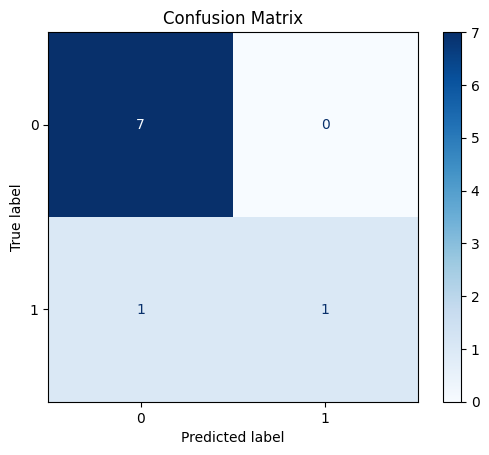

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fused_outputs = torch.tensor([
    [-0.0299], [-0.0938], [-0.1008], [-0.0249], [-0.0545],
    [0.0135], [-0.0975], [-0.1577], [-0.2888]
])
true_labels = torch.tensor([0, 0, 0, 0, 0, 1, 0, 0, 1])
probs = torch.sigmoid(fused_outputs)
predicted_labels = (probs > 0.5).int()
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/fusion_model_trained1.pth")
print("Model saved to Drive!")


Model saved to Drive!


In [ ]:
!git clone https://github.com/karpathy/minGPT.git
%cd minGPT


Cloning into 'minGPT'...
remote: Enumerating objects: 489, done.
remote: Counting objects: 100% (239/239), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 489 (delta 153), reused 145 (delta 145), pack-reused 250 (from 1)
Receiving objects: 100% (489/489), 1.43 MiB | 11.93 MiB/s, done.
Resolving deltas: 100% (267/267), done.
/content/minGPT


In [ ]:
import sys
sys.path.append('/content/minGPT')
from mingpt.model import GPT


In [ ]:
# Prompt Based LLM report generation

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model_gpt2 = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
def generate_text(model, prompt, max_len=100, temperature=0.9, top_k=5):
    encoded_prompt = tokenizer.encode(prompt, return_tensors='pt').to(device)
    generated = encoded_prompt
    eos_token_id = tokenizer.eos_token_id

    for _ in range(max_len):
        outputs = model(generated)
        logits = outputs.logits[:, -1, :] / temperature
        top_k_logits, top_k_indices = torch.topk(logits, top_k)
        probabilities = torch.nn.functional.softmax(top_k_logits, dim=-1)
        next_token = top_k_indices.gather(1, torch.multinomial(probabilities, 1))

        if next_token.item() == eos_token_id:
            break
        generated = torch.cat((generated, next_token), dim=1)
    generated_text = tokenizer.decode(generated[0], skip_special_tokens=True)
    return generated_text
fused_outputs = torch.tensor([
    [-0.0299], [-0.0938], [-0.1008], [-0.0249], [-0.0545],
    [0.0135], [-0.0975], [-0.1577], [-0.2888]
])
probs = torch.sigmoid(fused_outputs)
predicted_labels = (probs > 0.5).int()

prompts = []
for i in range(len(fused_outputs)):
    prob = probs[i].item()
    label = predicted_labels[i].item()
    if label == 1:
        prompt = f"The patient is likely COVID-19 positive (p={prob:.2f}). Summary:"
    else:
        prompt = f"The patient is likely non-COVID (p={prob:.2f}). Summary:"
    prompts.append(prompt)
generated_reports = []
for prompt in prompts:
    report = generate_text(model_gpt2, prompt)
    generated_reports.append(report)

for i, rep in enumerate(generated_reports):
    print(f"\n--- Report for Sample {i+1} ---\n{rep}")


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


--- Report for Sample 1 ---
The patient is likely non-COVID (p=0.49). Summary: The patient was admitted to the ICU with a blood pressure of 110/80 mmHg (p=0.02). The patient was discharged to the intensive care unit and was admitted to the hospital with an ECG.

Conclusions: The patient was discharged from the ICU with a blood pressure of 115/80 mmHg (p=0.02) and ECG results were positive for COVID and COX-2. The patient was discharged from the ICU

--- Report for Sample 2 ---
The patient is likely non-COVID (p=0.48). Summary: There is no evidence of COVID in the patient. There was no evidence of non-COVID in the patient.

CONCLUSIONS: The patient was not a COVID patient. There was no evidence of non-COVID in the patient. The patient may have been a COVID patient. There was no evidence of non-COVID in the patient.

CONCLUSION: There is no evidence of COVID in the patient. There was no evidence of non-COVID in

--- Report for Sample 3 ---
The patient is likely non-COVID (p=0.47). Summa

In [ ]:
# Template-Based Report Generation

In [ ]:
def generate_structured_summary(prob, label):
    if label == 1:
        return f"Classification: COVID-19 positive (Confidence: {prob:.2f}). Immediate isolation and retesting are recommended."
    else:
        return f"Classification: COVID-19 negative (Confidence: {prob:.2f}). Continue monitoring and routine precautions."

In [ ]:
summaries = []
for i in range(len(probs)):
    prob = probs[i].item()
    label = predicted_labels[i].item()
    summary = generate_structured_summary(prob, label)
    summaries.append(summary)

# Print summaries
for i, summary in enumerate(summaries):
    print(f"--- Summary for Sample {i + 1} ---\n{summary}")

--- Summary for Sample 1 ---
Classification: COVID-19 negative (Confidence: 0.49). Continue monitoring and routine precautions.
--- Summary for Sample 2 ---
Classification: COVID-19 negative (Confidence: 0.48). Continue monitoring and routine precautions.
--- Summary for Sample 3 ---
Classification: COVID-19 negative (Confidence: 0.47). Continue monitoring and routine precautions.
--- Summary for Sample 4 ---
Classification: COVID-19 negative (Confidence: 0.49). Continue monitoring and routine precautions.
--- Summary for Sample 5 ---
Classification: COVID-19 negative (Confidence: 0.49). Continue monitoring and routine precautions.
--- Summary for Sample 6 ---
Classification: COVID-19 positive (Confidence: 0.50). Immediate isolation and retesting are recommended.
--- Summary for Sample 7 ---
Classification: COVID-19 negative (Confidence: 0.48). Continue monitoring and routine precautions.
--- Summary for Sample 8 ---
Classification: COVID-19 negative (Confidence: 0.46). Continue monito

In [ ]:
# RAG

In [ ]:
context = "Symptoms: fever, cough. CT scan: mild lung opacity. RT-PCR: positive."
prompt = f"{context}\n\nBased on this clinical data, summarize the COVID-19 condition:"


In [ ]:
def create_rag_prompt(prob, label):
    if label == 1:
        return f"A patient is classified as COVID-19 positive (confidence: {prob:.2f}). Based on biomedical guidelines, what treatment or follow-up is recommended?"
    else:
        return f"A patient is classified as COVID-19 negative (confidence: {prob:.2f}). Based on clinical practice, what preventive measures or monitoring steps should be followed?"


In [ ]:
rag_prompts = [create_rag_prompt(prob.item(), label.item()) for prob, label in zip(probs, labels)]

In [ ]:
import torch
fused_outputs = torch.tensor([
    [-0.0299], [-0.0938], [-0.1008], [-0.0249], [-0.0545],
    [0.0135], [-0.0975], [-0.1577], [-0.2888]
])
probs = torch.sigmoid(fused_outputs)
predicted_labels = (probs > 0.5).int()
def generate_structured_summary(prob, label):
    if label == 1:
        return f"Classification: COVID-19 positive (Confidence: {prob:.2f}). Immediate isolation and retesting are recommended."
    else:
        return f"Classification: COVID-19 negative (Confidence: {prob:.2f}). Continue monitoring and routine precautions."
summaries = []
for prob, label in zip(probs, predicted_labels):
    summary = generate_structured_summary(prob.item(), label.item())
    summaries.append(summary)
for i, summary in enumerate(summaries):
    print(f"\n--- Summary for Sample {i + 1} ---\n{summary}")


--- Summary for Sample 1 ---
Classification: COVID-19 negative (Confidence: 0.49). Continue monitoring and routine precautions.

--- Summary for Sample 2 ---
Classification: COVID-19 negative (Confidence: 0.48). Continue monitoring and routine precautions.

--- Summary for Sample 3 ---
Classification: COVID-19 negative (Confidence: 0.47). Continue monitoring and routine precautions.

--- Summary for Sample 4 ---
Classification: COVID-19 negative (Confidence: 0.49). Continue monitoring and routine precautions.

--- Summary for Sample 5 ---
Classification: COVID-19 negative (Confidence: 0.49). Continue monitoring and routine precautions.

--- Summary for Sample 6 ---
Classification: COVID-19 positive (Confidence: 0.50). Immediate isolation and retesting are recommended.

--- Summary for Sample 7 ---
Classification: COVID-19 negative (Confidence: 0.48). Continue monitoring and routine precautions.

--- Summary for Sample 8 ---
Classification: COVID-19 negative (Confidence: 0.46). Continu